# Citations

In [ ]:
# @misc{tensorflow2015-whitepaper,
# title={ {TensorFlow}: Large-Scale Machine Learning on Heterogeneous Systems},
# url={https://www.tensorflow.org/},
# note={Software available from tensorflow.org},
# author={
#     Mart\'{\i}n~Abadi and
#     Ashish~Agarwal and
#     Paul~Barham and
#     Eugene~Brevdo and
#     Zhifeng~Chen and
#     Craig~Citro and
#     Greg~S.~Corrado and
#     Andy~Davis and
#     Jeffrey~Dean and
#     Matthieu~Devin and
#     Sanjay~Ghemawat and
#     Ian~Goodfellow and
#     Andrew~Harp and
#     Geoffrey~Irving and
#     Michael~Isard and
#     Yangqing Jia and
#     Rafal~Jozefowicz and
#     Lukasz~Kaiser and
#     Manjunath~Kudlur and
#     Josh~Levenberg and
#     Dandelion~Man\'{e} and
#     Rajat~Monga and
#     Sherry~Moore and
#     Derek~Murray and
#     Chris~Olah and
#     Mike~Schuster and
#     Jonathon~Shlens and
#     Benoit~Steiner and
#     Ilya~Sutskever and
#     Kunal~Talwar and
#     Paul~Tucker and
#     Vincent~Vanhoucke and
#     Vijay~Vasudevan and
#     Fernanda~Vi\'{e}gas and
#     Oriol~Vinyals and
#     Pete~Warden and
#     Martin~Wattenberg and
#     Martin~Wicke and
#     Yuan~Yu and
#     Xiaoqiang~Zheng},
#   year={2015},
# }

# @misc{chollet2015keras,
#   title={Keras},
#   author={Chollet, Fran\c{c}ois and others},
#   year={2015},
#   howpublished={\url{https://keras.io}},
# }

# @article{scikit-learn,
#  title={Scikit-learn: Machine Learning in {P}ython},
#  author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
#          and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
#          and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
#          Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
#  journal={Journal of Machine Learning Research},
#  volume={12},
#  pages={2825--2830},
#  year={2011}
# }

# @inproceedings{Yang2016HierarchicalAN,
#   title={Hierarchical Attention Networks for Document Classification},
#   author={Zichao Yang and Diyi Yang and Chris Dyer and Xiaodong He and Alexander J. Smola and Eduard H. Hovy},
#   booktitle={HLT-NAACL},
#   year={2016}
# }

# @Article{Hunter:2007,
#   Author    = {Hunter, J. D.},
#   Title     = {Matplotlib: A 2D graphics environment},
#   Journal   = {Computing In Science \& Engineering},
#   Volume    = {9},
#   Number    = {3},
#   Pages     = {90--95},
#   abstract  = {Matplotlib is a 2D graphics package used for Python
#   for application development, interactive scripting, and
#   publication-quality image generation across user
#   interfaces and operating systems.},
#   publisher = {IEEE COMPUTER SOC},
#   doi       = {10.1109/MCSE.2007.55},
#   year      = 2007
# }

# Importing Packages and Basic Parameters

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io as sio
import matplotlib.pyplot as plt
import os
from tensorflow.python.client import device_lib
from tensorflow.keras.layers import Concatenate, GRU, Bidirectional, LeakyReLU, Dense, Dropout, Input, Convolution1D, Layer, Activation, Add, Lambda, UpSampling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers, initializers, constraints
from tensorflow.keras import backend as K
from tensorflow.keras.losses import categorical_crossentropy, mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy import stats
from scipy import interpolate
from os import listdir
from tqdm import tqdm
random_seed = 34
batch_size = 64
num_classes = 9
epochs = 100
#decide the GPUs to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#target ECG leads to train
TargetLead = [0,1,2,3,4,5,6,7,8,9,10,11]
#Designate the CPSC2018 dataset to load (http://2018.icbeb.org/Challenge.html)
#F. F. Liu, C. Y. Liu*, L. N. Zhao, X. Y. Zhang, X. L. Wu, X. Y. Xu, Y. L. Liu, C. Y. Ma, S. S. Wei, Z. Q. He, J. Q. Li and N. Y. Kwee. An open access database for evaluating the algorithms of ECG rhythm and morphology abnormal detection. Journal of Medical Imaging and Health Informatics, 2018, 8(7): 1368–1373.
data_folder_path = './CPSC2018Dataset/TrainingSet1/'
data_folder_path2 = './CPSC2018Dataset/TrainingSet2/'
data_folder_path3 = './CPSC2018Dataset/TrainingSet3/'
data_label = './CPSC2018Dataset/REFERENCE.csv'

# CPU and GPU Checking

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Defining Evaluating Function

In [ ]:
def f1(y_true, y_pred2):
    y_pred = K.one_hot(K.argmax(y_pred2),num_classes=num_classes)
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# CPSC2018 Data Combining

In [ ]:
dataList = listdir(data_folder_path)
dataList2 = listdir(data_folder_path2)
dataList3 = listdir(data_folder_path3)
REFERENCE = pd.read_csv(data_label)
REFERENCE.head()

Recording  First_label  Second_label  Third_label
0     A0001            5           NaN          NaN
1     A0002            1           NaN          NaN
2     A0003            2           NaN          NaN
3     A0004            2           NaN          NaN
4     A0005            7           NaN          NaN

In [ ]:
First_label = pd.get_dummies(REFERENCE['First_label'])
First_label.head()

1  2  3  4  5  6  7  8  9
0  0  0  0  0  1  0  0  0  0
1  1  0  0  0  0  0  0  0  0
2  0  1  0  0  0  0  0  0  0
3  0  1  0  0  0  0  0  0  0
4  0  0  0  0  0  0  1  0  0

In [ ]:
Second_label = pd.get_dummies(REFERENCE['Second_label'])
Second_label.head()

2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0
0    0    0    0    0    0    0    0    0
1    0    0    0    0    0    0    0    0
2    0    0    0    0    0    0    0    0
3    0    0    0    0    0    0    0    0
4    0    0    0    0    0    0    0    0

In [ ]:
Third_label = pd.get_dummies(REFERENCE['Third_label'])
Third_label.head()

4.0  6.0  8.0  9.0
0    0    0    0    0
1    0    0    0    0
2    0    0    0    0
3    0    0    0    0
4    0    0    0    0

In [ ]:
Combined_label = First_label.copy().fillna(0)
Combined_label[Second_label.columns] = Combined_label[Second_label.columns] + Second_label
Combined_label[Third_label.columns] = Combined_label[Third_label.columns] + Third_label
Combined_label['Recording'] = REFERENCE['Recording']
Combined_label.head()

1  2  3  4  5  6  7  8  9 Recording
0  0  0  0  0  1  0  0  0  0     A0001
1  1  0  0  0  0  0  0  0  0     A0002
2  0  1  0  0  0  0  0  0  0     A0003
3  0  1  0  0  0  0  0  0  0     A0004
4  0  0  0  0  0  0  1  0  0     A0005

In [ ]:
X_list = []
Y_list = []
t = []
for i in dataList:
    if i == '.ipynb_checkpoints':
        continue
    patient = np.zeros((72000,12), dtype=np.float32)
    t.append(sio.loadmat(data_folder_path+i)['ECG'][0][0][2].shape[1])
    patient[-sio.loadmat(data_folder_path+i)['ECG'][0][0][2].shape[1]:,:] = sio.loadmat(data_folder_path+i)['ECG'][0][0][2].T
    if patient.shape[0] == 72000:
        X_list.append([patient])
        First_label = pd.get_dummies(REFERENCE['First_label'])
        Second_label = pd.get_dummies(REFERENCE['Second_label'])
        Third_label = pd.get_dummies(REFERENCE['Third_label'])
        Combined_label = First_label.copy()
        Combined_label[Second_label.columns] = Combined_label[Second_label.columns] + Second_label
        Combined_label[Third_label.columns] = Combined_label[Third_label.columns] + Third_label
        Combined_label['Recording'] = REFERENCE['Recording']
        Combined_label = Combined_label.fillna(0)
        Y_list.append(Combined_label[Combined_label['Recording'] == i[:5]].values)

for i in dataList2:
    if i == '.ipynb_checkpoints':
        continue
    patient = np.zeros((72000,12), dtype=np.float32)
    t.append(sio.loadmat(data_folder_path2+i)['ECG'][0][0][2].shape[1])

    patient[-sio.loadmat(data_folder_path2+i)['ECG'][0][0][2].shape[1]:,:] = sio.loadmat(data_folder_path2+i)['ECG'][0][0][2].T
    if patient.shape[0] == 72000:
        X_list.append([patient])
        First_label = pd.get_dummies(REFERENCE['First_label'])
        Second_label = pd.get_dummies(REFERENCE['Second_label'])
        Third_label = pd.get_dummies(REFERENCE['Third_label'])
        Combined_label = First_label.copy()
        Combined_label[Second_label.columns] = Combined_label[Second_label.columns] + Second_label
        Combined_label[Third_label.columns] = Combined_label[Third_label.columns] + Third_label
        Combined_label['Recording'] = REFERENCE['Recording']
        Combined_label = Combined_label.fillna(0)
        Y_list.append(Combined_label[Combined_label['Recording'] == i[:5]].values)

for i in dataList3:
    if i == '.ipynb_checkpoints':
        continue
    patient = np.zeros((72000,12), dtype=np.float32)
    t.append(sio.loadmat(data_folder_path3+i)['ECG'][0][0][2].shape[1])

    patient[-sio.loadmat(data_folder_path3+i)['ECG'][0][0][2].shape[1]:,:] = sio.loadmat(data_folder_path3+i)['ECG'][0][0][2].T
    if patient.shape[0] == 72000:
        X_list.append([patient])
        First_label = pd.get_dummies(REFERENCE['First_label'])
        Second_label = pd.get_dummies(REFERENCE['Second_label'])
        Third_label = pd.get_dummies(REFERENCE['Third_label'])
        Combined_label = First_label.copy()
        Combined_label[Second_label.columns] = Combined_label[Second_label.columns] + Second_label
        Combined_label[Third_label.columns] = Combined_label[Third_label.columns] + Third_label
        Combined_label['Recording'] = REFERENCE['Recording']
        Combined_label = Combined_label.fillna(0)
        Y_list.append(Combined_label[Combined_label['Recording'] == i[:5]].values)

X_list = np.asarray(X_list)[:,0,:,:]
Y_list = np.asarray(Y_list)[:,0,:]
print(X_list.shape, Y_list.shape)

(6877, 72000, 12) (6877, 10)


# CPSC2018 Data Preprocessing

In [ ]:
X_list = X_list[:,:,:]
Y_list = Y_list[:,:-1]

In [ ]:
Y_list[Y_list>=1] = 1
Y_list[Y_list<1] = 0
selectedSampled = {0:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) == 1 and Y_list[i,0] == 1],\
                   1:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) == 1 and Y_list[i,1] == 1],\
                   2:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) == 1 and Y_list[i,2] == 1],\
                   3:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) == 1 and Y_list[i,3] == 1],\
                   4:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) == 1 and Y_list[i,4] == 1],\
                   5:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) == 1 and Y_list[i,5] == 1],\
                   6:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) == 1 and Y_list[i,6] == 1],\
                   7:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) == 1 and Y_list[i,7] == 1],\
                   8:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) == 1 and Y_list[i,8] == 1],\
                   9:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) == 1],\
                   10:[i for i in range(Y_list.shape[0]) if np.count_nonzero(Y_list[i,:] == 1) > 1]}
for i in range(11):
    print(len(selectedSampled[i]))
Y_list2 = Y_list[selectedSampled[9],:]
Y_list2

918
976
686
179
1533
533
607
784
185
6401
476


array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=object)

# CPSC2018 Data Splitting Train-Validation-Test Data

In [ ]:
X = X_list[selectedSampled[9]]
y = np.argmax(Y_list[selectedSampled[9]], axis=1)
skf = StratifiedKFold(n_splits=10, random_state = random_seed, shuffle=True)
skf.get_n_splits(X, y)
print(skf)
FoldIndicesList = []
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    FoldIndicesList.append((train_index,test_index))
FoldIndicesList = np.asarray(FoldIndicesList)
np.save('./FoldIndicesList',FoldIndicesList)
FoldIndicesList = np.load('./FoldIndicesList.npy')

# CPSC2018 Benchmark Model Architecture

In [ ]:
#defining AttentionWithContext layer
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
            self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        if self.bias:
            uit += self.b
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        a = K.exp(ait)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

#benchmark model architecture
def MetforNet121(length):
    main_input = Input(shape=(length,1), dtype='float32', name='main_input')
    x = Convolution1D(12, 3, padding='same')(main_input)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 24, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 3, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Convolution1D(12, 48, strides = 2, padding='same')(x)
    x = LeakyReLU(alpha=0.3)(x)
    cnnout = Dropout(0.2)(x)
    x = Bidirectional(GRU(12,return_sequences=True,return_state=False))(cnnout)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    x = AttentionWithContext()(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.3)(x)
    x = Dropout(0.2)(x)
    main_output = Dense(9,activation='sigmoid')(x)
    return Model(inputs=main_input, outputs=main_output)

model = MetforNet121(5000)
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 5000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 5000, 12)          48        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 5000, 12)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5000, 12)          444       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 5000, 12)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 2500, 12)          3468      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 2500, 12)          0     

# Benchmark Model Training and 10-fold Cross Validation

In [ ]:
#defining stepper for downsampling
def Step(X, k):
    X_step = []
    for i in range(0,X.shape[1],k):
        X_step.append(X[:,i,:].copy())
    X_step = np.swapaxes(np.asarray(X_step), 0, 1)
    length = X_step.shape[1]
    return X_step, length

In [ ]:
#10-fold training
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
Hz = np.asarray([500,250,125,100,50,25,10,5,2,1])
FoldIndicesList = np.load('./FoldIndicesList.npy')
lr = 0.001
for j in range(12):
    if j not in TargetLead:
        continue
    for k in Hz:
        for i in range(10):
            model_name = './benchmark/CPSC2018_10_fold_model_lead_'+str(leadsLabel[j])+'_Hz_'+str(k)+'_fold_'+str(i)
            x_train_from_train = X_list[selectedSampled[9]][np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
            x_val_from_train = X_list[selectedSampled[9]][FoldIndicesList[i-1][1]]
            y_train_from_train = Y_list[selectedSampled[9]][np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
            y_val_from_train = Y_list[selectedSampled[9]][FoldIndicesList[i-1][1]]
            x_train_from_train, length = Step(x_train_from_train[:,:,j:j+1],500//k)
            x_val_from_train, length = Step(x_val_from_train[:,:,j:j+1],500//k)
            model = MetforNet121(length)

            opt = keras.optimizers.Adam(lr=lr)
            model.compile(loss='categorical_crossentropy',
                          optimizer=opt,
                          metrics=[f1])
            checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
            model_history = model.fit( x_train_from_train, y_train_from_train,
                                      batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpointer],
                                     validation_data=(x_val_from_train, y_val_from_train))

# Benchmark Model Infering The 10-fold Test Sets

In [ ]:
#Cross-validation on test set
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
Hz = np.asarray([500,250,125,100,50,25,10,5,2,1])
FoldIndicesList = np.load('./FoldIndicesList.npy')
for j in range(12):
    if j not in TargetLead:
        continue
    HzList = []
    for k in tqdm(range(10)):
        scoreList = []
        for i in range(10):
            model_name = './benchmark/CPSC2018_10_fold_model_lead_'+str(leadsLabel[j])+'_Hz_'+str(Hz[k])+'_fold_'+str(i)
            x_test_from_train = X_list[selectedSampled[9]][FoldIndicesList[i][1]].copy()
            y_test_from_train = Y_list[selectedSampled[9]][FoldIndicesList[i][1]].copy()
            x_test_from_train, length = Step(x_test_from_train[:,:,j:j+1],500//Hz[k])
            model = MetforNet121(length)
            model.load_weights(model_name)
            y_true = np.argmax(y_test_from_train, axis=1)
            y_raw_pred = model.predict(x_test_from_train)
            y_pred = np.argmax(y_raw_pred, axis=1)
            score = f1_score(y_true, y_pred, average=None)
            scoreList.append(score)
        scoreList = np.asarray(scoreList)
        HzList.append(scoreList)
    HzList = np.asarray(HzList)
    np.save('./comparison/CPSC2018_10_fold_lead_models_test_result_lead_'+str(leadsLabel[j]),HzList)

Lead :I


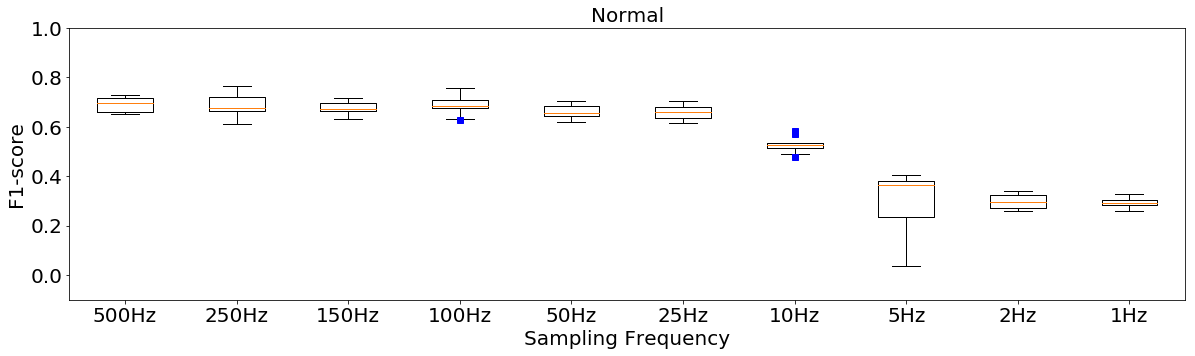

[0.69614617 0.67628377 0.67313202 0.6837924  0.65545204 0.6617033
 0.52551451 0.36357746 0.29625569 0.29179037]
100
25
[1.00000000e+00 5.99882863e-01 2.50640359e-01 7.14340925e-01
 2.04812156e-02 1.85726906e-02 2.35115112e-06 7.55384184e-06
 8.65607430e-10 1.78167133e-11]


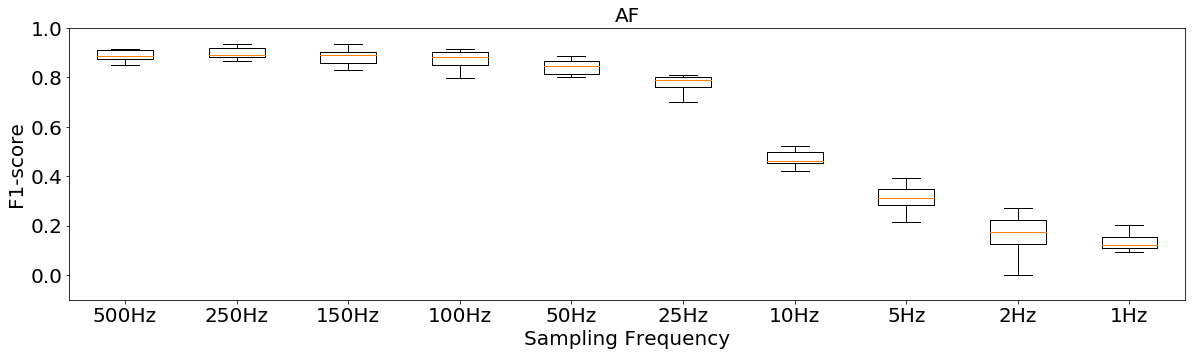

[0.88692614 0.889989   0.89104639 0.88262665 0.84763564 0.78775383
 0.46339763 0.31239426 0.17602848 0.12378297]
100
100
[1.00000000e+00 1.81712496e-01 6.59131192e-01 1.27594112e-01
 2.42760004e-04 1.48265643e-05 6.20179837e-11 1.10722991e-09
 8.86502636e-10 4.70895577e-12]


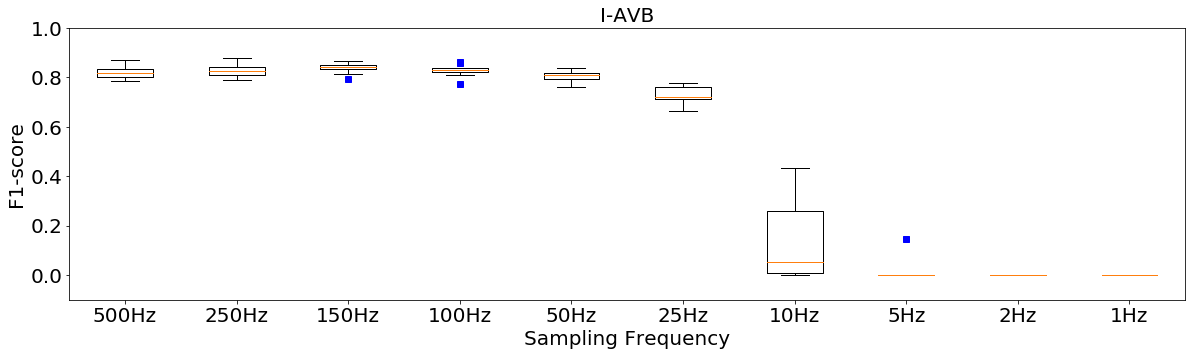

[0.81712963 0.82623733 0.84358784 0.83144301 0.80972058 0.72076023
 0.05158451 0.         0.         0.        ]
50
50
[1.00000000e+00 5.83662641e-01 9.06224474e-02 4.54955925e-01
 1.88688748e-01 3.66629119e-05 6.09824042e-07 4.53534498e-12
 1.61369093e-14 1.61369093e-14]


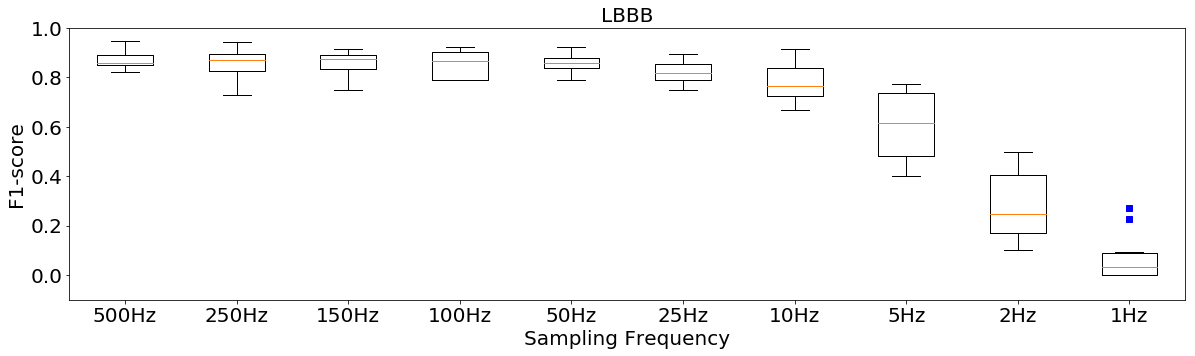

[0.85714286 0.8697479  0.8736089  0.86486486 0.85667486 0.81935484
 0.76640712 0.61731602 0.24630542 0.03125   ]
50
50
[1.00000000e+00 4.85374276e-01 2.45748546e-01 3.41249056e-01
 3.28561253e-01 7.26090661e-03 1.55951720e-03 2.69284479e-04
 5.69214613e-07 1.01748424e-09]


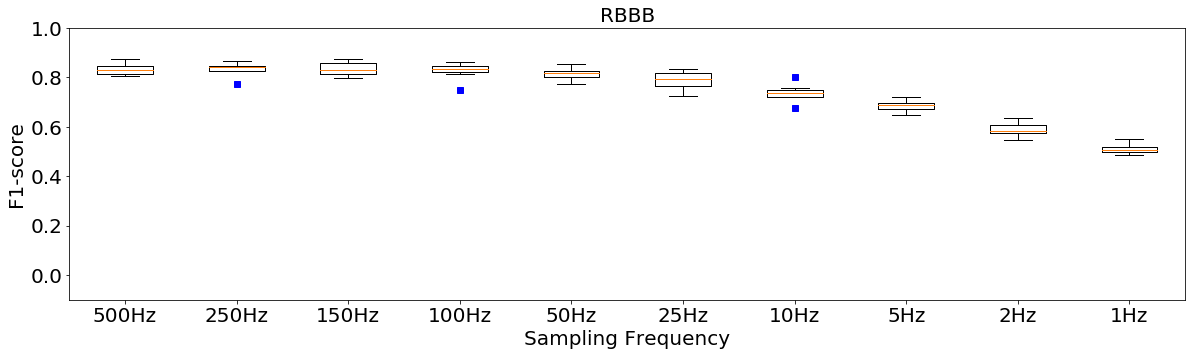

[0.82921587 0.8414489  0.82801853 0.83462332 0.81792949 0.79449634
 0.73754634 0.68663585 0.58454996 0.50516411]
100
100
[1.00000000e+00 7.25644695e-01 7.26002883e-01 5.89293895e-01
 6.16035406e-03 4.35736612e-03 3.60651279e-06 1.52400531e-08
 2.69087970e-09 1.06983887e-09]


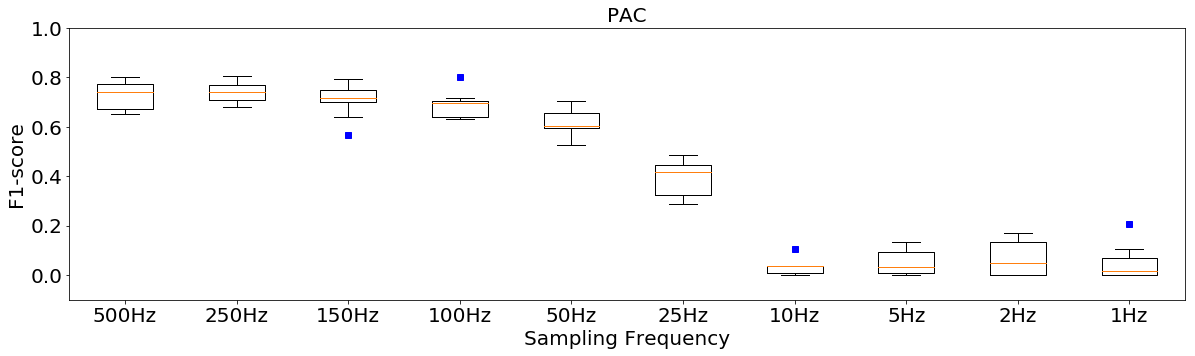

[0.74255804 0.74252137 0.71860109 0.69521045 0.6052733  0.4190319
 0.03478524 0.03449301 0.05056497 0.01666667]
100
100
[1.00000000e+00 4.50276052e-01 3.73651329e-01 9.83812919e-02
 5.58383762e-05 2.99407142e-07 2.80298290e-10 6.08197862e-09
 1.03842918e-09 4.15578228e-10]


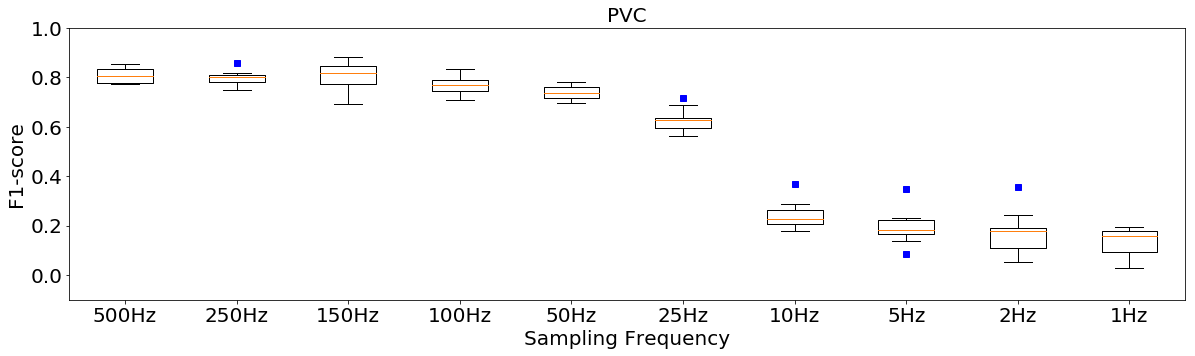

[0.80706964 0.80178571 0.81936035 0.76778309 0.73525758 0.62730769
 0.22739018 0.18184166 0.17660891 0.15918046]
125
100
[1.00000000e+00 2.67651270e-01 9.14703422e-01 1.70545089e-02
 1.13737490e-04 6.33171426e-07 3.70129214e-11 3.48635637e-10
 1.38994340e-09 1.12865340e-10]


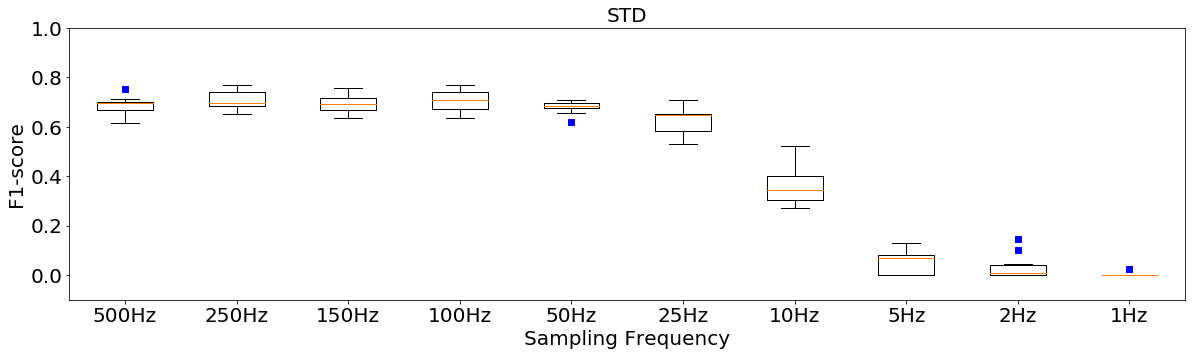

[0.69489897 0.6966734  0.69109462 0.7075419  0.68558657 0.64968153
 0.34400657 0.07059801 0.00925926 0.        ]
50
25
[1.00000000e+00 3.91373608e-02 5.71486025e-01 1.52765045e-01
 7.27738722e-01 1.41226627e-02 1.18988324e-06 1.29363562e-10
 3.84831925e-11 2.32748998e-12]


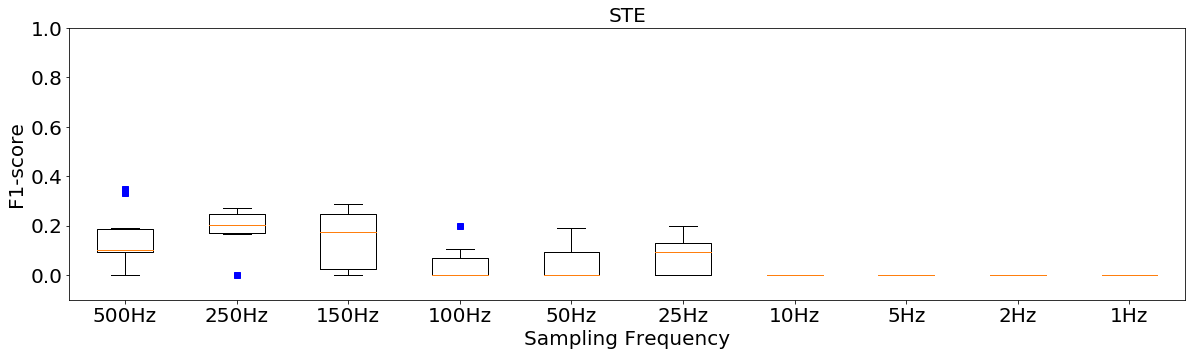

[0.10263158 0.20234114 0.1752381  0.         0.         0.09347826
 0.         0.         0.         0.        ]
25*
25*
[1.         0.21352114 0.92025917 0.06628344 0.03332985 0.17702321
 0.00418565 0.00418565 0.00418565 0.00418565]


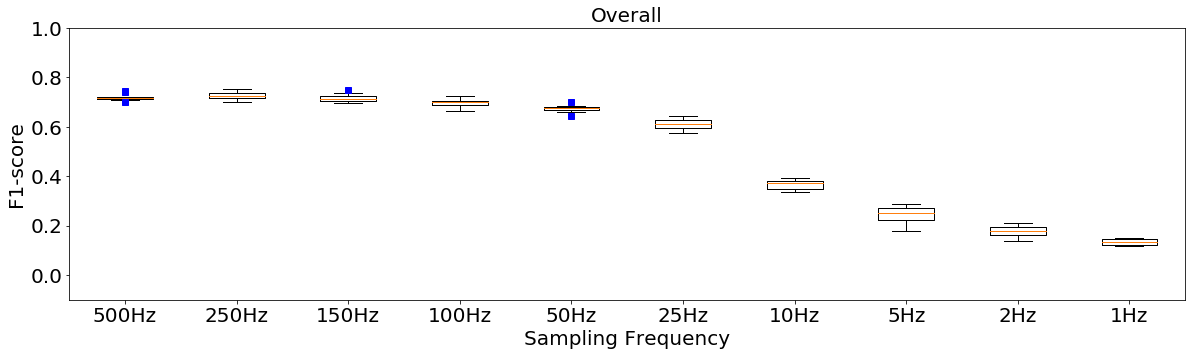

[0.71657209 0.72594606 0.71147613 0.69873935 0.67667378 0.61048655
 0.37176291 0.25053715 0.17766254 0.13383203]
125
125
[1.00000000e+00 2.61242053e-01 7.04108461e-01 2.31495061e-03
 1.02840604e-05 1.98876297e-08 2.17718638e-12 2.50304296e-11
 2.70757782e-13 1.41722157e-15]
Lead :II


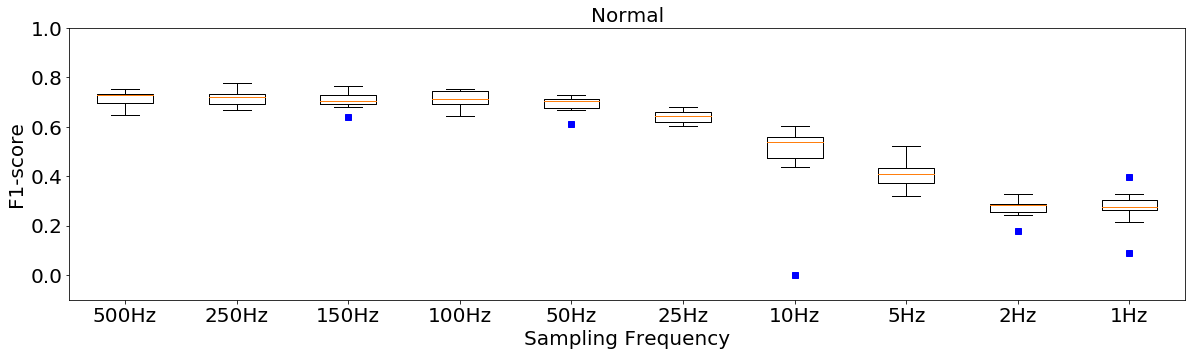

[0.72811299 0.72112429 0.70517701 0.71388957 0.70541834 0.6420339
 0.53682346 0.41083994 0.28259226 0.27656228]
100
50
[1.00000000e+00 5.67299597e-01 7.45430672e-01 8.54843103e-01
 4.51779608e-02 2.28318669e-05 1.33538613e-03 3.86586708e-08
 6.66040169e-10 6.05444706e-08]


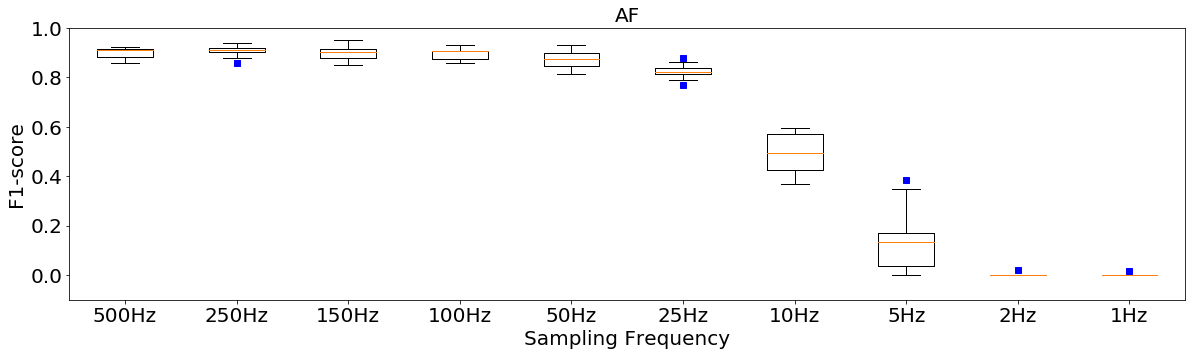

[0.91271144 0.91287879 0.90364355 0.90490165 0.87623957 0.82224381
 0.49276235 0.1352381  0.         0.        ]
100
50
[1.00000000e+00 7.76043497e-02 7.82366673e-01 3.37478799e-01
 2.15387721e-02 1.21885202e-06 1.10030127e-07 2.95084230e-08
 4.76178004e-16 1.30358118e-15]


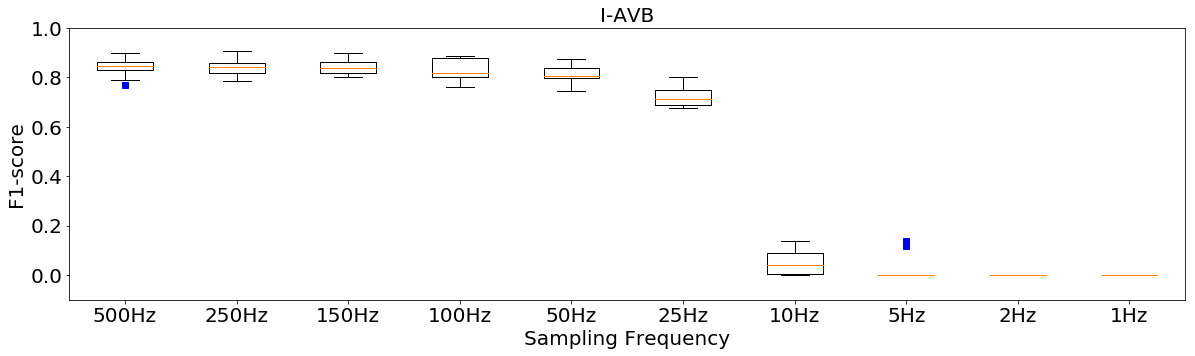

[0.84711665 0.84067202 0.83920877 0.81847803 0.80768093 0.71240679
 0.04115942 0.         0.         0.        ]
100
50
[1.00000000e+00 7.06466721e-01 8.99073327e-01 1.25821776e-01
 1.10617372e-02 5.77600411e-06 3.85174134e-11 2.36754776e-12
 1.96790589e-13 1.96790589e-13]


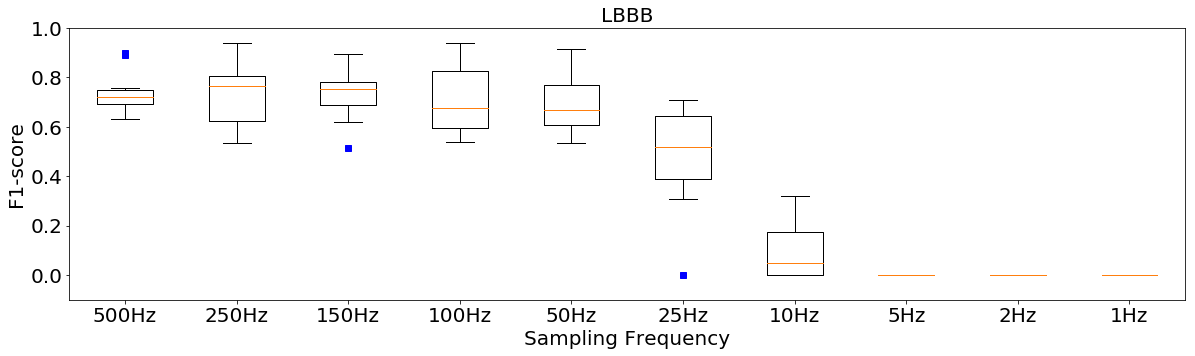

[0.72222222 0.76470588 0.75337838 0.67647059 0.66733871 0.51923077
 0.04761905 0.         0.         0.        ]
50
50
[1.00000000e+00 7.01115756e-01 8.32526342e-01 2.76749743e-01
 2.15026361e-01 1.31079156e-03 1.49366180e-07 9.14344989e-10
 9.14344989e-10 9.14344989e-10]


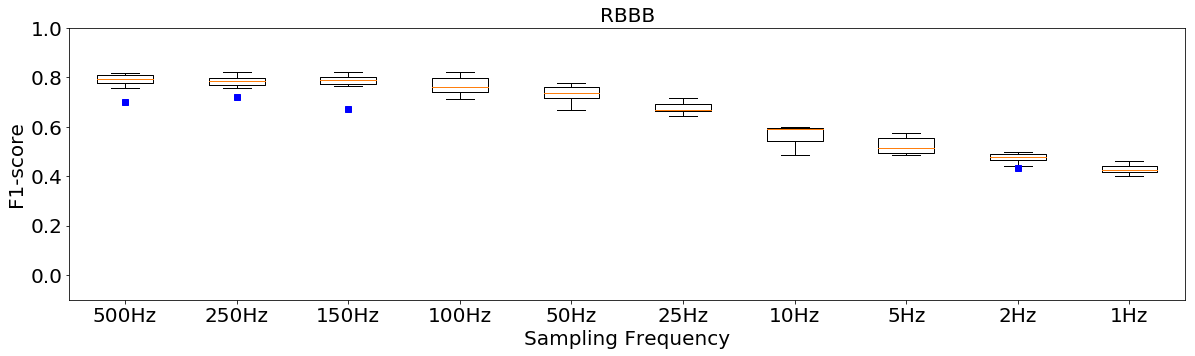

[0.79383765 0.78691893 0.79017333 0.76265665 0.73526868 0.66974866
 0.59103536 0.51436562 0.47942073 0.42365101]
100
100
[1.00000000e+00 6.61970010e-01 5.49138737e-01 1.37810289e-01
 1.96786265e-05 9.36777714e-06 3.95945751e-07 7.55758889e-08
 3.33582873e-09 5.19506539e-10]


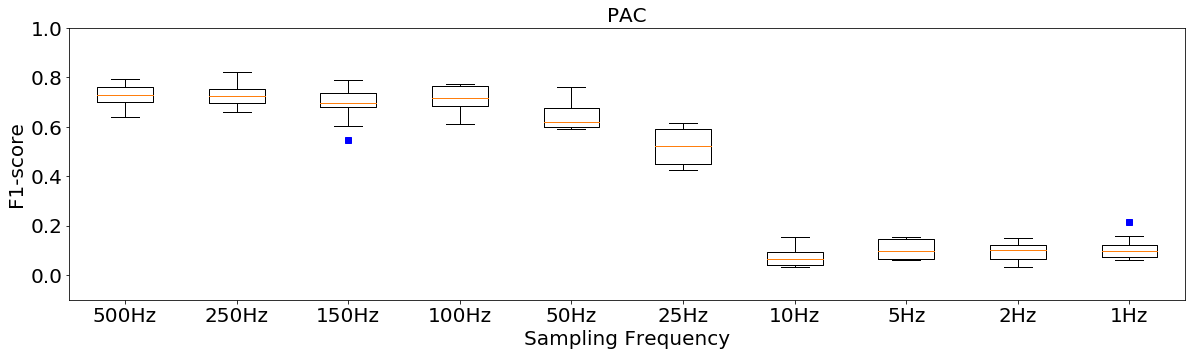

[0.729317   0.72413793 0.69573129 0.71583733 0.62087087 0.5244153
 0.06349206 0.09756742 0.10352815 0.09827278]
100
100
[1.00000000e+00 5.40853962e-01 1.71573163e-01 7.55873467e-01
 1.88921813e-03 7.53695200e-06 5.71031814e-10 9.44972064e-11
 1.14766758e-09 6.89586251e-10]


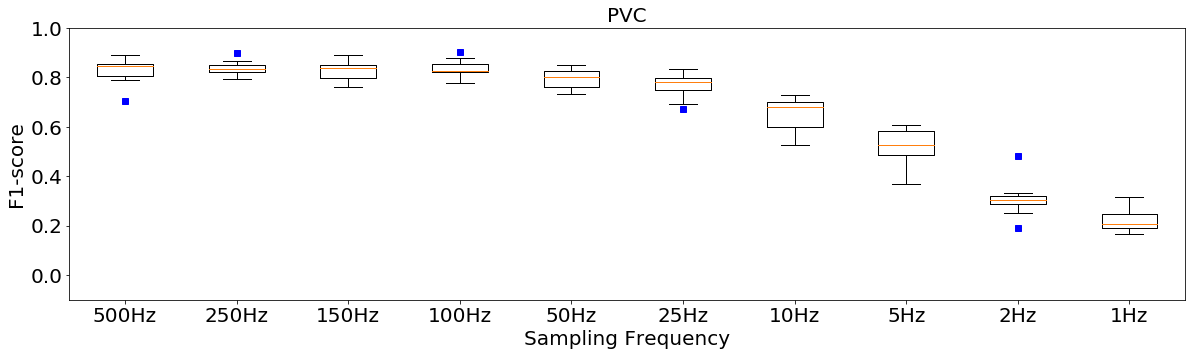

[0.84425183 0.83405766 0.83815826 0.82758621 0.8034188  0.78330435
 0.68082759 0.52690206 0.30380288 0.20588235]
50
25
[1.00000000e+00 6.00234145e-01 9.78166502e-01 6.89729290e-01
 6.75463326e-02 1.56120069e-02 5.03146058e-05 1.71237313e-07
 1.04674136e-09 8.97832498e-11]


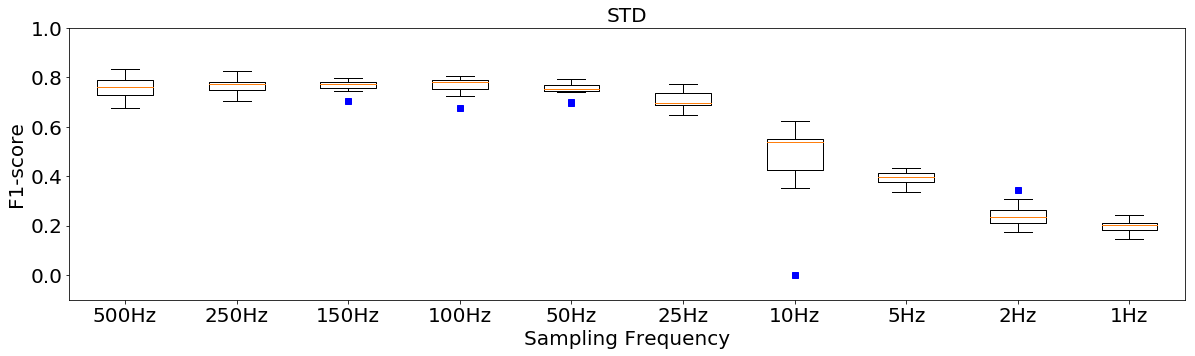

[0.76036239 0.77317203 0.77287356 0.78347428 0.75293135 0.6978801
 0.53763441 0.39815725 0.23488844 0.20077519]
50
50
[1.00000000e+00 1.86424178e-01 4.95073117e-01 2.64111109e-01
 7.30808452e-01 6.30073424e-03 9.58442362e-04 4.18687225e-09
 9.59276515e-10 3.52694579e-10]


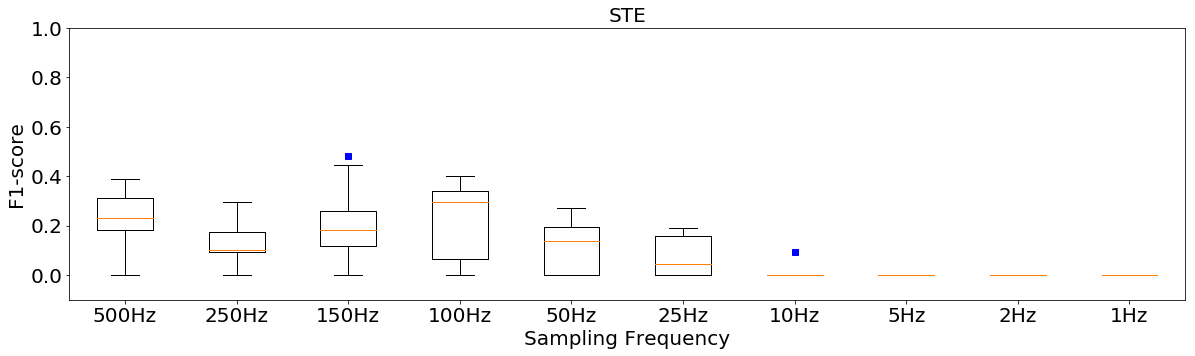

[0.23160173 0.1        0.18181818 0.29636364 0.13695652 0.04545455
 0.         0.         0.         0.        ]
50*
25*
[1.00000000e+00 3.46161377e-02 7.89927549e-01 9.89382419e-01
 1.19790043e-01 1.25808668e-02 1.72176030e-04 1.94855491e-04
 1.94855491e-04 1.94855491e-04]


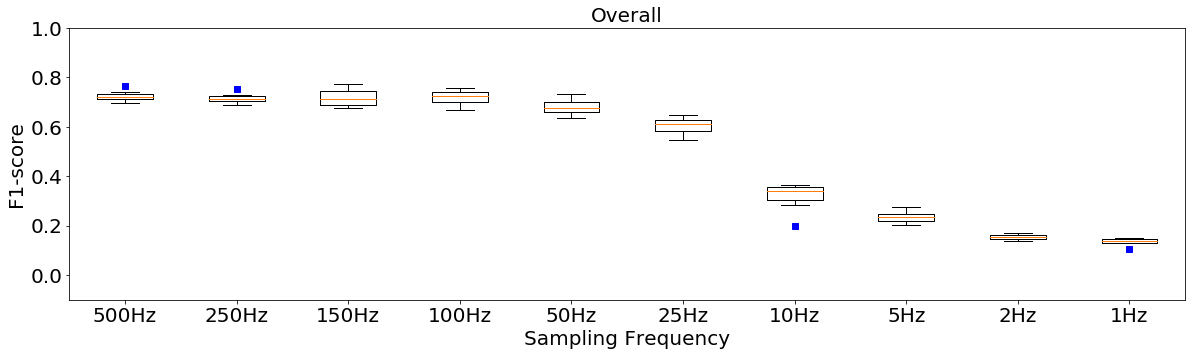

[0.72273511 0.71125376 0.7115386  0.72343792 0.67431744 0.60950974
 0.34041525 0.23533105 0.1554804  0.13948188]
100
100
[1.00000000e+00 3.03597959e-01 6.45436231e-01 5.51442582e-01
 5.64173697e-03 1.05064958e-07 3.41790346e-09 1.76435505e-11
 9.43794784e-14 3.77034509e-15]
Lead :III


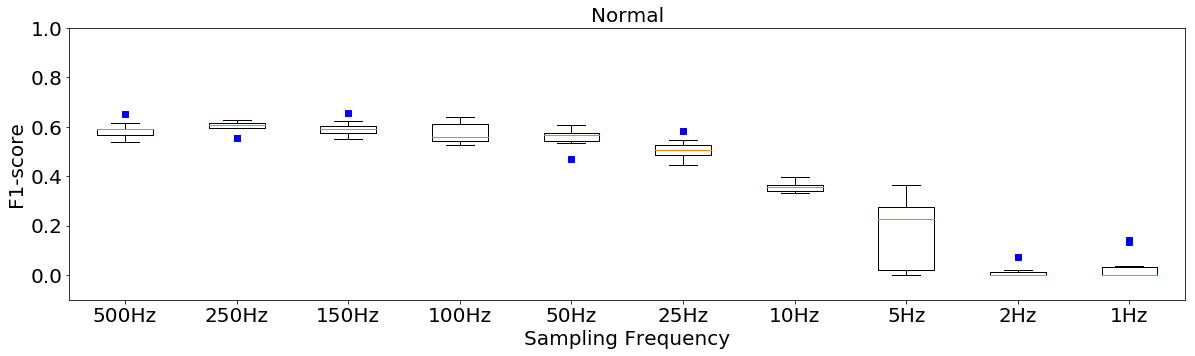

[0.59069544 0.60618698 0.59237056 0.55840923 0.56550703 0.50609756
 0.35710078 0.22650231 0.         0.        ]
100
50
[1.00000000e+00 2.34688040e-01 4.71006910e-01 4.08259539e-01
 4.59154440e-02 3.93933657e-05 3.48171581e-10 1.11109339e-05
 3.54380796e-11 5.61362599e-11]


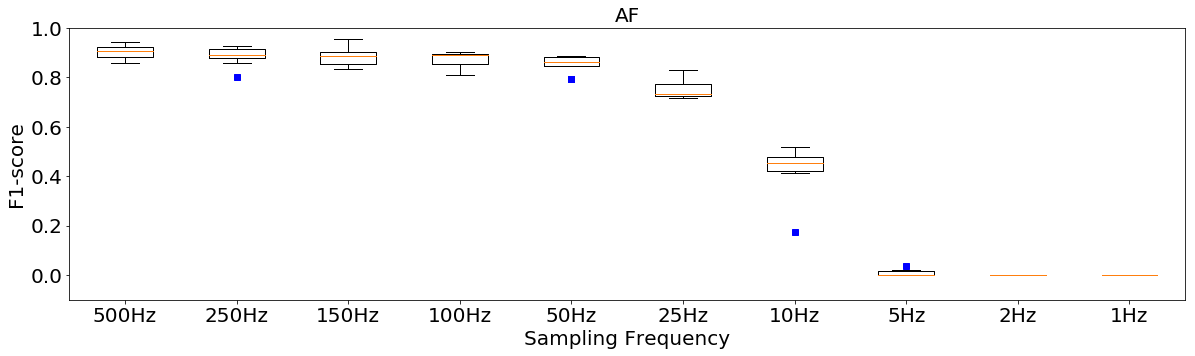

[0.90869487 0.89265804 0.88588639 0.89104639 0.8629285  0.73439503
 0.4517507  0.         0.         0.        ]
125
125
[1.00000000e+00 5.05400338e-02 6.03510169e-02 9.28085756e-04
 5.39653376e-06 2.83756198e-07 2.91558034e-08 8.65602351e-14
 6.35665962e-15 6.35665962e-15]


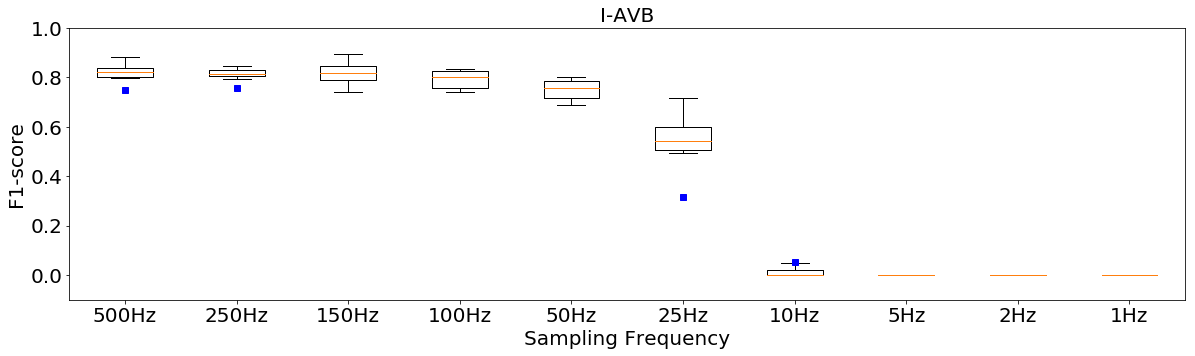

[0.82142857 0.81215006 0.81777974 0.80371189 0.75579418 0.54316269
 0.         0.         0.         0.        ]
125
100
[1.00000000e+00 5.32190833e-01 9.37651898e-01 3.16994723e-02
 6.22883560e-05 5.79068549e-05 9.67740074e-13 7.39645969e-14
 7.39645969e-14 7.39645969e-14]


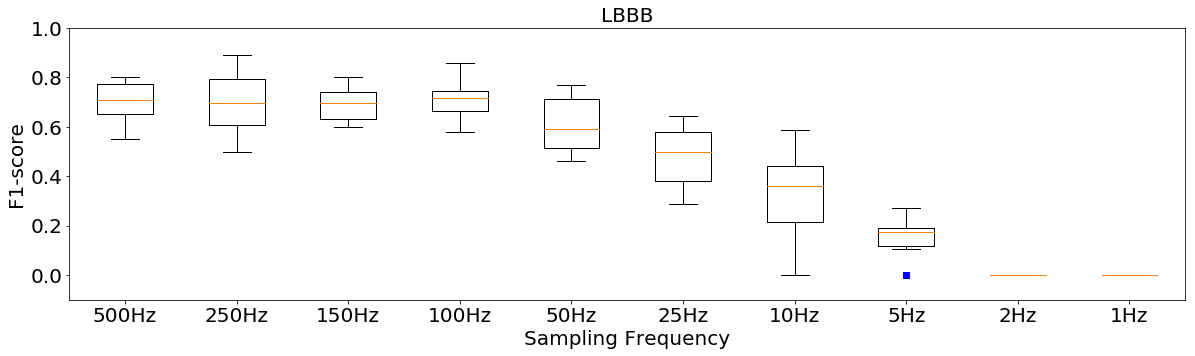

[0.70833333 0.69669118 0.69510135 0.71825397 0.59041394 0.5
 0.35909823 0.17424242 0.         0.        ]
100
100
[1.00000000e+00 9.69241140e-01 6.68558845e-01 6.17029564e-01
 4.97829168e-03 1.29075081e-03 3.40979664e-04 1.78299542e-08
 1.51334885e-09 1.51334885e-09]


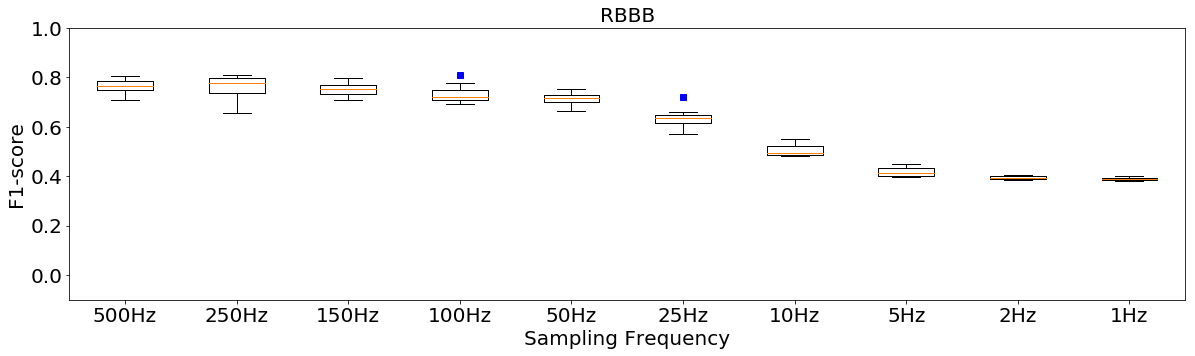

[0.76389655 0.77670049 0.75450944 0.72045395 0.71729014 0.6360412
 0.49436256 0.41229894 0.39409355 0.38819143]
125
125
[1.00000000e+00 9.37443701e-01 2.93419001e-01 5.77825942e-03
 5.04971080e-04 1.05314917e-06 1.59844086e-09 3.30622164e-10
 3.24786088e-11 1.76042542e-11]


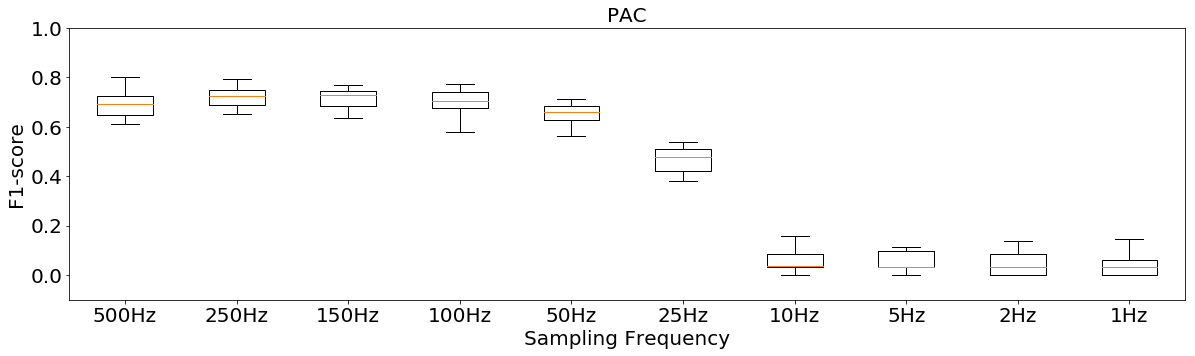

[0.69225109 0.72399672 0.72885375 0.70483997 0.65811966 0.47783897
 0.035401   0.0333426  0.03449301 0.03225806]
50
50
[1.00000000e+00 1.32229753e-01 3.90467737e-01 6.54168492e-01
 7.37535754e-02 5.56252911e-06 4.77332921e-09 6.20174409e-10
 2.98212045e-09 1.78489920e-09]


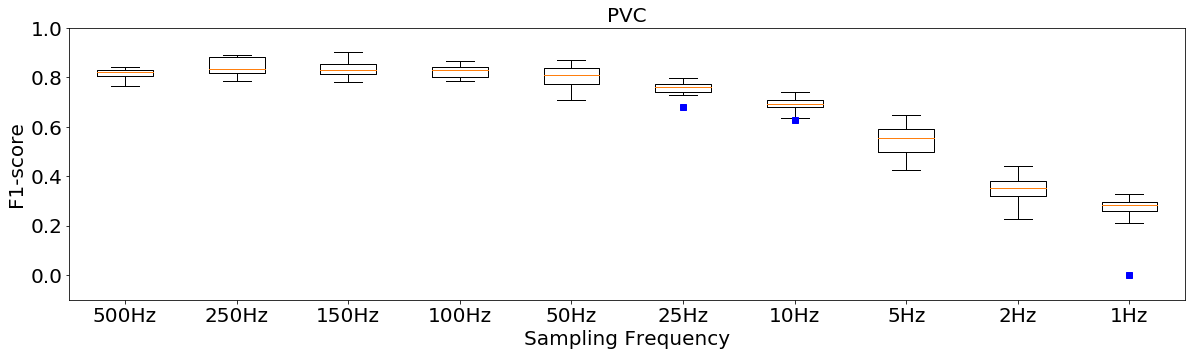

[0.82009248 0.8341785  0.83125424 0.82904734 0.80997268 0.75956323
 0.69265367 0.55651852 0.35074406 0.28216253]
50
50
[1.00000000e+00 3.11339400e-02 4.75027929e-02 4.93392365e-02
 5.18845660e-01 1.21436844e-04 7.81012225e-06 8.65872109e-07
 6.59254792e-10 7.83397999e-09]


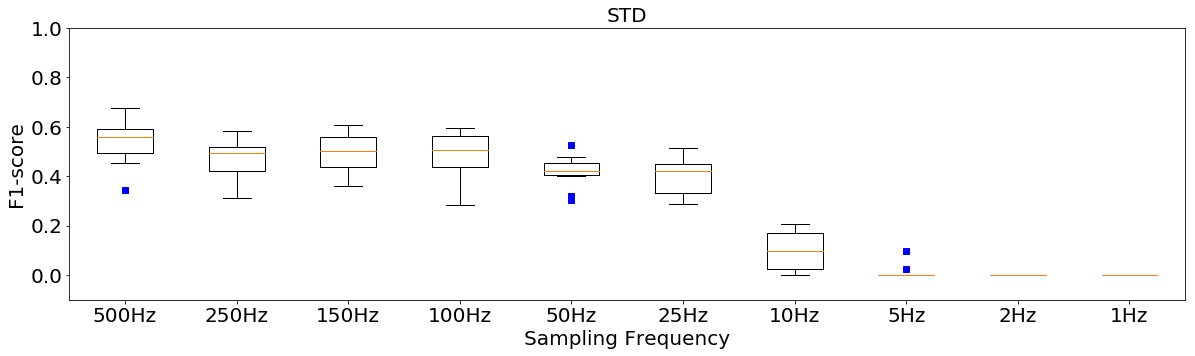

[0.56025437 0.49336772 0.50305707 0.50740216 0.42220525 0.42118227
 0.09734423 0.         0.         0.        ]
100
100
[1.00000000e+00 1.01487882e-01 6.97446959e-02 2.62937324e-01
 5.50644424e-03 3.44532465e-03 1.07375847e-06 3.94957889e-08
 2.21037776e-08 2.21037776e-08]


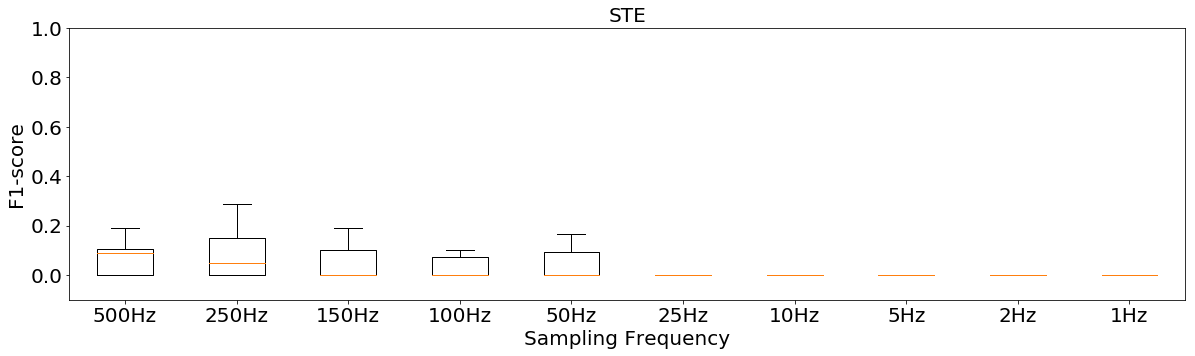

[0.08893281 0.05       0.         0.         0.         0.
 0.         0.         0.         0.        ]
50*
1*
[1.         0.79789663 0.50384885 0.05891519 0.39171807 0.01070928
 0.01070928 0.01070928 0.01070928 0.01070928]


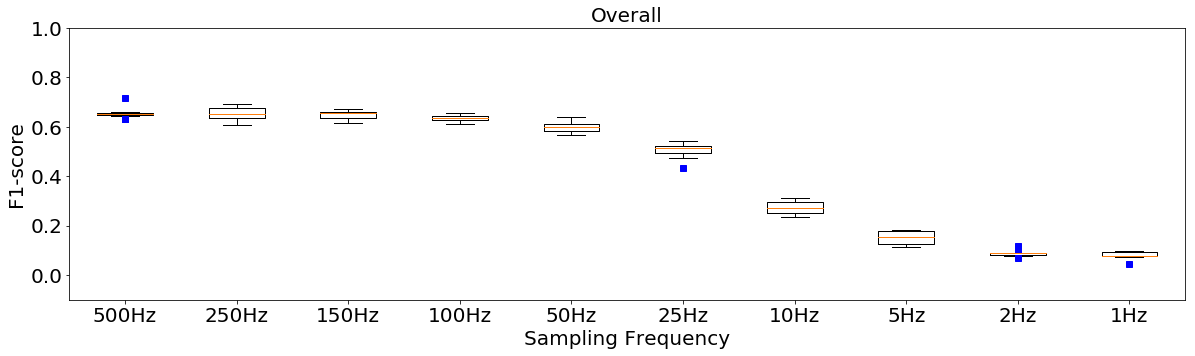

[0.65124172 0.65078945 0.65676669 0.63633183 0.60048536 0.51633569
 0.27298122 0.15452687 0.08826263 0.07916732]
125
100
[1.00000000e+00 8.75987191e-01 4.77552832e-01 1.79050561e-02
 2.19620118e-04 9.91750831e-07 5.33340015e-10 1.98076407e-11
 3.09873071e-13 4.20140317e-14]
Lead :aVR


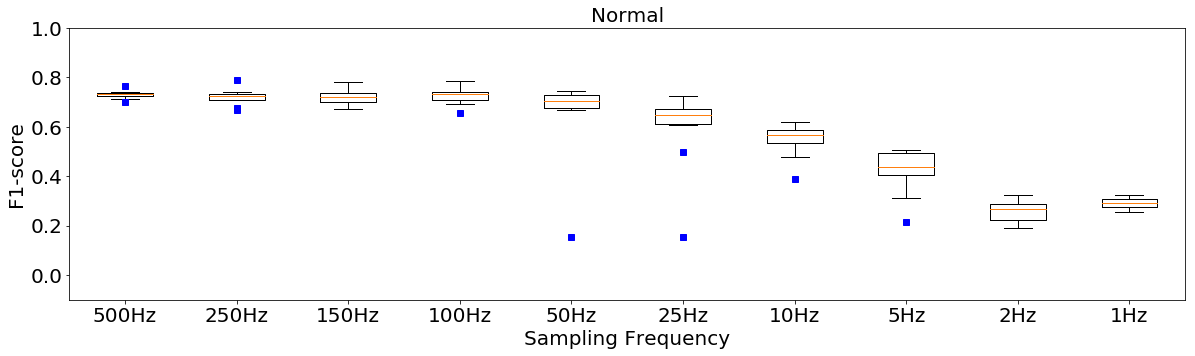

[0.73207737 0.7250629  0.72154322 0.73273866 0.70562675 0.64874687
 0.56571429 0.43684937 0.26657556 0.29280711]
50
25
[1.00000000e+00 4.25876964e-01 3.76505196e-01 7.90394976e-01
 1.93839233e-01 2.62731991e-02 1.53802552e-05 3.43465391e-06
 1.25305915e-10 4.12294345e-12]


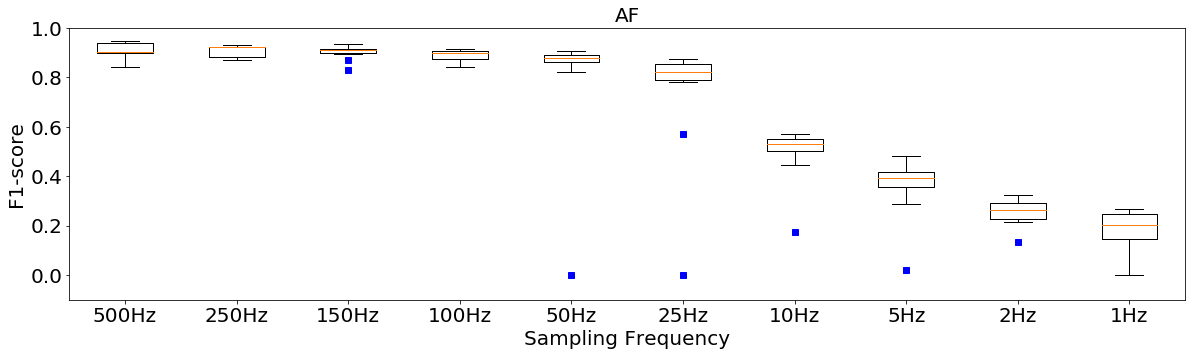

[0.9030587  0.92227979 0.91145593 0.89719556 0.87802785 0.82364266
 0.52918354 0.39211159 0.26194534 0.20179306]
25
25
[1.00000000e+00 9.35405310e-01 5.32146622e-01 3.73652500e-02
 2.38552065e-01 6.11230162e-02 8.96969877e-07 4.25722317e-07
 2.28114087e-10 9.38263656e-09]


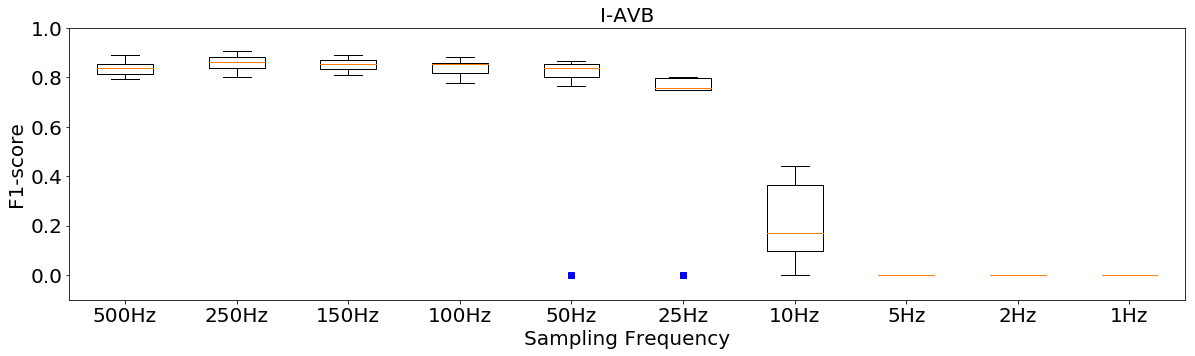

[0.83888889 0.86345316 0.85610164 0.85304401 0.83654559 0.75746335
 0.17097264 0.         0.         0.        ]
25
25
[1.00000000e+00 1.26810982e-01 2.70529657e-01 8.53523671e-01
 2.83630683e-01 6.69436096e-02 6.76267979e-07 2.95296539e-14
 2.95296539e-14 2.95296539e-14]


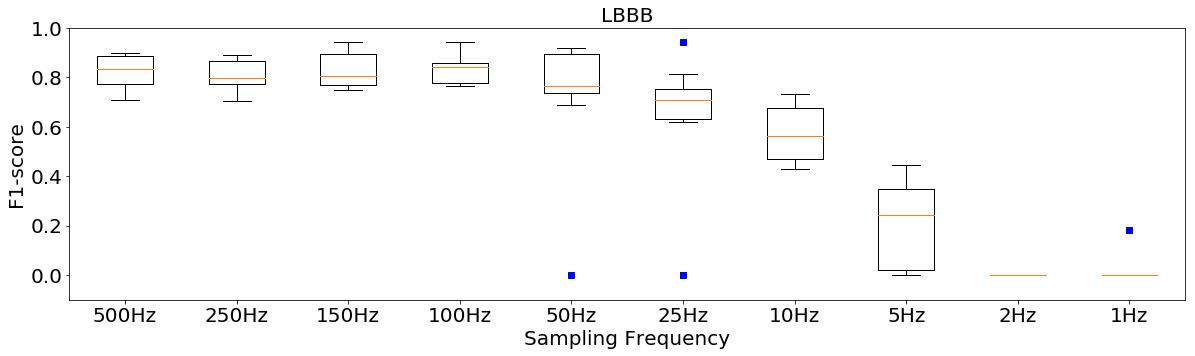

[0.83600713 0.7993448  0.80625    0.84359726 0.76388889 0.71008403
 0.56109482 0.24251806 0.         0.        ]
25
25
[1.00000000e+00 3.20770878e-01 6.23170700e-01 3.36747228e-01
 2.93795593e-01 5.93230320e-02 2.86288740e-05 2.78318250e-07
 2.61926467e-11 4.81506555e-11]


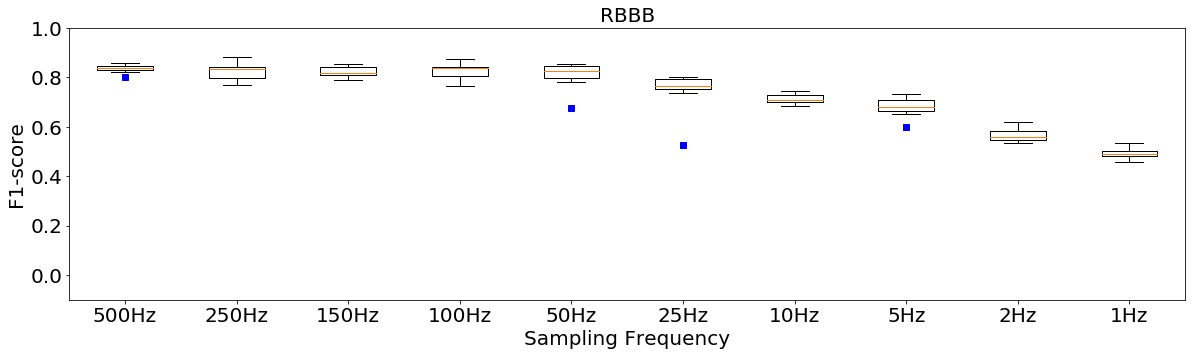

[0.83630708 0.83580858 0.81794305 0.83944872 0.82446785 0.76713389
 0.70666919 0.67928106 0.55859898 0.48936955]
50
25
[1.00000000e+00 1.89978503e-01 2.47119734e-02 8.22978662e-02
 1.29251011e-01 1.07833419e-02 2.29201329e-08 1.63188179e-08
 6.18239365e-12 3.99656570e-13]


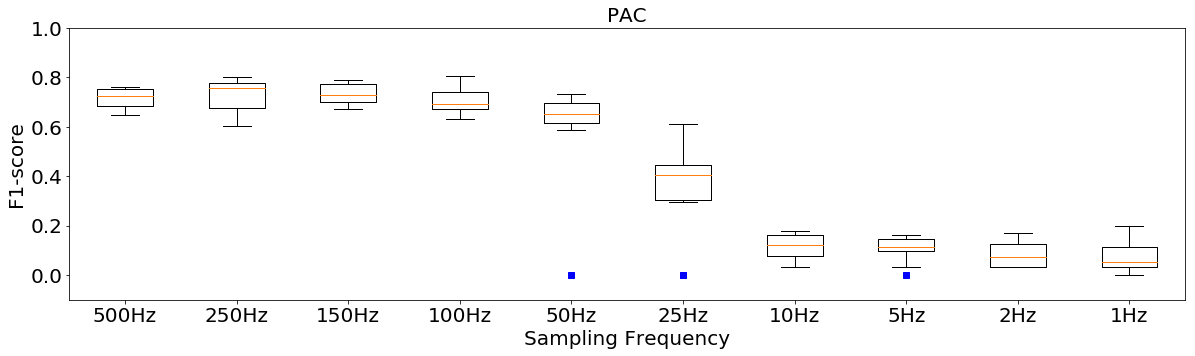

[0.72477064 0.75718065 0.72795031 0.69176111 0.6530303  0.40580138
 0.12352941 0.11334746 0.07460317 0.05325815]
50
50
[1.00000000e+00 7.02818952e-01 4.07922501e-01 5.98603588e-01
 9.54991961e-02 6.08847984e-04 4.22818018e-10 1.07910473e-10
 1.08542873e-11 4.41254314e-10]


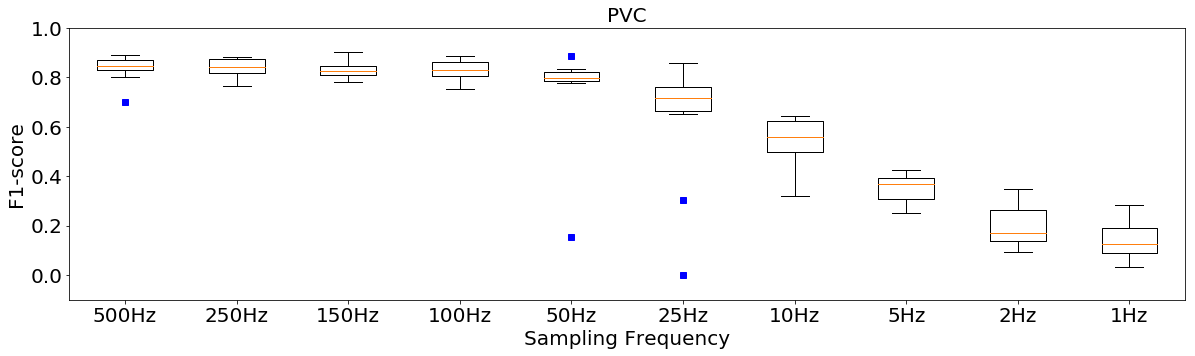

[0.84545214 0.84064392 0.82526146 0.83182589 0.79837398 0.7184539
 0.55844156 0.36985237 0.16948933 0.12507817]
50
25
[1.00000000e+00 8.49456165e-01 7.43864358e-01 6.15912031e-01
 2.42972383e-01 1.21330086e-02 4.26637765e-08 2.35585349e-10
 3.16957847e-09 1.73347259e-10]


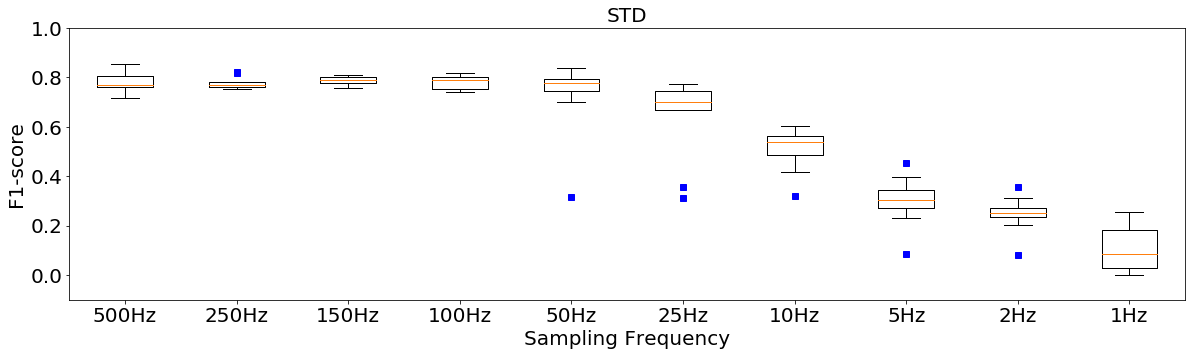

[0.76774243 0.76807189 0.78889471 0.79101424 0.77890964 0.70071131
 0.53765519 0.30543437 0.25234196 0.08603145]
50
25
[1.00000000e+00 6.45561515e-01 5.21072605e-01 9.45606256e-01
 3.58765001e-01 3.02842586e-02 3.71716828e-06 8.98321800e-08
 6.59998099e-10 4.22214870e-09]


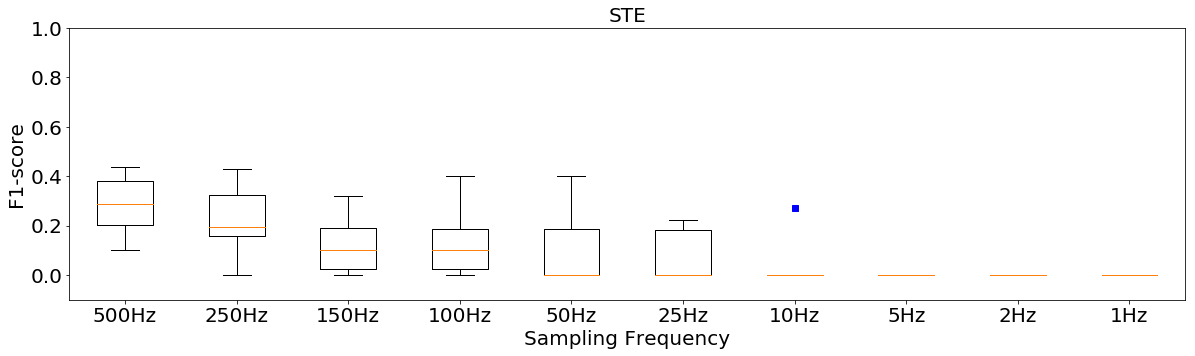

[0.28717949 0.1952381  0.10263158 0.1        0.         0.
 0.         0.         0.         0.        ]
250*
50*
[1.00000000e+00 1.83350414e-01 2.10071314e-02 9.27674544e-03
 4.51422516e-02 5.25471523e-04 1.75174174e-03 5.02727542e-05
 5.02727542e-05 5.02727542e-05]


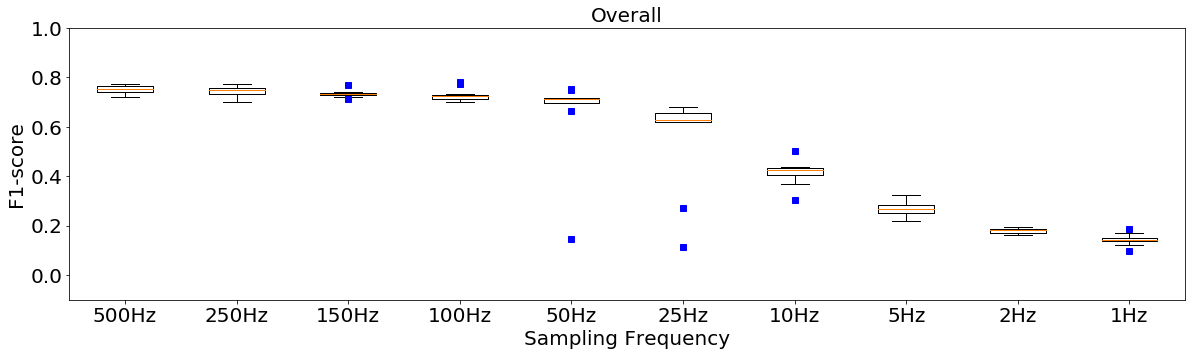

[0.75441153 0.74935977 0.73414991 0.72503493 0.7128138  0.6274327
 0.42392224 0.26703372 0.18057719 0.14347891]
50
25
[1.00000000e+00 1.72426378e-01 2.78407397e-02 1.04807911e-02
 1.52836192e-01 1.04600405e-02 1.55694164e-08 1.81601044e-12
 6.67720751e-14 5.17124283e-13]
Lead :aVL


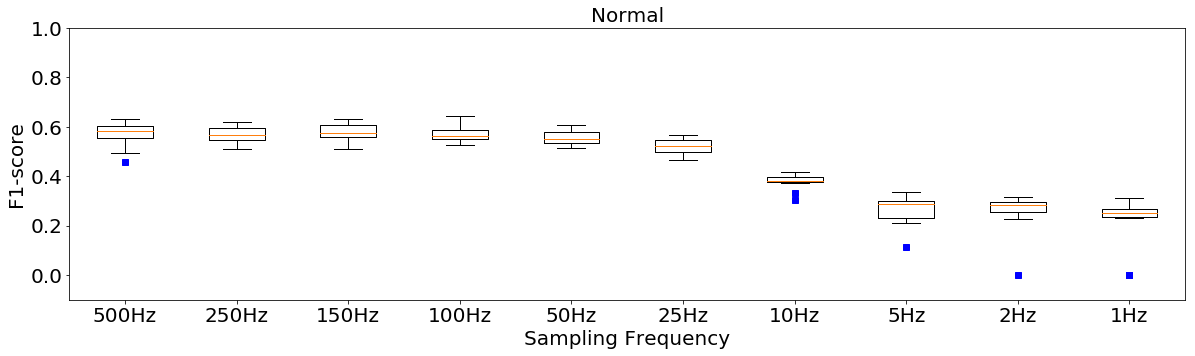

[0.58437325 0.56806723 0.57518797 0.56205128 0.55272727 0.52440833
 0.38184943 0.28885306 0.28286875 0.2522017 ]
50
25
[1.00000000e+00 9.70468949e-01 4.55140361e-01 9.58524030e-01
 5.84365322e-01 1.71926765e-02 5.64230628e-06 5.71891750e-06
 1.63486352e-05 5.55913040e-06]


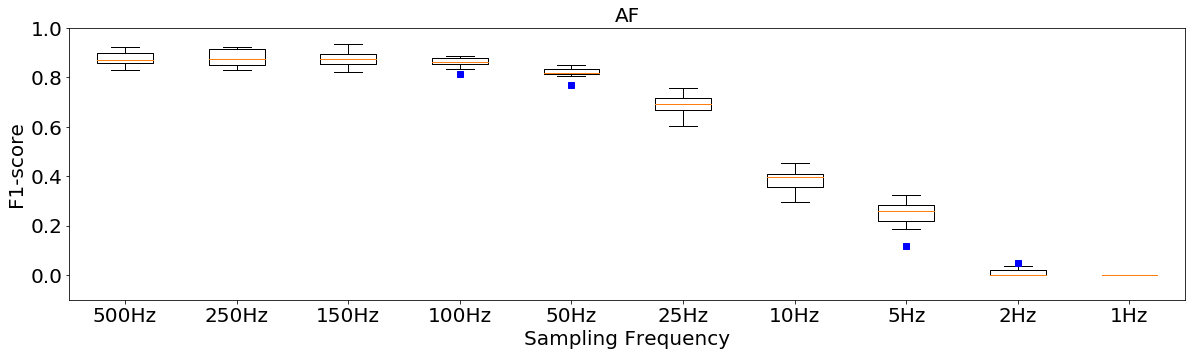

[0.87055981 0.8760768  0.87523316 0.86325519 0.81971521 0.69070172
 0.39684721 0.26019766 0.         0.        ]
100
100
[1.00000000e+00 8.77209942e-01 8.31321294e-01 1.08968485e-01
 1.46506245e-04 4.66269432e-07 9.57114321e-10 3.97399430e-11
 6.64426641e-13 1.49901017e-14]


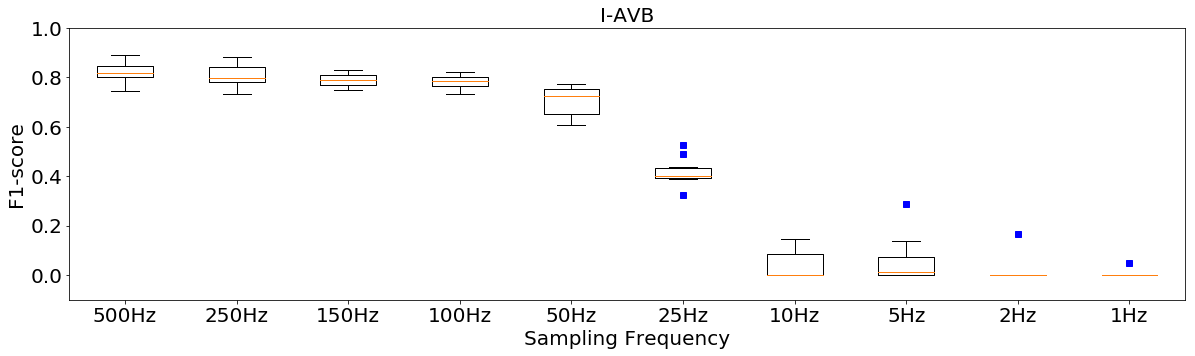

[0.81959496 0.79864865 0.78825904 0.78446553 0.7229882  0.4
 0.         0.01388889 0.         0.        ]
250
250
[1.00000000e+00 1.06755928e-01 7.39490585e-03 8.71082804e-03
 2.50754665e-04 3.56540325e-08 1.35960675e-11 4.79906866e-09
 3.67511567e-12 2.11608057e-12]


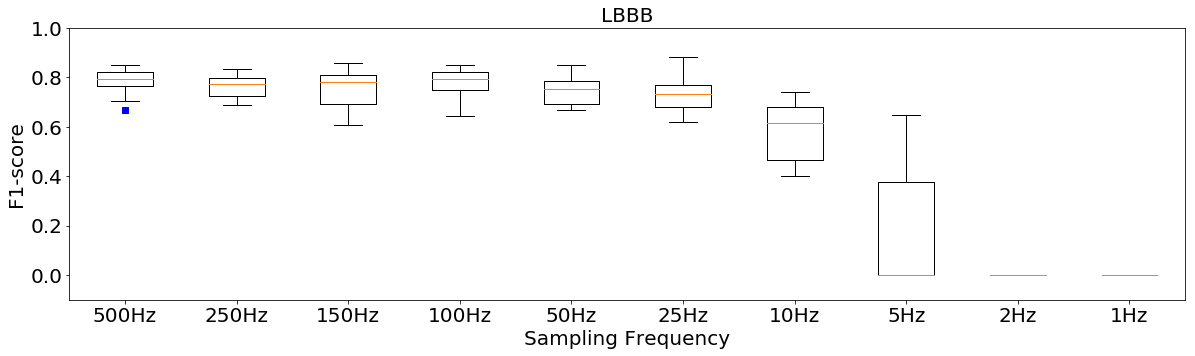

[0.79513889 0.77350427 0.78103617 0.79473684 0.75376344 0.73205742
 0.61458333 0.         0.         0.        ]
50
25
[1.00000000e+00 2.36031832e-01 1.86134487e-01 5.22446942e-01
 1.03174242e-01 4.84821294e-02 2.79936417e-04 7.11562769e-05
 1.23701385e-11 1.23701385e-11]


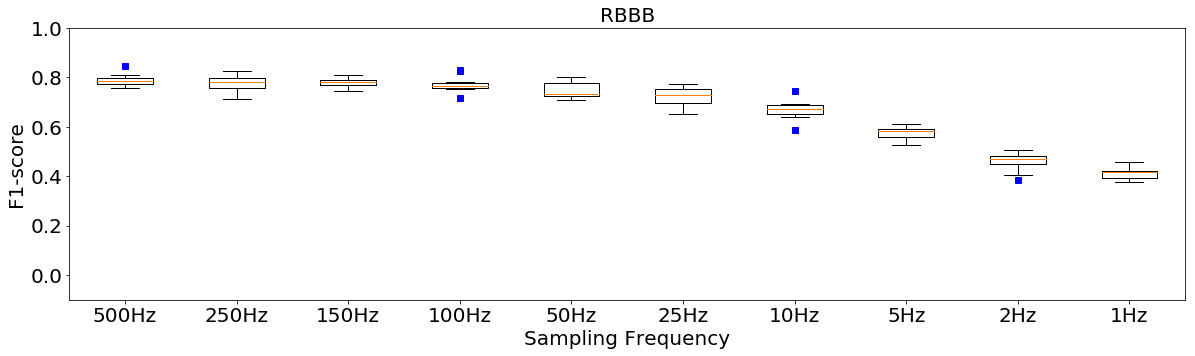

[0.78451805 0.78002846 0.78079647 0.76546598 0.73398632 0.72739815
 0.67227891 0.58309268 0.4689218  0.41543862]
100
100
[1.00000000e+00 2.49534051e-01 1.82062172e-01 1.09538640e-01
 3.62813184e-03 1.12481925e-04 1.47750322e-06 6.61759178e-11
 5.24997224e-10 2.33275765e-11]


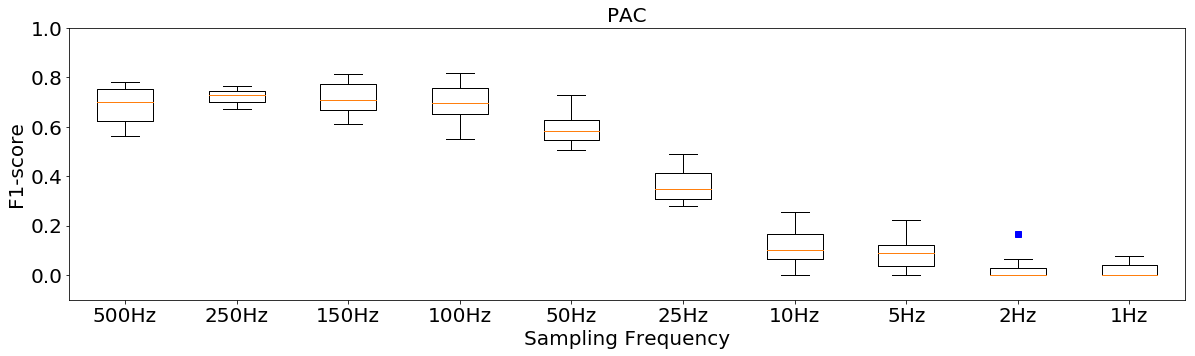

[0.69935932 0.72889276 0.70762324 0.69448861 0.5830303  0.34724613
 0.10002779 0.08955224 0.         0.        ]
100
100
[1.00000000e+00 1.17448045e-01 1.22486870e-01 5.30100715e-01
 4.67788711e-03 8.17433214e-07 2.41762319e-07 3.65097220e-07
 3.27106637e-08 8.48283523e-09]


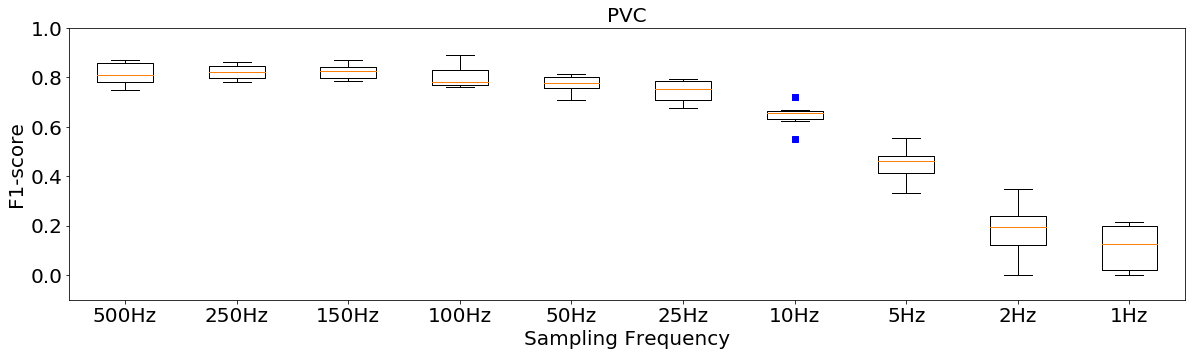

[0.81167648 0.82352941 0.82596852 0.7804878  0.77890848 0.75223899
 0.65443122 0.46214689 0.19393939 0.125     ]
100
50
[1.00000000e+00 4.42149359e-01 4.98448302e-01 2.69252074e-01
 2.09614772e-02 2.88790237e-05 7.10560615e-07 3.78504198e-08
 5.33256781e-09 2.36763574e-09]


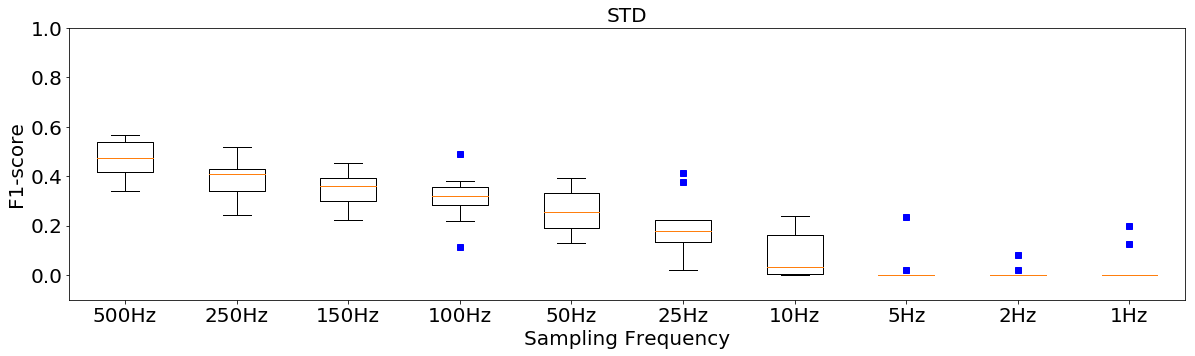

[0.47404656 0.41079973 0.36043046 0.32000903 0.25439137 0.18009174
 0.03472222 0.         0.         0.        ]
500*
250*
[1.00000000e+00 1.66836205e-02 1.32829208e-03 1.04759537e-03
 4.71040325e-05 1.09350215e-05 9.74598258e-06 9.03145861e-08
 1.17892963e-08 1.60856114e-08]


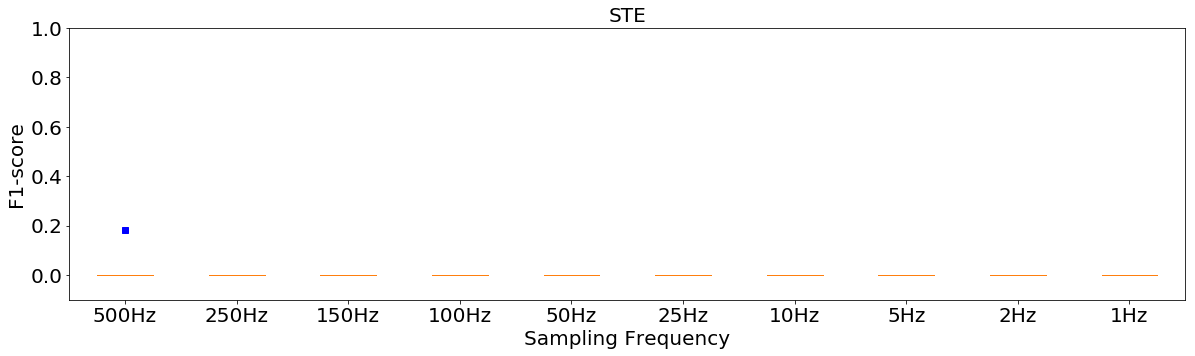

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1*
1*
[1.        0.3434364 0.3434364 0.3434364 0.3434364 0.3434364 0.3434364
 0.3434364 0.3434364 0.3434364]


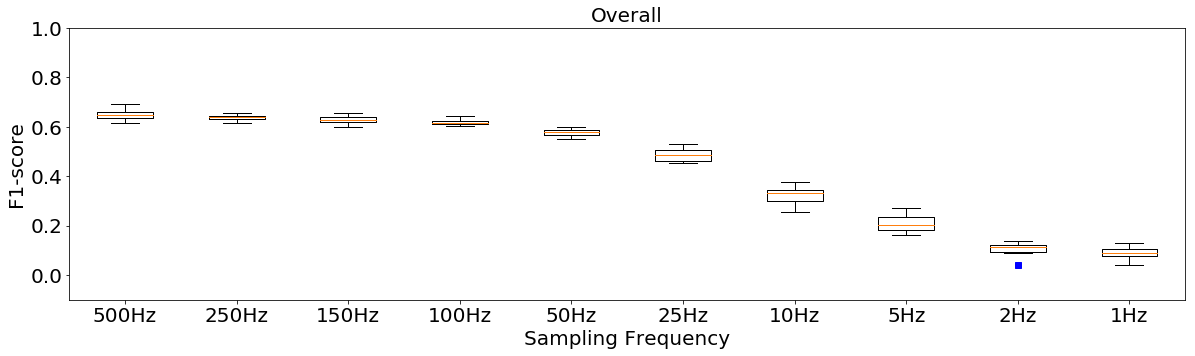

[0.64656481 0.63917798 0.62637496 0.61744889 0.57944494 0.48767354
 0.33157145 0.20163162 0.11530953 0.08981945]
250
250
[1.00000000e+00 1.61388105e-01 8.57116727e-03 1.62759713e-04
 1.13410664e-05 6.41911131e-08 1.37643478e-09 3.15223511e-10
 5.97428885e-12 4.35035537e-12]
Lead :aVF


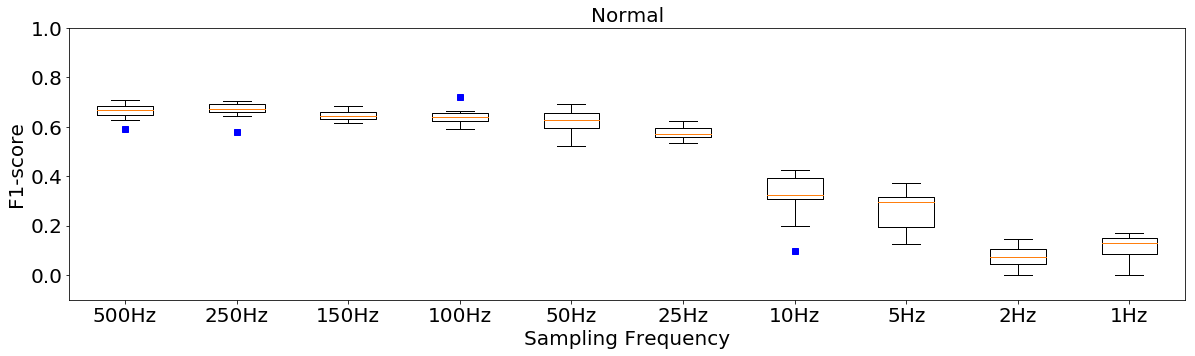

[0.66666667 0.67300629 0.64365068 0.6378441  0.62929293 0.56929638
 0.32394092 0.29699772 0.07333333 0.12875587]
125
50
[1.00000000e+00 4.51964744e-01 6.04007581e-02 4.28325430e-02
 3.15217594e-02 5.23346923e-05 1.35312039e-06 1.13514356e-07
 2.03752634e-13 2.63752191e-09]


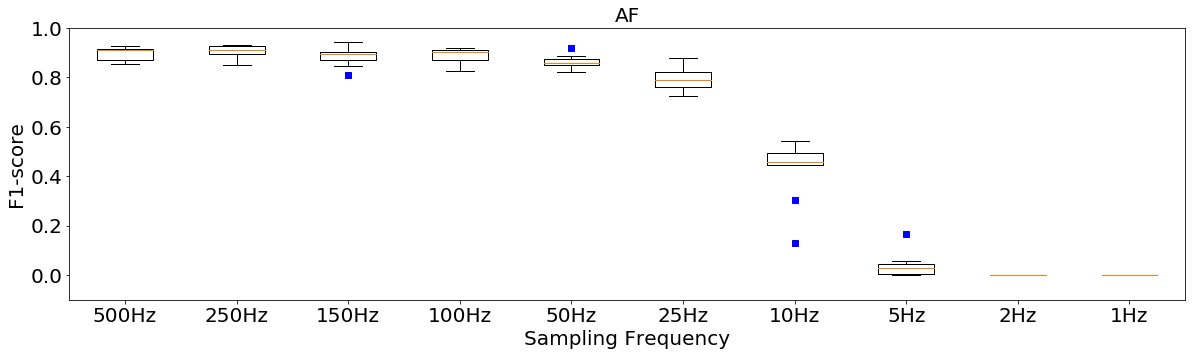

[0.91052384 0.91244019 0.89476163 0.90154383 0.8578908  0.78851923
 0.45809005 0.02867185 0.         0.        ]
100
100
[1.00000000e+00 2.30844928e-01 1.64025464e-01 1.30070756e-01
 6.75571138e-03 5.14345492e-05 3.71887900e-07 1.00335564e-12
 4.63357990e-15 4.63357990e-15]


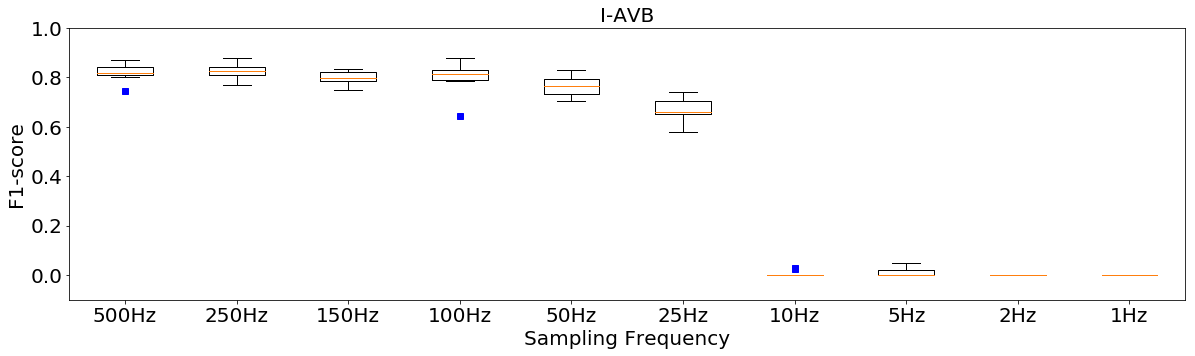

[0.81848135 0.82666957 0.7984375  0.81356322 0.76641091 0.65897563
 0.         0.         0.         0.        ]
100
100
[1.00000000e+00 8.30258536e-01 9.25933058e-02 3.04086766e-01
 1.49827914e-03 1.00941744e-04 1.12352214e-13 1.37216456e-12
 9.44052734e-14 9.44052734e-14]


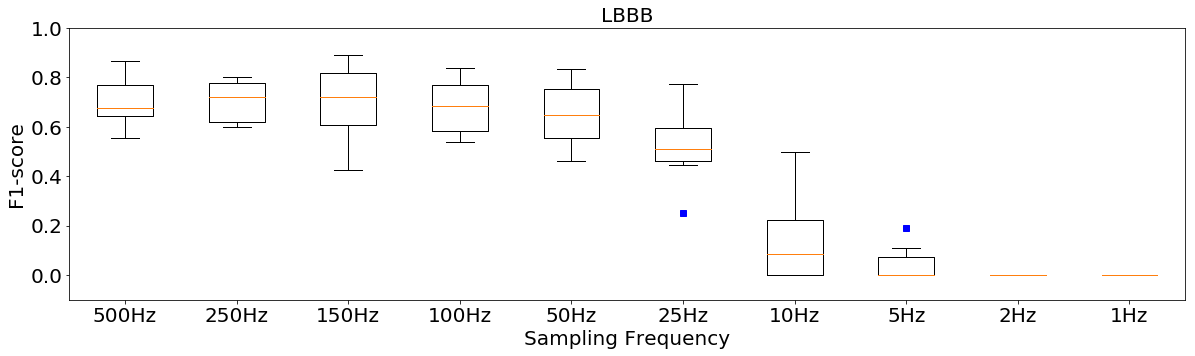

[0.67619048 0.71969697 0.72150538 0.68627451 0.6484127  0.50925926
 0.08695652 0.         0.         0.        ]
50
50
[1.00000000e+00 8.09698542e-01 8.87766838e-01 6.10537037e-01
 1.12968322e-01 4.65517925e-04 3.26900950e-06 3.02866829e-08
 6.77647283e-09 6.77647283e-09]


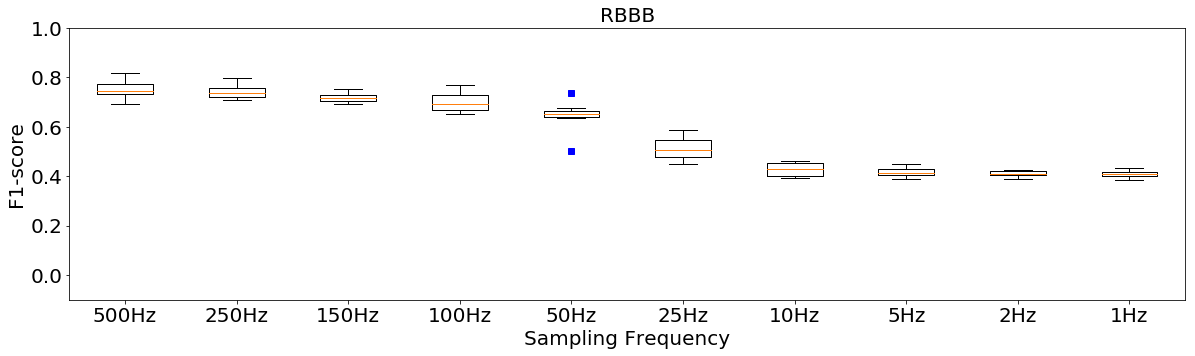

[0.74671233 0.73775903 0.71781234 0.69391835 0.64993037 0.50652254
 0.43129663 0.4139814  0.40933643 0.409525  ]
250
100
[1.00000000e+00 2.85740240e-01 3.21301049e-02 1.76034450e-02
 5.10981831e-04 9.89044064e-07 3.78279269e-10 3.66482145e-09
 1.07761763e-09 1.18679339e-09]


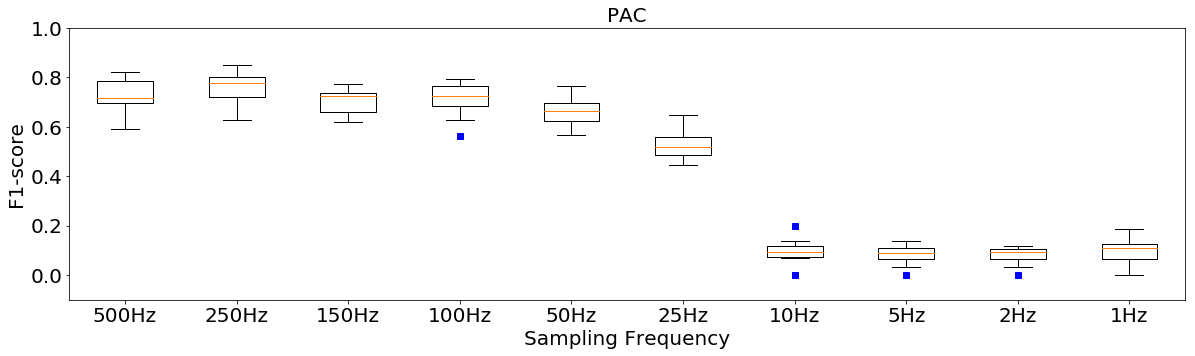

[0.71541835 0.77935223 0.72653959 0.72474747 0.66370968 0.51655983
 0.09160839 0.09047619 0.09377289 0.10881847]
100
50
[1.00000000e+00 7.61320920e-03 9.17935035e-02 3.59998722e-01
 4.98747634e-02 5.00822156e-04 5.70343142e-08 1.21557585e-08
 1.75309686e-09 2.76998269e-09]


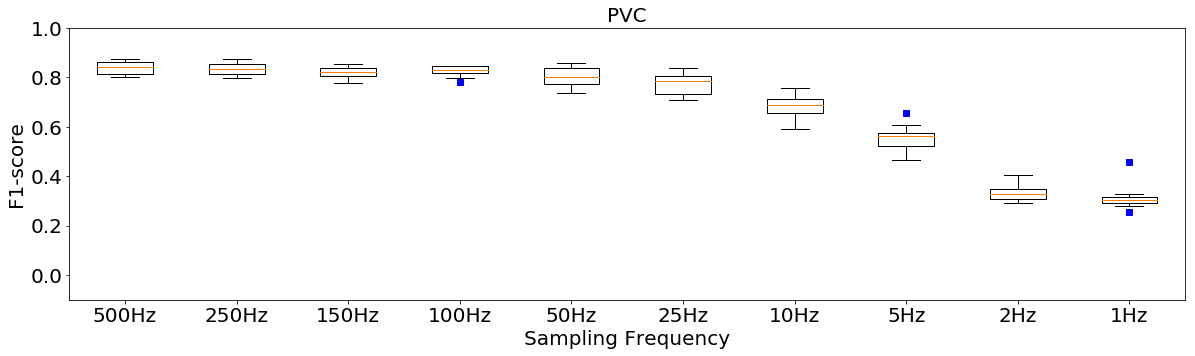

[0.8417616  0.8341785  0.82154673 0.83202656 0.8034775  0.78718905
 0.6892127  0.56301829 0.32882883 0.302     ]
50
50
[1.00000000e+00 6.76085029e-01 5.55405545e-03 1.94261302e-01
 5.44007466e-02 1.03048824e-03 4.93393597e-06 4.84242821e-08
 4.17509176e-11 3.11664313e-10]


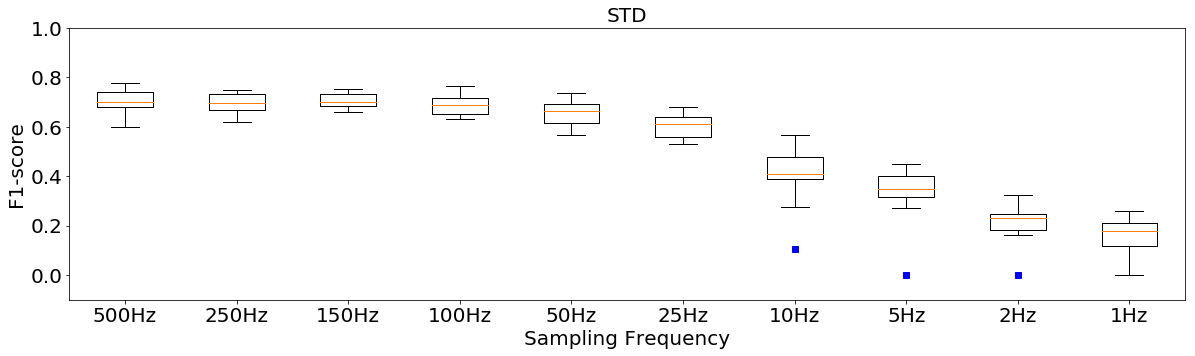

[0.70031847 0.69824311 0.70142774 0.68685548 0.66257669 0.61082588
 0.40930233 0.34710152 0.22982659 0.17729306]
100
100
[1.00000000e+00 7.61724271e-01 4.61584215e-01 4.10626196e-01
 1.48520916e-03 2.04254830e-05 2.22199353e-05 1.18796389e-05
 2.46755239e-08 9.54324770e-08]


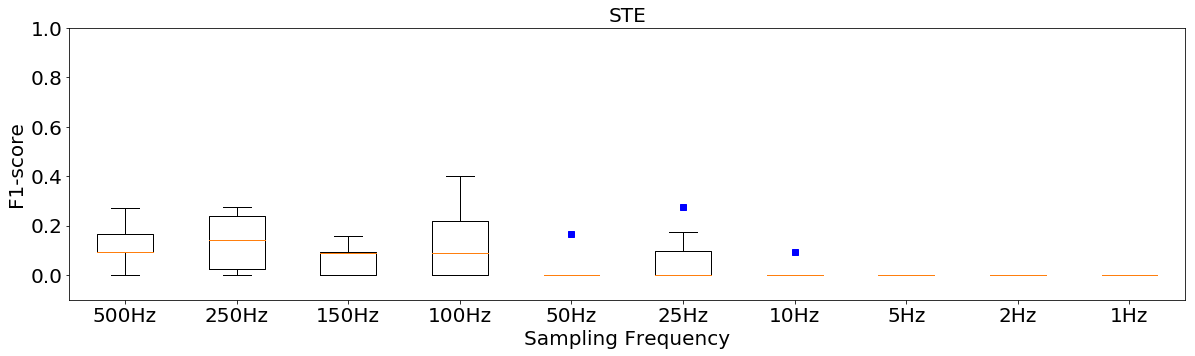

[0.0952381  0.14354067 0.09090909 0.08761905 0.         0.
 0.         0.         0.         0.        ]
25*
10*
[1.         0.59566004 0.20975006 0.80016593 0.02993199 0.34053744
 0.01096134 0.00240277 0.00240277 0.00240277]


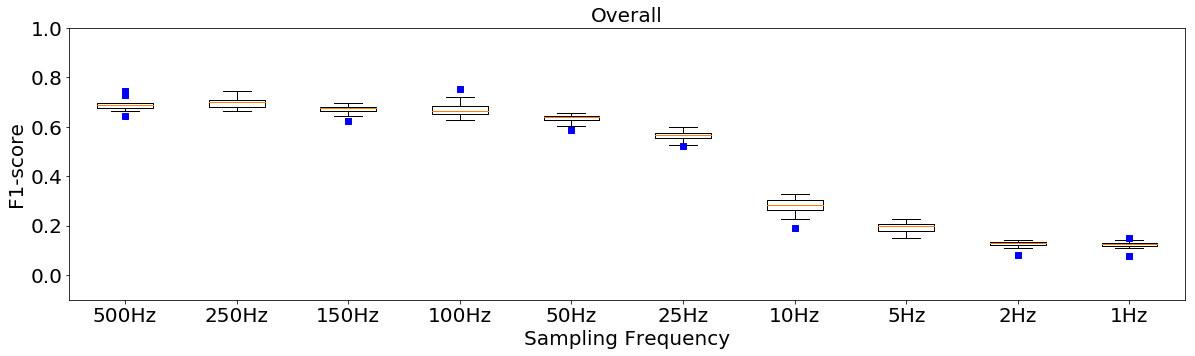

[0.6886224  0.69861625 0.67641803 0.66452278 0.63920055 0.5664428
 0.28237248 0.19911902 0.12796646 0.1244746 ]
100
100
[1.00000000e+00 4.68243115e-01 6.13209547e-02 1.45928199e-01
 9.53525574e-04 1.93106224e-06 2.51165834e-10 3.70114129e-12
 8.66623159e-13 1.57104979e-12]
Lead :V1


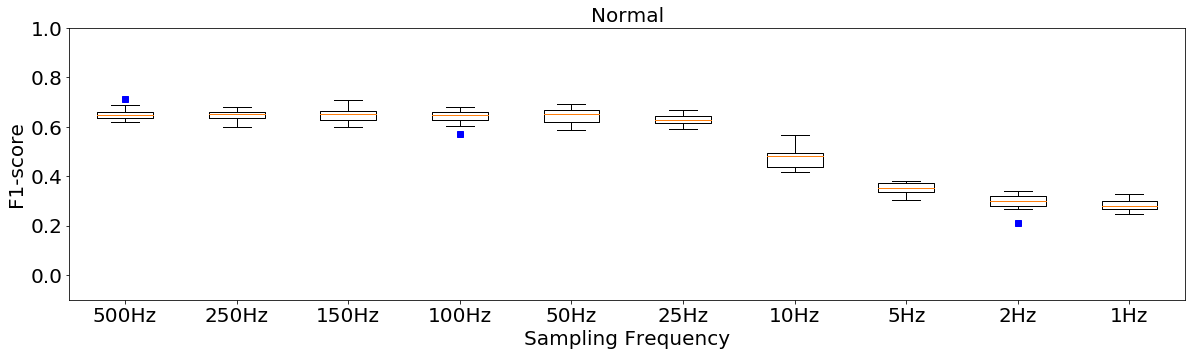

[0.64854607 0.65068807 0.6504717  0.64879698 0.65012392 0.62691649
 0.48106242 0.35169082 0.29957839 0.28057779]
25
25
[1.00000000e+00 6.78726130e-01 7.87812019e-01 2.13048806e-01
 5.30984790e-01 6.67233137e-02 6.59588594e-06 1.21978283e-08
 2.65764031e-09 2.58858133e-11]


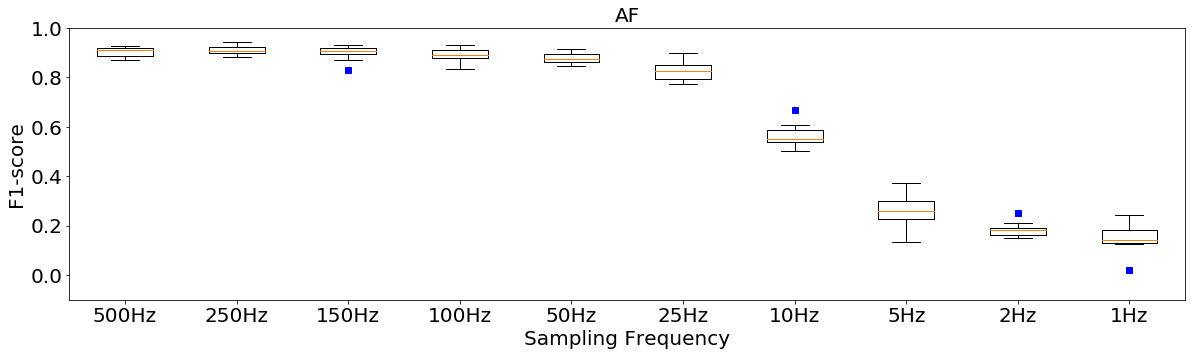

[0.91143671 0.90658824 0.90532963 0.89246068 0.87526575 0.82491987
 0.55102895 0.25978261 0.18181818 0.14028026]
100
50
[1.00000000e+00 2.80286431e-01 7.58458085e-01 6.77601413e-02
 1.52287794e-02 1.62181079e-05 1.15977301e-09 1.03418281e-09
 2.43160626e-12 6.86946161e-12]


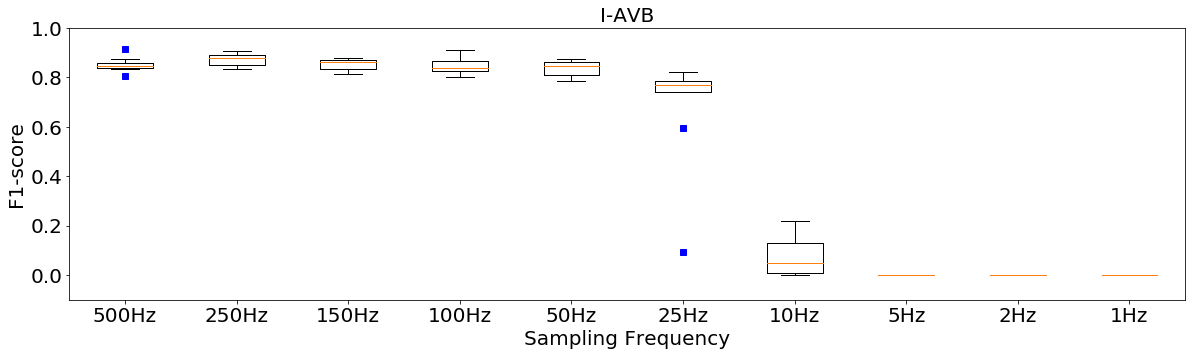

[0.84478624 0.88057041 0.86128431 0.83942642 0.84672831 0.76826318
 0.04705154 0.         0.         0.        ]
100
25
[1.00000000e+00 6.45377349e-03 8.82277357e-01 7.50240671e-01
 4.35998004e-02 4.29579750e-02 4.76054548e-10 7.55584260e-15
 7.55584260e-15 7.55584260e-15]


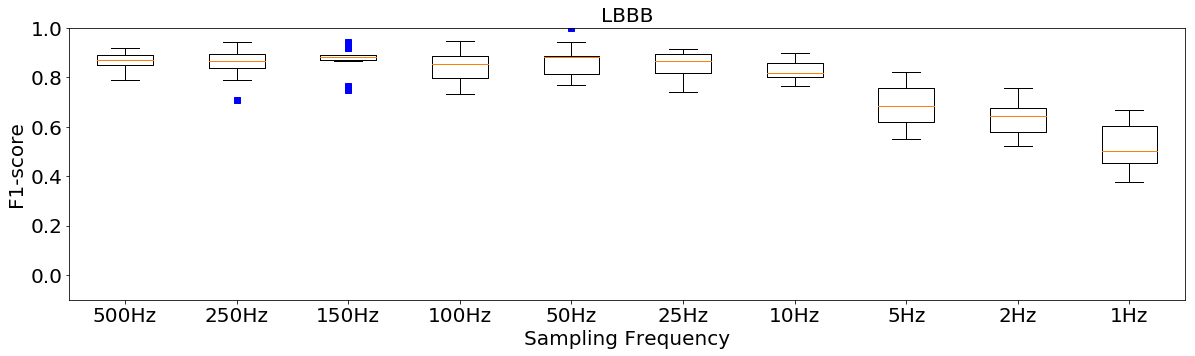

[0.8697479  0.86832987 0.88235294 0.85281385 0.88235294 0.86832987
 0.81650641 0.68333333 0.64316013 0.5002584 ]
25
25
[1.00000000e+00 5.82421168e-01 9.90665573e-01 2.79525435e-01
 9.96341248e-01 4.35020397e-01 9.38722546e-03 8.28454125e-05
 4.71350878e-07 2.14324112e-06]


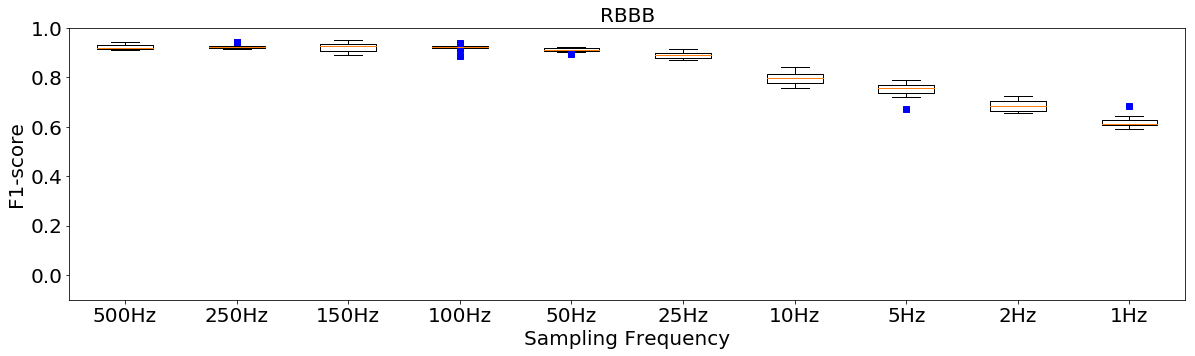

[0.91964507 0.92379032 0.92837501 0.92232928 0.9119877  0.88995253
 0.79675039 0.75740741 0.68516633 0.61106403]
100
50
[1.00000000e+00 3.04806990e-01 9.58608264e-01 7.17517620e-01
 3.05165466e-02 1.20520161e-04 6.75812334e-08 1.69373102e-08
 4.70657083e-11 4.88948245e-12]


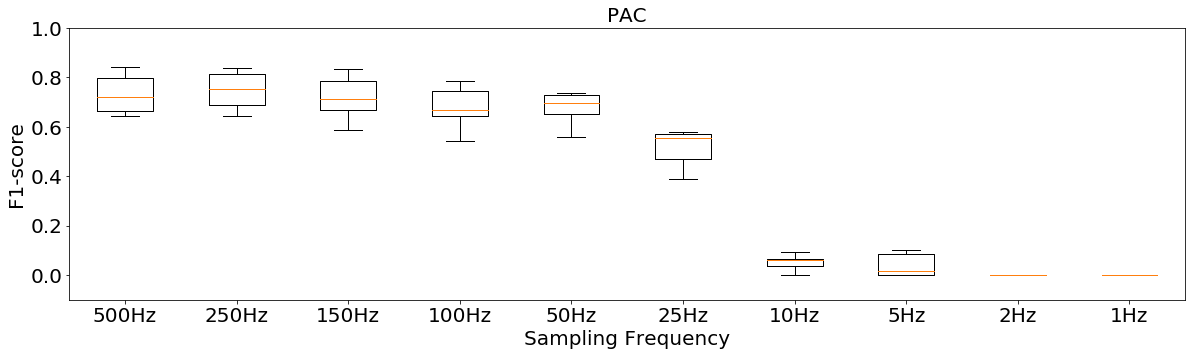

[0.71960168 0.75452517 0.71123755 0.66666667 0.69459259 0.55632799
 0.0625     0.01612903 0.         0.        ]
125
50
[1.00000000e+00 1.08862773e-01 4.56314784e-01 3.01136505e-02
 1.37026738e-02 4.45699159e-07 9.75049198e-10 5.26007732e-09
 2.16873057e-10 2.16873057e-10]


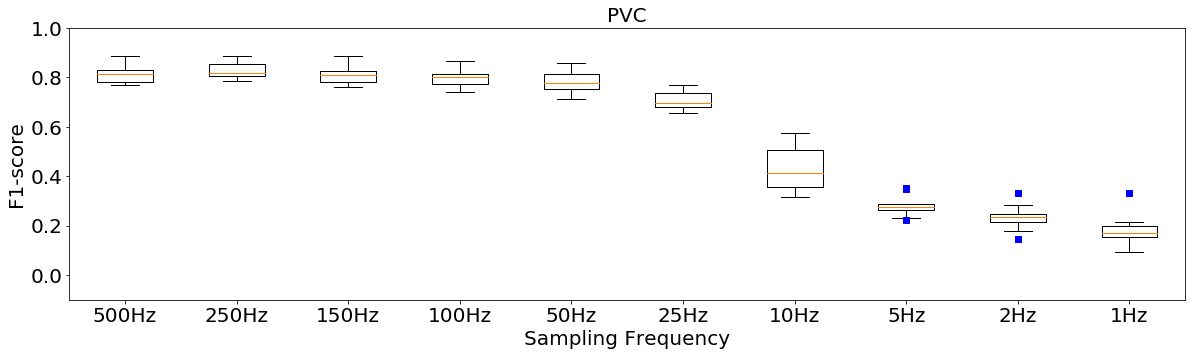

[0.81479794 0.81661573 0.81179643 0.79991307 0.77785897 0.69489139
 0.41432942 0.27361854 0.23578104 0.17235294]
100
50
[1.00000000e+00 7.38768375e-02 4.39763038e-01 1.57986743e-01
 1.10458076e-02 5.78568452e-07 1.50280850e-08 7.83646287e-11
 2.89426188e-10 7.22771632e-11]


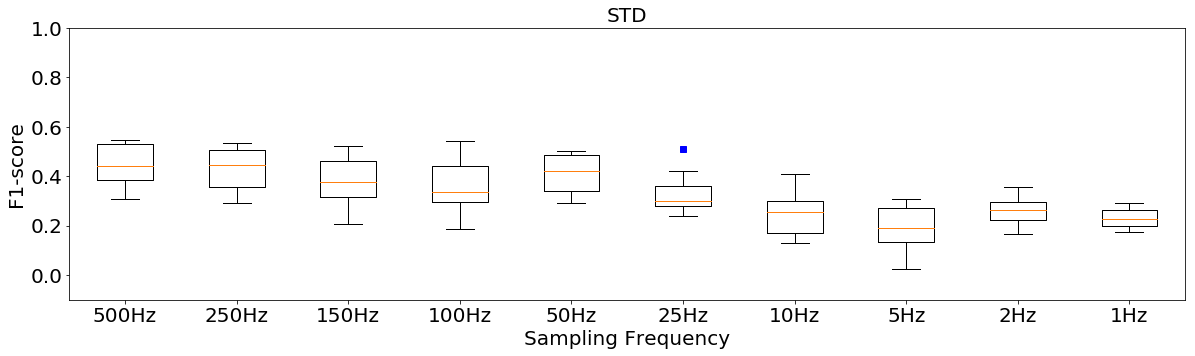

[0.43950094 0.44418349 0.37594974 0.33783784 0.42179487 0.29945825
 0.25514069 0.19029657 0.26333122 0.22885381]
50*
50*
[1.00000000e+00 6.59206903e-01 3.22679514e-02 2.95555405e-02
 4.47231798e-01 1.21308559e-03 3.11494144e-04 2.88195760e-04
 7.59575350e-04 1.25545871e-04]


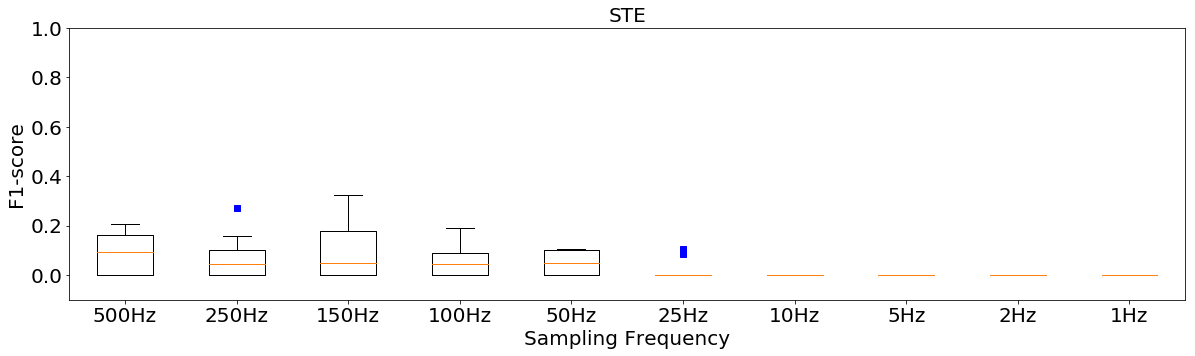

[0.0952381  0.04545455 0.04761905 0.04545455 0.04761905 0.
 0.         0.         0.         0.        ]
50*
25*
[1.         0.60929374 0.71776112 0.50860073 0.10403203 0.01630832
 0.00837019 0.00837019 0.00837019 0.00837019]


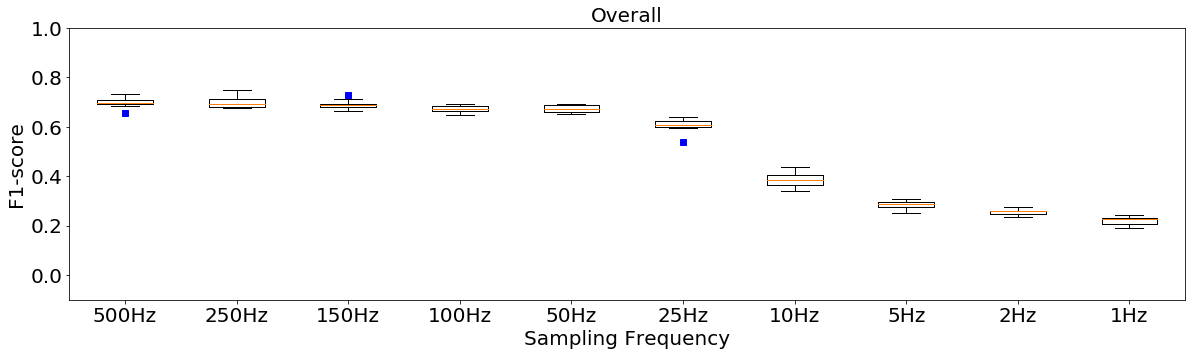

[0.69713632 0.69292397 0.68737542 0.67235499 0.67192324 0.60766091
 0.38470923 0.2894985  0.25882121 0.22841609]
125
50
[1.00000000e+00 7.01039542e-01 2.25377615e-01 1.13544437e-02
 1.41889560e-02 4.16791286e-06 1.01647588e-10 5.97802139e-12
 6.07490573e-13 1.37810184e-12]
Lead :V2


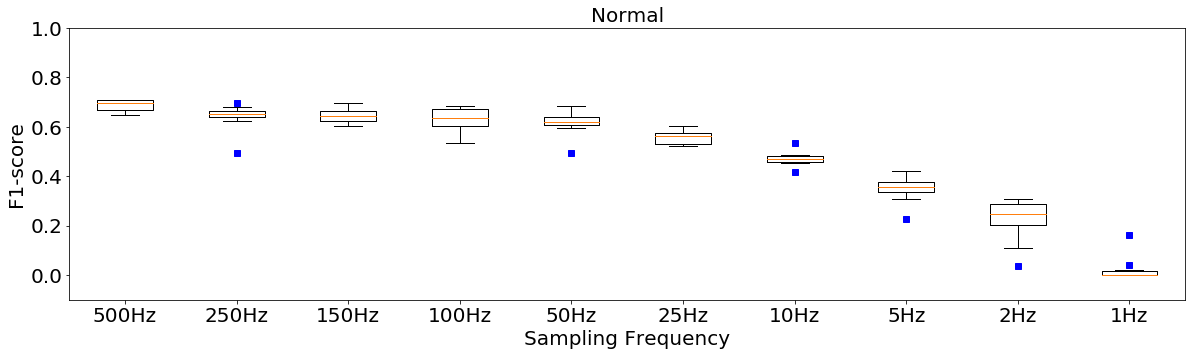

[0.69473684 0.65082922 0.64517467 0.63415929 0.61975309 0.56369275
 0.4712932  0.35655509 0.2481366  0.        ]
500
250
[1.00000000e+00 4.39603977e-02 1.61963143e-03 3.91364295e-03
 2.30378016e-03 1.52557330e-09 2.89882403e-08 9.77004104e-10
 2.90631883e-08 1.42117437e-11]


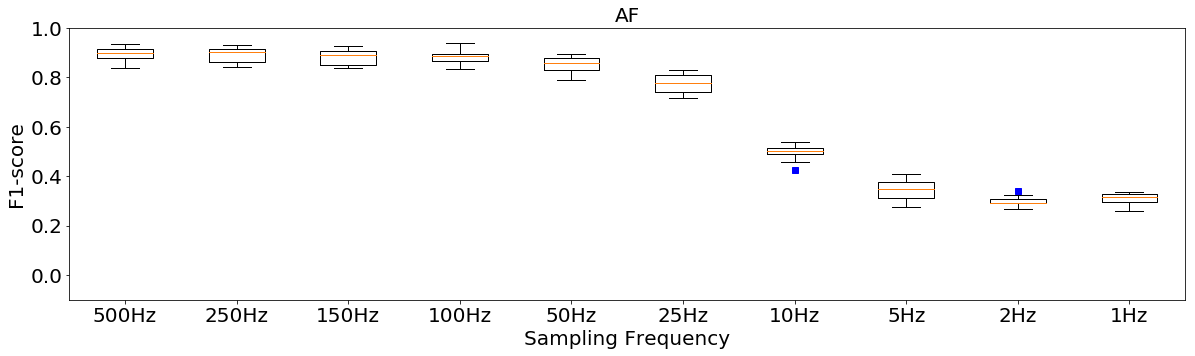

[0.89811321 0.9017771  0.89047949 0.8865702  0.85919344 0.77552207
 0.50283019 0.35013919 0.29181873 0.31593468]
100
100
[1.00000000e+00 5.48569170e-01 2.77218186e-02 1.76797902e-01
 1.65822810e-03 6.69952930e-07 2.40562554e-11 1.61783917e-10
 1.53015562e-12 3.31963182e-13]


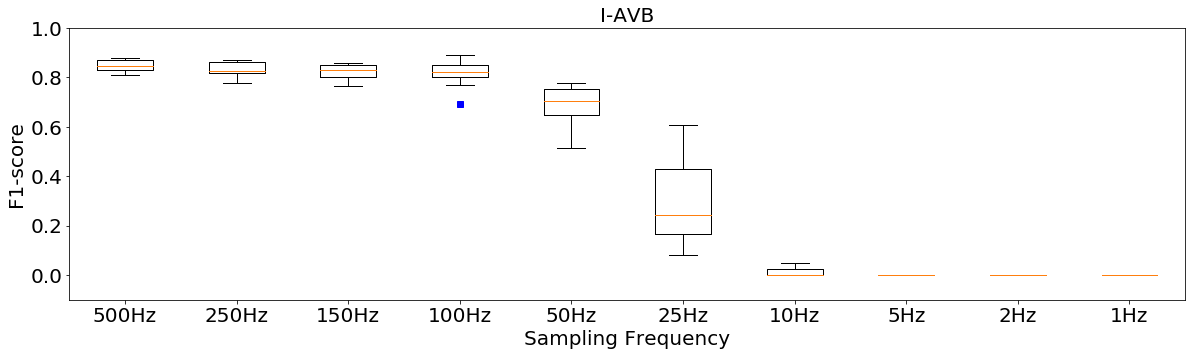

[0.84760009 0.8243759  0.83197295 0.82149418 0.70382034 0.24189316
 0.         0.         0.         0.        ]
100
100
[1.00000000e+00 7.15170873e-02 4.29002589e-02 6.64031296e-02
 1.44725563e-04 2.58132210e-06 5.60318054e-15 1.44330581e-15
 1.44330581e-15 1.44330581e-15]


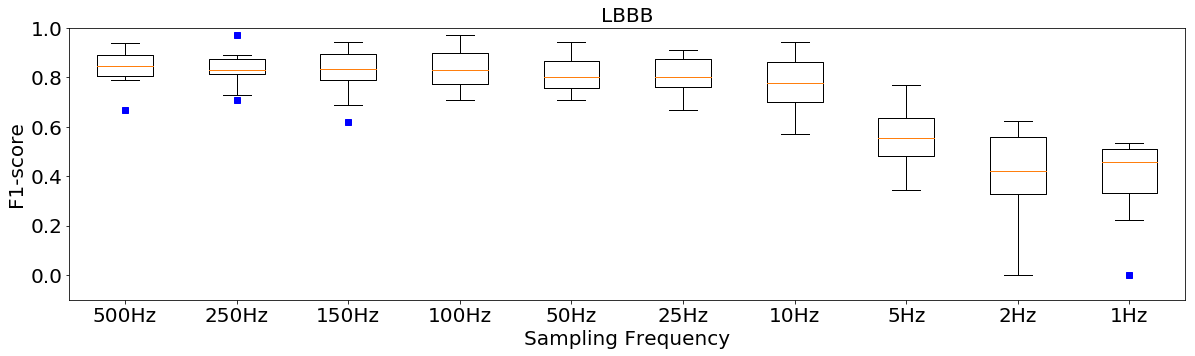

[0.8452381  0.82843137 0.83333333 0.83130081 0.80098684 0.80065359
 0.7764977  0.55614035 0.42307692 0.45759553]
10
10
[1.00000000e+00 7.59726854e-01 3.89523297e-01 7.79966764e-01
 2.18651872e-01 5.75177819e-02 7.57941571e-02 6.84284521e-06
 2.91665761e-05 1.99706550e-05]


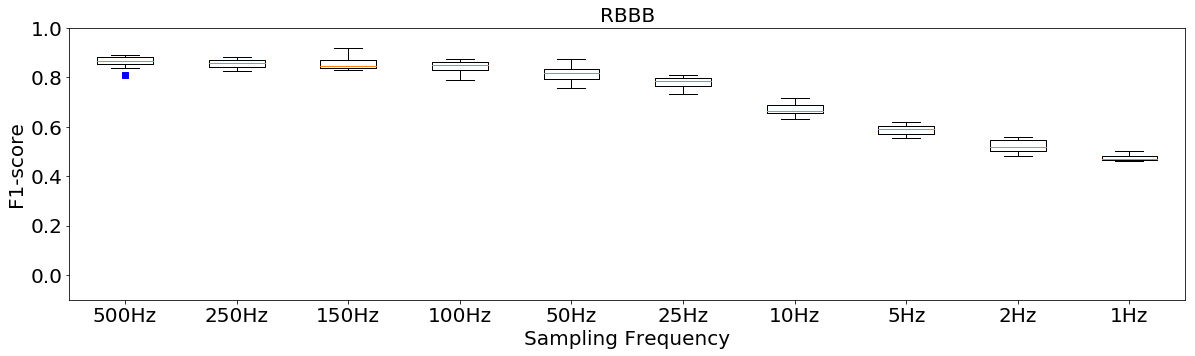

[0.86620904 0.85864136 0.84423252 0.848454   0.81702441 0.78736282
 0.66373068 0.59042569 0.51655078 0.47022135]
100
100
[1.00000000e+00 3.08291657e-01 5.68647830e-01 7.03522919e-02
 1.48341810e-03 2.04264209e-05 1.11882297e-07 2.05056809e-10
 1.87532511e-10 6.13929785e-12]


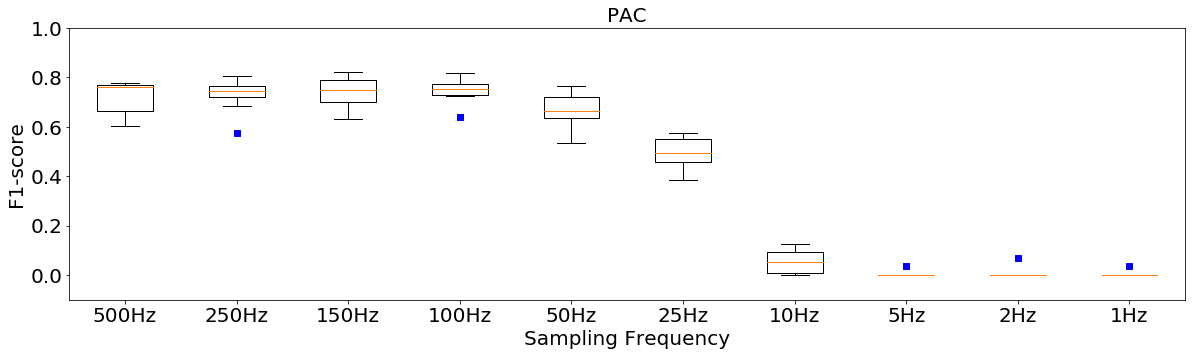

[0.76107293 0.7463808  0.74754902 0.75235849 0.66355674 0.49210353
 0.05172414 0.         0.         0.        ]
100
100
[1.00000000e+00 2.53433829e-01 2.06614964e-01 1.40794200e-01
 2.24813397e-03 1.87646482e-05 2.73836498e-09 3.86477885e-11
 3.03585504e-10 1.26234812e-10]


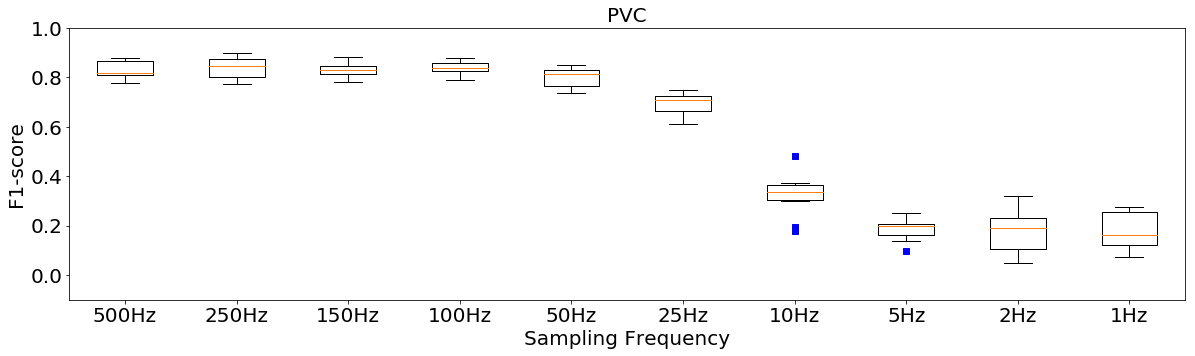

[0.81818182 0.84745763 0.82820991 0.8398051  0.81340405 0.70692348
 0.33470588 0.19876543 0.18885721 0.16053748]
100
50
[1.00000000e+00 3.82852896e-01 9.89923302e-01 4.23155402e-01
 1.34872958e-02 4.47220422e-05 1.53704204e-08 1.19657578e-11
 1.34933633e-09 1.46553529e-10]


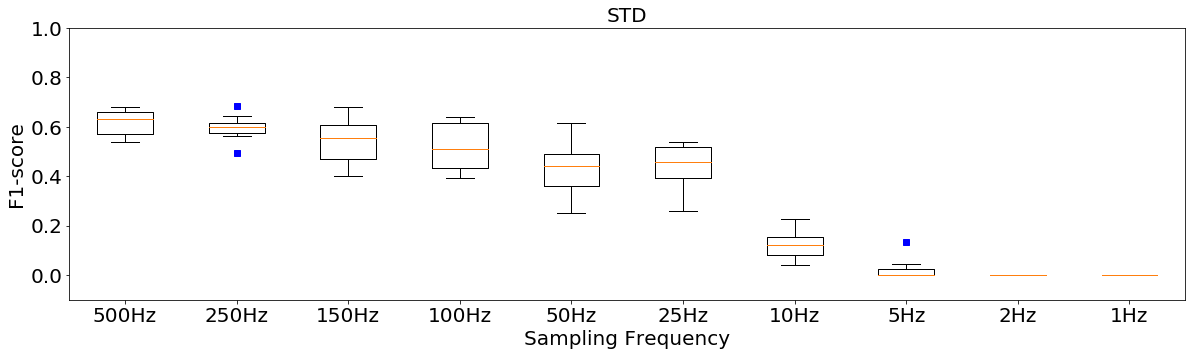

[0.63124496 0.59907979 0.55418719 0.50838161 0.44060972 0.45704962
 0.12260716 0.         0.         0.        ]
250
125
[1.00000000e+00 4.19134157e-01 1.57195339e-02 2.07442429e-03
 3.69354953e-04 5.10716824e-05 5.82212238e-09 2.58006875e-10
 2.69864747e-11 2.69864747e-11]


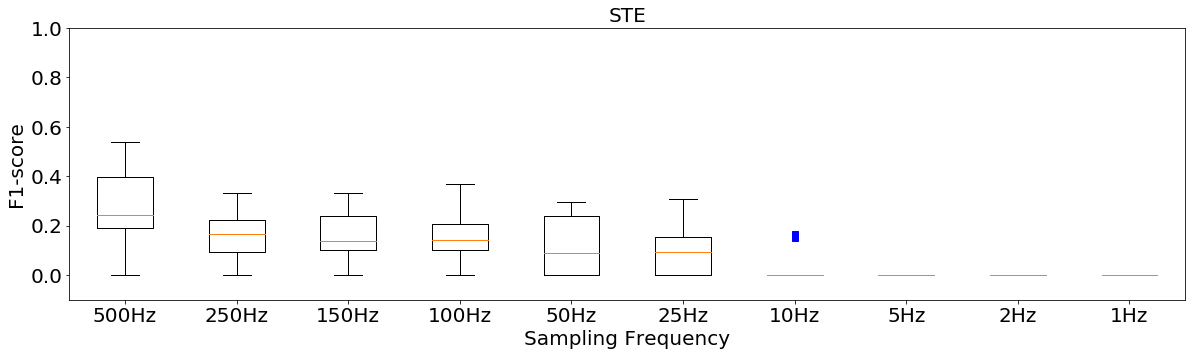

[0.24264706 0.16783217 0.13596491 0.14090909 0.09109731 0.0952381
 0.         0.         0.         0.        ]
100*
25*
[1.00000000e+00 4.71940694e-02 1.16262551e-02 1.08993087e-01
 2.31152482e-02 1.22285266e-02 8.41447548e-04 5.40960693e-04
 5.40960693e-04 5.40960693e-04]


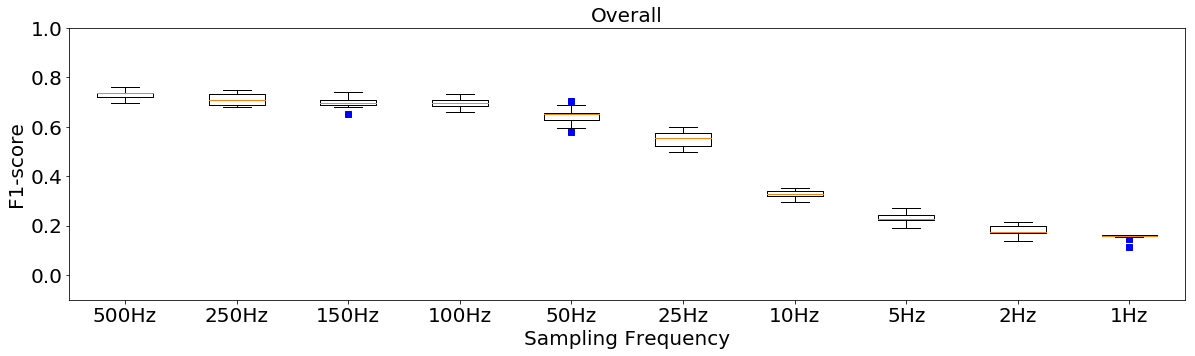

[0.7352007  0.70954901 0.69633012 0.69499107 0.65017094 0.55294673
 0.32775188 0.22563802 0.1763174  0.15811607]
500
250
[1.00000000e+00 2.02891375e-02 9.46339670e-05 2.91803686e-03
 9.08419982e-06 1.34477934e-08 1.97173160e-14 1.33564214e-12
 2.46384642e-13 3.61629717e-15]
Lead :V3


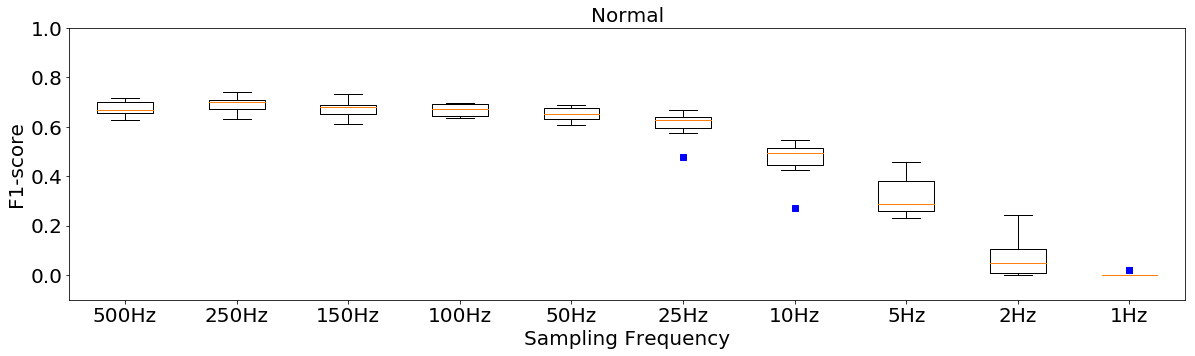

[0.66649786 0.70032696 0.68153684 0.67313916 0.65117431 0.62881307
 0.49358034 0.28809524 0.04931081 0.        ]
50
50
[1.00000000e+00 9.77807914e-02 9.18774328e-01 7.52045525e-01
 5.07462973e-02 2.98128994e-03 1.75213518e-05 3.28339159e-07
 9.15145321e-09 1.15133846e-13]


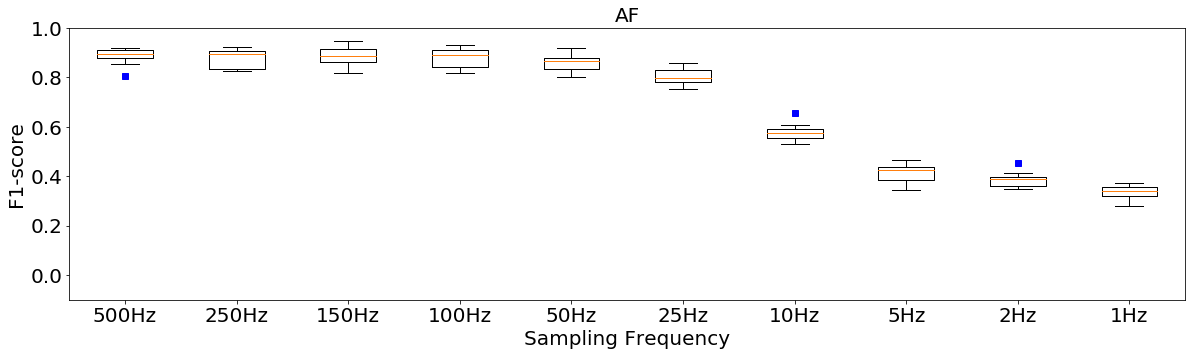

[0.89447722 0.8939951  0.88490319 0.89107843 0.86843531 0.79903846
 0.57392389 0.42711292 0.38721553 0.34185456]
100
100
[1.00000000e+00 4.40580692e-01 9.48153356e-01 5.16082047e-01
 9.48158845e-03 3.65145715e-04 1.63841361e-08 8.15387821e-12
 3.69001465e-11 1.53817684e-11]


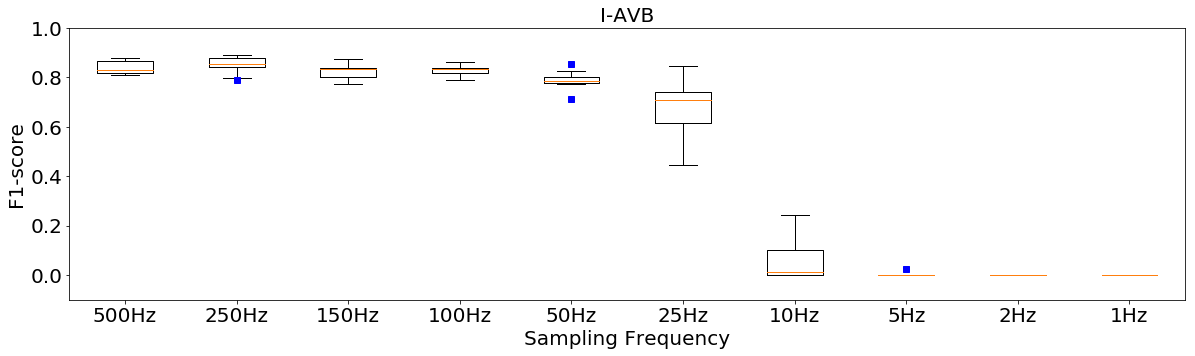

[0.83059952 0.85592869 0.83507441 0.83578431 0.78680424 0.70844227
 0.01298701 0.         0.         0.        ]
100
100
[1.00000000e+00 2.70426261e-01 9.28373384e-02 2.89165915e-01
 3.46223785e-04 1.26799476e-03 1.53296996e-09 2.34216008e-14
 7.08211647e-15 7.08211647e-15]


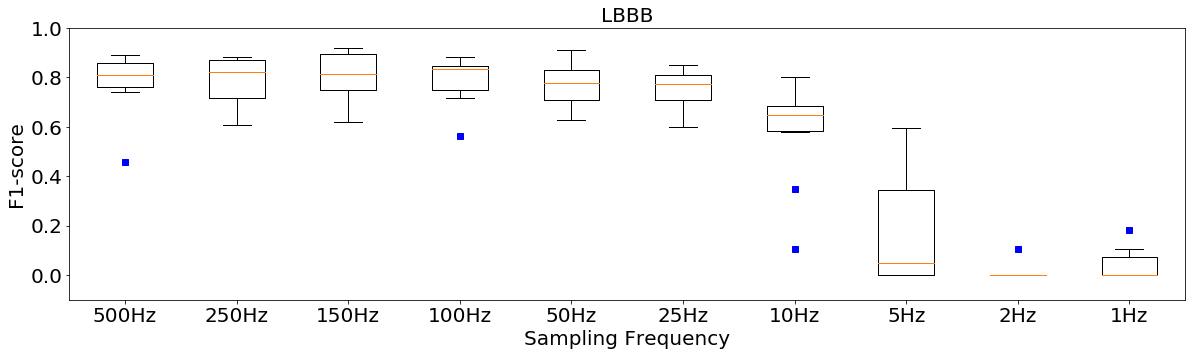

[0.81060606 0.82207207 0.81478537 0.83333333 0.77708978 0.77350427
 0.64785374 0.05       0.         0.        ]
25
10
[1.00000000e+00 7.24221654e-01 3.39399387e-01 7.64107376e-01
 6.81411862e-01 3.30133857e-01 1.41711928e-02 3.82235957e-05
 1.78300957e-08 1.02415929e-07]


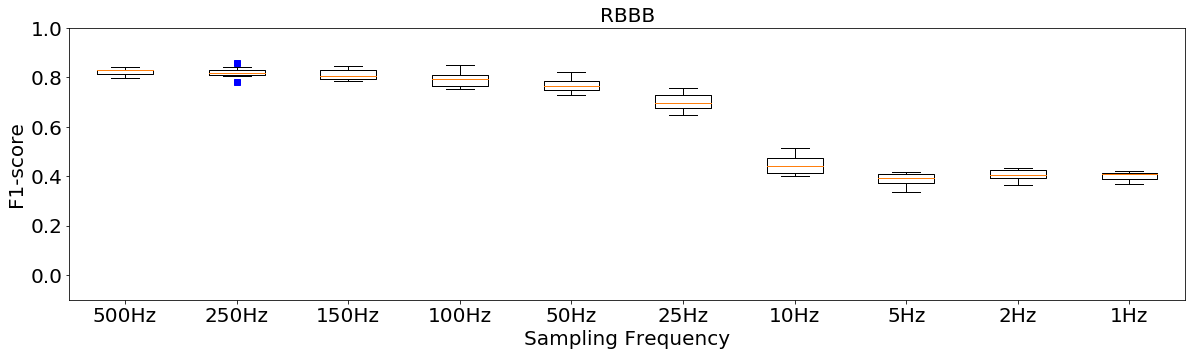

[0.8281942  0.81949733 0.80405519 0.79338712 0.76564442 0.69499106
 0.44291059 0.39472259 0.40622651 0.40738833]
125
125
[1.00000000e+00 8.21515985e-01 1.09547558e-01 7.57560692e-03
 6.14526257e-05 4.26090380e-07 8.91455906e-11 3.40227646e-12
 1.67949452e-12 7.16666095e-14]


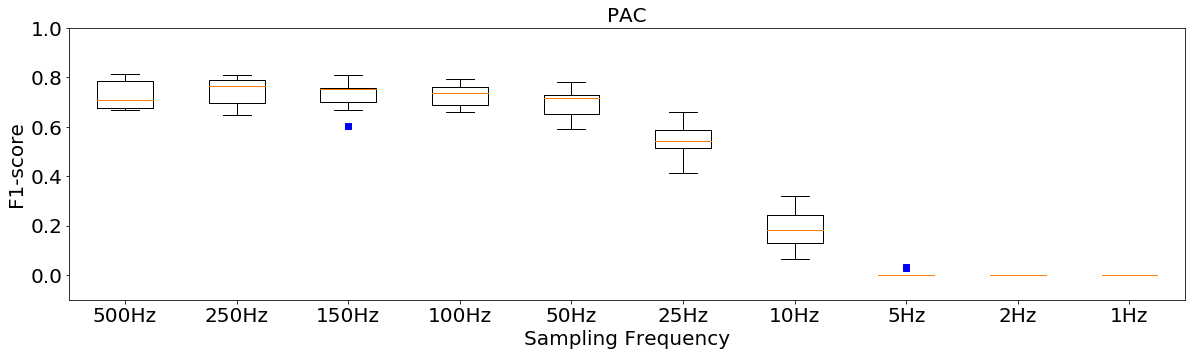

[0.7099393  0.76713928 0.75123762 0.73801805 0.71577303 0.54423077
 0.18065268 0.         0.         0.        ]
50
50
[1.00000000e+00 3.52765252e-01 8.38245165e-01 9.64644529e-01
 6.74613347e-02 2.46416493e-04 5.73811750e-08 6.56404439e-11
 2.24149793e-11 2.24149793e-11]


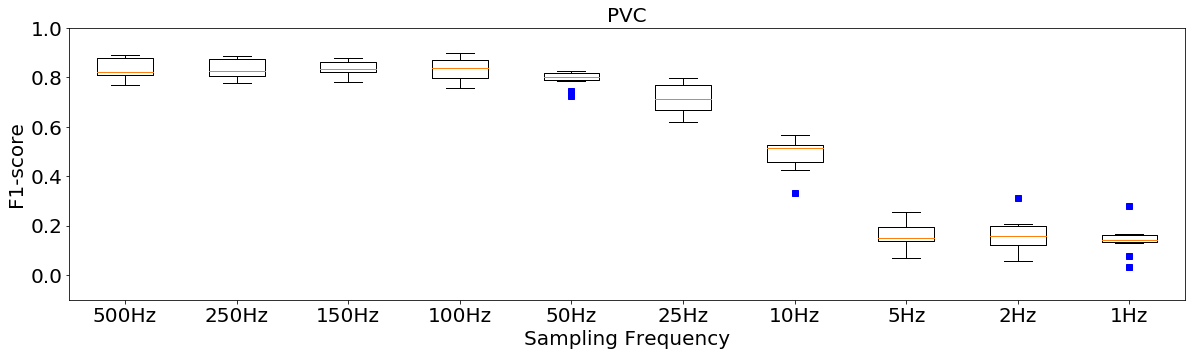

[0.82294654 0.82572464 0.83234127 0.83852021 0.8        0.71186441
 0.51597161 0.14836601 0.15758202 0.14270153]
100
100
[1.00000000e+00 8.28641873e-01 9.58127753e-01 9.16860710e-01
 7.55428952e-03 1.67782755e-04 6.65328438e-08 2.10290655e-10
 1.86691294e-10 3.90441011e-11]


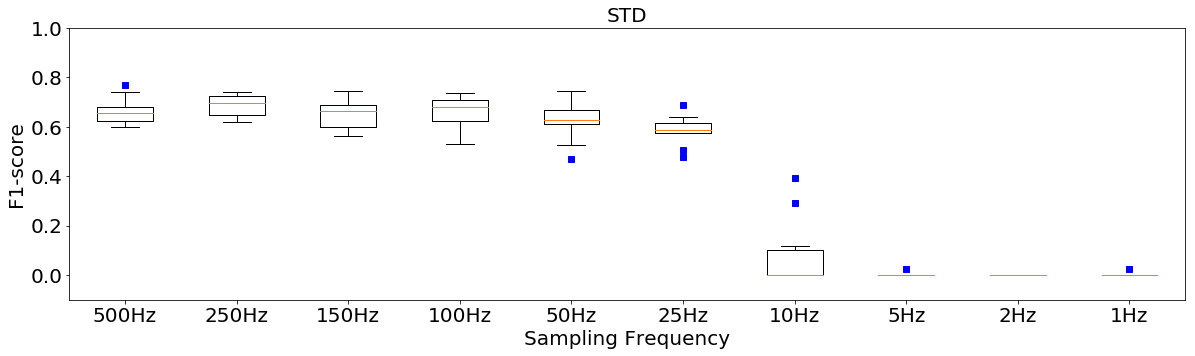

[0.65747126 0.69725725 0.66260163 0.68039216 0.62850133 0.58915608
 0.         0.         0.         0.        ]
50
50
[1.00000000e+00 1.33610182e-01 4.39623878e-01 9.69064006e-01
 1.82202765e-01 6.45035258e-03 4.03938188e-07 6.29695537e-11
 3.60931262e-11 3.99242759e-11]


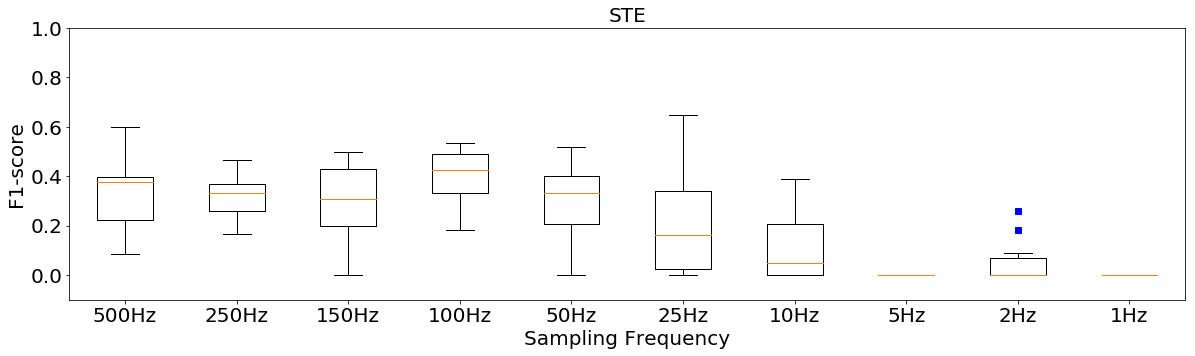

[0.37749288 0.33142857 0.30952381 0.42431762 0.33391304 0.16190476
 0.04761905 0.         0.         0.        ]
50*
10*
[1.00000000e+00 7.97239161e-01 5.74676911e-01 4.71771788e-01
 6.85848637e-01 4.95829543e-02 1.48343451e-02 1.47252329e-04
 4.23105843e-03 1.47252329e-04]


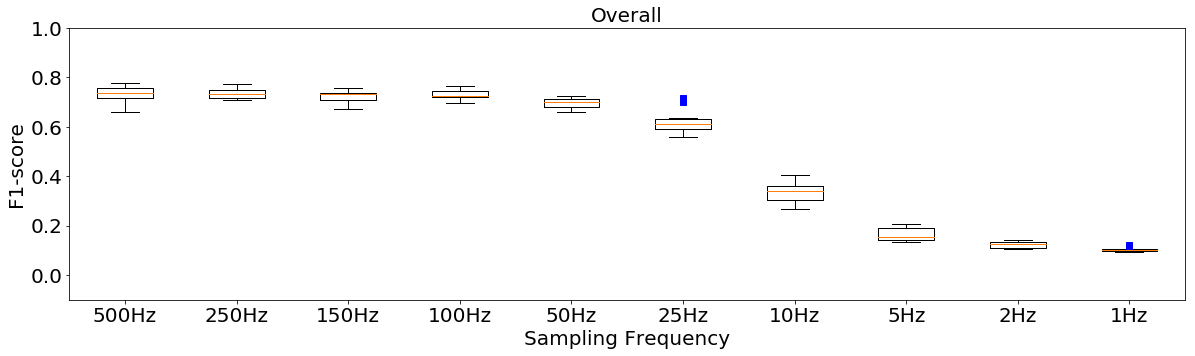

[0.73616637 0.73456931 0.73442362 0.7263938  0.70092522 0.61036016
 0.3390196  0.1536128  0.12458423 0.10127449]
100
100
[1.00000000e+00 5.62065339e-01 5.22484400e-01 9.89220755e-01
 6.60701851e-03 1.87959630e-05 6.32362634e-09 7.39933472e-11
 1.92445662e-12 1.14050277e-12]
Lead :V4


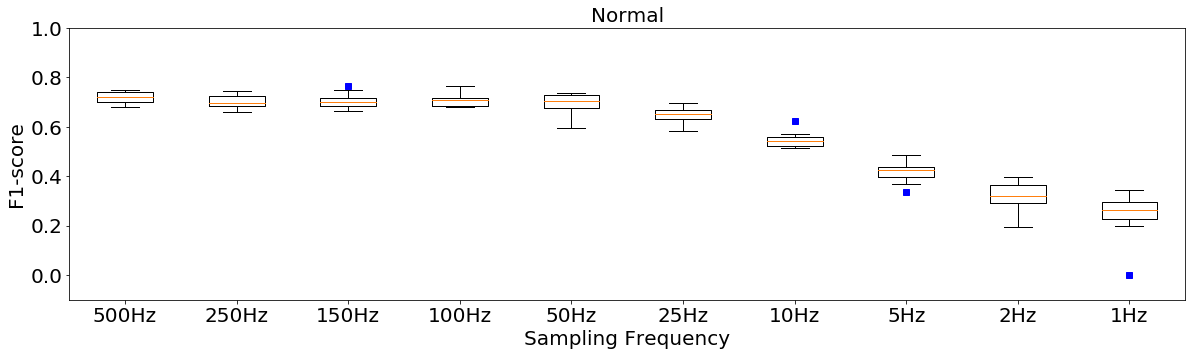

[0.72217638 0.69728845 0.69873557 0.71053566 0.70557846 0.65006002
 0.54382093 0.42644117 0.31899582 0.2635569 ]
50
50
[1.00000000e+00 7.02943344e-02 1.28960878e-01 2.51770203e-01
 5.02784249e-02 4.00164659e-05 3.30662297e-07 4.15387468e-09
 3.91120861e-09 2.20472164e-07]


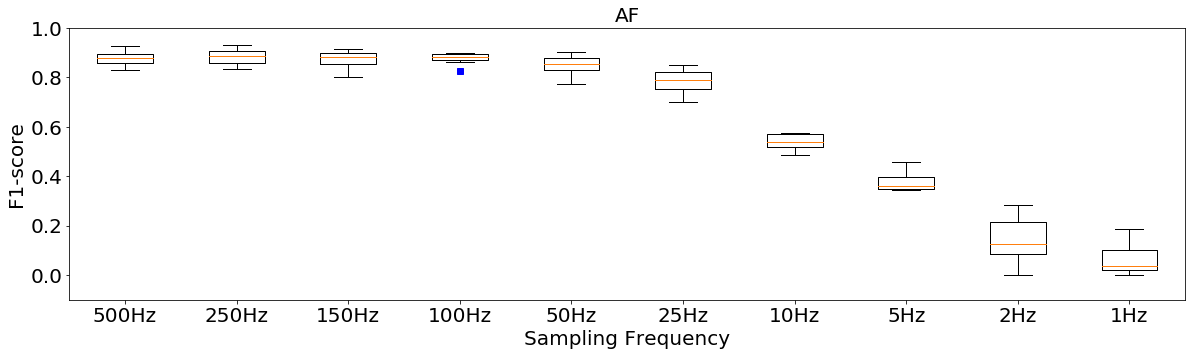

[0.87877551 0.88774341 0.88257665 0.88203887 0.85581384 0.78932677
 0.53982367 0.36173017 0.12599206 0.03812636]
100
100
[1.00000000e+00 5.21613713e-01 5.80331136e-01 9.84287766e-01
 9.70218791e-03 2.57336504e-05 7.63961765e-11 8.35708433e-13
 1.26774768e-09 4.51947423e-11]


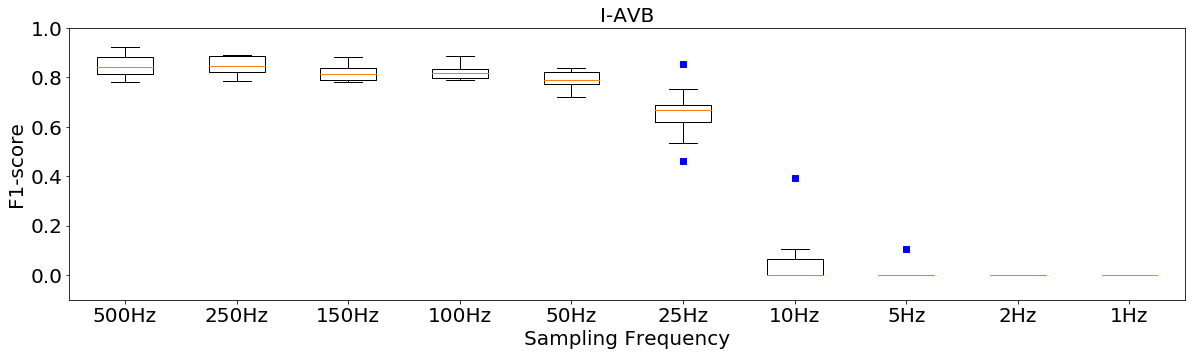

[0.84159031 0.84806713 0.81396037 0.81785517 0.79015912 0.66666667
 0.         0.         0.         0.        ]
100
100
[1.00000000e+00 9.89795103e-01 2.13641872e-02 9.07824403e-02
 3.91408290e-03 5.81081211e-04 1.39679981e-08 1.32289895e-11
 4.68179845e-13 4.68179845e-13]


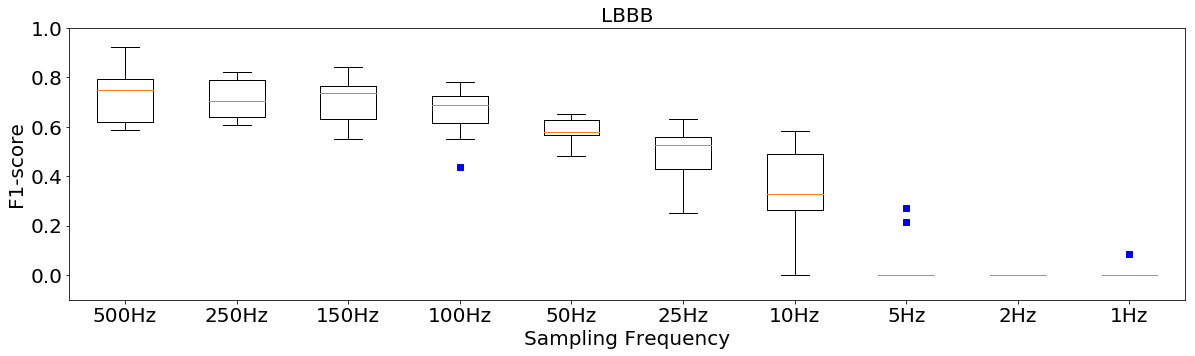

[0.74825175 0.70542636 0.73794668 0.68660714 0.57836257 0.52592593
 0.32795699 0.         0.         0.        ]
100
100
[1.00000000e+00 7.34203510e-01 5.62509549e-01 1.45268218e-01
 1.76272200e-03 1.20218187e-03 2.22356603e-06 2.38789442e-07
 7.07114613e-09 1.00548620e-08]


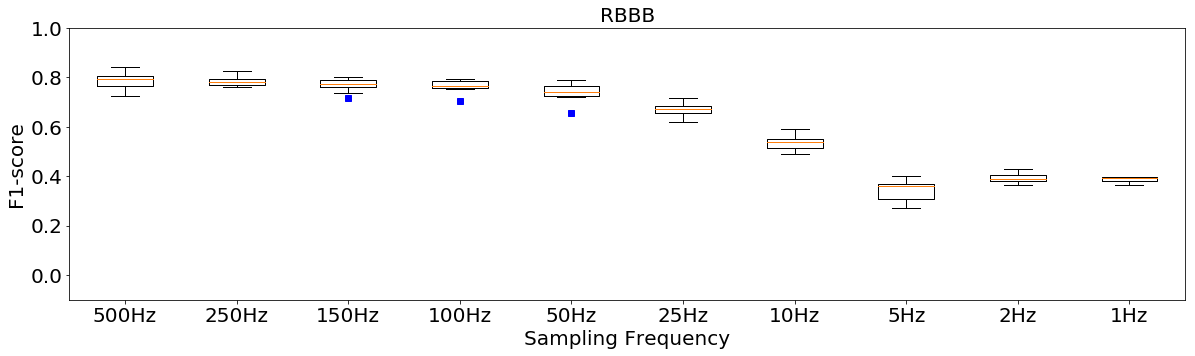

[0.79517327 0.78166188 0.77326789 0.7661904  0.73993619 0.67343278
 0.5374359  0.35951821 0.38808605 0.39322486]
125
100
[1.00000000e+00 8.99129600e-01 5.70851191e-02 1.32615487e-02
 7.75362877e-04 6.91212664e-06 2.83385477e-08 1.59579549e-09
 1.11630944e-10 3.07184296e-11]


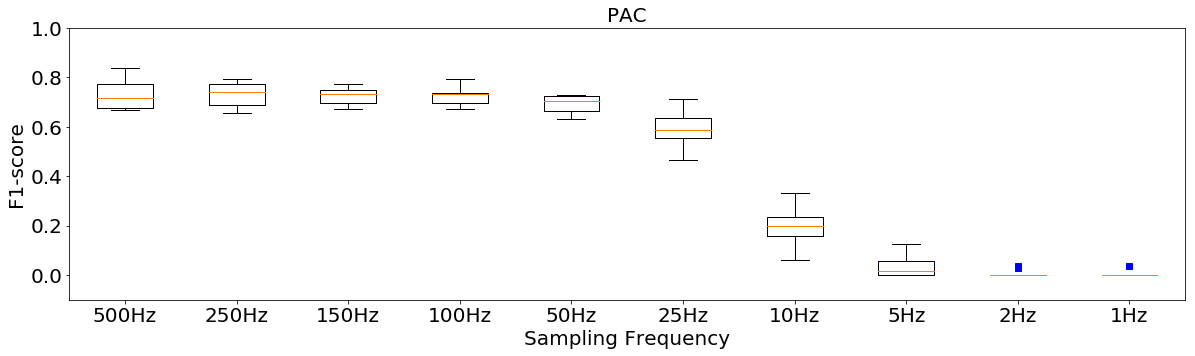

[0.71785714 0.7399032  0.73183292 0.73163636 0.70537715 0.58537978
 0.19804191 0.01612903 0.         0.        ]
50
50
[1.00000000e+00 9.68517433e-01 7.45700807e-01 8.73306459e-01
 5.22657547e-02 8.78662955e-05 1.25741980e-08 1.58568924e-09
 6.67695583e-11 7.22697930e-11]


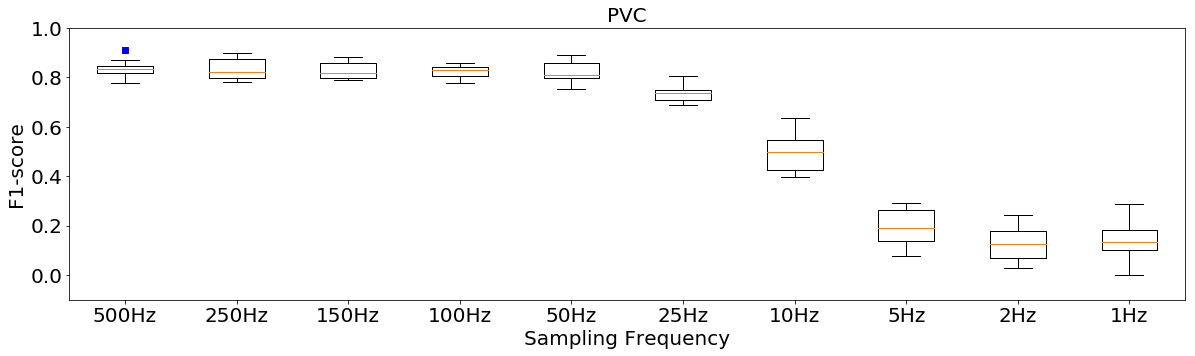

[0.83343757 0.82046036 0.81880342 0.83118441 0.81013109 0.73509643
 0.49655016 0.19216197 0.12496626 0.13570151]
50
50
[1.00000000e+00 8.29783132e-01 4.89679401e-01 3.16365618e-01
 2.90953447e-01 4.56880394e-06 6.65060841e-08 4.42848617e-10
 8.21309187e-10 3.33017906e-10]


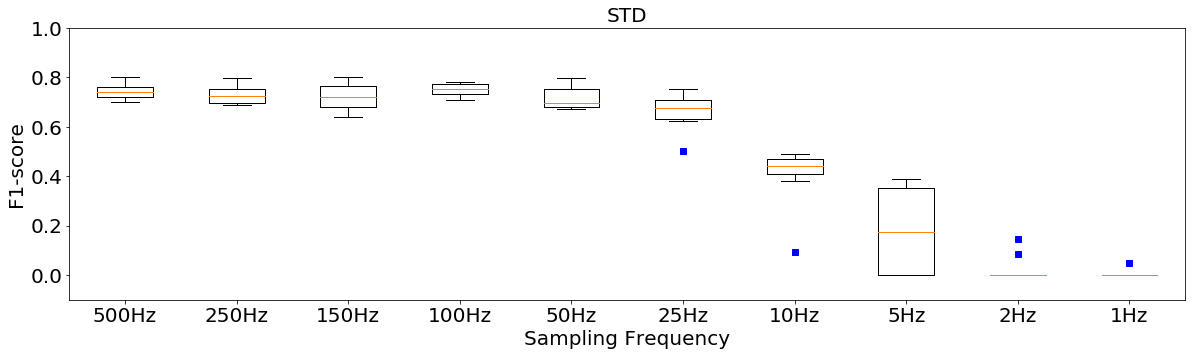

[0.73944773 0.72434211 0.72020018 0.75175577 0.69601806 0.67696736
 0.44053208 0.17379032 0.         0.        ]
50
50
[1.00000000e+00 1.65579780e-01 1.39482724e-01 4.03102560e-01
 1.40756592e-01 1.92836783e-03 1.40568261e-05 5.05097296e-06
 7.17338796e-11 1.74363737e-13]


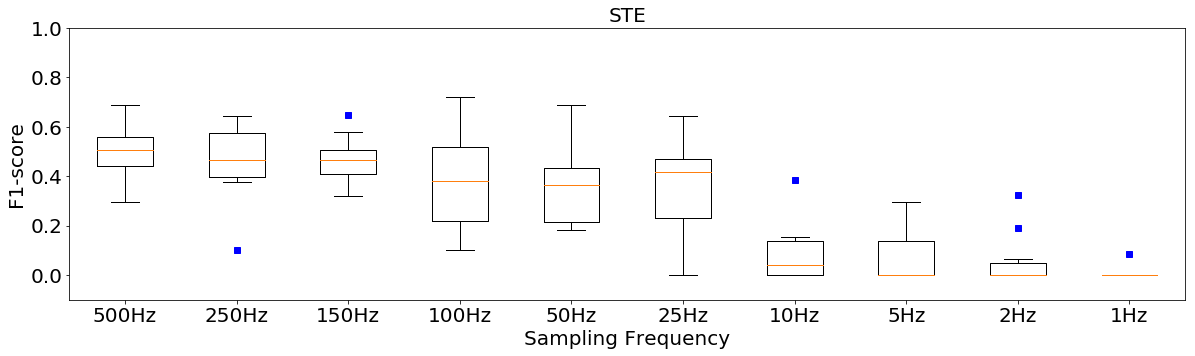

[0.50641026 0.46713287 0.46410256 0.38181818 0.36472149 0.41522989
 0.04166667 0.         0.         0.        ]
100
25
[1.00000000e+00 5.63708005e-01 5.41384112e-01 5.88496012e-02
 2.11737935e-02 1.88114848e-02 6.02073109e-07 1.50528466e-05
 1.02372586e-05 6.62532879e-07]


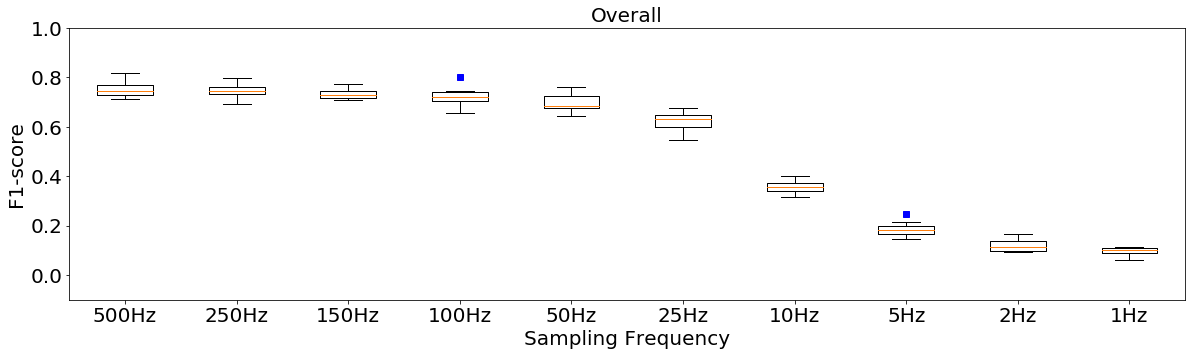

[0.74574908 0.74352235 0.729777   0.71957422 0.68485802 0.6334107
 0.35801621 0.1837836  0.11266518 0.1017339 ]
125
100
[1.00000000e+00 2.31527760e-01 5.02664363e-02 3.93935763e-02
 5.03973143e-04 6.35866848e-06 3.36528193e-11 4.50676691e-11
 8.10920435e-13 7.17809824e-13]
Lead :V5


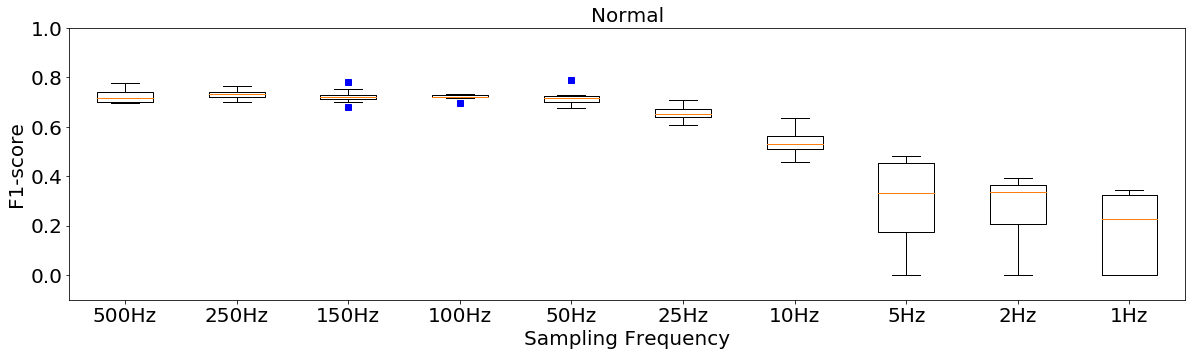

[0.71489724 0.73244656 0.7221072  0.72169192 0.71535734 0.65057818
 0.53068524 0.33053601 0.33601056 0.22688831]
50
50
[1.00000000e+00 2.18575285e-01 9.41492511e-01 8.24692977e-01
 3.64769310e-01 2.67568999e-04 1.90641689e-05 4.99142848e-05
 4.37682221e-06 1.86500874e-06]


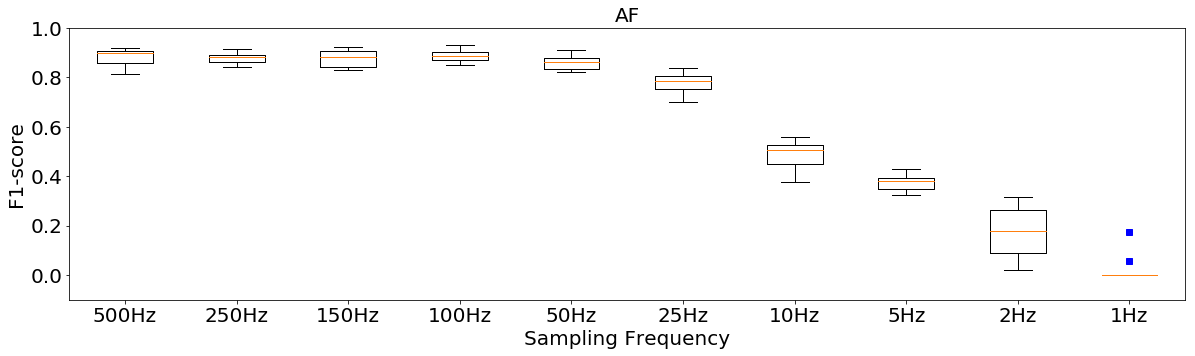

[0.89877091 0.88163265 0.8823012  0.88698895 0.86174242 0.78416383
 0.50621874 0.37908834 0.17680689 0.        ]
100
50
[1.00000000e+00 6.64013506e-01 3.56194012e-01 7.57030220e-01
 2.57018486e-02 2.10319960e-07 1.00945264e-08 1.52754134e-11
 1.95920878e-08 1.89031669e-11]


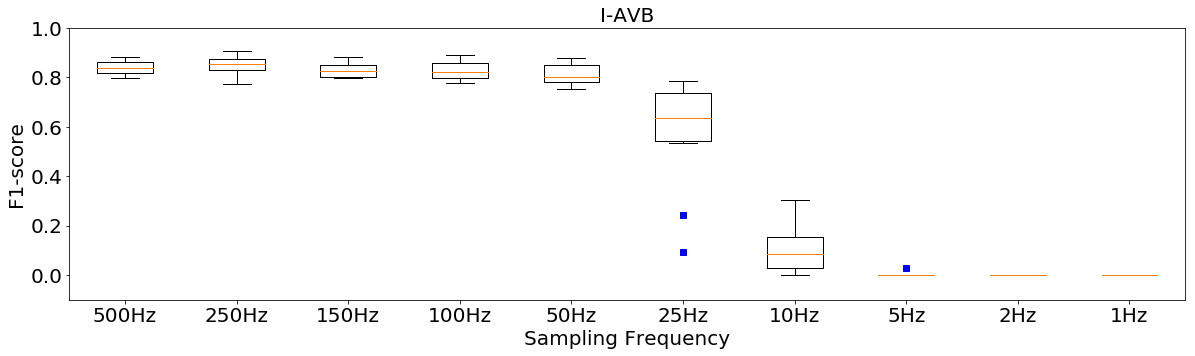

[0.83888889 0.85619349 0.82435212 0.82018634 0.80310078 0.6369191
 0.08688272 0.         0.         0.        ]
100
100
[1.00000000e+00 2.98716489e-01 1.65452784e-01 9.38711249e-02
 4.06915682e-03 4.61802095e-03 2.67031594e-09 1.39606844e-14
 7.51301045e-15 7.51301045e-15]


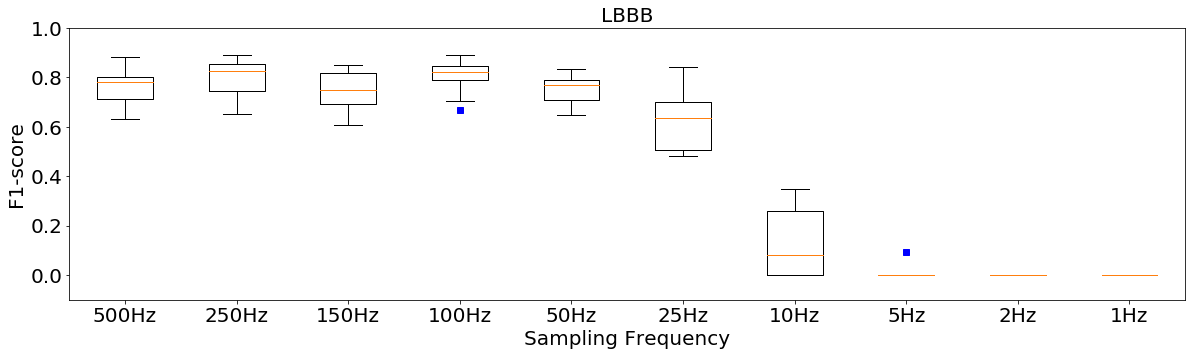

[0.78244561 0.82645804 0.7482066  0.82291667 0.76944972 0.63430127
 0.08333333 0.         0.         0.        ]
50
50
[1.00000000e+00 1.74145652e-01 4.74745778e-01 4.86232258e-02
 4.80435597e-01 9.74581554e-04 9.62307143e-07 4.02824001e-10
 2.25747930e-10 2.25747930e-10]


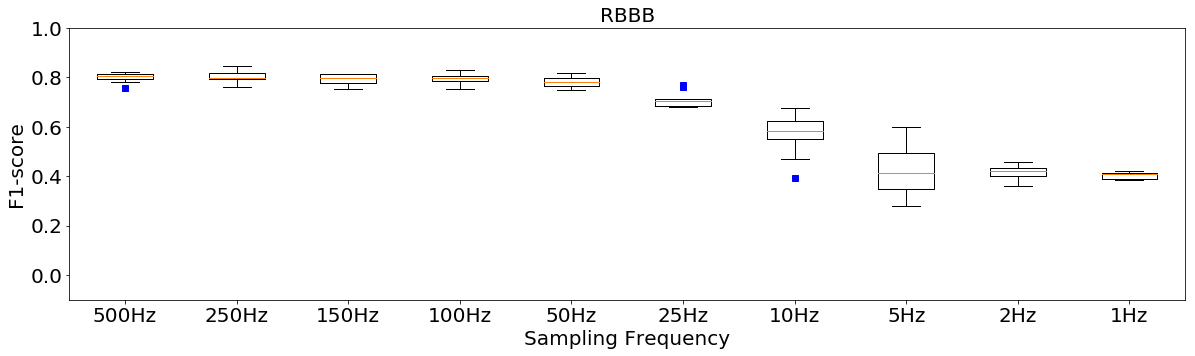

[0.80555723 0.79733883 0.79600923 0.79851171 0.78100197 0.70395499
 0.58276719 0.41340486 0.42220731 0.40716415]
100
50
[1.00000000e+00 8.29494790e-01 2.90074556e-01 3.71076676e-01
 1.42226068e-02 8.26571131e-06 1.84050025e-05 9.17057306e-07
 1.22579713e-11 1.54535530e-11]


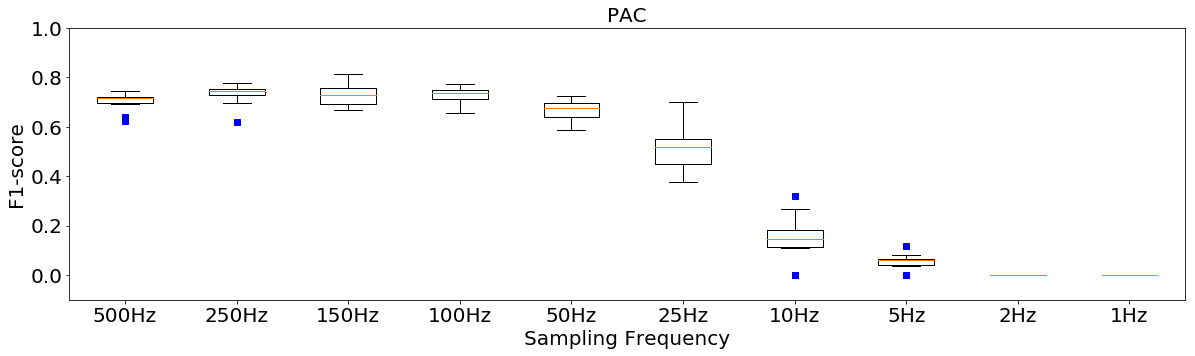

[0.71718622 0.74442703 0.729973   0.73634558 0.67808724 0.51856298
 0.1463719  0.05926251 0.         0.        ]
100
100
[1.00000000e+00 3.17018303e-02 3.58898462e-02 6.63658790e-02
 8.42407040e-03 1.12213364e-04 8.16184434e-08 3.21262840e-11
 8.28163049e-13 8.28163049e-13]


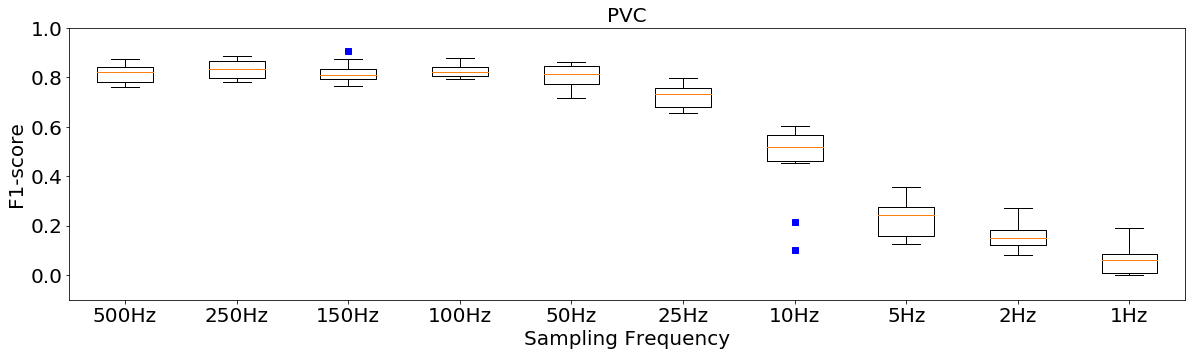

[0.8217931  0.83311209 0.80990814 0.82046036 0.81430508 0.73120856
 0.51899281 0.24520124 0.14851097 0.05952381]
50
50
[1.00000000e+00 1.86683476e-02 6.17417478e-01 1.94676054e-01
 2.12986932e-01 2.55493952e-06 6.75508264e-05 6.83193488e-10
 5.28057420e-11 2.97544419e-10]


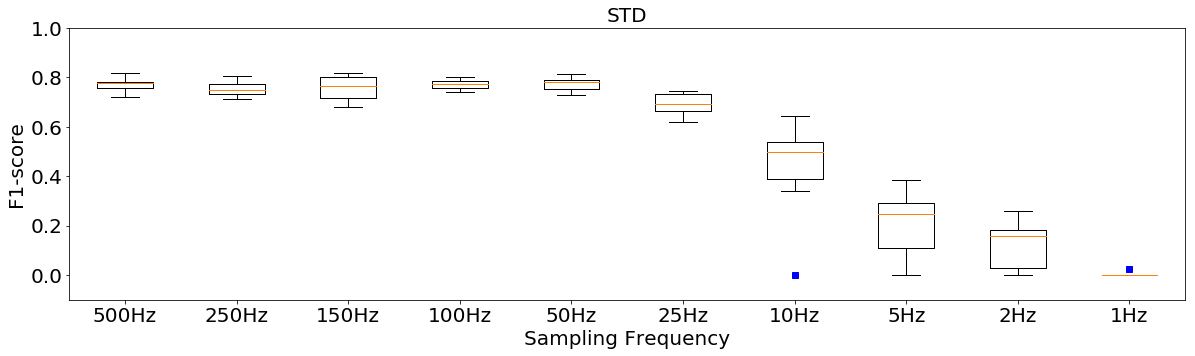

[0.77562571 0.74778107 0.76433824 0.77138716 0.78043011 0.69436851
 0.49842544 0.24584444 0.16021455 0.        ]
50
50
[1.00000000e+00 7.91419867e-02 3.29063360e-01 8.97904507e-01
 9.11764786e-01 5.42045971e-05 5.22480088e-04 2.53949391e-07
 1.50760689e-08 3.95603054e-14]


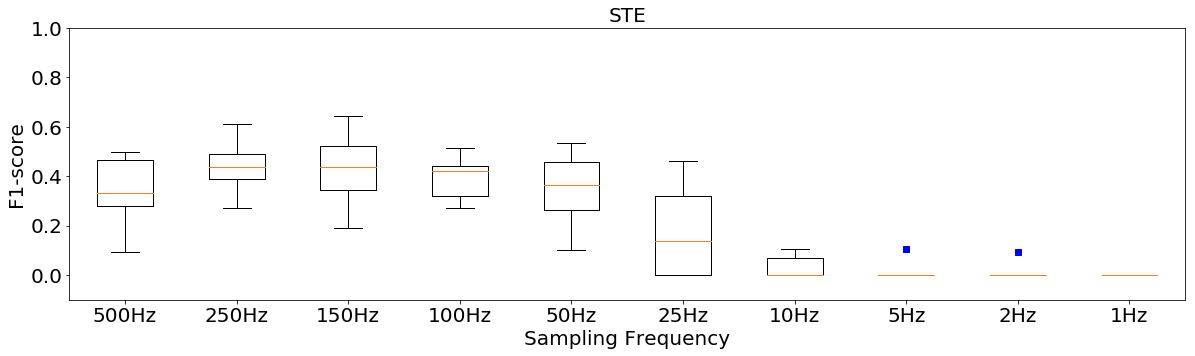

[0.33333333 0.43766578 0.43650794 0.42118227 0.36472149 0.13852814
 0.         0.         0.         0.        ]
50*
25*
[1.00000000e+00 2.94247772e-02 2.40152667e-01 4.01195574e-01
 9.84636643e-01 2.82195273e-02 7.38643635e-05 1.01437735e-05
 1.14539699e-05 1.31473997e-05]


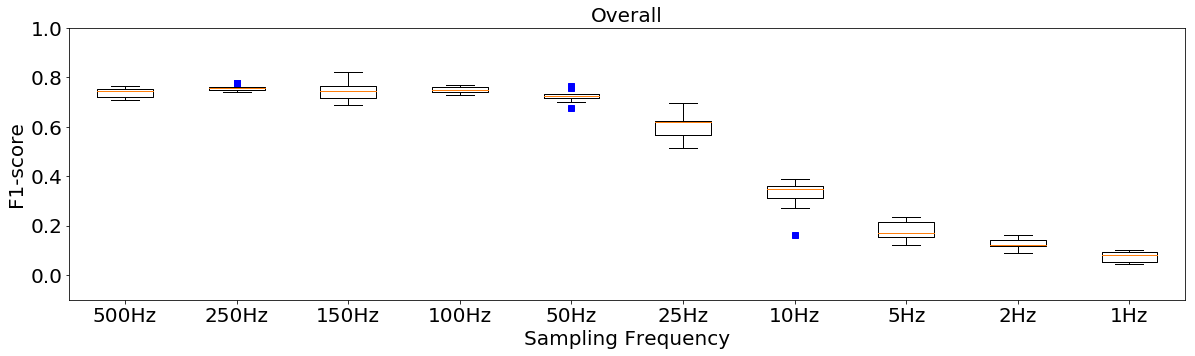

[0.7441504  0.75528723 0.7455868  0.74923026 0.72376261 0.61785668
 0.34956963 0.17095591 0.12330309 0.08289034]
50
50
[1.00000000e+00 1.18246874e-02 5.82183324e-01 1.40102465e-01
 8.84388166e-02 2.04474079e-05 1.97808805e-08 1.05221720e-11
 3.49496698e-14 6.97726024e-13]
Lead :V6


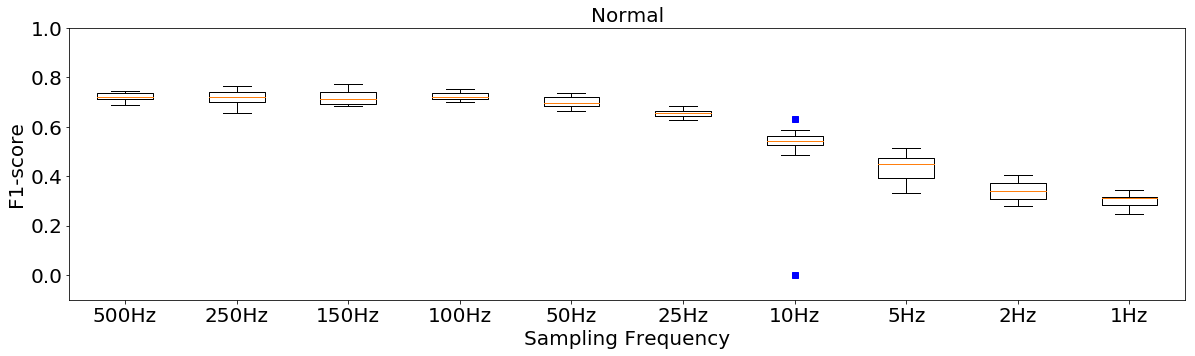

[0.72034184 0.72108462 0.71294118 0.72163135 0.6970582  0.65672618
 0.54280554 0.45146981 0.3388879  0.31203859]
100
50
[1.00000000e+00 9.03497726e-01 8.73626467e-01 7.06333124e-01
 4.16833039e-02 1.57451481e-05 2.86628785e-03 3.83884712e-08
 2.30385965e-09 1.10475852e-10]


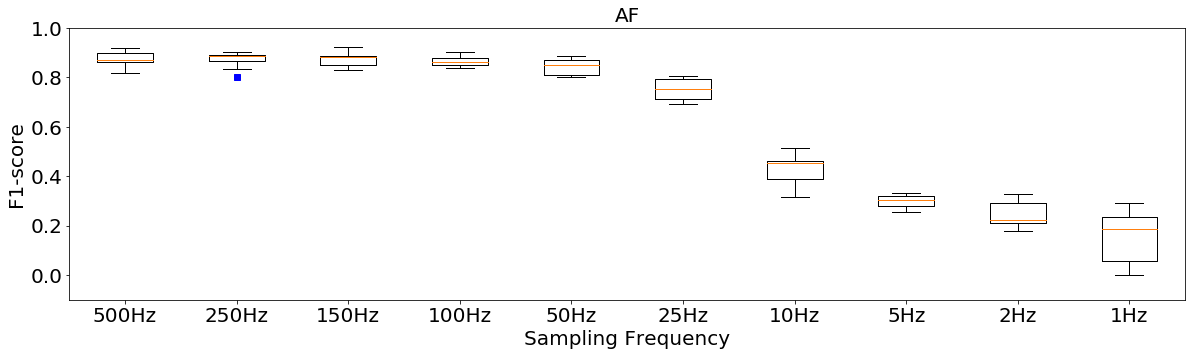

[0.87241909 0.88606881 0.88100857 0.86255924 0.85011562 0.75435897
 0.45248439 0.30338789 0.22271825 0.1860528 ]
100
100
[1.00000000e+00 6.34429438e-01 5.93027762e-01 3.24211880e-01
 4.97985432e-03 3.04398411e-05 1.18140931e-08 2.56120153e-12
 3.80024703e-11 9.71853751e-09]


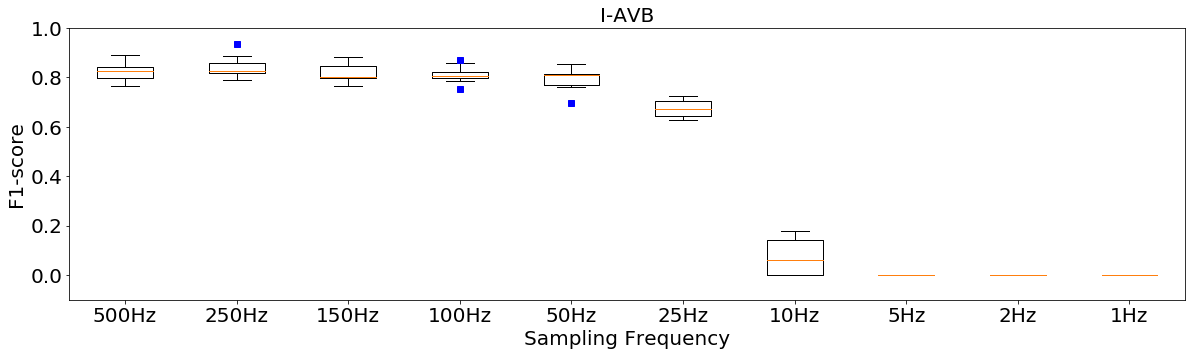

[0.82441481 0.82612125 0.80303466 0.80586277 0.80879282 0.67384306
 0.06110513 0.         0.         0.        ]
125
50
[1.00000000e+00 1.39116358e-01 5.01806306e-01 3.63841454e-02
 4.61406909e-02 4.84576112e-05 2.46778931e-10 3.47523028e-13
 3.47523028e-13 3.47523028e-13]


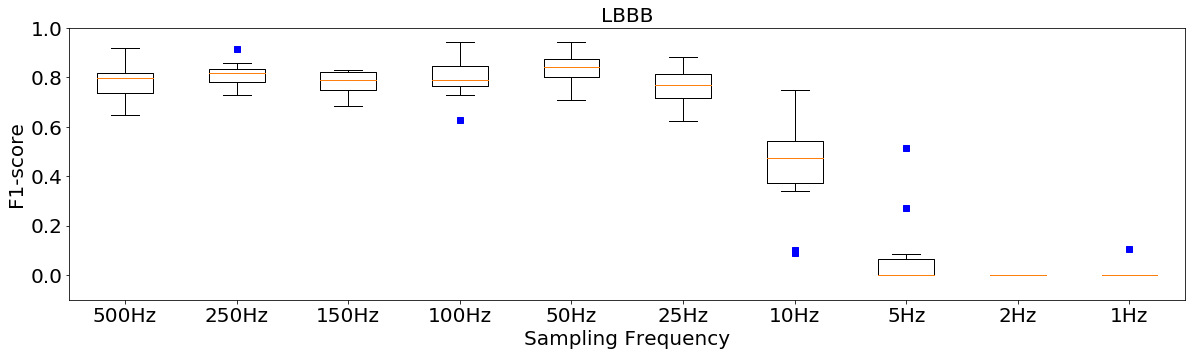

[0.7987013  0.81717011 0.7902439  0.78787879 0.84033613 0.76893939
 0.47575758 0.         0.         0.        ]
25
25
[1.00000000e+00 1.18495154e-01 9.58149067e-01 4.71359875e-01
 1.32785035e-02 3.87222220e-01 8.55162512e-04 1.92649362e-06
 2.61595820e-10 5.30595626e-10]


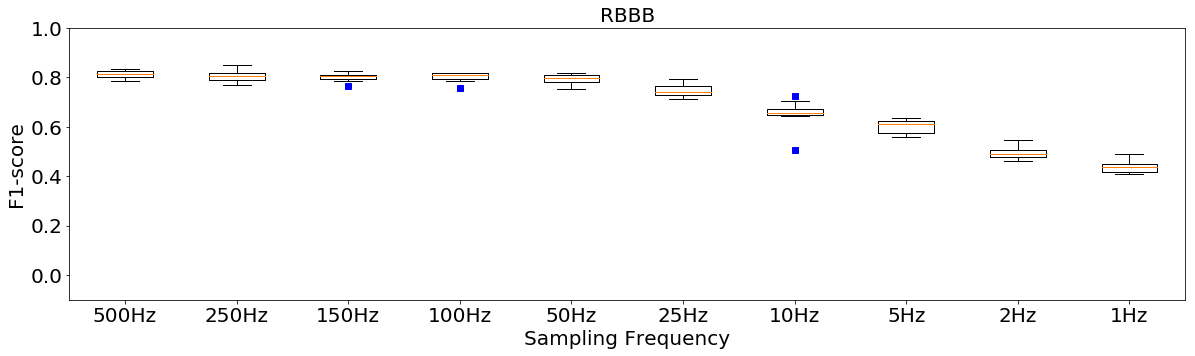

[0.81198228 0.80750389 0.80405521 0.80800654 0.7967243  0.742389
 0.65796974 0.60987962 0.48945425 0.43687145]
100
100
[1.00000000e+00 6.10854852e-01 3.59362726e-02 2.53294089e-01
 6.99115791e-03 4.53723596e-05 8.62559618e-06 1.38729967e-08
 2.96908048e-10 3.62188553e-11]


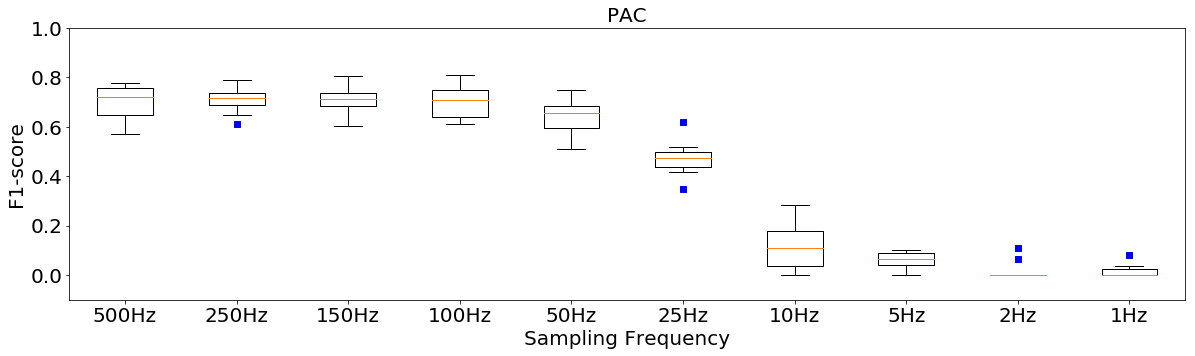

[0.72170213 0.71767057 0.71152597 0.70877193 0.65426275 0.47438902
 0.11153846 0.06612022 0.         0.        ]
100
50
[1.00000000e+00 7.35406990e-01 6.88633563e-01 9.27687474e-01
 3.84286540e-02 9.99075226e-06 3.31796190e-07 9.29654156e-10
 1.70353483e-09 2.79233646e-10]


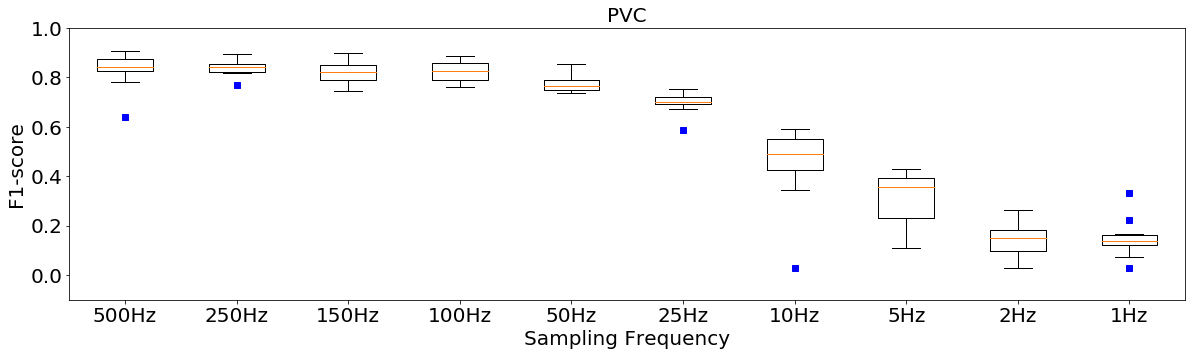

[0.84240708 0.84113046 0.8209707  0.82783229 0.76392573 0.70250488
 0.4899574  0.35853462 0.15195557 0.13653308]
100
50
[1.00000000e+00 4.36130260e-01 5.89931200e-01 8.33604699e-01
 3.07410090e-02 6.36965820e-04 3.98044241e-05 1.11638330e-07
 6.78169960e-09 1.15657943e-08]


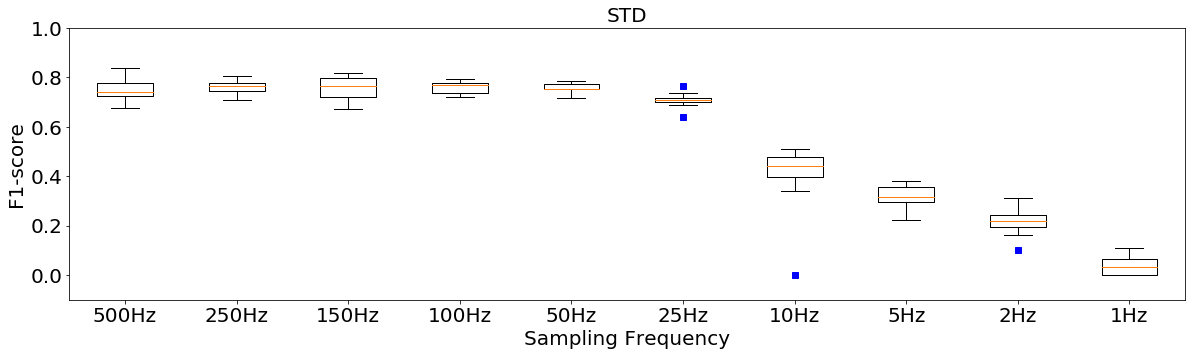

[0.74069021 0.76627157 0.76339713 0.76844751 0.75458475 0.70887598
 0.44070513 0.31530761 0.21807455 0.03417314]
50
25
[1.00000000e+00 4.65529158e-01 6.42787441e-01 2.80905832e-01
 5.76373399e-01 1.98070734e-02 4.38305274e-05 7.36404745e-09
 2.71326686e-09 8.05583292e-11]


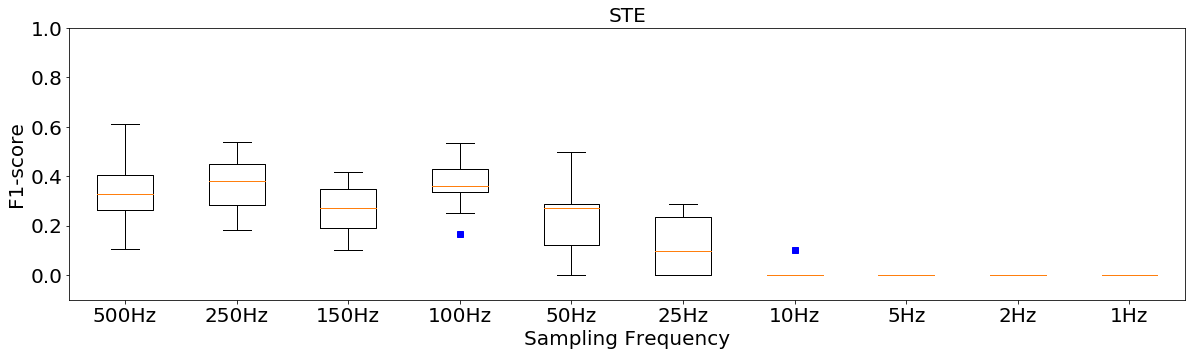

[0.3277592  0.38224638 0.27272727 0.35909823 0.27272727 0.09761905
 0.         0.         0.         0.        ]
50*
50*
[1.00000000e+00 7.70147857e-01 2.43072849e-01 7.27114272e-01
 1.01930602e-01 8.36447398e-03 2.90257543e-05 5.78111242e-05
 5.78111242e-05 5.78111242e-05]


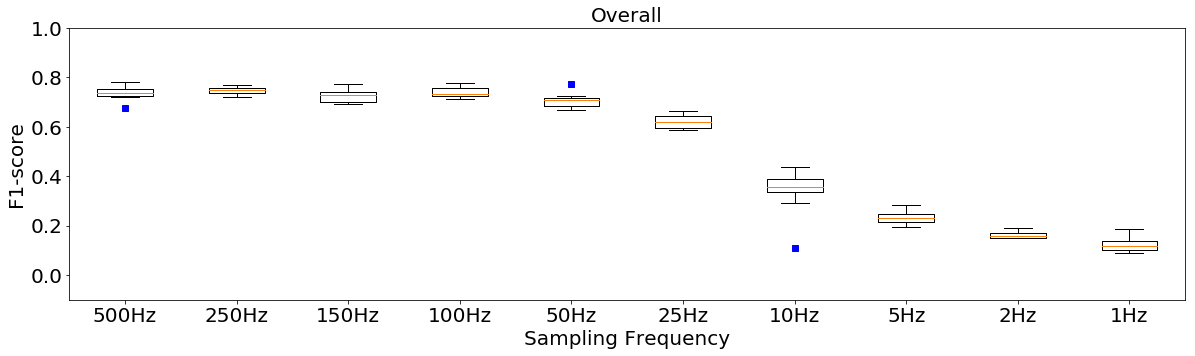

[0.73601596 0.75074419 0.72730873 0.73334025 0.70818517 0.61872292
 0.35608488 0.23052313 0.15912417 0.11573793]
100
50
[1.00000000e+00 3.63907073e-01 3.66418917e-01 8.61395865e-01
 1.97802468e-02 1.09163072e-06 5.28958763e-07 4.68747245e-11
 3.19725616e-13 7.74040134e-14]


((12, 10), (12, 10))

In [ ]:
#box-plotting
%matplotlib inline
BIGGER_SIZE = 20
Hz = np.asarray([500,250,125,100,50,25,10,5,2,1])
HzLabel = np.asarray(['500Hz','250Hz','150Hz','100Hz','50Hz','25Hz','10Hz','5Hz','2Hz','1Hz'])
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
titleList = ['Normal','AF', 'I-AVB','LBBB','RBBB','PAC','PVC','STD','STE','Overall']
matrixForTable_005 = []
matrixForTable_001 = []
for i in range(12):
    if i not in TargetLead:
        continue
    print('Lead :'+leadsLabel[i])
    subMatrixForTable_005 = []
    subMatrixForTable_001 = []
    for j in range(10):
        scoreList_and_average = np.concatenate((np.load('./comparison/CPSC2018_10_fold_lead_models_test_result_lead_'+str(leadsLabel[i])+'.npy').T,np.asarray([np.mean(np.load('./comparison/CPSC2018_10_fold_lead_models_test_result_lead_'+str(leadsLabel[i])+'.npy'),axis =2).T])),axis = 0)[j]
        fig = plt.figure(figsize=(20,5))
        plt.boxplot(scoreList_and_average.T.tolist(),
                    notch=False,  # box instead of notch shape
                    sym='bs',     # red squares for outliers
                    vert=True)   # horizontal box aligmnent
        plt.xticks([x+1 for x in range(len(HzLabel))],HzLabel, size=BIGGER_SIZE)
        plt.yticks(fontsize=BIGGER_SIZE)
        plt.ylim((-0.1, 1))
        plt.xlabel('Sampling Frequency', size=BIGGER_SIZE)
        plt.ylabel('F1-score', size=BIGGER_SIZE)
        t = plt.title(titleList[j], size=BIGGER_SIZE)
        plt.show()
        print(np.median(scoreList_and_average,axis = 0))
        paired_ttest_to_best = np.asarray([stats.ttest_rel(scoreList_and_average[:,0], scoreList_and_average[:,i])[1] for i in range(scoreList_and_average.shape[1])])
        paired_ttest_to_best[0] = 1
        try:
            bestHz_005 = Hz[paired_ttest_to_best>=0.05][-1].astype('str')
        except:
            bestHz_005 = 'nan'
        try:
            bestHz_001 = Hz[paired_ttest_to_best>=0.01][-1].astype('str')
        except:
            bestHz_001 = 'nan'
        if np.median(scoreList_and_average,axis = 0)[0]<= 0.5:
            bestHz_005 += '*'
            bestHz_001 += '*'
        print(bestHz_005)
        print(bestHz_001)
        subMatrixForTable_005.append(bestHz_005)
        subMatrixForTable_001.append(bestHz_001)
        print(paired_ttest_to_best)
    matrixForTable_005.append(subMatrixForTable_005)
    matrixForTable_001.append(subMatrixForTable_001)
matrixForTable_005 = np.asarray(matrixForTable_005)
matrixForTable_001 = np.asarray(matrixForTable_001)
matrixForTable_005.shape, matrixForTable_001.shape

# Benchmark Model Predictive Power Changes At Different Sampling Rates

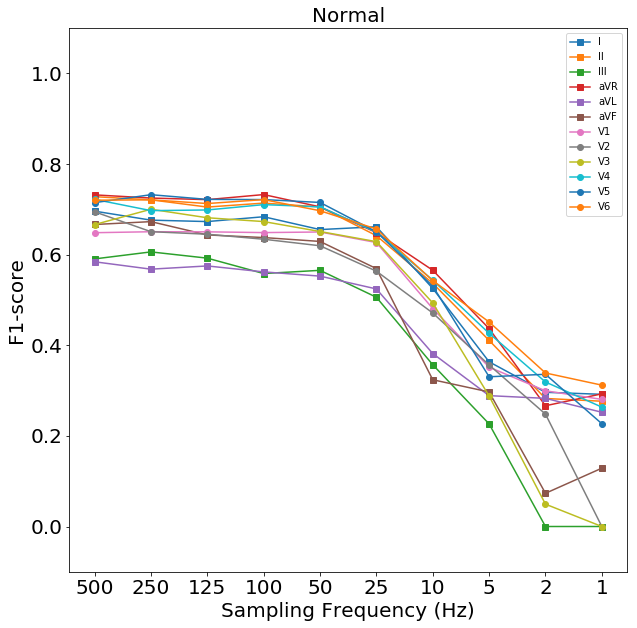

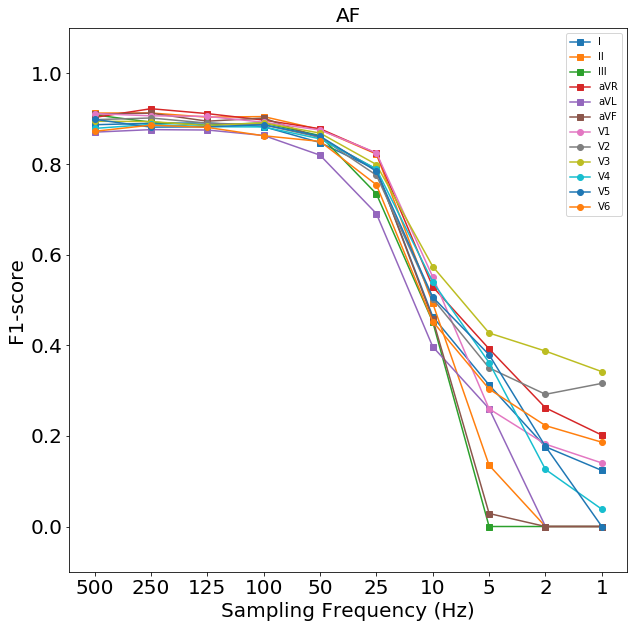

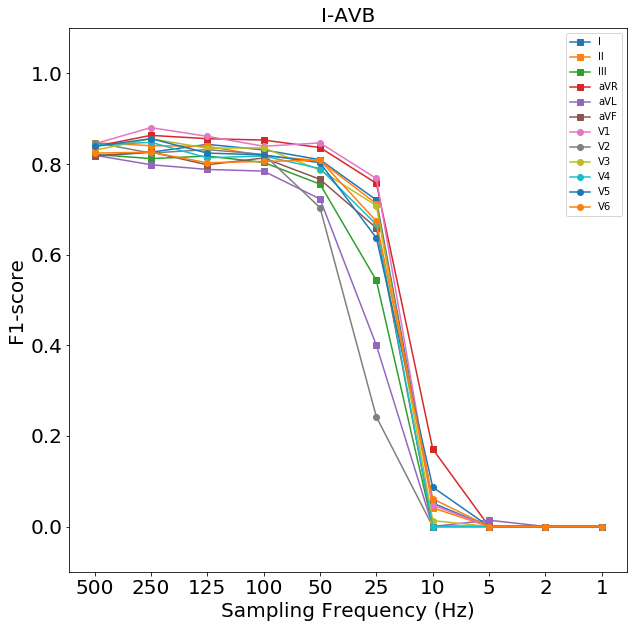

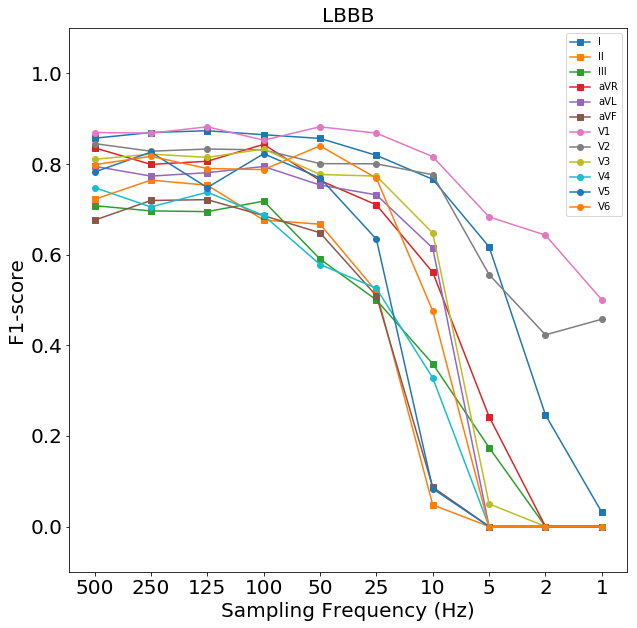

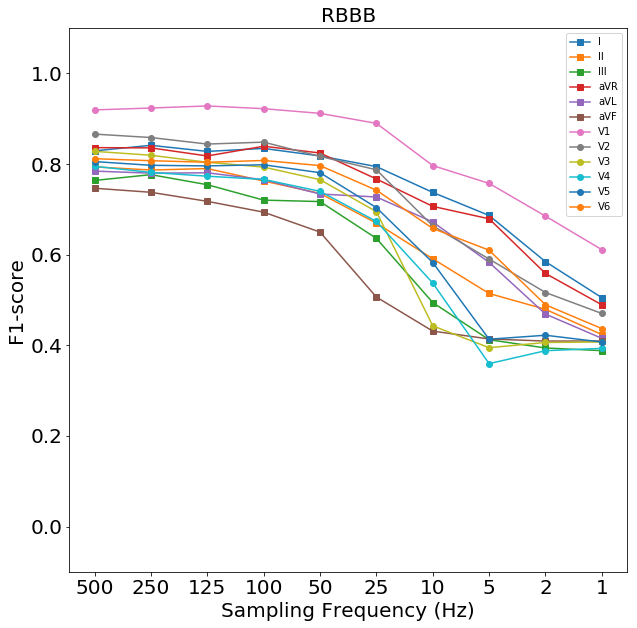

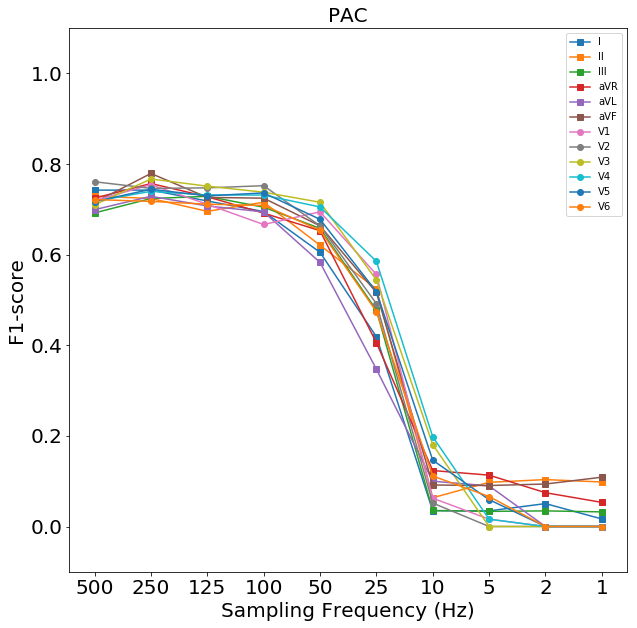

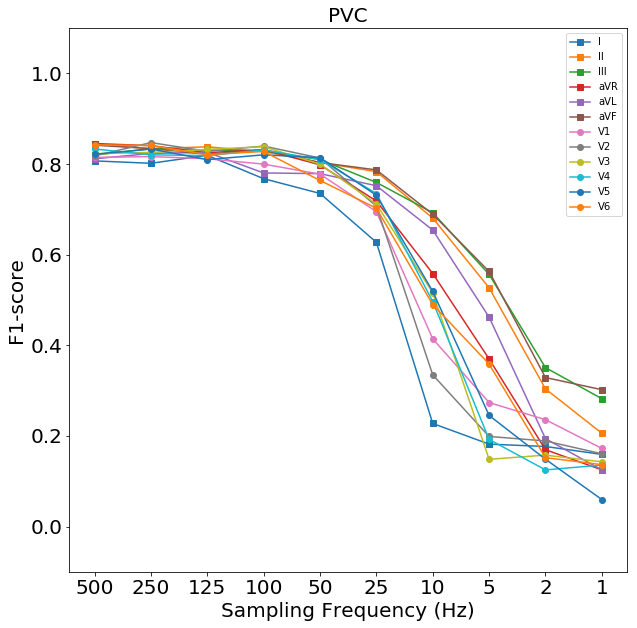

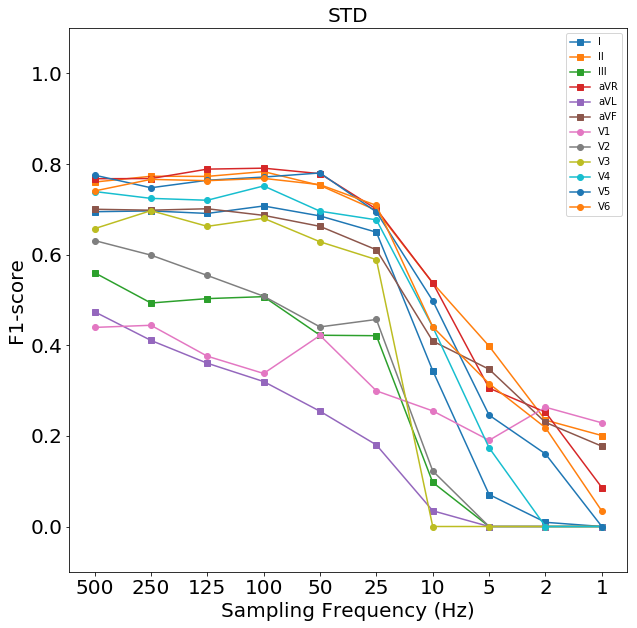

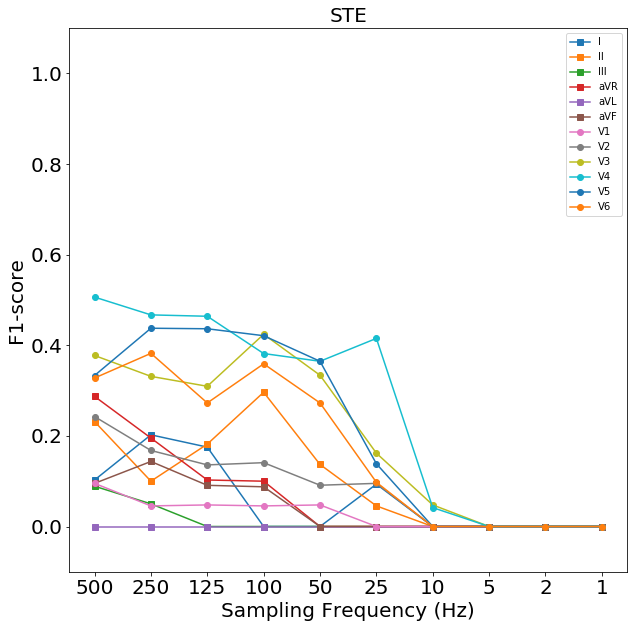

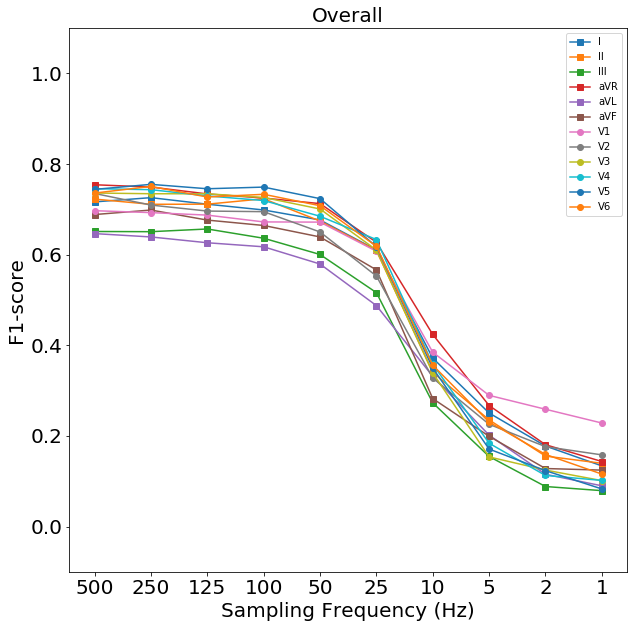

In [ ]:
#box-plotting
%matplotlib inline
BIGGER_SIZE = 20
Hz = np.asarray([500,250,125,100,50,25,10,5,2,1])
HzLabel = np.asarray(['500Hz','250Hz','150Hz','100Hz','50Hz','25Hz','10Hz','5Hz','2Hz','1Hz'])
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
titleList = ['Normal','AF', 'I-AVB','LBBB','RBBB','PAC','PVC','STD','STE','Overall']
for j in range(10):
    fig = plt.figure(figsize=(10,10))
    for i in range(12):
        if i not in TargetLead:
            continue
        scoreList_and_average = np.concatenate((np.load('./comparison/CPSC2018_10_fold_lead_models_test_result_lead_'+str(leadsLabel[i])+'.npy').T,np.asarray([np.mean(np.load('./comparison/CPSC2018_10_fold_lead_models_test_result_lead_'+str(leadsLabel[i])+'.npy'),axis =2).T])),axis = 0)[j]
        if i<6:
            plt.plot(np.median(scoreList_and_average,axis = 0).T.tolist(),'s-', label=leadsLabel[i])   # horizontal box aligmnent
        else:
            plt.plot(np.median(scoreList_and_average,axis = 0).T.tolist(),'o-', label=leadsLabel[i])   # horizontal box aligmnent

#         print(np.median(scoreList_and_average,axis = 0))
    plt.legend(loc='upper right')
    plt.xticks([x for x in range(len(Hz))],Hz, size=BIGGER_SIZE)
    plt.yticks(fontsize=BIGGER_SIZE)
    plt.ylim((-0.1, 1.1))
    plt.xlabel('Sampling Frequency (Hz)', size=BIGGER_SIZE)
    plt.ylabel('F1-score', size=BIGGER_SIZE)
    t = plt.title(titleList[j], size=BIGGER_SIZE)
    plt.show()


# Proposed SRECG Framework




In [ ]:
def residual_block(input, num_filters=64, kernel_size=16):
    x = Convolution1D(filters=num_filters,
               kernel_size=kernel_size,
               strides=1,
               padding='same',
               kernel_initializer='he_normal')(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Convolution1D(filters=num_filters,
               kernel_size=kernel_size,
               strides=1,
               padding='same',
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Add()([x, input])
    return x

def SubpixelConv1D(length, scale, number, **kwargs):
    def depth_to_width(x, scale):
        if number==1:
            width = length
        elif number==2:
            width = length*5
        n_channels = 64*scale
        x = tf.reshape(x, (-1, width, int(n_channels/scale), scale))
        x = tf.transpose(x, [0, 1, 3, 2])
        x = tf.reshape(x, (-1, int(width*scale), int(n_channels/scale)))
        return x
    return Lambda(lambda x: depth_to_width(x, scale), **kwargs)

def upsample(length, input, number, scale, num_filters=64, kernel_size=16):
    x = Convolution1D(filters=num_filters*scale,
               kernel_size=kernel_size,
               strides=1,
               padding='same',
               name='upSampleConv1D_'+str(number))(input)
    x = SubpixelConv1D(length, scale, number)(x)
    x = LeakyReLU(alpha=0.2, name='upSamplePReLU_'+str(number))(x)
    return x

def ecgsr(length, num_filters=64, num_res_blocks=16):
    x_in = Input(shape=(length, 1))
    x_start = Convolution1D(num_filters, kernel_size=16, strides=1, padding='same')(x_in)
    x_start = LeakyReLU(alpha=0.2)(x_start)
    r = residual_block(x_start, num_filters=64, kernel_size=16)
    for _ in range(num_res_blocks - 1):
        r = residual_block(r, num_filters=64, kernel_size=16)
    x = Convolution1D(64, kernel_size=16, strides=1, padding='same')(r)
    x = BatchNormalization()(x)
    x = Add()([x, x_start])
    x = upsample(length, x, 1, scale=5)
    x = upsample(length, x, 2, scale=2)
    sr_output = Convolution1D(1, kernel_size=16, strides=1, padding='same')(x)
    return Model(inputs=x_in, outputs=sr_output)
model = ecgsr(3600, num_filters=64, num_res_blocks=16)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3600, 1)]            0         []                            
                                                                                                  
 conv1d_15 (Conv1D)          (None, 3600, 64)             1088      ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)  (None, 3600, 64)             0         ['conv1d_15[0][0]']           
                                                                                                  
 conv1d_16 (Conv1D)          (None, 3600, 64)             65600     ['leaky_re_lu_17[0][0]']      
                                                                                            

# SRECG Framework Training and 10-fold Cross Validation

In [ ]:
#10-fold training for Reconstructed 25 Hz +cce +mse
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
FoldIndicesList = np.load('./FoldIndicesList.npy')
b_weight =  [0.5,0.5]
lr = 0.0001
for j in range(12):
    if j not in TargetLead:
        continue
    for i in range(10):
        def f1(y_true, y_pred2):
            metric_model = MetforNet121(36000)
            metric_model.load_weights("./benchmark/CPSC2018_10_fold_model_lead_"+str(leadsLabel[j])+"_Hz_250_fold_"+str(i))
            y_tr = metric_model(y_true)
            y_pr2 = metric_model(y_pred2)
            y_tr = K.one_hot(K.argmax(y_tr), num_classes=num_classes)
            y_pr = K.one_hot(K.argmax(y_pr2), num_classes=num_classes)
            def recall(y_true, y_pred):
                true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
                possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
                recall = true_positives / (possible_positives + K.epsilon())
                return recall
            def precision(y_true, y_pred):
                true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
                predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
                precision = true_positives / (predicted_positives + K.epsilon())
                return precision
            precision = precision(y_tr, y_pr)
            recall = recall(y_tr, y_pr)
            return 2*((precision*recall)/(precision+recall+K.epsilon()))

        def mfn121_loss(y_true, y_pred):
            metric_model = MetforNet121(36000)
            metric_model.load_weights("./benchmark/CPSC2018_10_fold_model_lead_"+str(leadsLabel[j])+"_Hz_250_fold_"+str(i))
            # Make trainable as False
            metric_model.trainable = False
            for layer in metric_model.layers:
                layer.trainable = False
            y_tr = metric_model(y_true)
            y_pr = metric_model(y_pred)
            return b_weight[0]*categorical_crossentropy(y_tr, y_pr) + b_weight[1]*K.mean(K.square(y_true-y_pred))

        model_name = './combined/CPSC2018_25HzTo250HzRecover_10_fold_model_lead_'+str(leadsLabel[j])+'_fold_'+str(i)
        x_train_from_train = X_list[selectedSampled[9]][np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
        x_val_from_train = X_list[selectedSampled[9]][FoldIndicesList[i-1][1]]
        y_train_from_train,_ = Step(x_train_from_train[:,:,j:j+1],500//250)
        y_val_from_train,_ = Step(x_val_from_train[:,:,j:j+1],500//250)
        x_train_from_train, length = Step(x_train_from_train[:,:,j:j+1],500//25)
        x_val_from_train, length = Step(x_val_from_train[:,:,j:j+1],500//25)

        model = ecgsr(length, num_filters=64, num_res_blocks=16, up_scaling=10)

        opt = keras.optimizers.Adam(lr=lr)
        model.compile(loss= mfn121_loss,
                      optimizer=opt,
                      metrics=[f1])
        checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
        model_history = model.fit( x_train_from_train, y_train_from_train,
                                  batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpointer],
                                 validation_data=(x_val_from_train, y_val_from_train))

In [ ]:
#10-fold training for Reconstructed 25 Hz +cce
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
FoldIndicesList = np.load('./FoldIndicesList.npy')
b_weight =  [1,0]
lr = 0.0001
for j in range(12):
    if j not in TargetLead:
        continue
    for i in range(10):
        def f1(y_true, y_pred2):
            metric_model = MetforNet121(36000)
            metric_model.load_weights("./benchmark/CPSC2018_10_fold_model_lead_"+str(leadsLabel[j])+"_Hz_250_fold_"+str(i))
            y_tr = metric_model(y_true)
            y_pr2 = metric_model(y_pred2)
            y_tr = K.one_hot(K.argmax(y_tr), num_classes=num_classes)
            y_pr = K.one_hot(K.argmax(y_pr2), num_classes=num_classes)
            def recall(y_true, y_pred):
                true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
                possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
                recall = true_positives / (possible_positives + K.epsilon())
                return recall
            def precision(y_true, y_pred):
                true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
                predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
                precision = true_positives / (predicted_positives + K.epsilon())
                return precision
            precision = precision(y_tr, y_pr)
            recall = recall(y_tr, y_pr)
            return 2*((precision*recall)/(precision+recall+K.epsilon()))

        def mfn121_loss(y_true, y_pred):
            metric_model = MetforNet121(36000)
            metric_model.load_weights("./benchmark/CPSC2018_10_fold_model_lead_"+str(leadsLabel[j])+"_Hz_250_fold_"+str(i))
            # Make trainable as False
            metric_model.trainable = False
            for layer in metric_model.layers:
                layer.trainable = False
            y_tr = metric_model(y_true)
            y_pr = metric_model(y_pred)
            return b_weight[0]*categorical_crossentropy(y_tr, y_pr) + b_weight[1]*K.mean(K.square(y_true-y_pred))

        model_name = './combined/CPSC2018_25HzTo250HzRecoverCCEonly_10_fold_model_lead_'+str(leadsLabel[j])+'_fold_'+str(i)
        x_train_from_train = X_list[selectedSampled[9]][np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
        x_val_from_train = X_list[selectedSampled[9]][FoldIndicesList[i-1][1]]
        y_train_from_train,_ = Step(x_train_from_train[:,:,j:j+1],500//250)
        y_val_from_train,_ = Step(x_val_from_train[:,:,j:j+1],500//250)
        x_train_from_train, length = Step(x_train_from_train[:,:,j:j+1],500//25)
        x_val_from_train, length = Step(x_val_from_train[:,:,j:j+1],500//25)

        model = ecgsr(length, num_filters=64, num_res_blocks=16, up_scaling=10)

        opt = keras.optimizers.Adam(lr=lr)
        model.compile(loss= mfn121_loss,
                      optimizer=opt,
                      metrics=[f1])
        checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
        model_history = model.fit( x_train_from_train, y_train_from_train,
                                  batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpointer],
                                 validation_data=(x_val_from_train, y_val_from_train))

In [ ]:
#10-fold training for Reconstructed 25 Hz +mse
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
FoldIndicesList = np.load('./FoldIndicesList.npy')
b_weight =  [0,1]
lr = 0.0001
for j in range(12):
    if j not in TargetLead:
        continue
    for i in range(10):
        def f1(y_true, y_pred2):
            metric_model = MetforNet121(36000)
            metric_model.load_weights("./benchmark/CPSC2018_10_fold_model_lead_"+str(leadsLabel[j])+"_Hz_250_fold_"+str(i))
            y_tr = metric_model(y_true)
            y_pr2 = metric_model(y_pred2)
            y_tr = K.one_hot(K.argmax(y_tr), num_classes=num_classes)
            y_pr = K.one_hot(K.argmax(y_pr2), num_classes=num_classes)
            def recall(y_true, y_pred):
                true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
                possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
                recall = true_positives / (possible_positives + K.epsilon())
                return recall
            def precision(y_true, y_pred):
                true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
                predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
                precision = true_positives / (predicted_positives + K.epsilon())
                return precision
            precision = precision(y_tr, y_pr)
            recall = recall(y_tr, y_pr)
            return 2*((precision*recall)/(precision+recall+K.epsilon()))

        def mfn121_loss(y_true, y_pred):
            metric_model = MetforNet121(36000)
            metric_model.load_weights("./benchmark/CPSC2018_10_fold_model_lead_"+str(leadsLabel[j])+"_Hz_250_fold_"+str(i))
            # Make trainable as False
            metric_model.trainable = False
            for layer in metric_model.layers:
                layer.trainable = False
            y_tr = metric_model(y_true)
            y_pr = metric_model(y_pred)
            return b_weight[0]*categorical_crossentropy(y_tr, y_pr) + b_weight[1]*K.mean(K.square(y_true-y_pred))

        model_name = './mse/CPSC2018_25HzTo250HzRecoverMSEonly_10_fold_model_lead_'+str(leadsLabel[j])+'_fold_'+str(i)
        x_train_from_train = X_list[selectedSampled[9]][np.setdiff1d(FoldIndicesList[i][0],FoldIndicesList[i-1][1])]
        x_val_from_train = X_list[selectedSampled[9]][FoldIndicesList[i-1][1]]
        y_train_from_train,_ = Step(x_train_from_train[:,:,j:j+1],500//250)
        y_val_from_train,_ = Step(x_val_from_train[:,:,j:j+1],500//250)
        x_train_from_train, length = Step(x_train_from_train[:,:,j:j+1],500//25)
        x_val_from_train, length = Step(x_val_from_train[:,:,j:j+1],500//25)

        model = ecgsr(length, num_filters=64, num_res_blocks=16, up_scaling=10)

        opt = keras.optimizers.Adam(lr=lr)
        model.compile(loss= mfn121_loss,
                      optimizer=opt,
                      metrics=[f1])
        checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
        model_history = model.fit( x_train_from_train, y_train_from_train,
                                  batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[checkpointer],
                                 validation_data=(x_val_from_train, y_val_from_train))

# SRECG Reconstructing The 10-fold Test Sets

In [ ]:
#Cross-validation on test set
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
Types = ['Down-sampled 25 Hz', 'Reconstructed 25 Hz +cce', 'Reconstructed 25 Hz +mse', 'Reconstructed 25 Hz +cce +mse', 'Original 250 Hz']
Hz = np.asarray([500,250,125,100,50,25,10,5,2,1])
FoldIndicesList = np.load('./FoldIndicesList.npy')
x_test_from_train = X_list[selectedSampled[9]].copy()
x_test_from_train_original, length_original = Step(x_test_from_train,500//Hz[1])
x_test_from_train_downSampled, length_downSampled = Step(x_test_from_train,500//Hz[5])
model = MetforNet121(36000)
model_SR = ecgsr(3600, num_filters=64, num_res_blocks=16)
model_25 = MetforNet121(3600)
for j in range(12):
    if j not in TargetLead:
        continue
    TypeList = []
    for k in tqdm(Types):
        scoreList = []
        for i in range(10):
            model_name = './benchmark/CPSC2018_10_fold_model_lead_'+str(leadsLabel[j])+'_Hz_'+str(Hz[1])+'_fold_'+str(i)
            model.load_weights(model_name)
            if k == 'Original 250 Hz' :
                x_test_from_train_temp = x_test_from_train_original[FoldIndicesList[i][1]][:,:,j:j+1]

            elif k == 'Reconstructed 25 Hz +cce +mse' :
                model_SR_name = './combined/CPSC2018_25HzTo250HzRecover_10_fold_model_lead_'+str(leadsLabel[j])+'_fold_'+str(i)
                model_SR.load_weights(model_SR_name)
                x_test_from_train_temp = model_SR.predict(x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1])
            elif k == 'Reconstructed 25 Hz +cce' :
                model_SR_name = './cce/CPSC2018_25HzTo250HzRecoverCCEonly_10_fold_model_lead_'+str(leadsLabel[j])+'_fold_'+str(i)
                model_SR.load_weights(model_SR_name)
                x_test_from_train_temp = model_SR.predict(x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1])
            elif k == 'Reconstructed 25 Hz +mse' :
                model_SR_name = './mse/CPSC2018_25HzTo250HzRecoverMSEonly_10_fold_model_lead_'+str(leadsLabel[j])+'_fold_'+str(i)
                model_SR.load_weights(model_SR_name)
                x_test_from_train_temp = model_SR.predict(x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1])

            elif k == 'Down-sampled 25 Hz' :
                model_25_name = './benchmark/CPSC2018_10_fold_model_lead_'+str(leadsLabel[j])+'_Hz_'+str(Hz[5])+'_fold_'+str(i)
                model_25.load_weights(model_25_name)
                x_test_from_train_temp = x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1]
                y_test_from_train = Y_list[selectedSampled[9]][FoldIndicesList[i][1]].copy()
                y_true = np.argmax(y_test_from_train, axis=1)
                y_raw_pred = model_25.predict(x_test_from_train_temp)
                y_pred = np.argmax(y_raw_pred, axis=1)
                score = f1_score(y_true, y_pred, average=None)
                scoreList.append(score)
                continue
            else:
                print('Error_happpend !!!')
            y_test_from_train = Y_list[selectedSampled[9]][FoldIndicesList[i][1]].copy()
            y_true = np.argmax(y_test_from_train, axis=1)
            y_raw_pred = model.predict(x_test_from_train_temp)
            y_pred = np.argmax(y_raw_pred, axis=1)
            score = f1_score(y_true, y_pred, average=None)
            scoreList.append(score)
        scoreList = np.asarray(scoreList)
        TypeList.append(scoreList)
    TypeList = np.asarray(TypeList)
    np.save('./comparison/CPSC2018_25HzTo250HzRecover_10_fold_lead_models_test_result_lead_new_lossComparison'+str(leadsLabel[j]),TypeList)

Lead :I


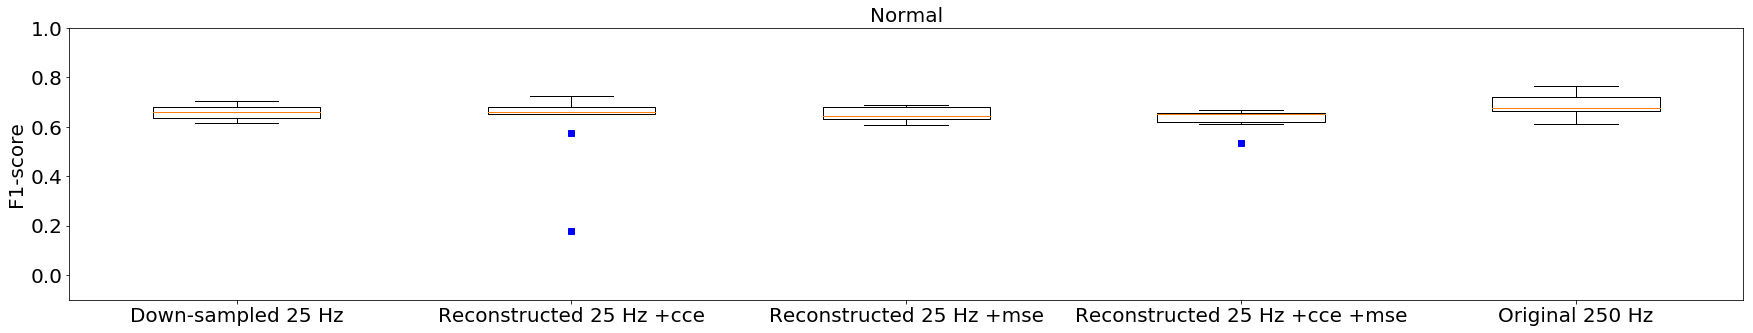

[0.6617033  0.65986342 0.64292706 0.65055504 0.67628377]
nan*
nan**
68#**
[0.06211757 0.12835675 0.01016369 0.00160662 1.        ]


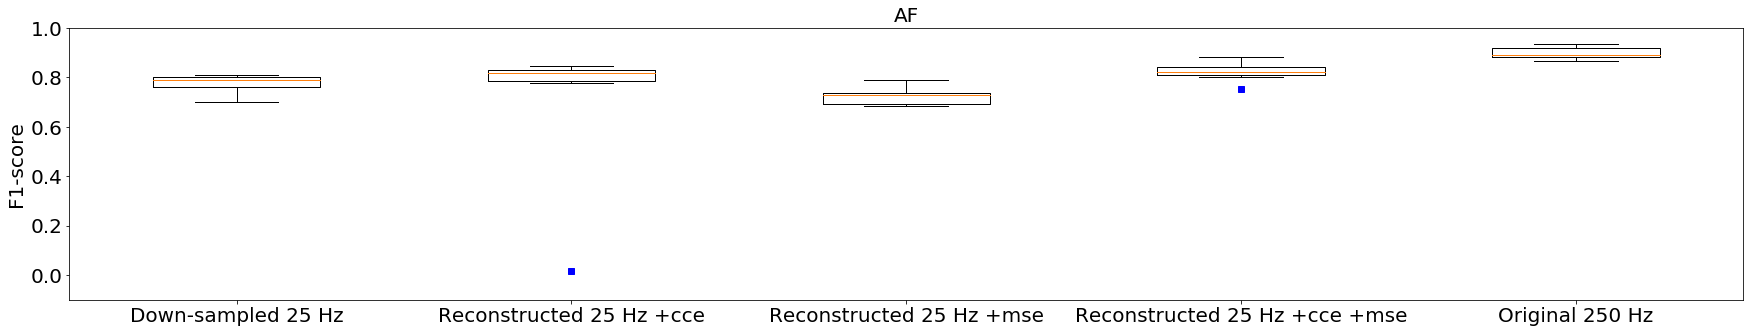

[0.78775383 0.8163513  0.72758895 0.8202381  0.889989  ]
nan*
nan**
44#**
[2.72284482e-05 8.47427953e-02 4.93221111e-08 3.89722160e-06
 1.00000000e+00]


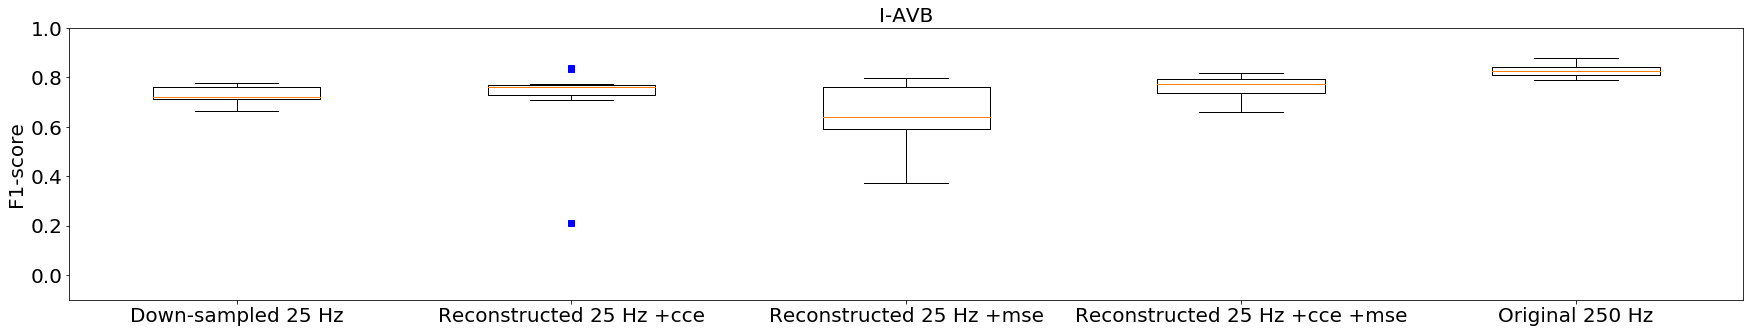

[0.72076023 0.76228907 0.63937813 0.77534386 0.82623733]
nan*
nan**
34#**
[1.11607806e-05 6.20062646e-02 9.96147906e-04 1.77548012e-03
 1.00000000e+00]


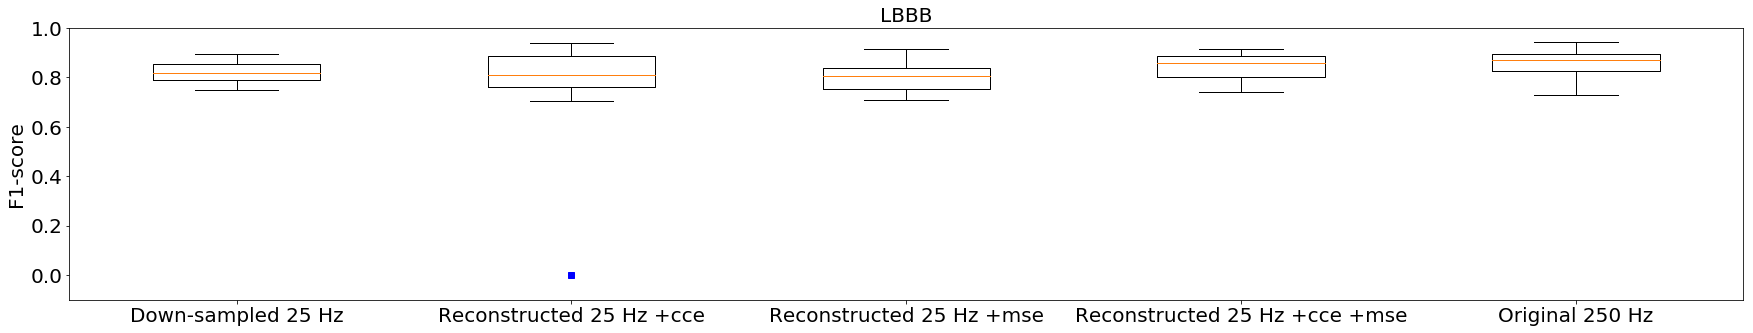

[0.81935484 0.81176471 0.80540541 0.85667486 0.8697479 ]
nan*
nan**
3#
[0.06380086 0.24175945 0.00151954 0.28374051 1.        ]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide


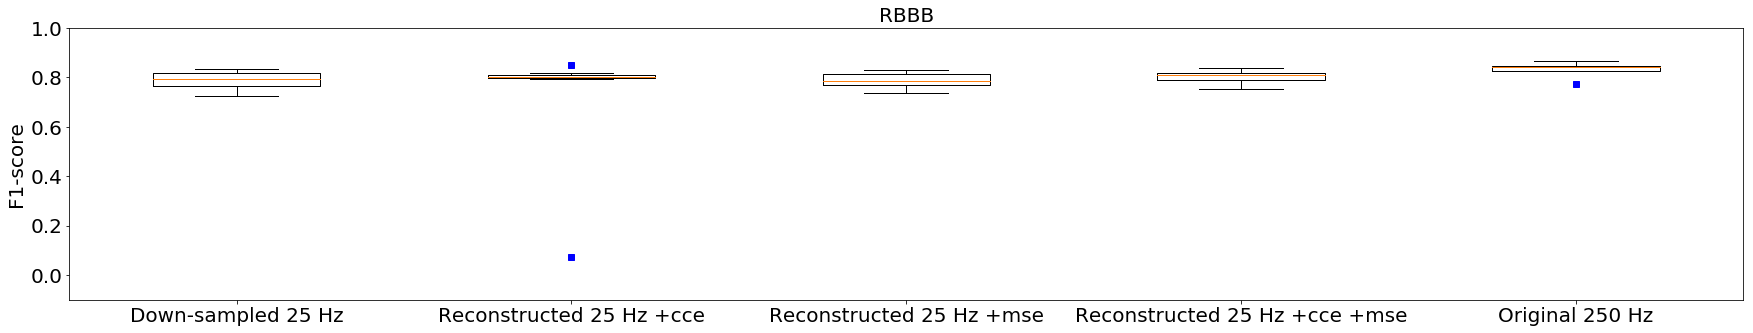

[0.79449634 0.80284214 0.78699395 0.80852669 0.8414489 ]
nan*
nan**
63#**
[1.69206196e-04 1.69738236e-01 1.46322163e-05 9.46227214e-04
 1.00000000e+00]


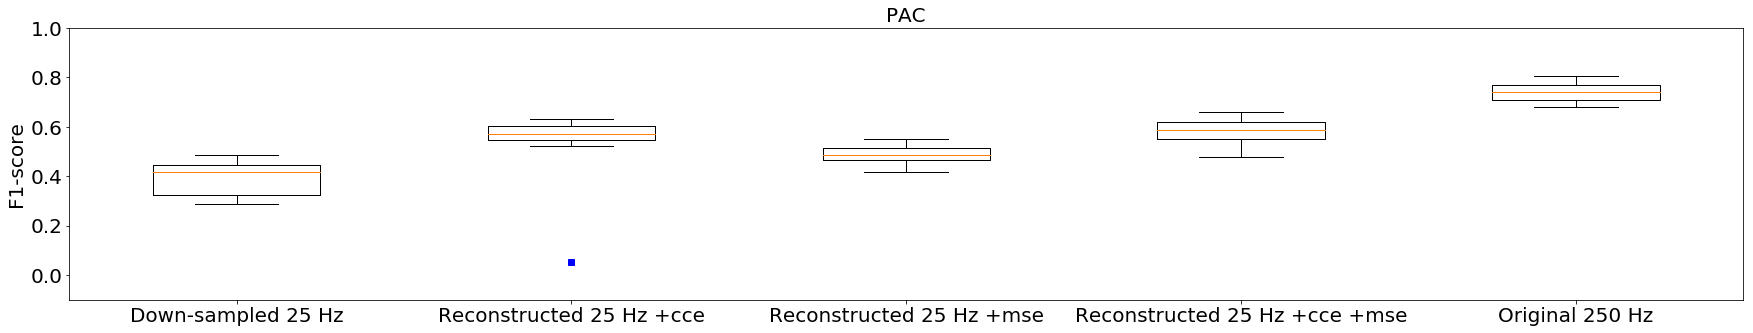

[0.4190319  0.56916329 0.48643909 0.58624964 0.74252137]
nan*
nan**
61#**
[4.22666608e-07 4.72736809e-03 2.50638166e-09 8.44607047e-07
 1.00000000e+00]


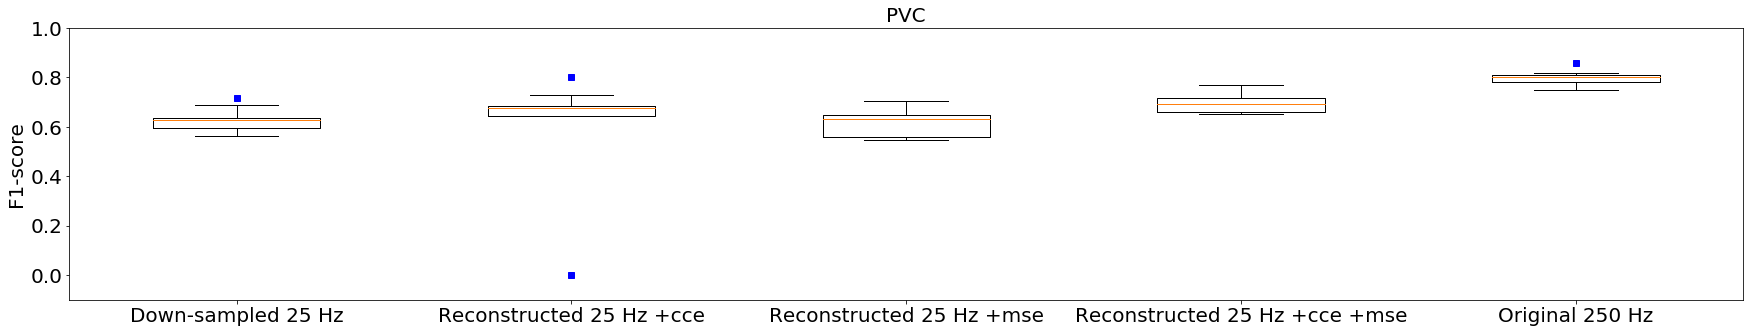

[0.62730769 0.67567568 0.63349713 0.69080688 0.80178571]
nan*
nan**
59#**
[9.70154670e-08 2.51366145e-02 5.07901189e-07 2.36614579e-06
 1.00000000e+00]


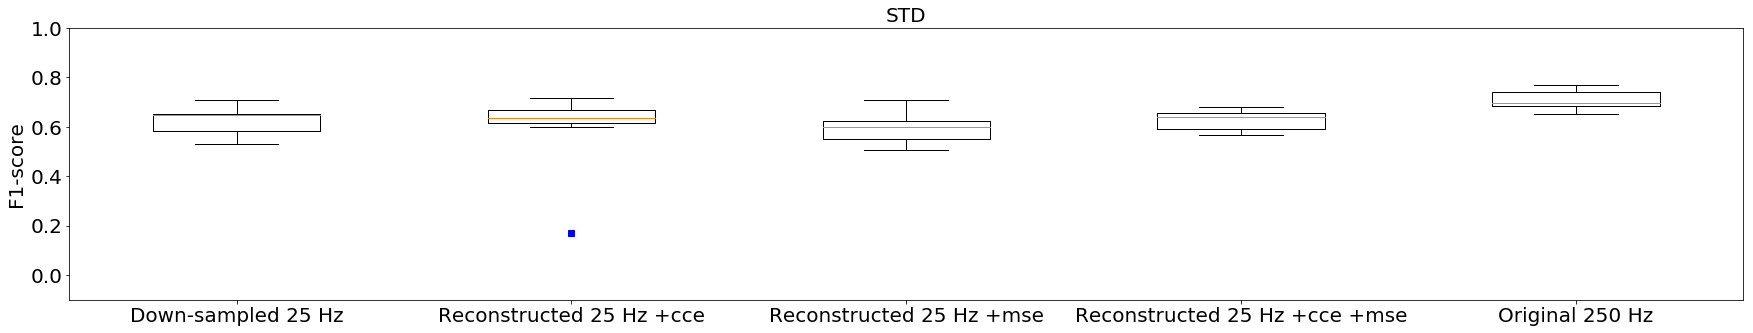

[0.64968153 0.6375     0.60099424 0.63857068 0.6966734 ]
nan*
nan**
50#**
[3.92261285e-04 4.98214702e-02 3.74478616e-04 1.02575699e-03
 1.00000000e+00]


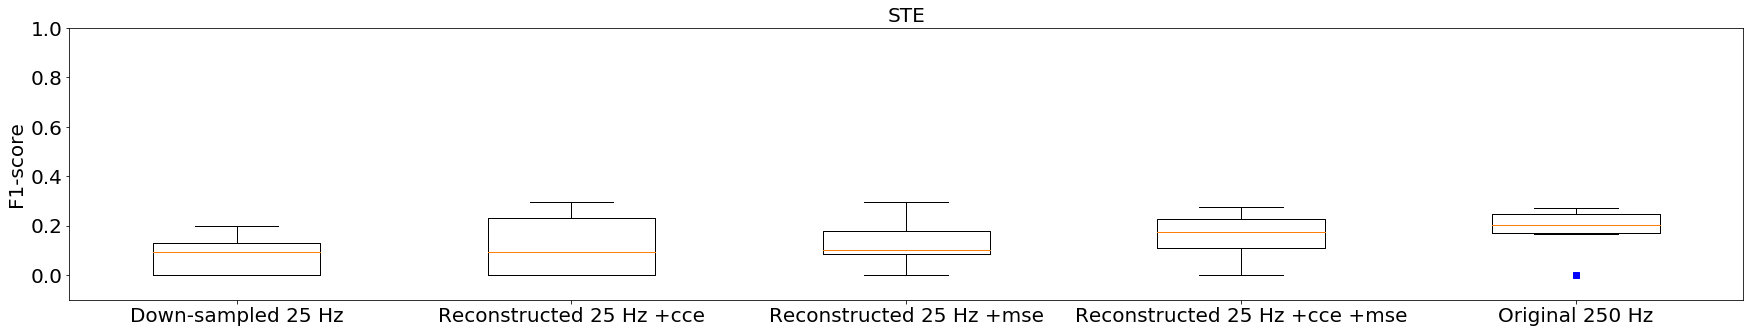

[0.09347826 0.09307359 0.10263158 0.17424242 0.20234114]
nan*
nan**
0#
[0.01824296 0.11307204 0.09676816 0.169042   1.        ]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


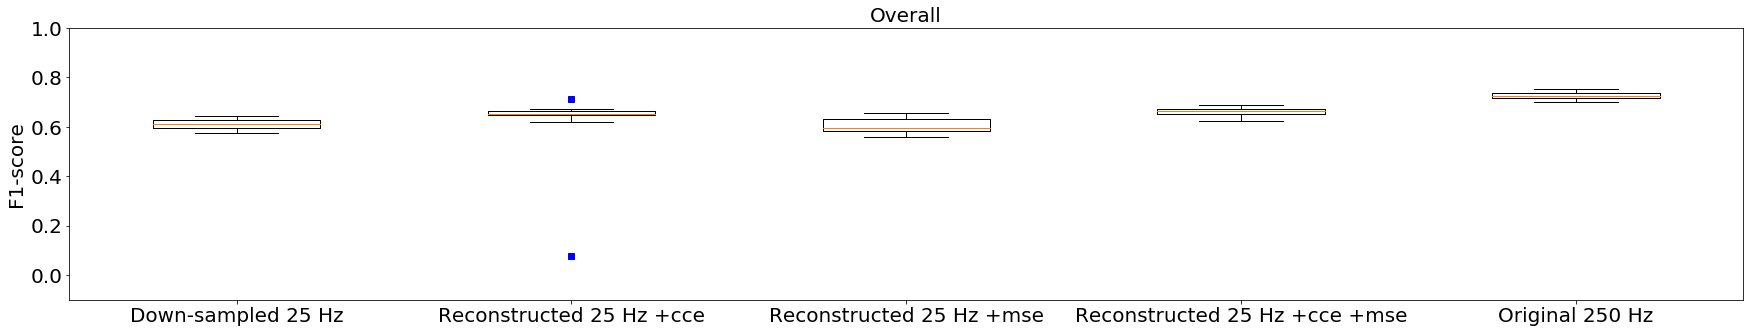

[0.61048655 0.65287981 0.59719255 0.66259268 0.72594606]
nan*
nan**
57#**
[5.21396770e-08 5.61816467e-02 6.24203633e-07 3.86505278e-07
 1.00000000e+00]
Lead :II


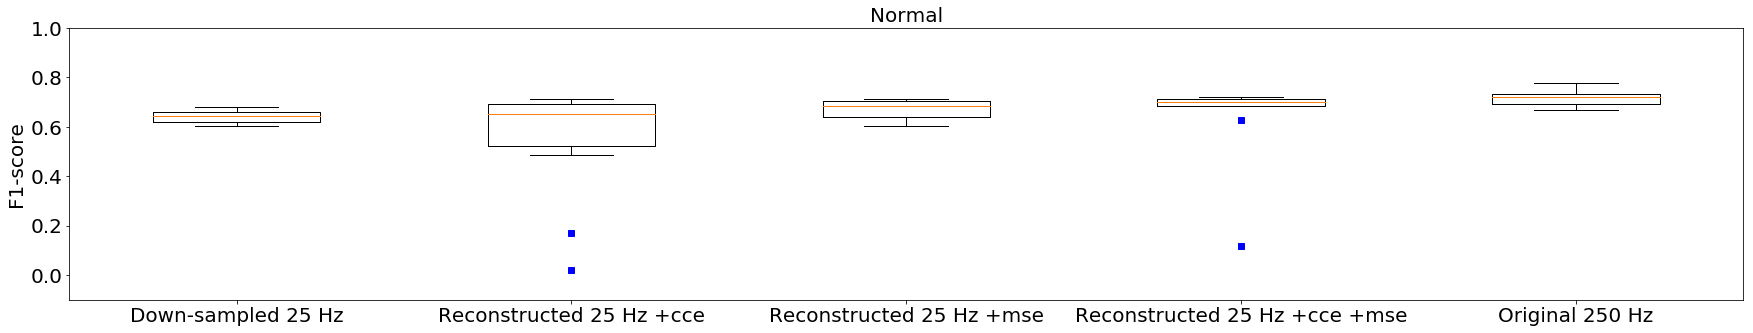

[0.6420339  0.65078663 0.68613331 0.69981772 0.72112429]
nan*
nan**
60#
[3.90538506e-04 5.20301543e-02 4.01599543e-03 2.40129947e-01
 1.00000000e+00]


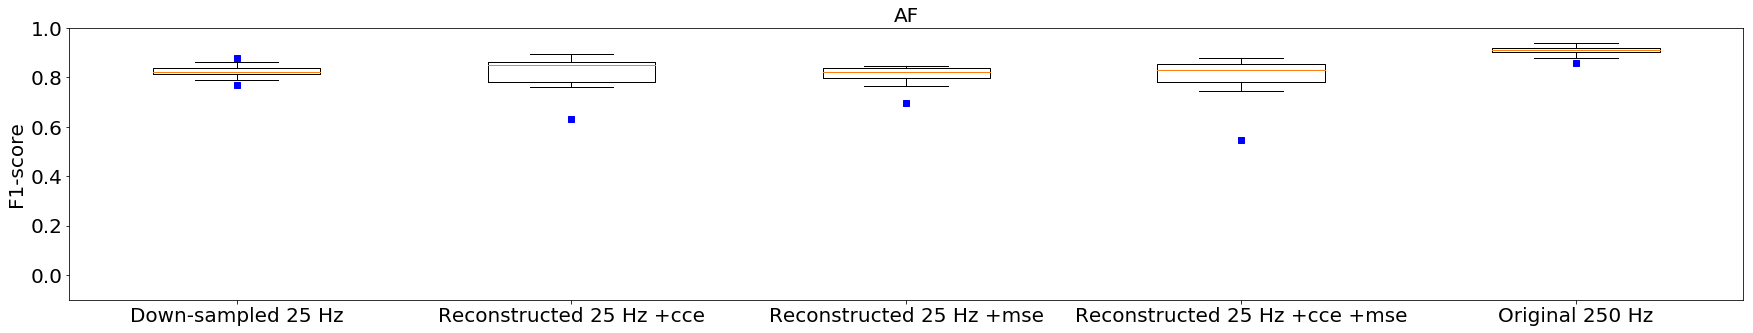

[0.82224381 0.85221675 0.82271938 0.82994553 0.91287879]
nan*
nan**
79#**
[2.23379254e-06 1.28441358e-03 3.78275203e-05 7.72594676e-03
 1.00000000e+00]


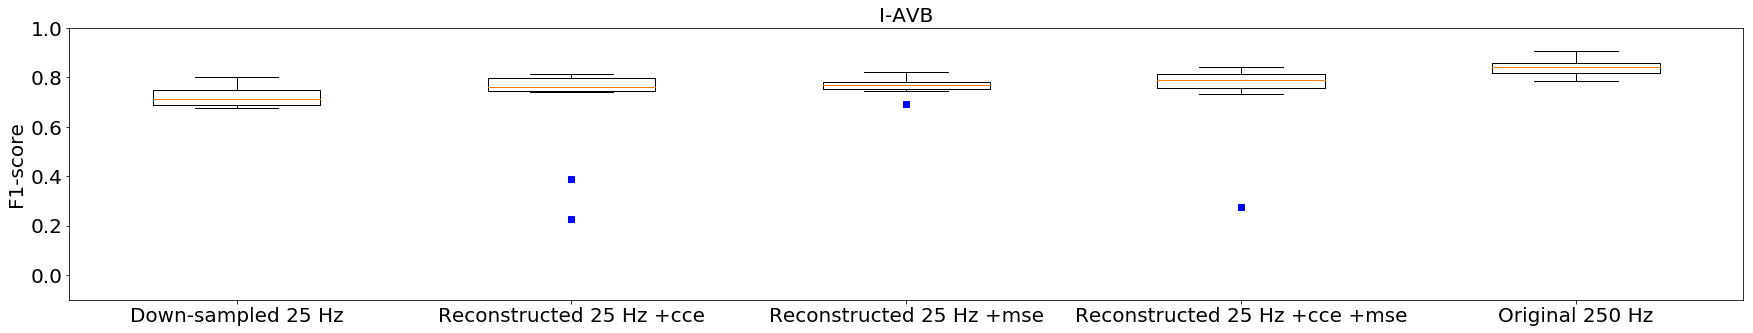

[0.71240679 0.76071429 0.76944972 0.79034874 0.84067202]
nan*
nan**
68#
[4.21052277e-05 4.57617685e-02 1.39364608e-05 5.98571108e-02
 1.00000000e+00]


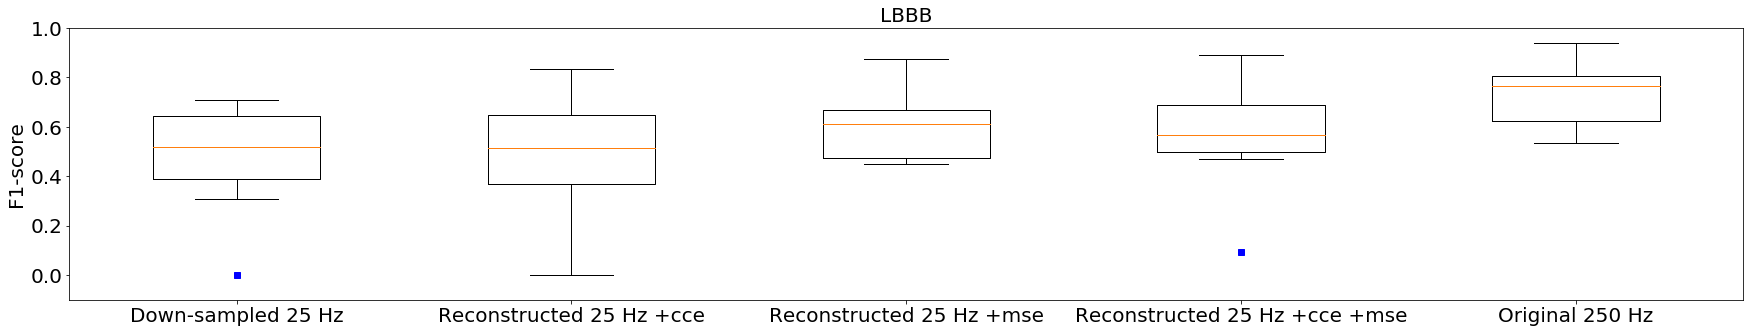

[0.51923077 0.51633987 0.6125     0.56618465 0.76470588]
nan*
nan**
83#*
[8.76159299e-03 1.37570458e-02 4.11893254e-05 2.35313337e-02
 1.00000000e+00]


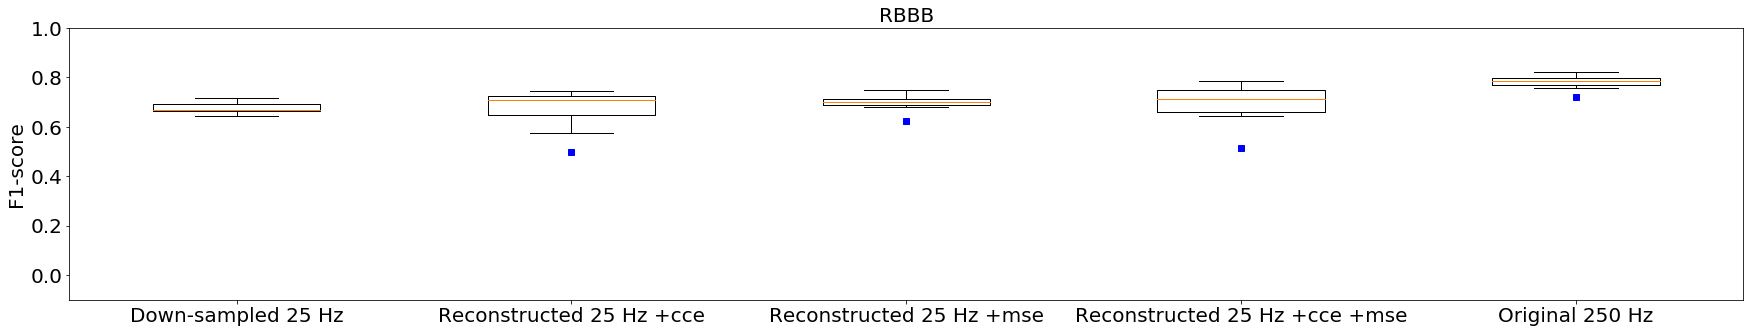

[0.66974866 0.70791868 0.69962141 0.71303452 0.78691893]
nan*
nan**
95#**
[2.50218223e-06 2.86668323e-03 3.48878902e-05 6.53140945e-03
 1.00000000e+00]


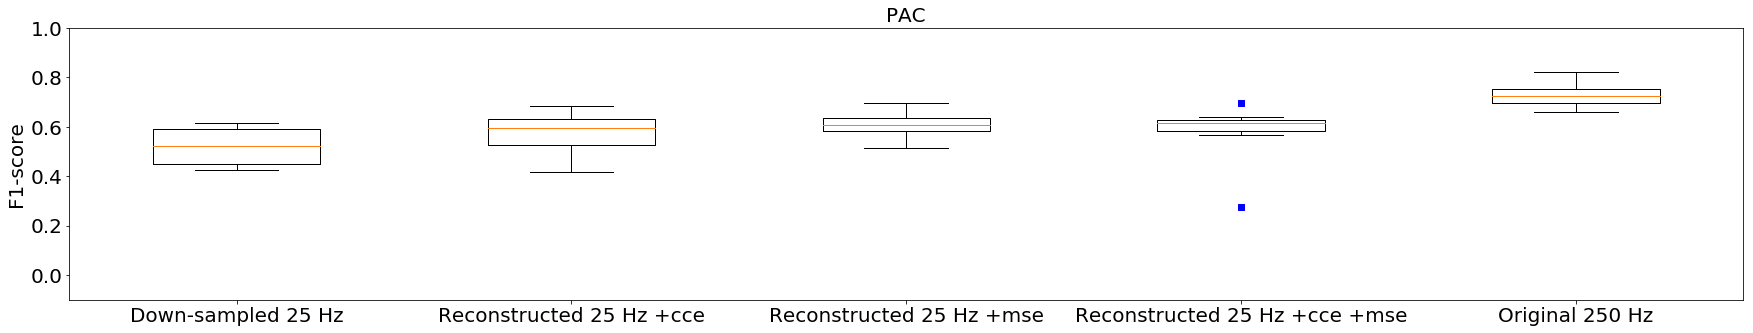

[0.5244153  0.59501754 0.60929617 0.61697066 0.72413793]
nan*
nan**
103#**
[1.93148271e-05 5.95129057e-04 1.40249250e-05 1.22492240e-03
 1.00000000e+00]


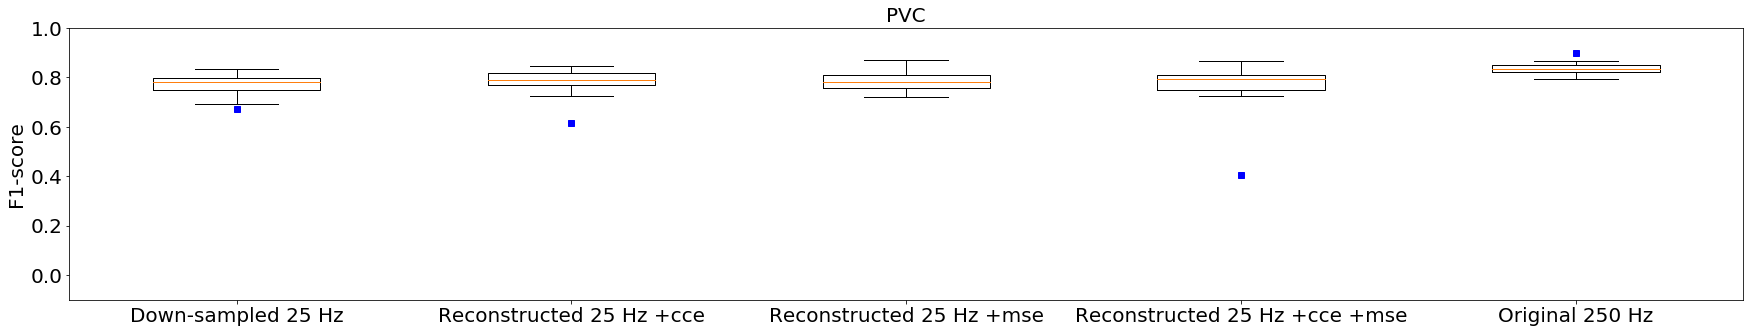

[0.78330435 0.79150971 0.78139159 0.79237892 0.83405766]
nan*
nan**
114#
[1.57747115e-03 1.08468131e-02 1.74967016e-04 6.44859217e-02
 1.00000000e+00]


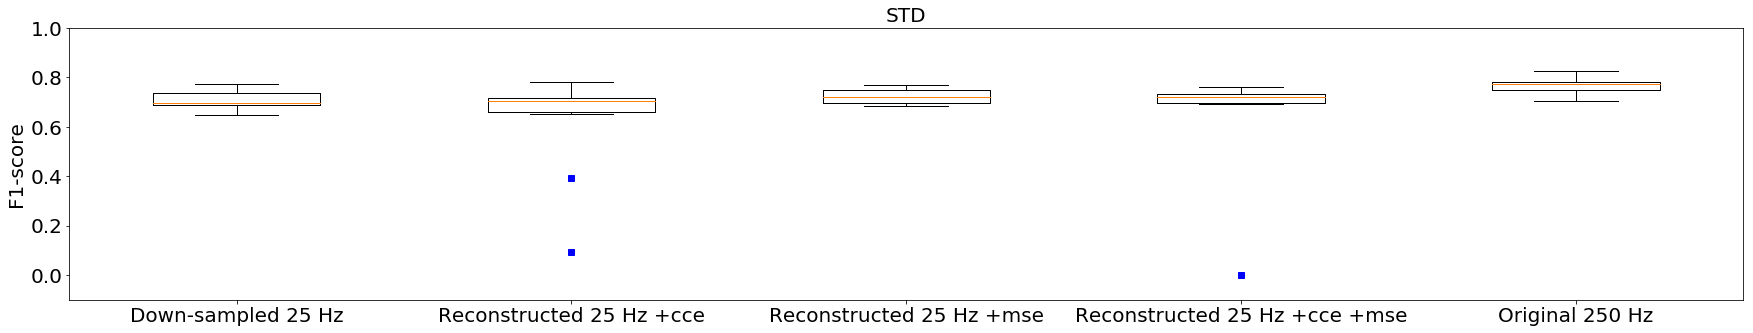

[0.6978801  0.70416667 0.72141436 0.72141436 0.77317203]
nan*
nan**
78#
[1.20644222e-03 6.43004193e-02 5.46241673e-04 1.44479447e-01
 1.00000000e+00]


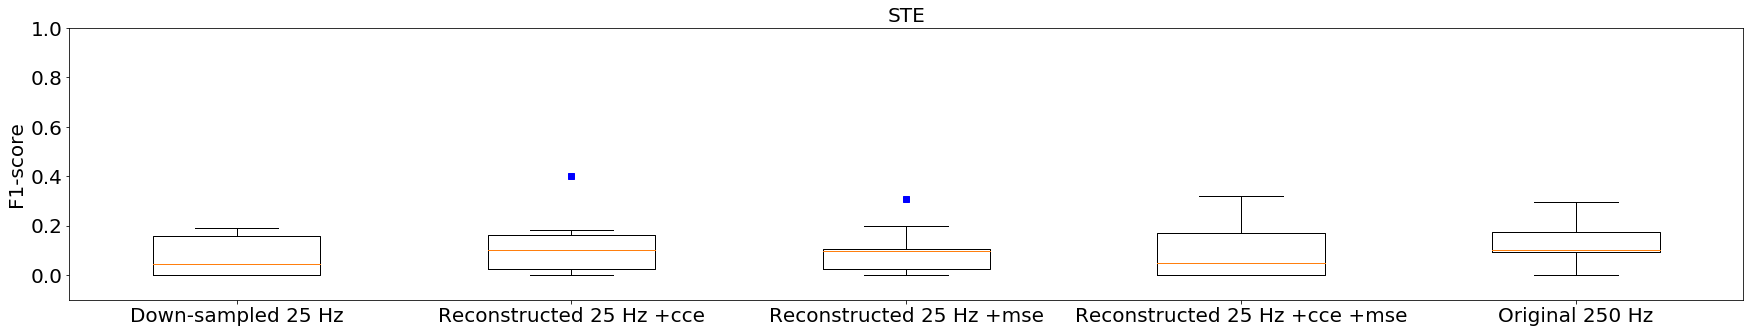

[0.04545455 0.1        0.09761905 0.05       0.1       ]
nan*
nan**
0#
[0.35637211 0.88616902 0.53030238 0.5989944  1.        ]


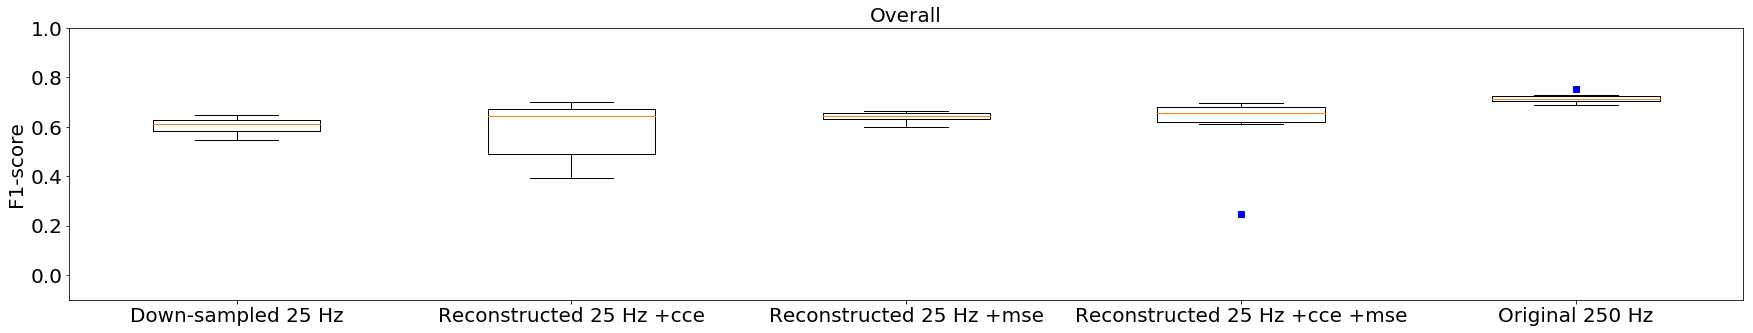

[0.60950974 0.64349916 0.64412983 0.65692979 0.71125376]
nan*
nan**
88#*
[1.83173652e-05 9.18352110e-03 7.26152189e-07 3.66870918e-02
 1.00000000e+00]
Lead :III


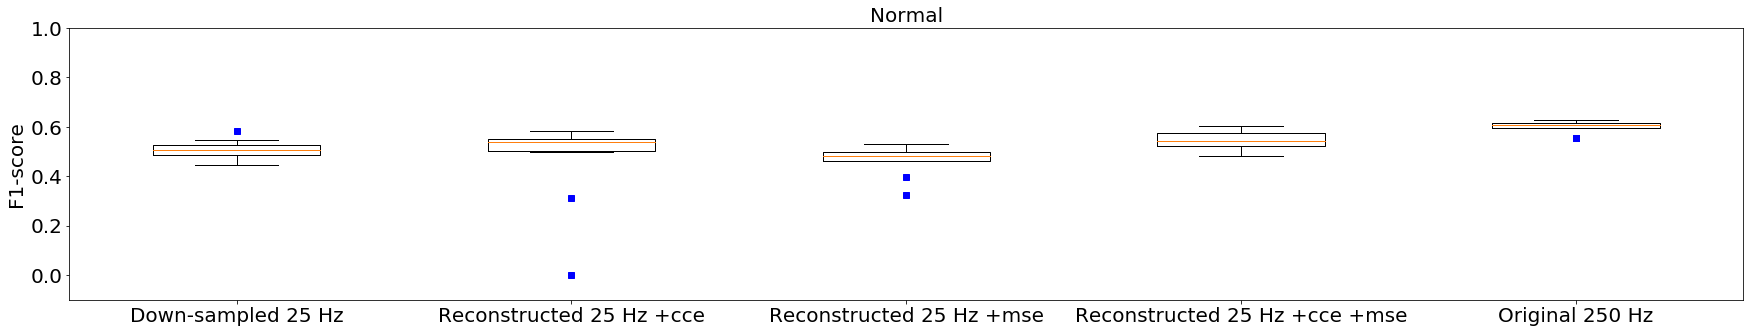

[0.50609756 0.53919622 0.48319328 0.54270362 0.60618698]
nan*
nan**
39#**
[9.60917675e-05 4.59329572e-02 3.31982274e-04 5.79125462e-04
 1.00000000e+00]


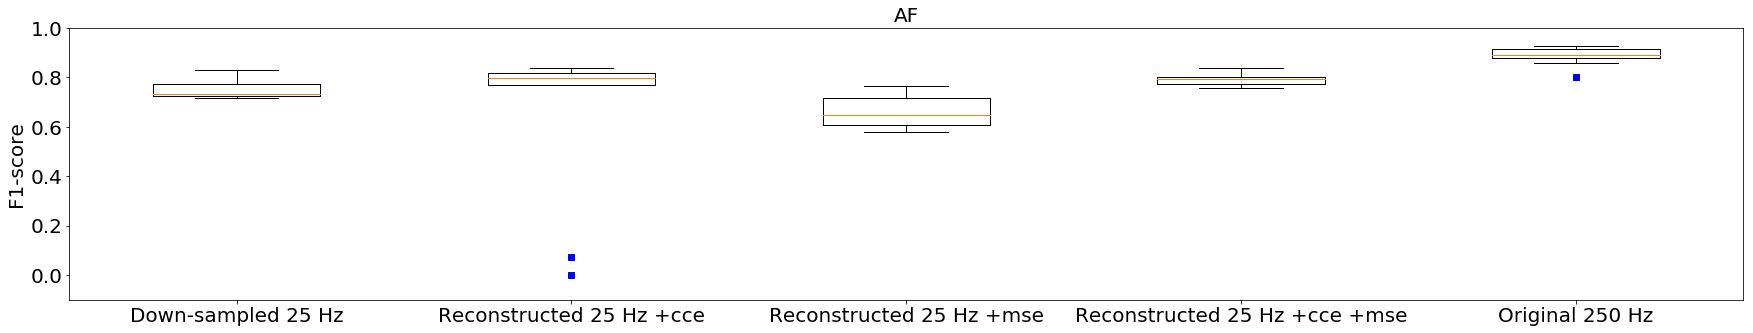

[0.73439503 0.79903846 0.64690848 0.79242081 0.89265804]
nan*
nan**
41#**
[4.63204379e-06 3.73976501e-02 2.47658528e-06 4.37817387e-06
 1.00000000e+00]


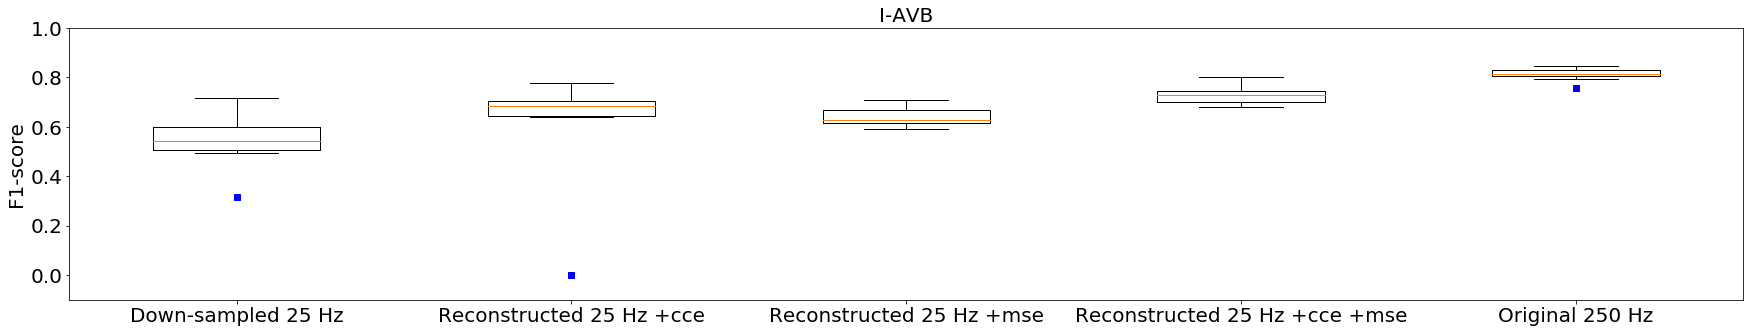

[0.54316269 0.68365658 0.62763587 0.72785518 0.81215006]
nan*
nan**
49#**
[5.46603877e-05 2.65768890e-02 1.81879109e-07 1.05800966e-04
 1.00000000e+00]


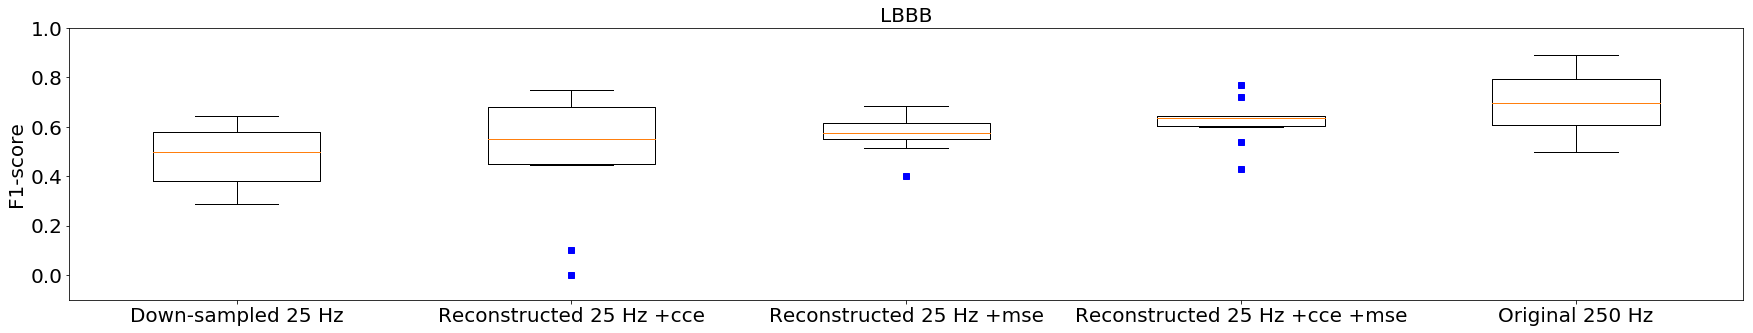

[0.5        0.54923077 0.57334145 0.63392857 0.69669118]
nan*
nan**
71#
[0.00188695 0.03667733 0.01075279 0.05113664 1.        ]


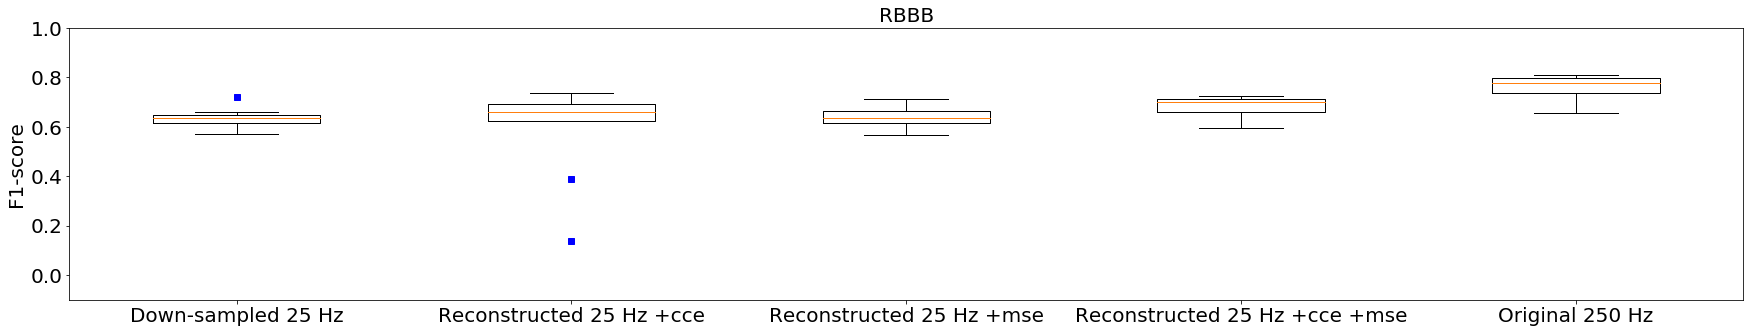

[0.6360412  0.65957416 0.63732993 0.69944238 0.77670049]
nan*
nan**
69#**
[4.44414838e-05 1.57357962e-02 2.51818022e-06 9.73229652e-05
 1.00000000e+00]


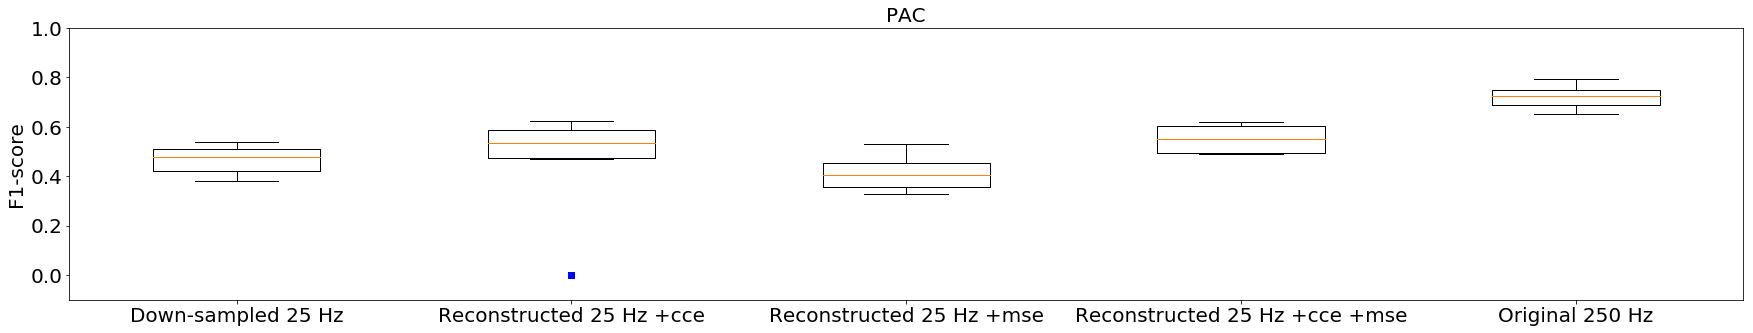

[0.47783897 0.53290984 0.40559294 0.55009954 0.72399672]
nan*
nan**
57#**
[2.51045164e-08 3.72456129e-03 1.60623258e-08 4.35836072e-06
 1.00000000e+00]


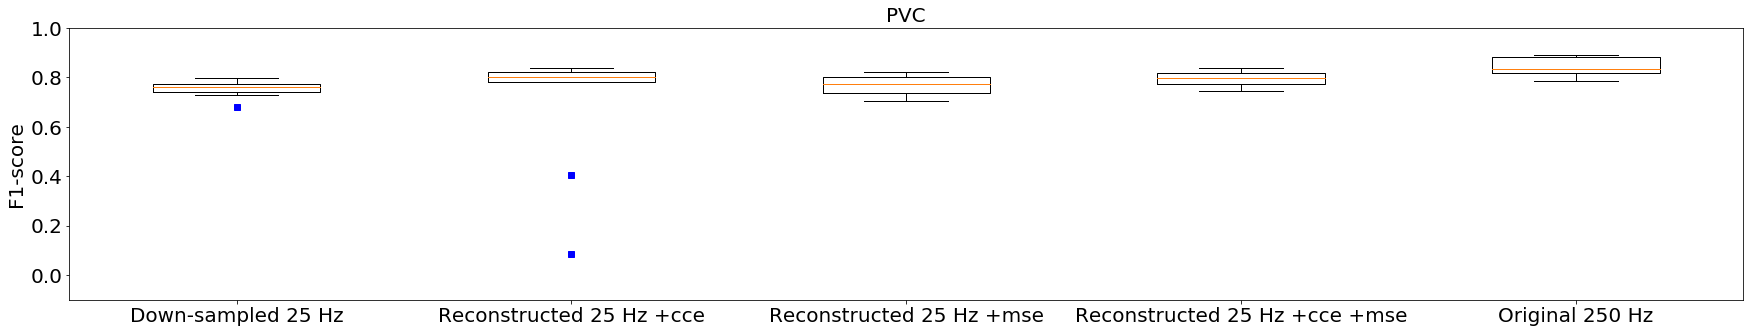

[0.75956323 0.80322581 0.77307225 0.79661017 0.8341785 ]
nan*
nan**
62#**
[2.72126732e-05 7.30959505e-02 7.48426798e-04 1.37060653e-03
 1.00000000e+00]


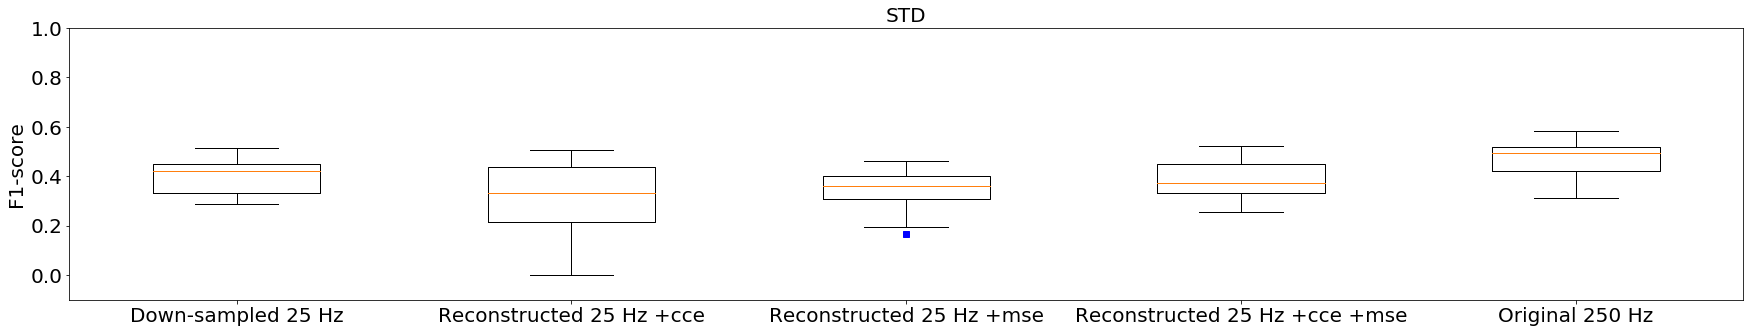

[0.42118227 0.3320356  0.3625     0.37326726 0.49336772]
nan*
nan**
60#**
[1.64139298e-01 1.89453503e-02 1.16957812e-04 6.54641306e-05
 1.00000000e+00]


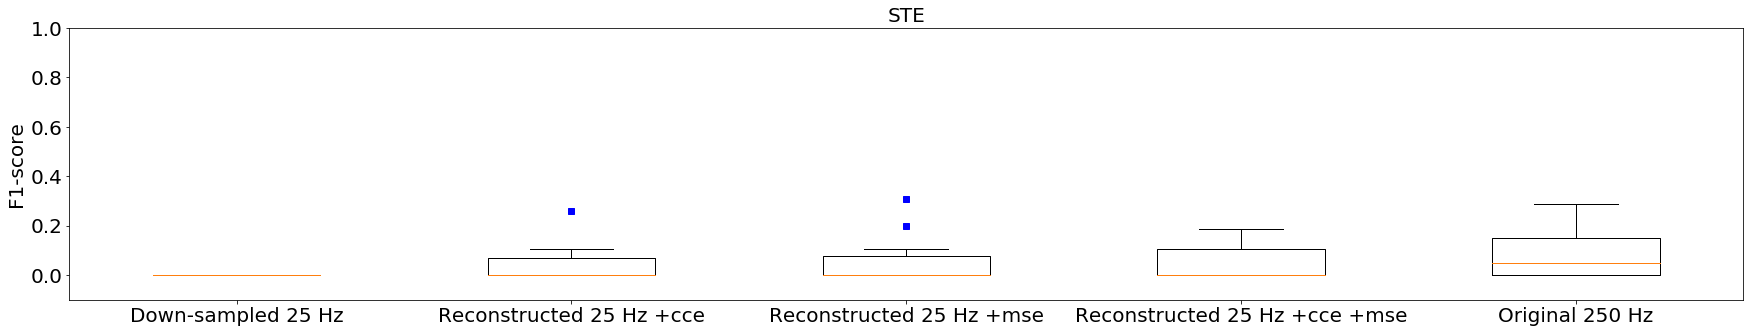

[0.   0.   0.   0.   0.05]
nan*
nan**
0#
[0.02875383 0.24760812 0.33843341 0.1313318  1.        ]


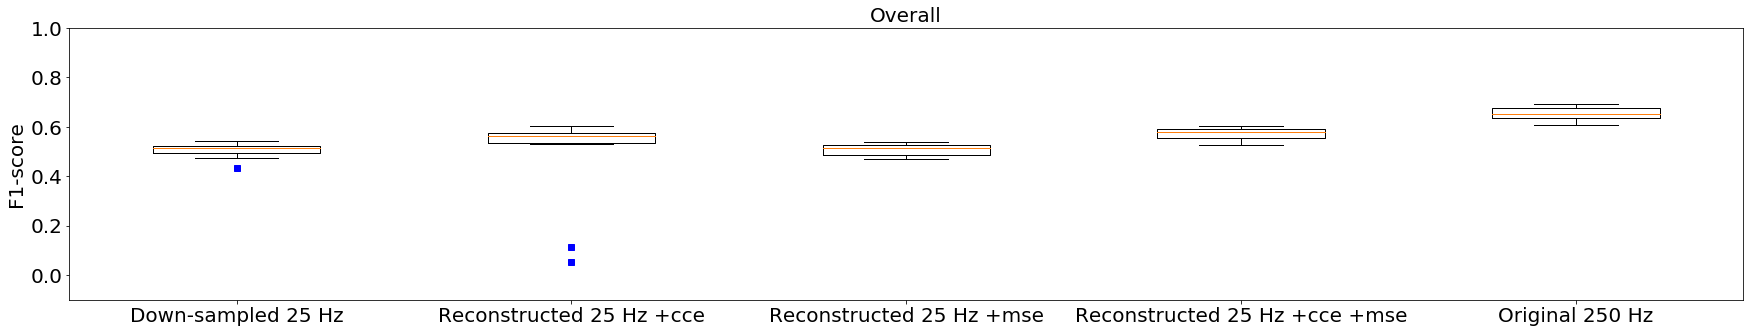

[0.51633569 0.56291421 0.5130842  0.57797908 0.65078945]
nan*
nan**
53#**
[8.59856366e-07 1.84388894e-02 1.65878177e-07 5.26639132e-07
 1.00000000e+00]
Lead :aVR


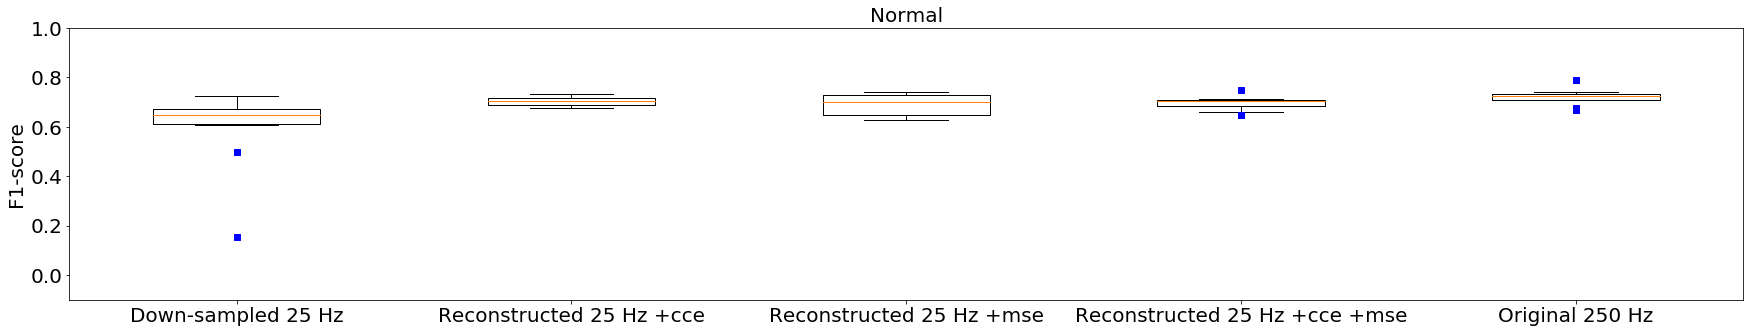

[0.64874687 0.70372647 0.698639   0.70527278 0.7250629 ]
nan*
nan**
17#**
[3.08333005e-02 4.72321766e-02 4.70382199e-02 4.13014888e-05
 1.00000000e+00]


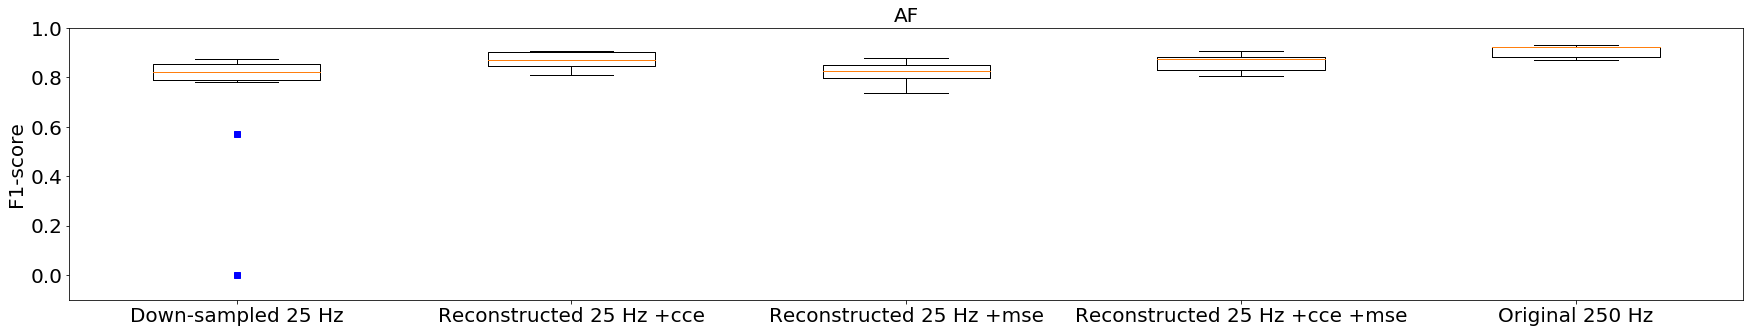

[0.82364266 0.86956522 0.82730263 0.87468593 0.92227979]
nan*
nan**
48#**
[5.44362379e-02 3.71923116e-04 3.06226343e-05 4.56872751e-04
 1.00000000e+00]


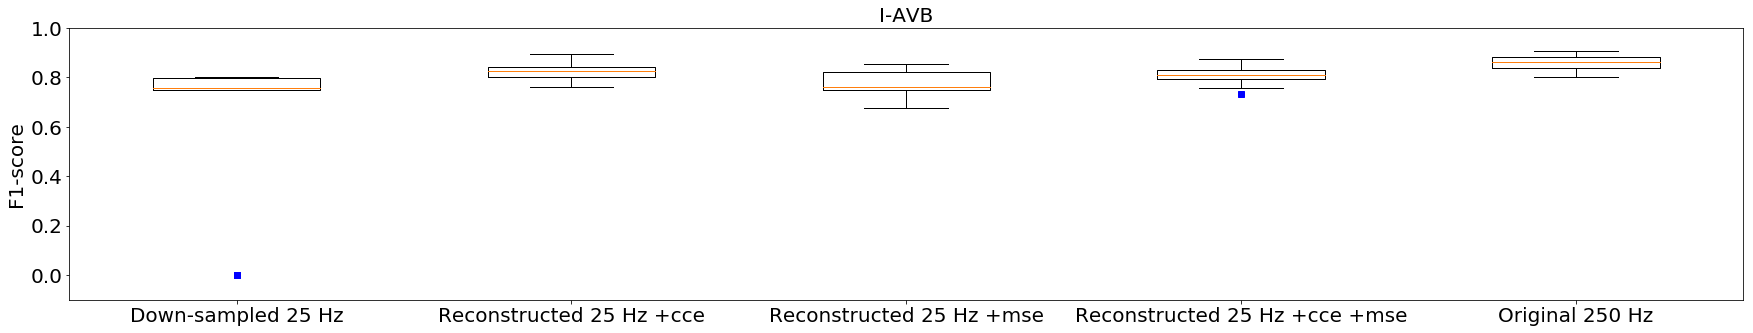

[0.75746335 0.82683658 0.76114608 0.80807512 0.86345316]
nan*
nan**
69#**
[4.79309711e-02 2.62128794e-03 1.84248533e-05 9.19981175e-03
 1.00000000e+00]


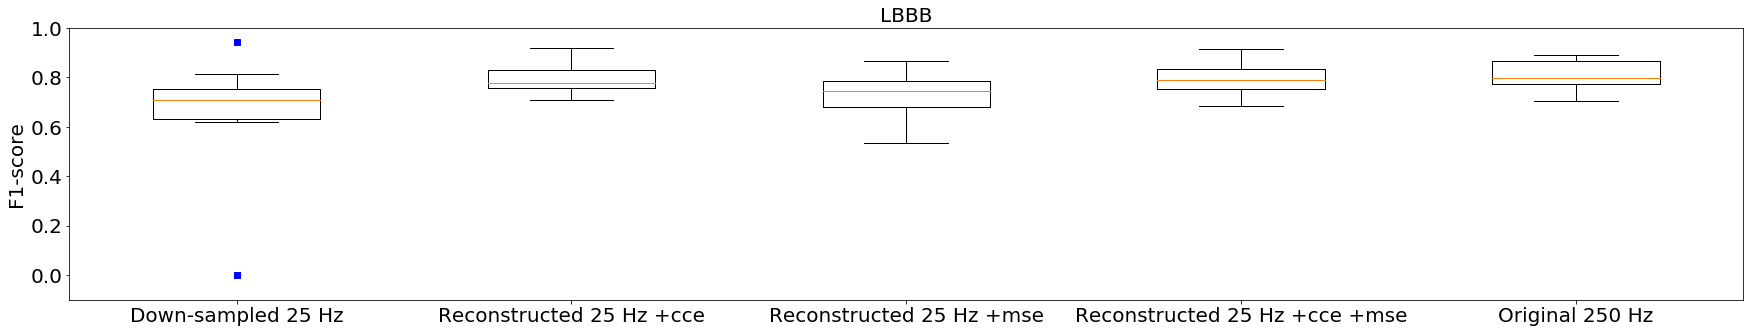

[0.71008403 0.77708978 0.74342105 0.78775835 0.7993448 ]
nan*
nan**
31#
[0.06618309 0.54071712 0.01428435 0.2371493  1.        ]


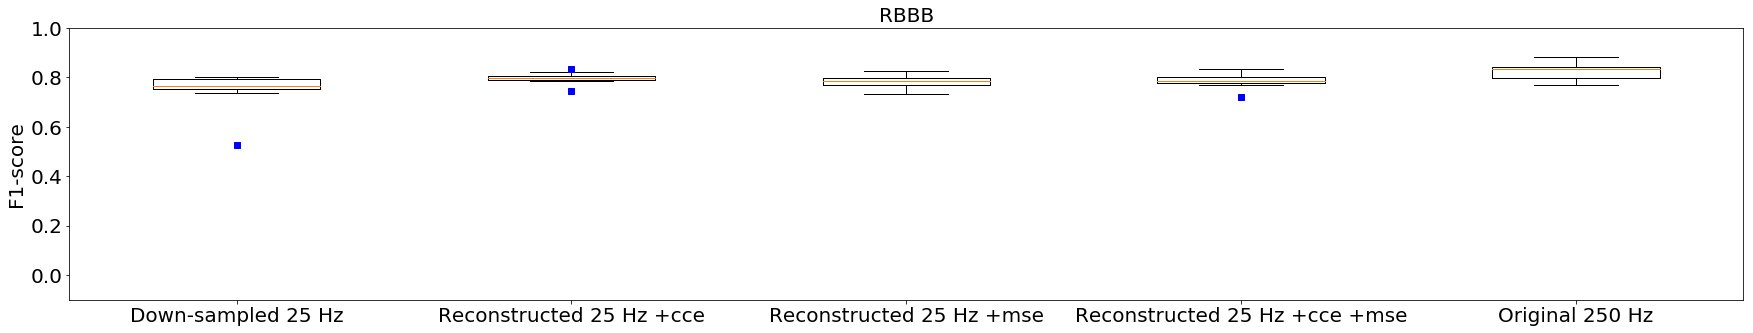

[0.76713389 0.79925994 0.78446553 0.78604408 0.83580858]
nan*
nan**
70#**
[0.01206599 0.01189234 0.00176906 0.00153347 1.        ]


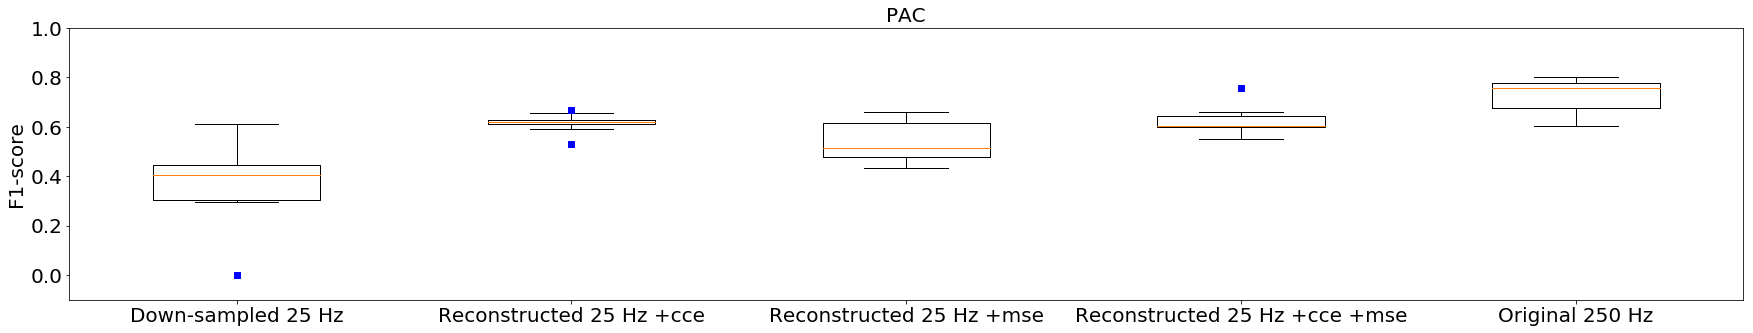

[0.40580138 0.62105527 0.51316392 0.60536202 0.75718065]
nan*
nan**
53#**
[7.20766195e-04 1.83199740e-04 7.43683517e-05 7.70989689e-04
 1.00000000e+00]


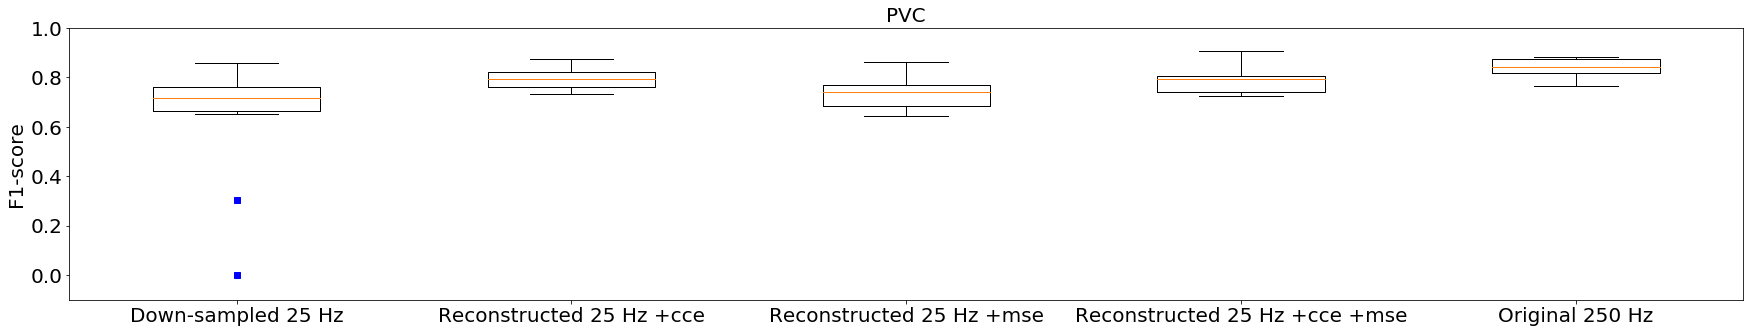

[0.7184539  0.79337607 0.74020337 0.79485681 0.84064392]
nan*
nan**
39#**
[2.59675688e-02 9.01259759e-04 2.00023810e-04 4.30562917e-03
 1.00000000e+00]


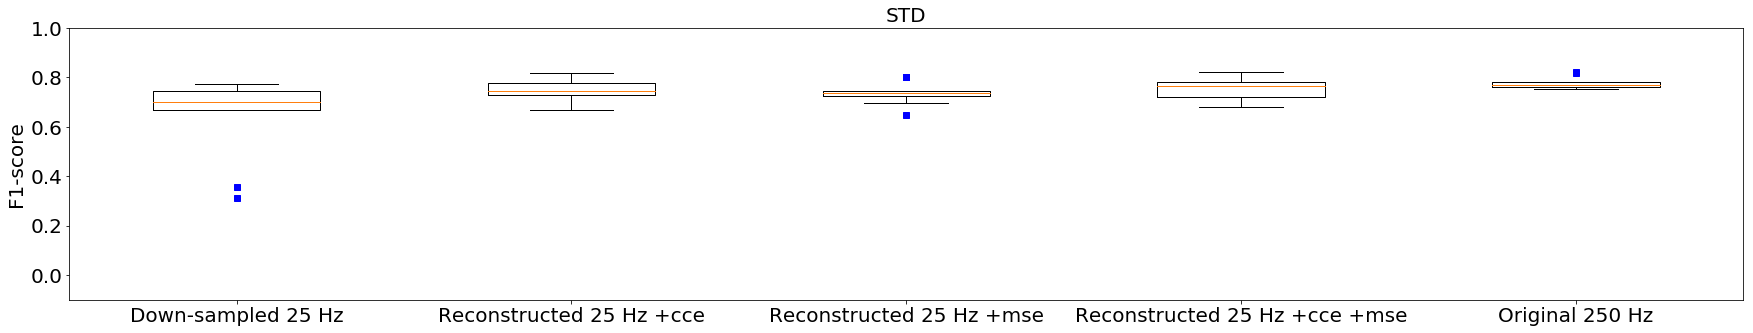

[0.70071131 0.74315144 0.73543124 0.76612843 0.76807189]
nan*
nan**
29#
[0.03044438 0.09487939 0.02079444 0.2064979  1.        ]


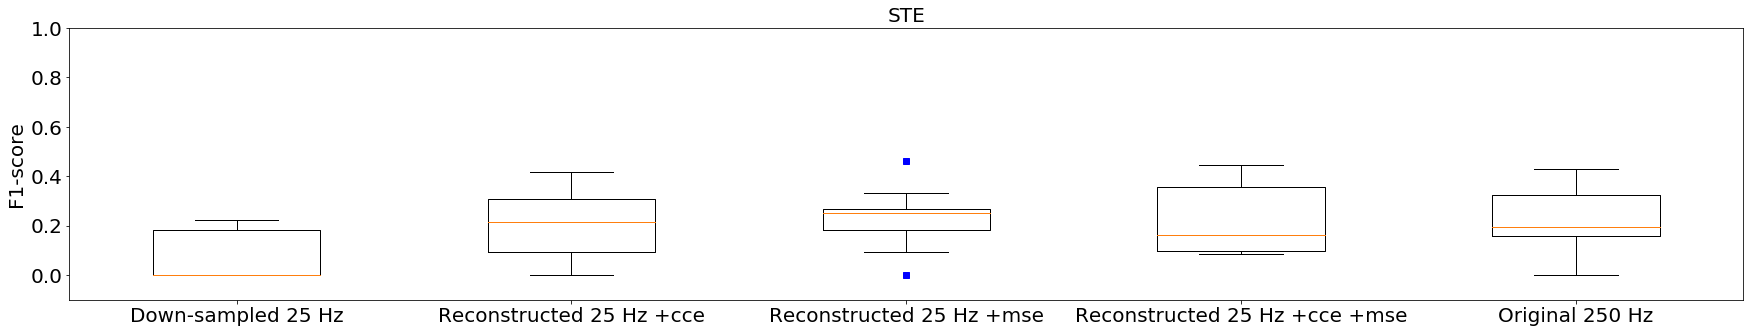

[0.         0.2152381  0.25       0.16420361 0.1952381 ]
nan
nan
20
[0.02577262 0.65221675 0.89738324 0.98275287 1.        ]


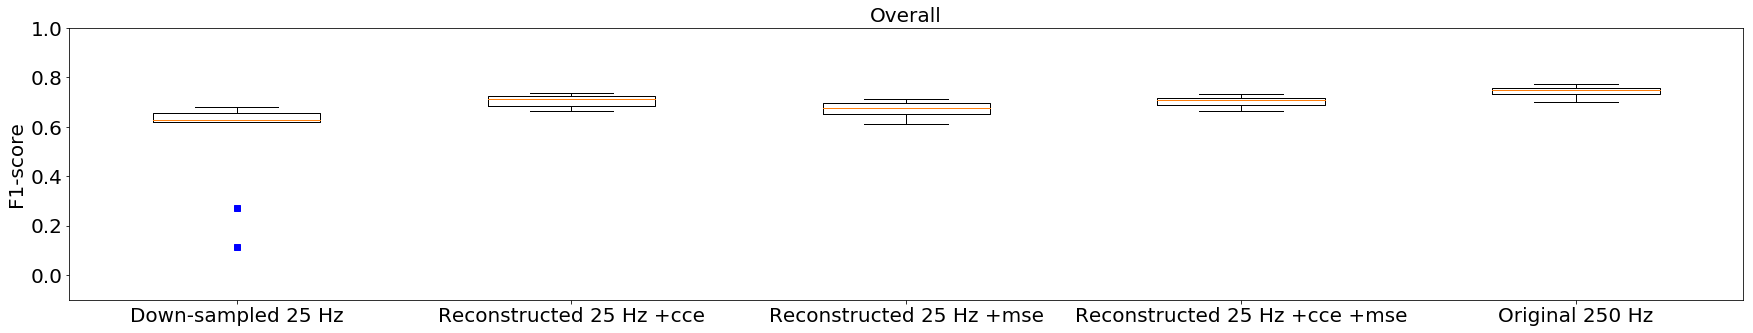

[0.6274327  0.71178374 0.6753337  0.7068929  0.74935977]
nan*
nan**
66#**
[1.24278785e-02 7.93341978e-05 2.45148556e-05 1.89001767e-05
 1.00000000e+00]
Lead :aVL


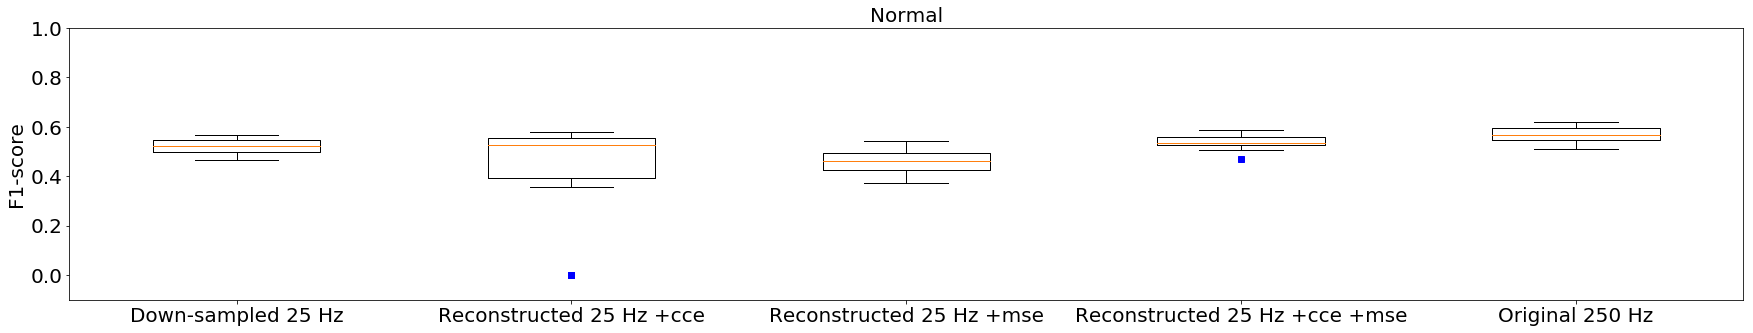

[0.52440833 0.52474137 0.46160311 0.53625571 0.56806723]
nan*
nan**
28#**
[6.17585506e-03 5.15121377e-02 2.62548002e-05 2.63968899e-03
 1.00000000e+00]


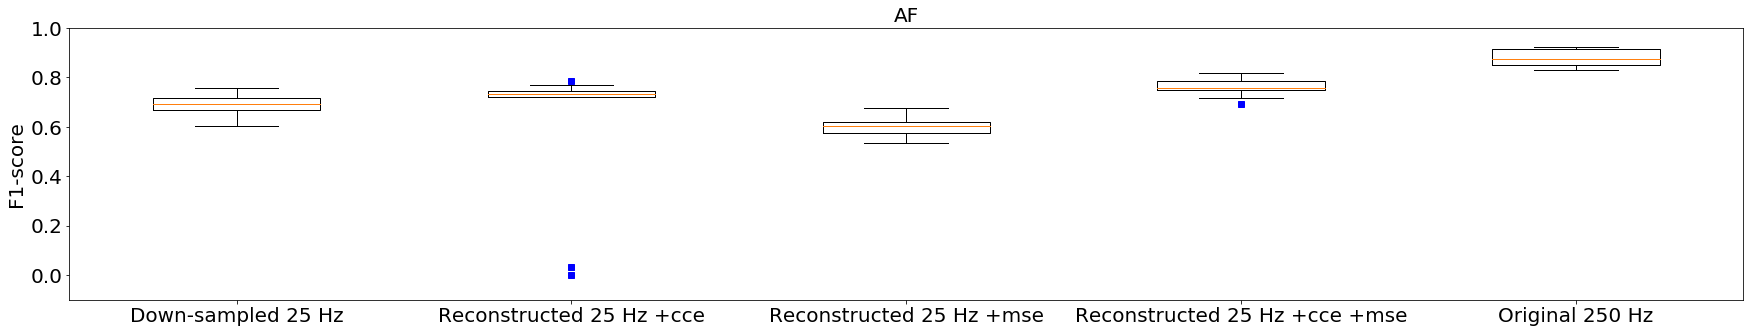

[0.69070172 0.73173309 0.60527139 0.75869169 0.8760768 ]
nan*
nan**
44#**
[1.15329972e-07 1.35422141e-02 8.62763164e-08 2.69337055e-06
 1.00000000e+00]


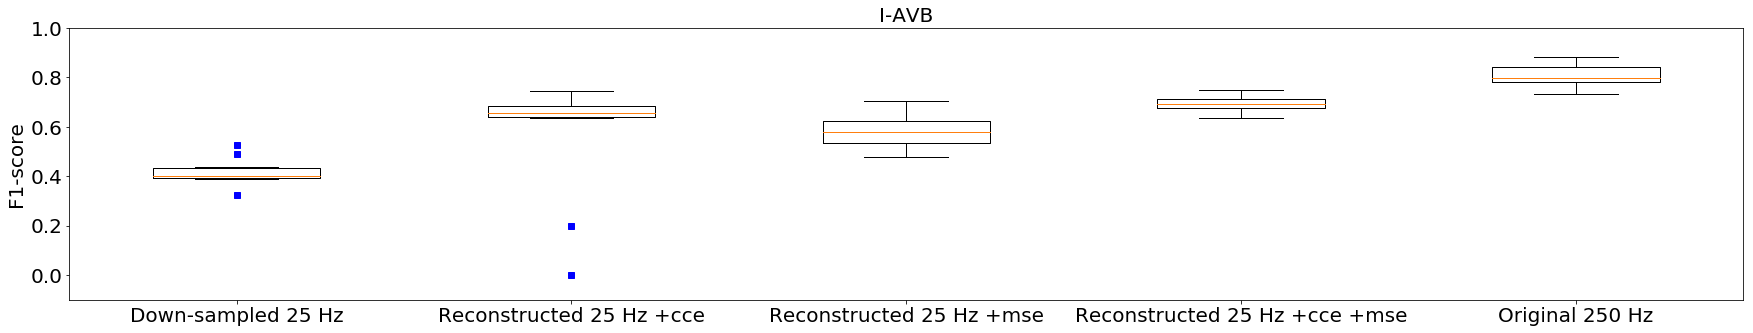

[0.4        0.65511748 0.57738095 0.69148701 0.79864865]
nan*
nan**
60#**
[5.96820106e-08 1.79188729e-02 4.31841170e-07 4.77000778e-05
 1.00000000e+00]


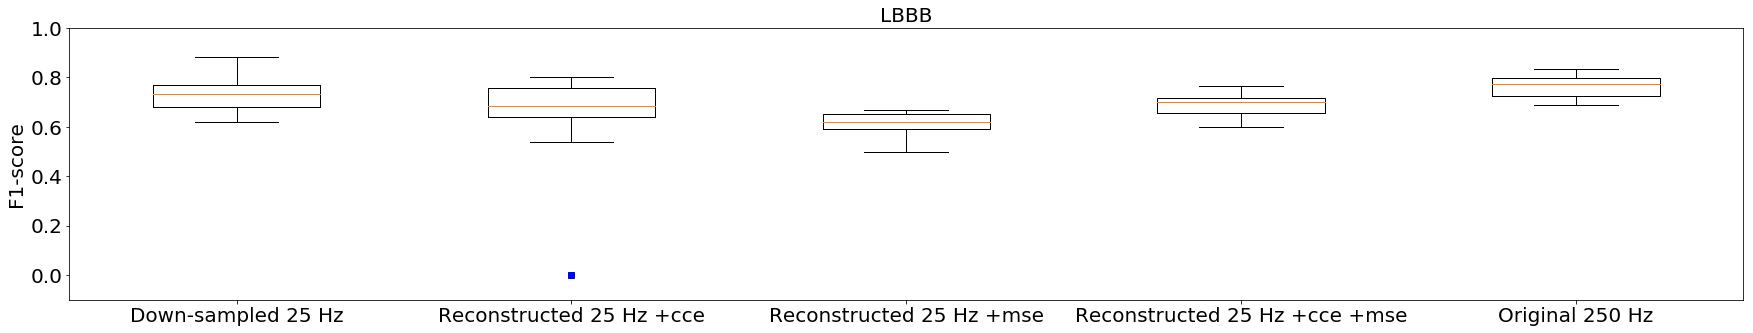

[0.73205742 0.68627451 0.61862245 0.69858871 0.77350427]
nan*
nan**
57#**
[1.51697788e-01 9.02260186e-02 6.91396356e-06 2.20492447e-03
 1.00000000e+00]


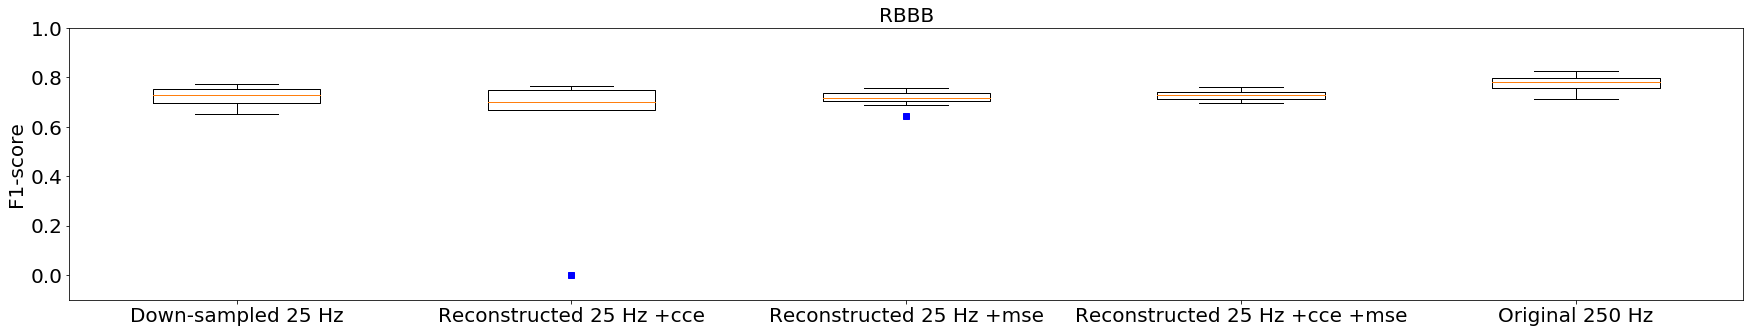

[0.72739815 0.70120985 0.71601836 0.72845384 0.78002846]
nan*
nan**
77#**
[1.18090353e-04 9.80312389e-02 4.89313703e-09 8.71708980e-04
 1.00000000e+00]


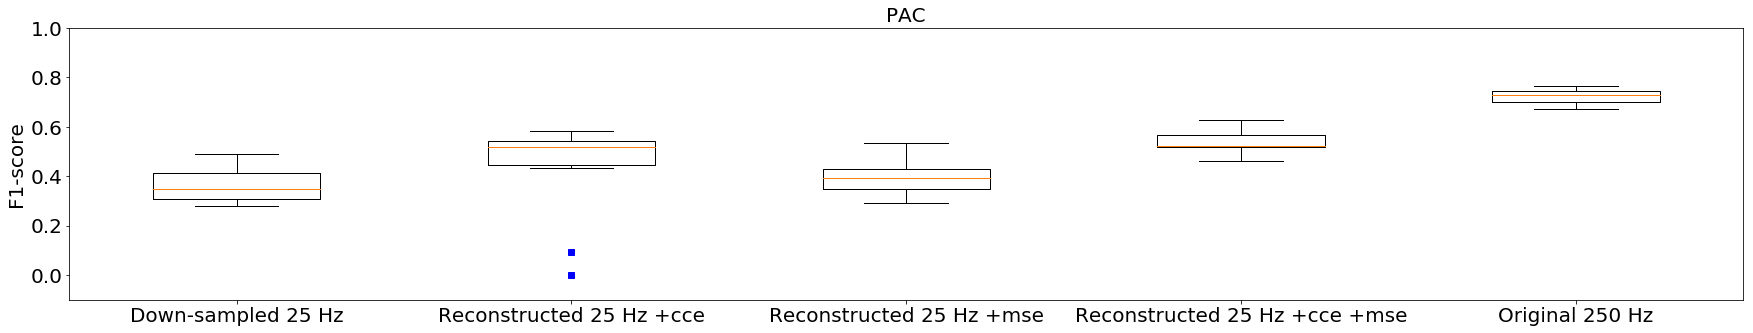

[0.34724613 0.51718427 0.39278075 0.52441916 0.72889276]
nan*
nan**
61#**
[1.72908728e-08 1.00653672e-03 2.68702616e-07 3.83835810e-08
 1.00000000e+00]


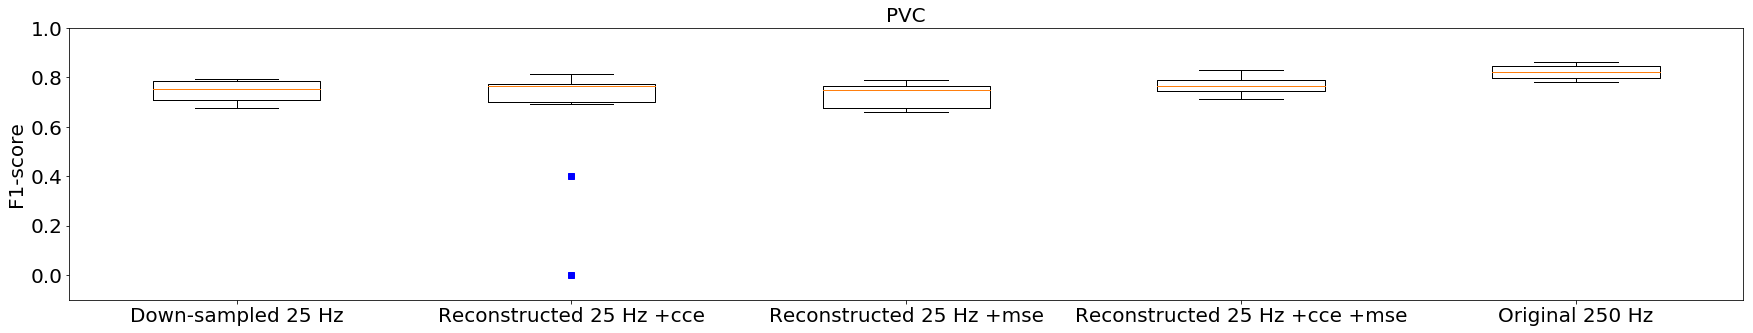

[0.75223899 0.76614583 0.75106838 0.76495726 0.82352941]
nan*
nan**
64#**
[8.56050964e-05 6.32438253e-02 1.72504526e-05 1.11989509e-03
 1.00000000e+00]


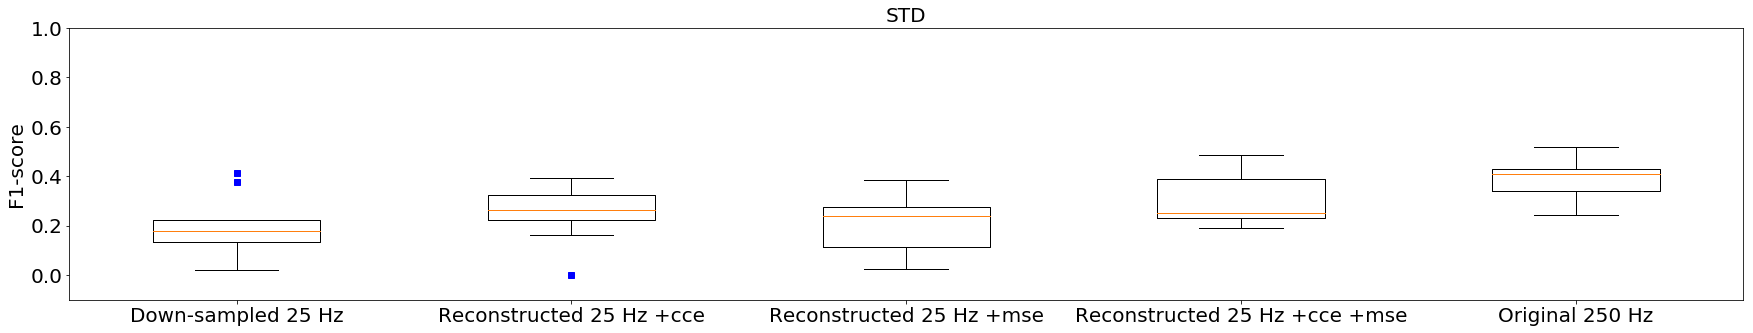

[0.18009174 0.26186103 0.23885625 0.25108559 0.41079973]
nan*
nan**
42#**
[2.94826506e-04 1.39908506e-03 6.95143841e-04 8.10005593e-03
 1.00000000e+00]


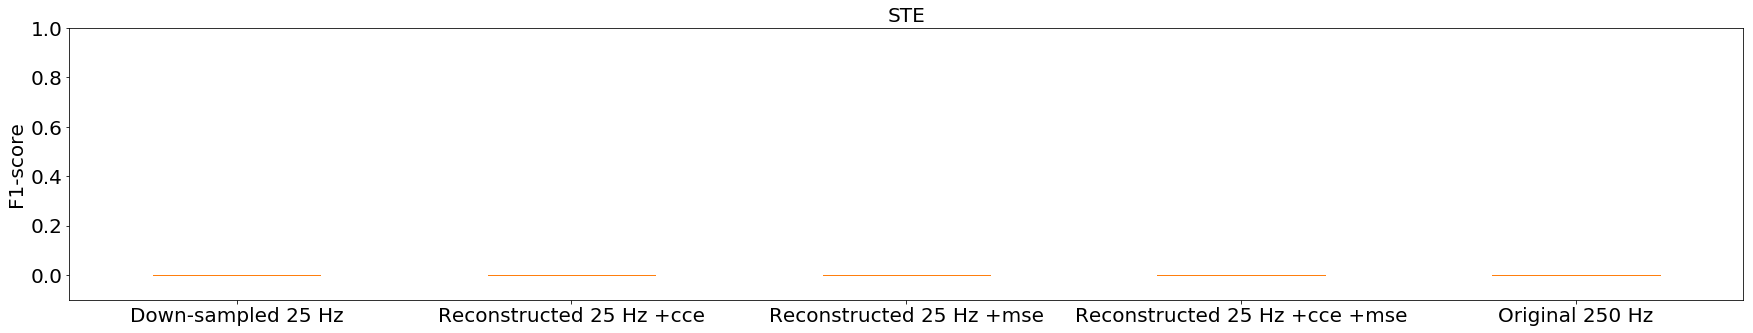

[0. 0. 0. 0. 0.]
nan*
nan**
0#
[nan nan nan nan  1.]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less


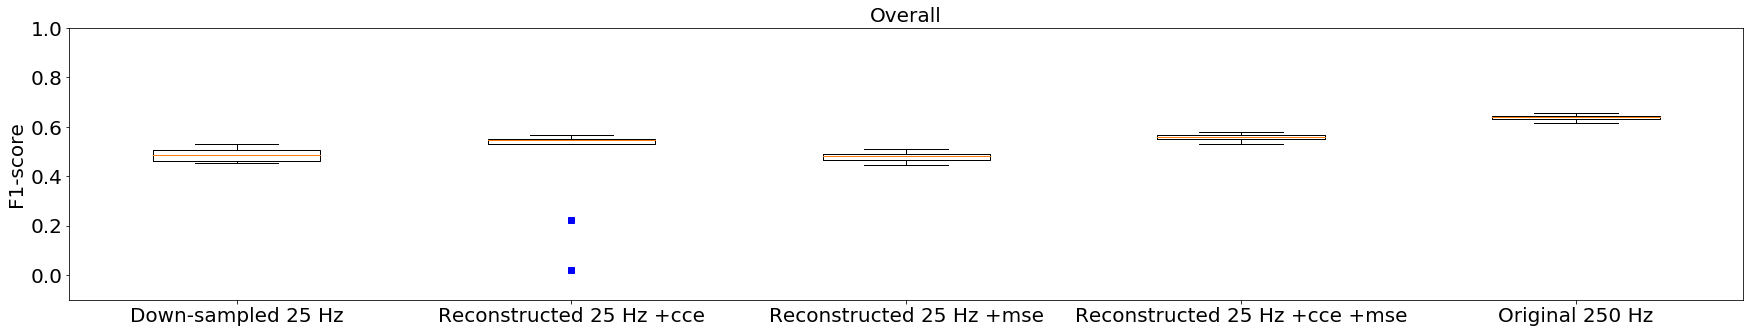

[0.48767354 0.54577558 0.48040175 0.55773443 0.63917798]
nan*
nan**
48#**
[1.54923865e-08 1.60975732e-02 7.60821861e-10 4.29985467e-09
 1.00000000e+00]
Lead :aVF


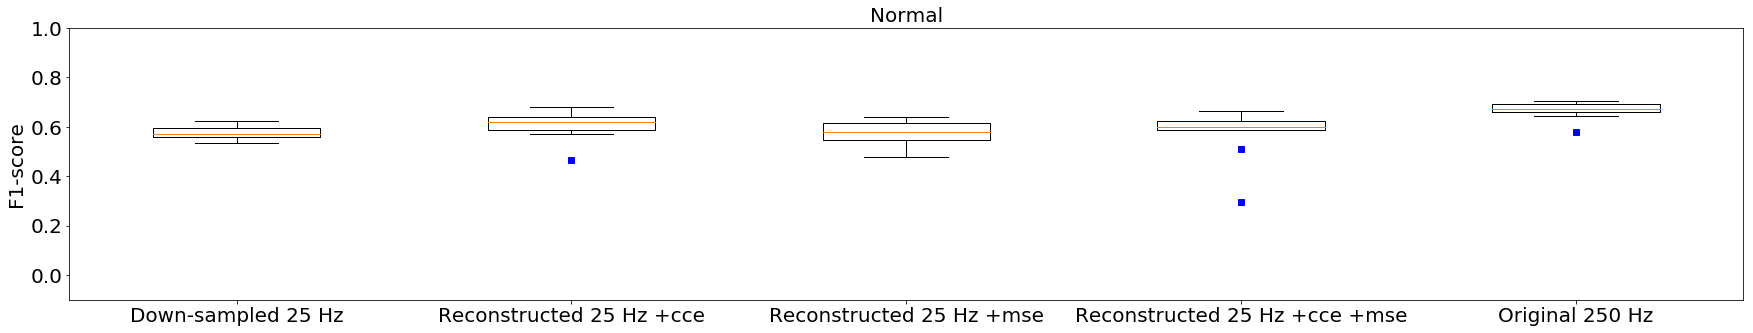

[0.56929638 0.62095271 0.57896613 0.5978836  0.67300629]
nan*
nan**
73#*
[1.71374496e-05 5.45642387e-04 8.32998727e-05 1.33963665e-02
 1.00000000e+00]


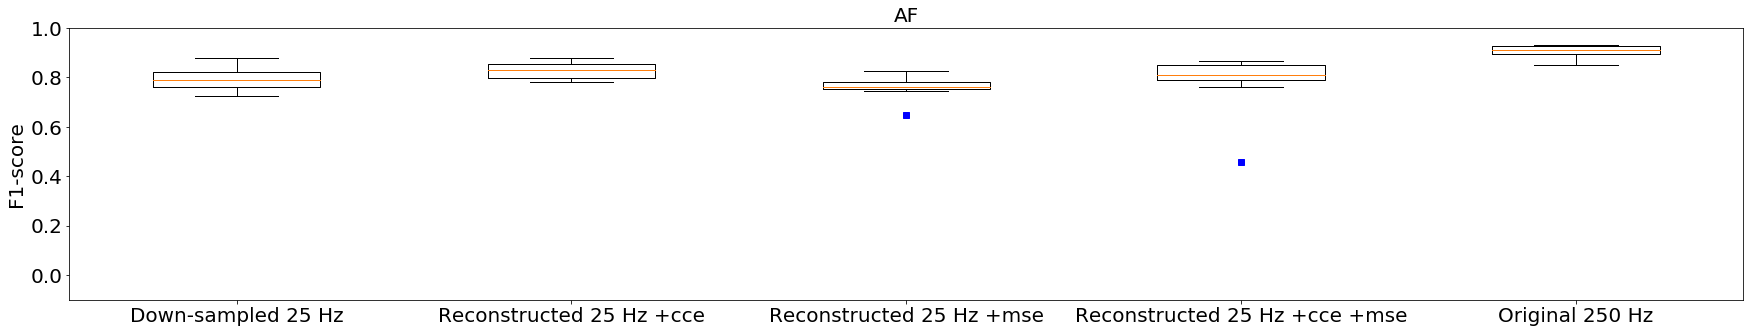

[0.78851923 0.828867   0.76314401 0.80894089 0.91244019]
nan*
nan**
63#*
[7.17591746e-05 2.80396974e-05 2.28539072e-06 1.24804351e-02
 1.00000000e+00]


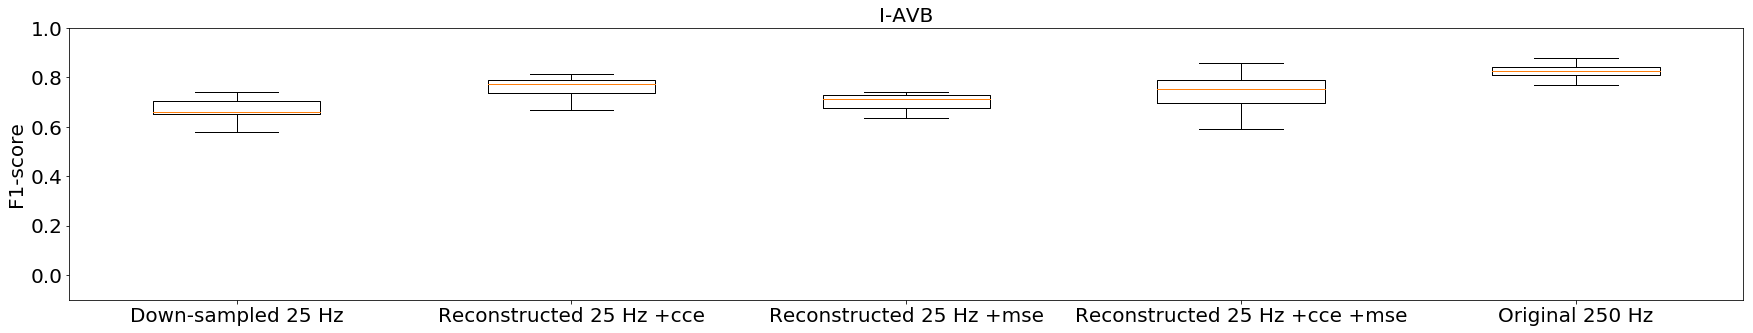

[0.65897563 0.77230424 0.71225404 0.75177878 0.82666957]
nan*
nan**
49#**
[2.95503132e-05 8.37103051e-04 4.52018327e-07 9.47995763e-03
 1.00000000e+00]


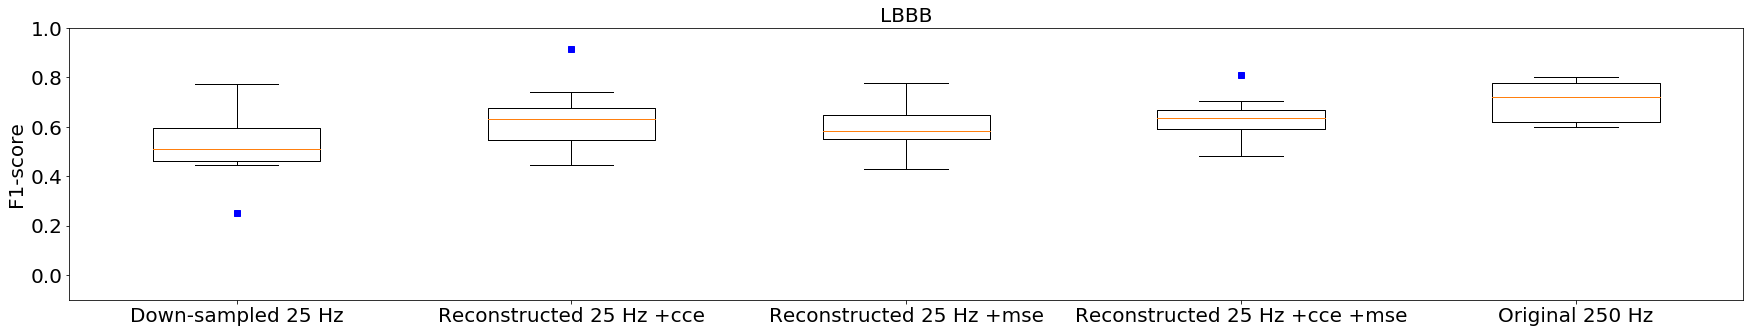

[0.50925926 0.63157895 0.58301158 0.63392857 0.71969697]
nan*
nan**
84#*
[0.00227151 0.05837096 0.01210277 0.02706848 1.        ]


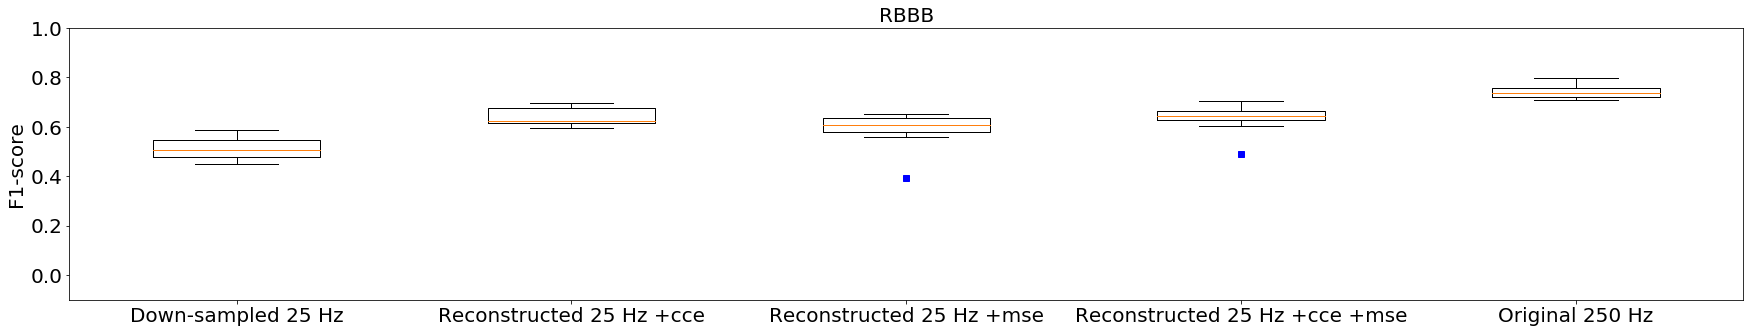

[0.50652254 0.62278671 0.60661859 0.64284597 0.73775903]
nan*
nan**
62#**
[9.85650525e-07 4.90511519e-06 1.74239547e-04 2.92127232e-04
 1.00000000e+00]


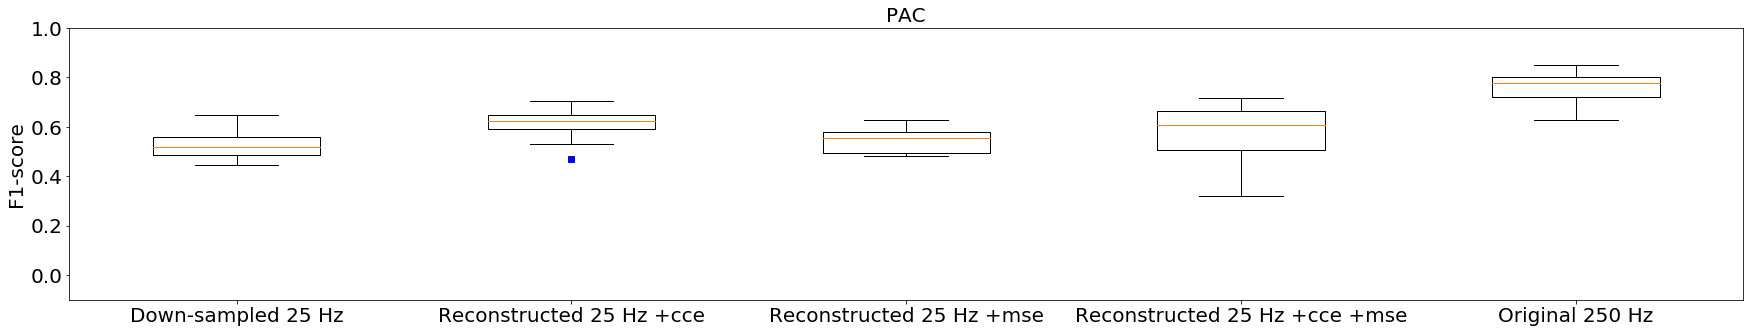

[0.51655983 0.62334598 0.55284876 0.60665683 0.77935223]
nan*
nan**
82#**
[1.33959254e-04 1.39391970e-04 6.29868965e-07 7.18269530e-04
 1.00000000e+00]


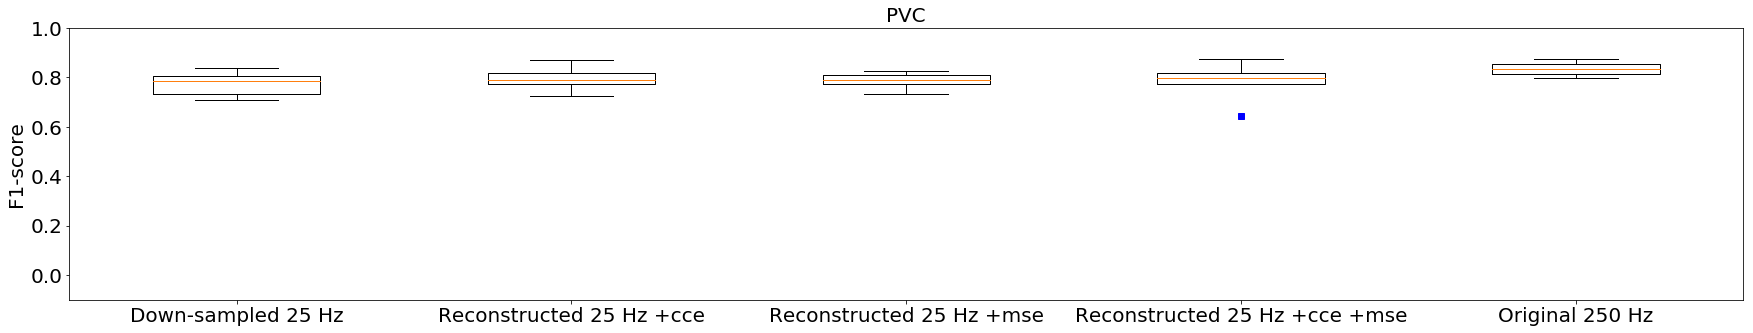

[0.78718905 0.78998779 0.79090909 0.7996368  0.8341785 ]
nan*
nan**
56#*
[2.45771624e-03 2.00324981e-03 1.70549338e-04 3.84201448e-02
 1.00000000e+00]


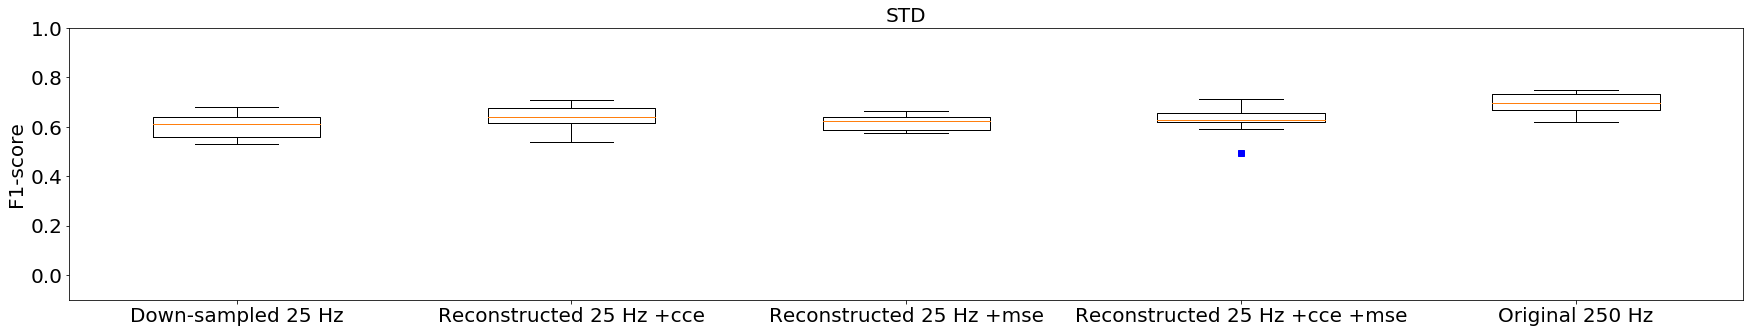

[0.61082588 0.64001133 0.62541332 0.62822562 0.69824311]
nan*
nan**
57#*
[1.57020975e-04 2.42819215e-04 4.07942110e-05 1.01135262e-02
 1.00000000e+00]


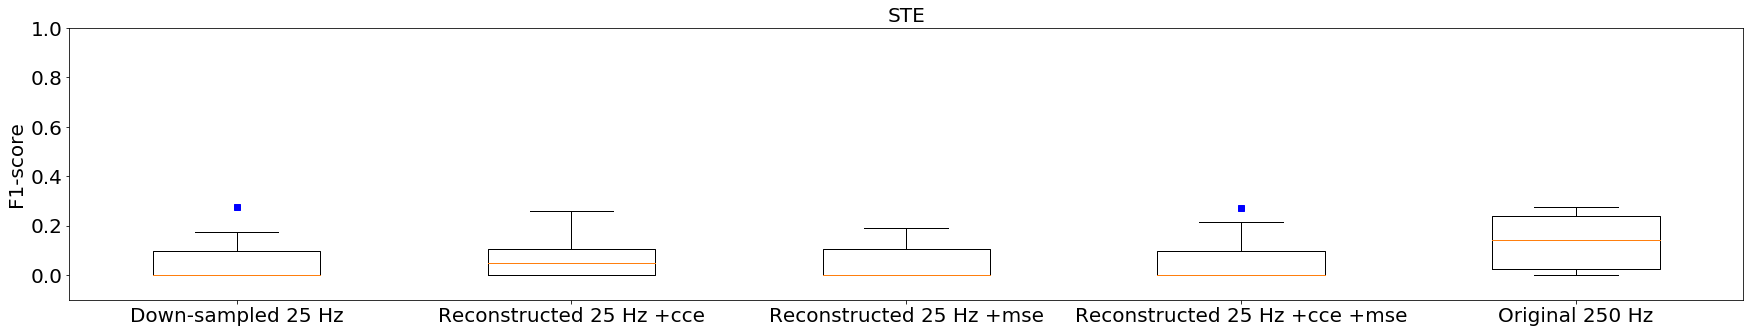

[0.         0.04761905 0.         0.         0.14354067]
nan*
nan**
0#*
[0.2378512  0.02263281 0.06827766 0.04396666 1.        ]


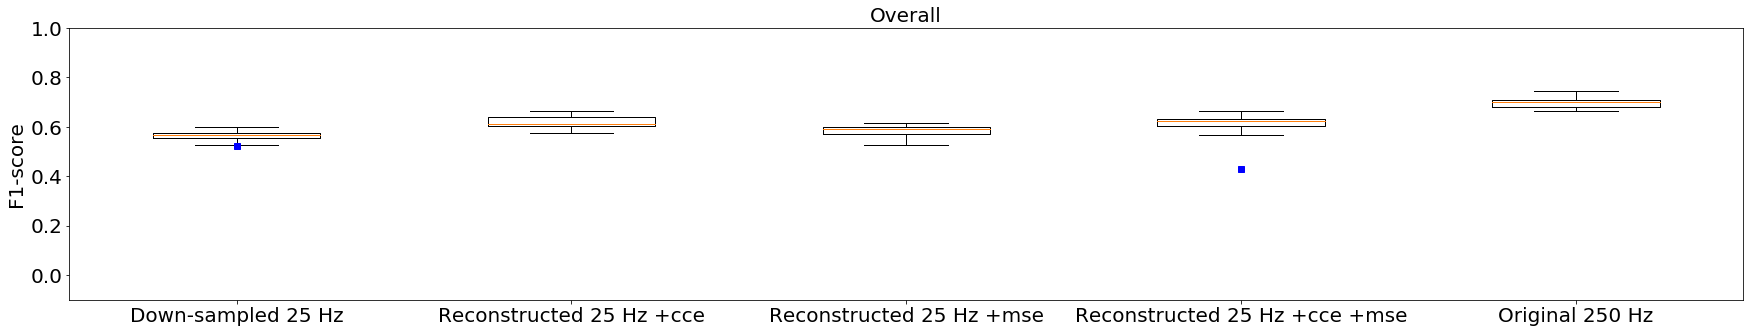

[0.5664428  0.61248171 0.5910419  0.62192593 0.69861625]
nan*
nan**
63#**
[7.84346695e-07 3.44506529e-05 4.48603941e-06 1.02174724e-03
 1.00000000e+00]
Lead :V1


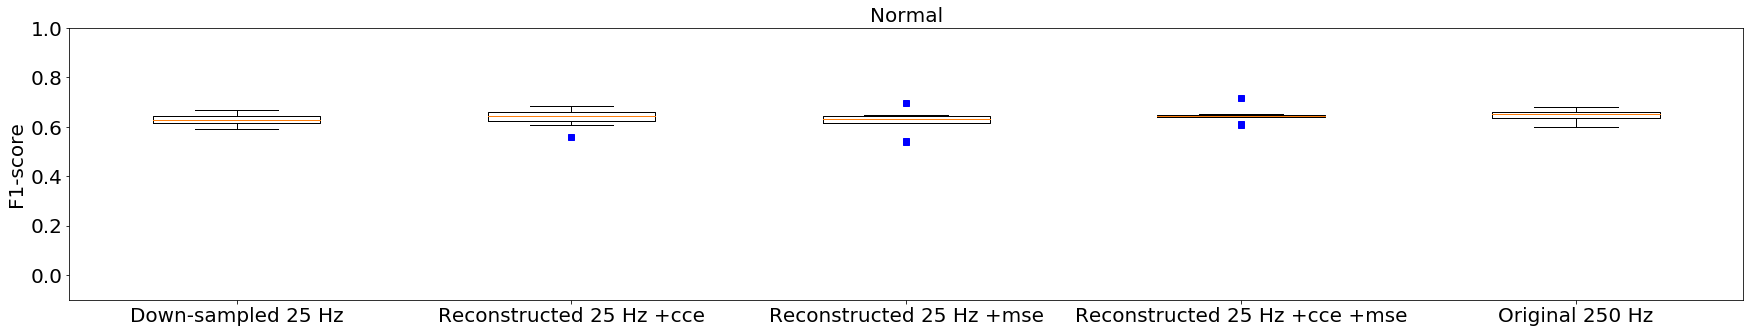

[0.62691649 0.64487889 0.63231213 0.64387755 0.65068807]
nan*
nan**
80#
[0.02312516 0.39006637 0.11766632 0.8316796  1.        ]


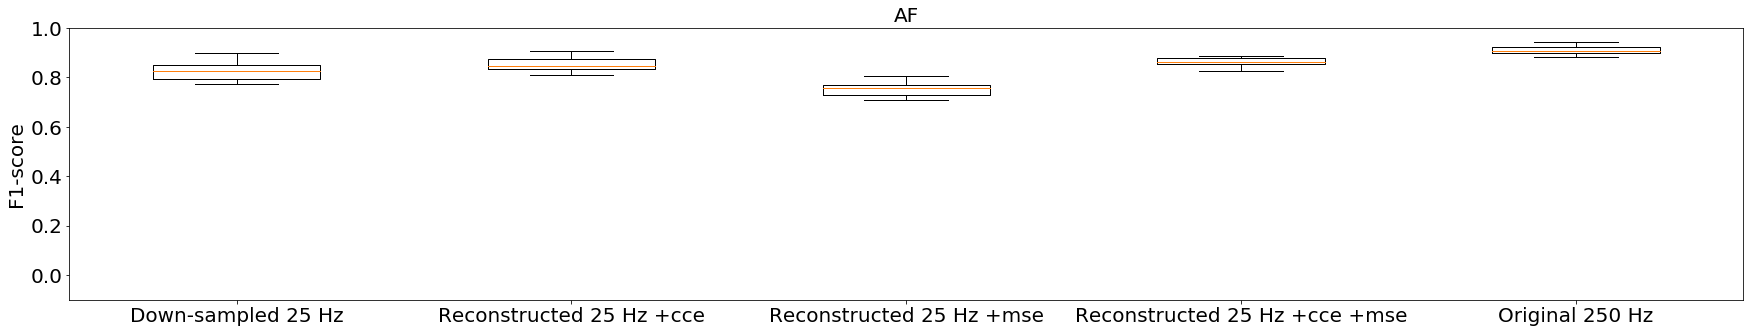

[0.82491987 0.845      0.75840511 0.86064476 0.90658824]
nan*
nan**
34#**
[2.04714698e-05 1.52660399e-04 2.67698220e-08 7.52017140e-05
 1.00000000e+00]


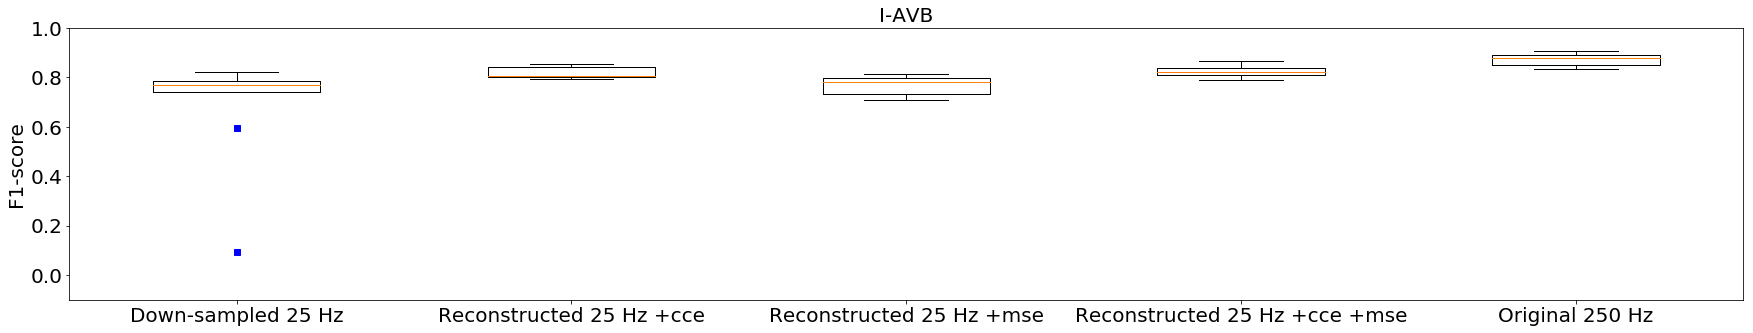

[0.76826318 0.80753968 0.78115364 0.82043843 0.88057041]
nan*
nan**
43#**
[2.58069879e-02 8.83010320e-07 7.49280848e-05 2.28200101e-05
 1.00000000e+00]


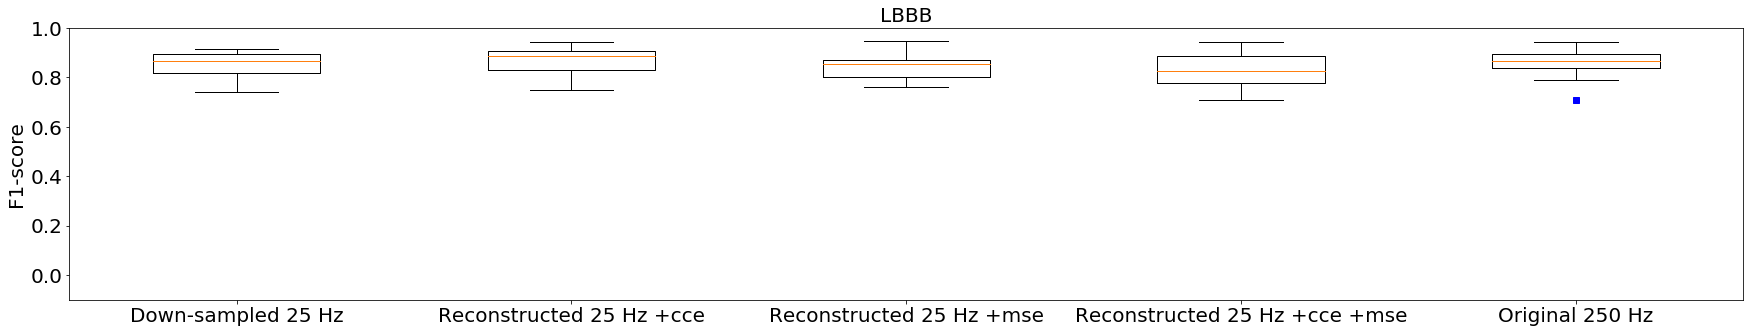

[0.86832987 0.88562092 0.85281385 0.82424242 0.86832987]
nan*
nan**
44#
[0.79505951 0.52697947 0.50641751 0.13422816 1.        ]


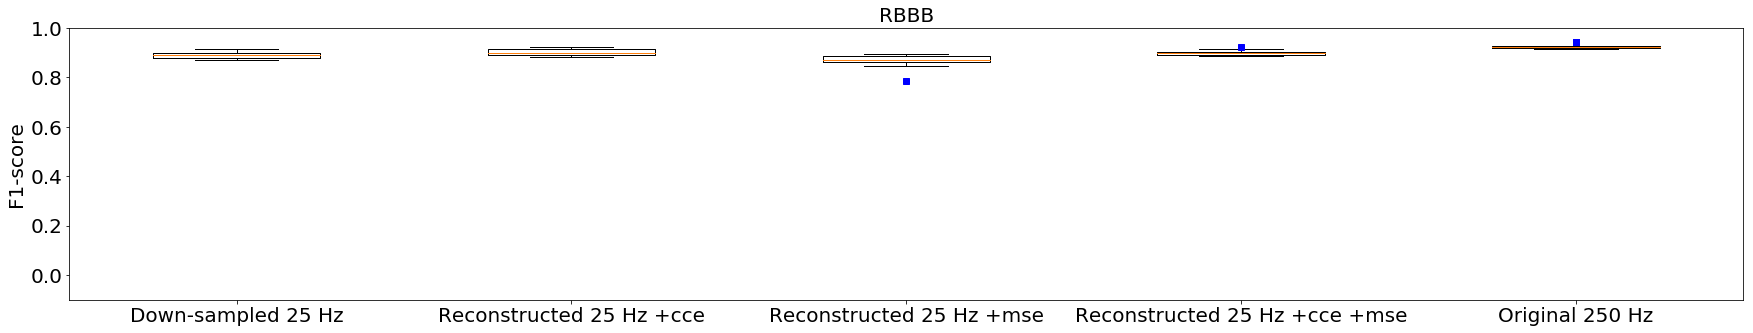

[0.88995253 0.89752919 0.86856979 0.89954133 0.92379032]
nan*
nan**
46#**
[2.27610595e-05 1.08009884e-04 2.93472286e-04 8.64573136e-05
 1.00000000e+00]


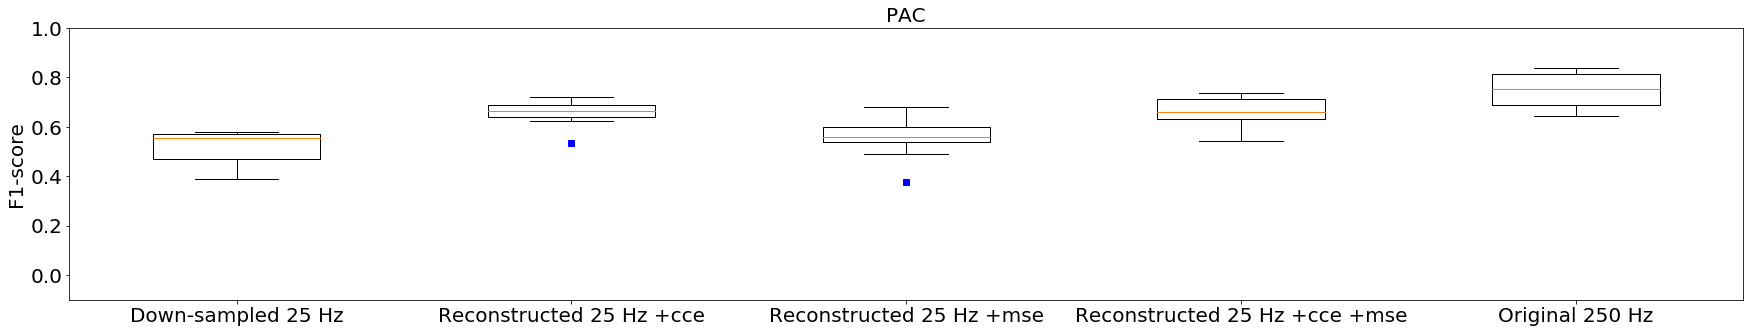

[0.55632799 0.66398072 0.55980458 0.66041162 0.75452517]
nan*
nan**
38#**
[1.75344103e-06 1.67034647e-04 2.29002333e-06 1.18714371e-04
 1.00000000e+00]


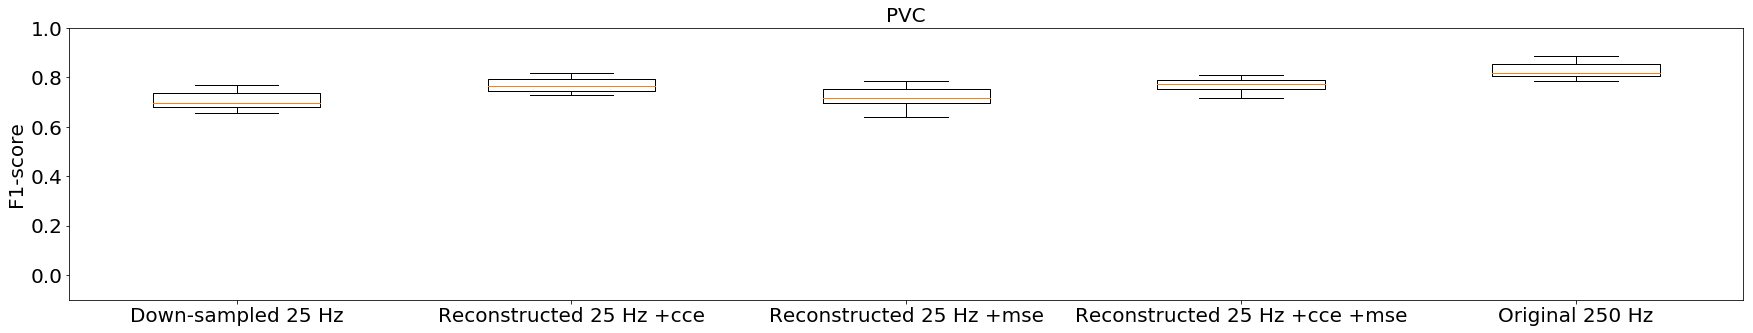

[0.69489139 0.76577688 0.71490656 0.77200277 0.81661573]
nan*
nan**
64#**
[3.89188957e-08 1.11681578e-04 4.58428721e-06 2.67336912e-06
 1.00000000e+00]


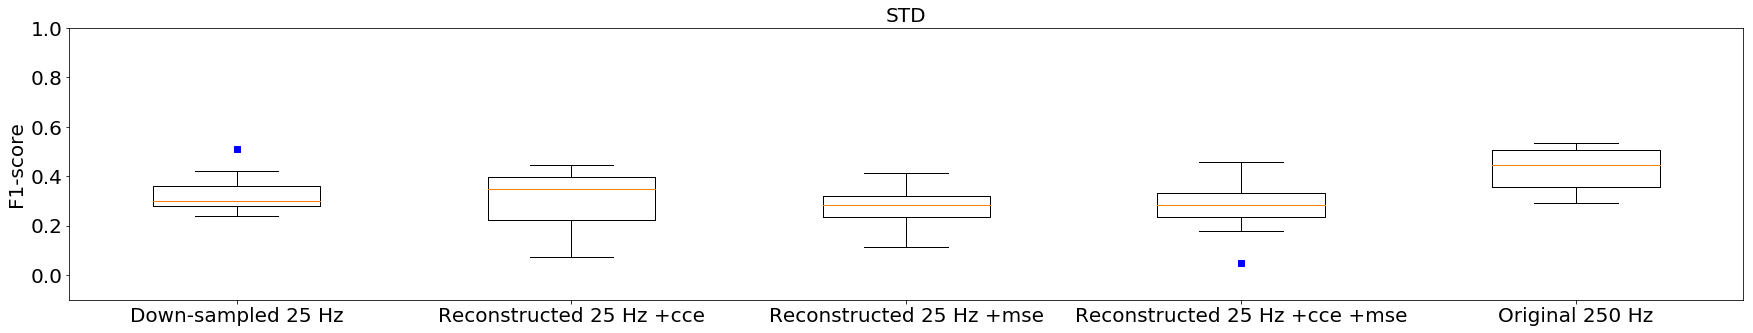

[0.29945825 0.3486532  0.28220566 0.28564491 0.44418349]
nan*
nan**
105#**
[3.30762748e-02 7.46444573e-04 2.92977523e-04 2.08319915e-04
 1.00000000e+00]


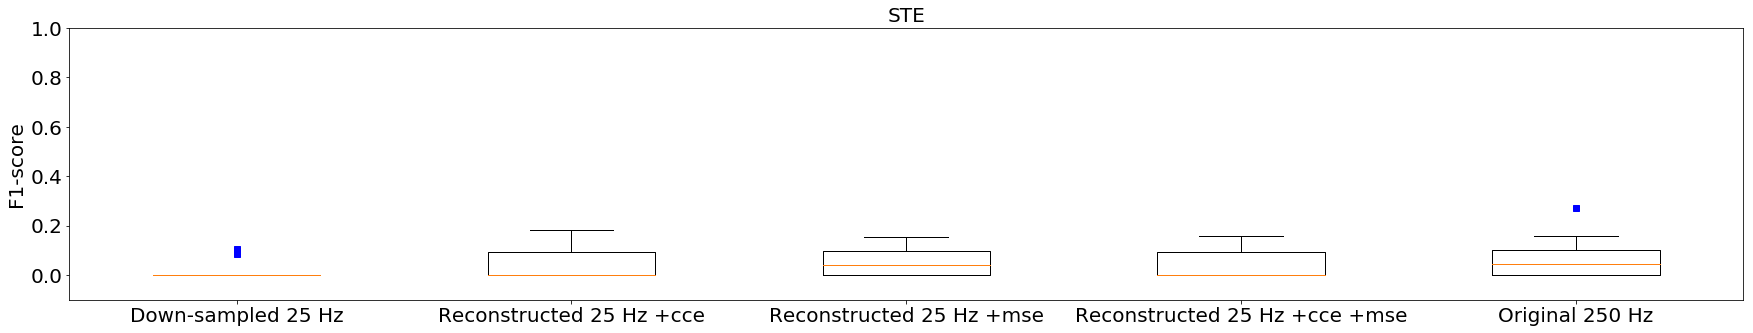

[0.         0.         0.04166667 0.         0.04545455]
nan*
nan**
0#
[0.13887894 0.40684745 0.59837305 0.40213101 1.        ]


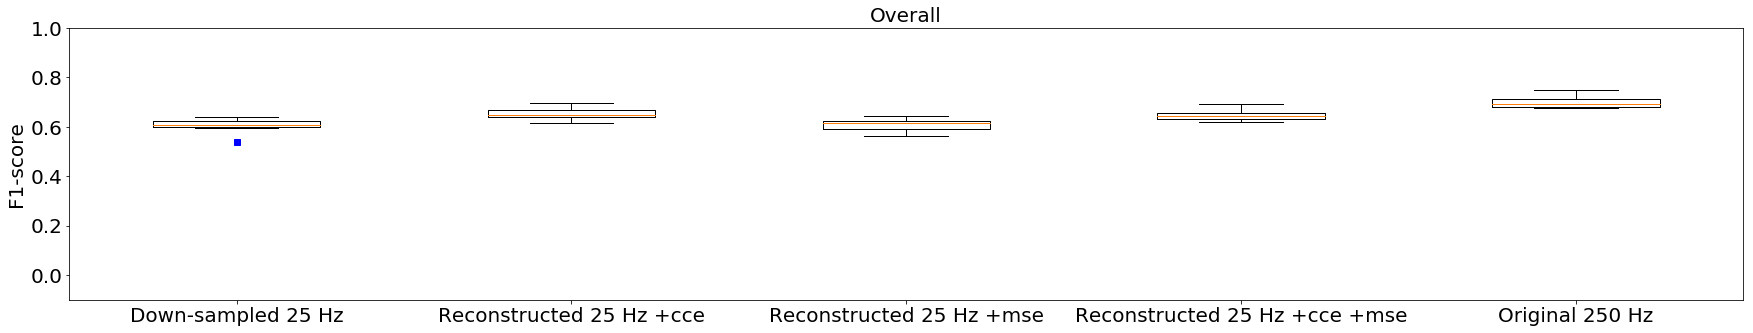

[0.60766091 0.64682614 0.61521554 0.64330106 0.69292397]
nan*
nan**
57#**
[1.06641606e-05 2.84071056e-05 1.79182313e-06 1.54227420e-05
 1.00000000e+00]
Lead :V2


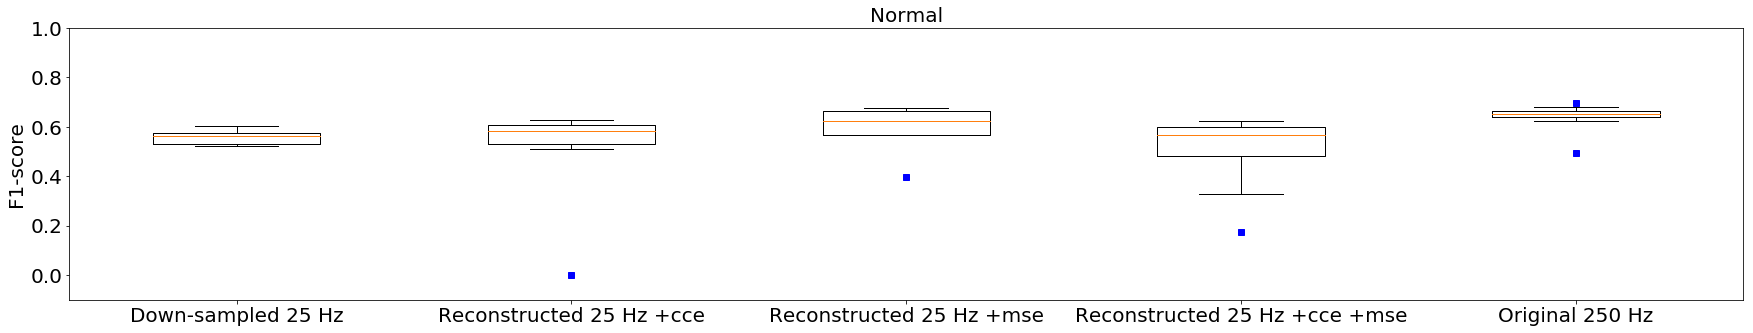

[0.56369275 0.58147397 0.62341448 0.56726127 0.65082922]
nan*
nan**
-113#*
[0.00562137 0.07159307 0.00879772 0.02124671 1.        ]


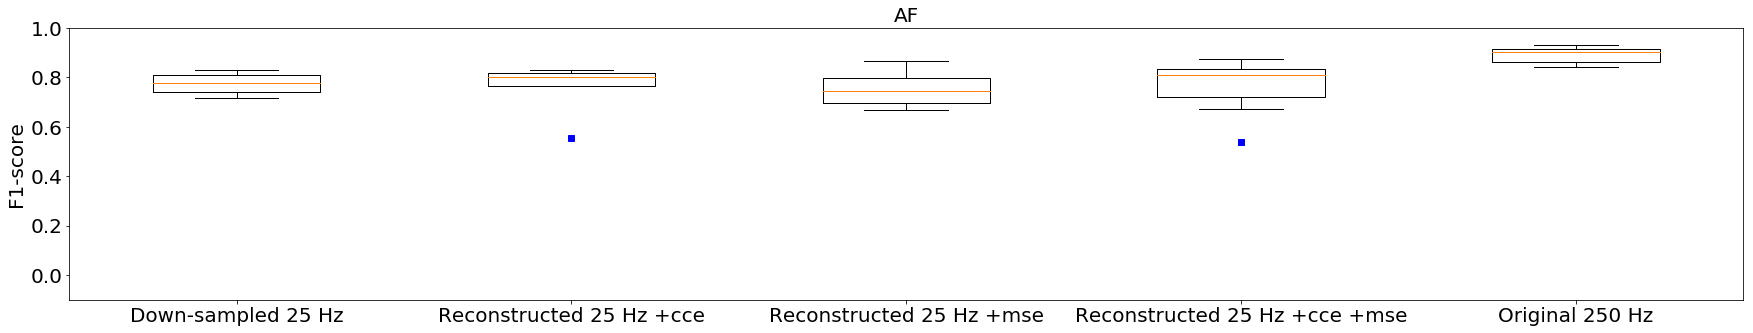

[0.77552207 0.80025497 0.7432282  0.80806025 0.9017771 ]
nan*
nan**
80#**
[2.36861599e-06 3.61383935e-03 1.70030433e-06 3.04160693e-03
 1.00000000e+00]


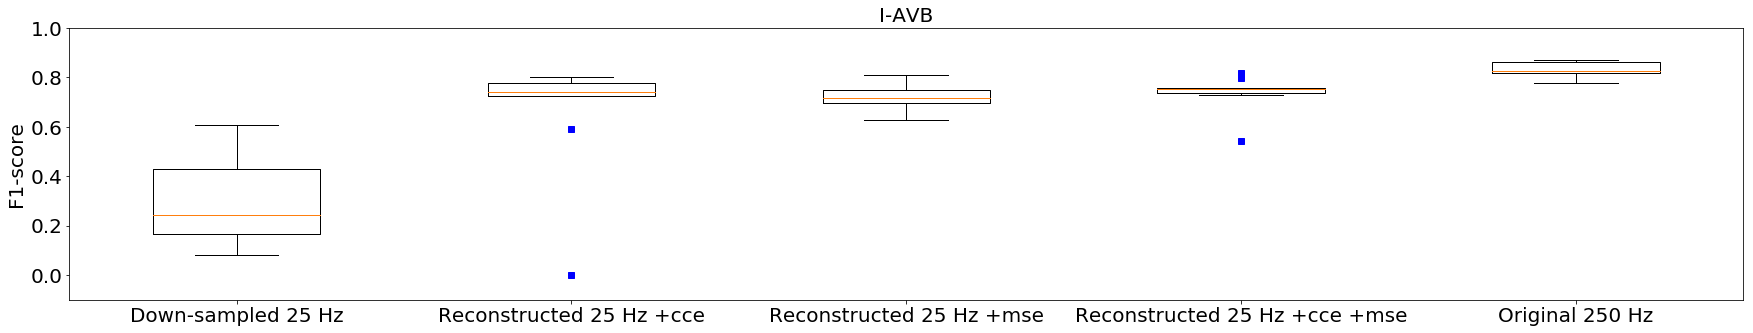

[0.24189316 0.73922283 0.71802469 0.75481536 0.8243759 ]
nan*
nan**
85#**
[3.10105812e-06 6.38598586e-02 2.86066050e-04 1.73941798e-03
 1.00000000e+00]


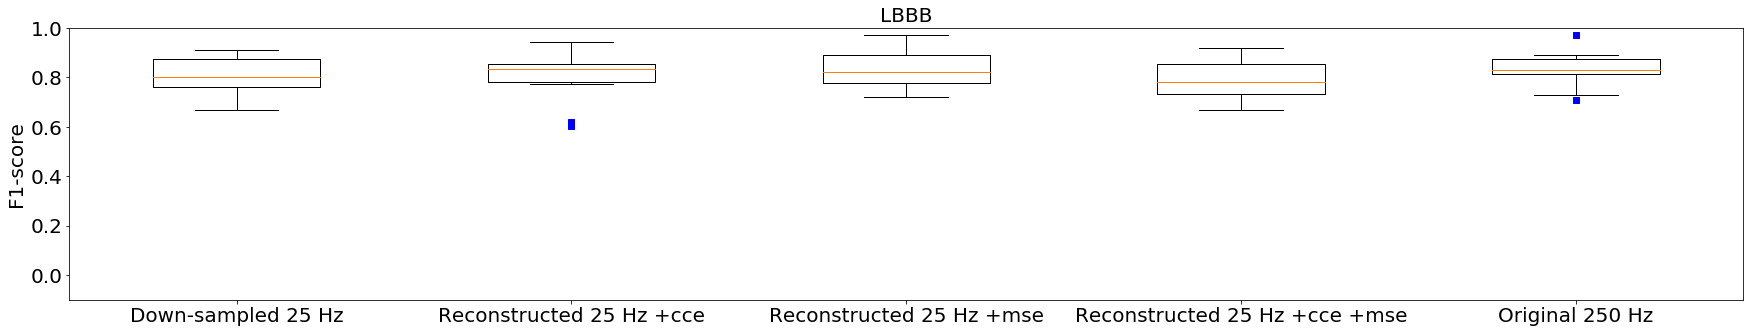

[0.80065359 0.83281734 0.82207207 0.78235294 0.82843137]
nan*
nan**
62#
[0.04716845 0.37357562 0.94585964 0.06528432 1.        ]


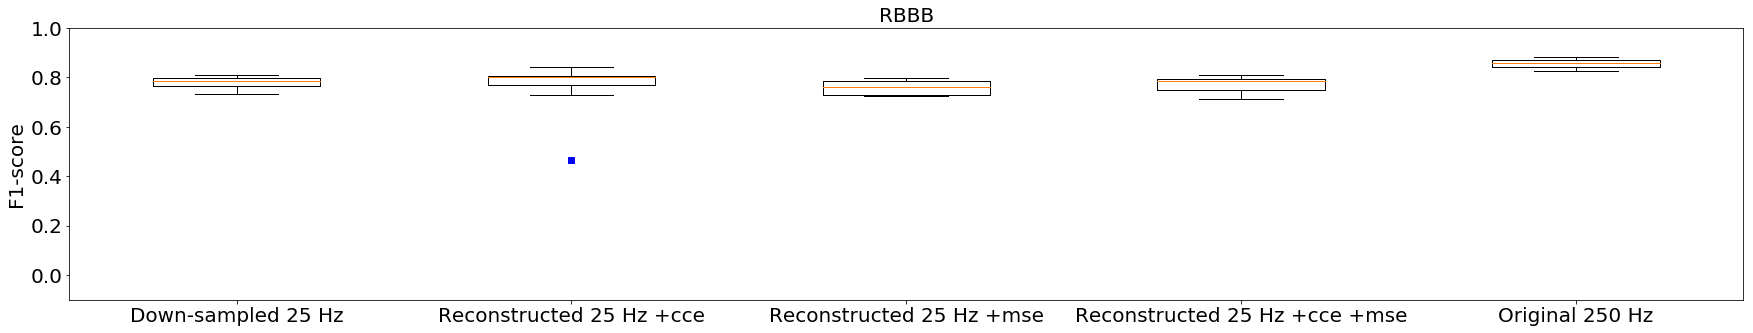

[0.78736282 0.80260795 0.76213386 0.78649887 0.85864136]
nan*
nan**
90#**
[4.99725477e-07 2.30465485e-02 3.33872046e-06 4.52146468e-06
 1.00000000e+00]


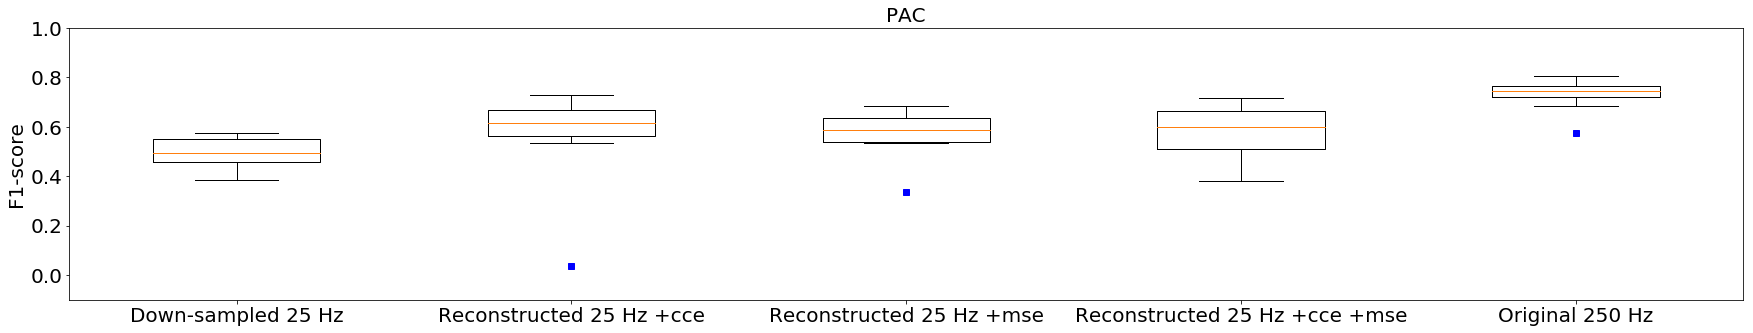

[0.49210353 0.61700767 0.58702588 0.60117057 0.7463808 ]
nan*
nan**
91#**
[1.00354701e-05 2.81244212e-02 2.09644388e-04 1.91019932e-04
 1.00000000e+00]


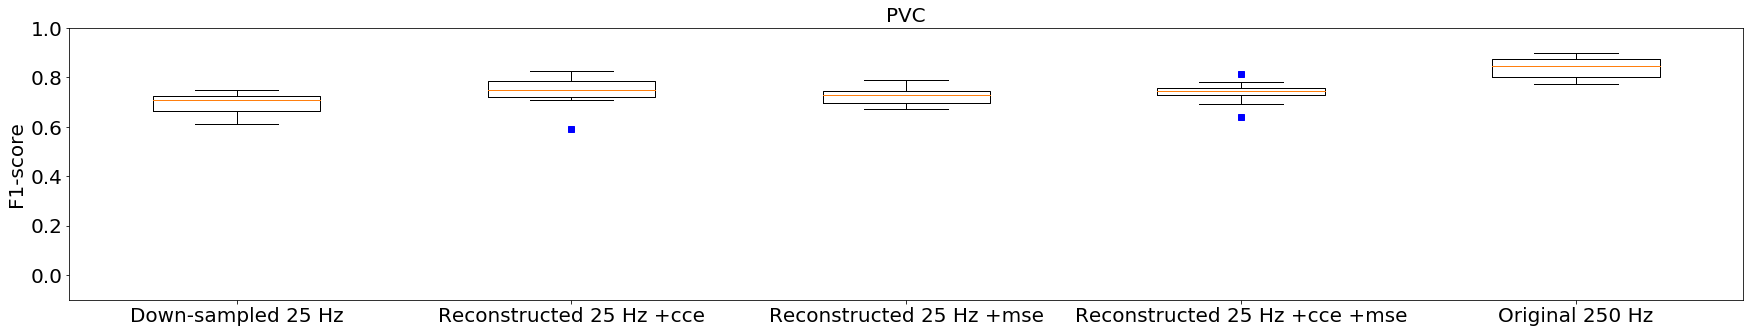

[0.70692348 0.74709302 0.73032581 0.74456277 0.84745763]
nan*
nan**
97#**
[4.80721380e-05 5.45091586e-04 1.85507064e-05 1.09507231e-06
 1.00000000e+00]


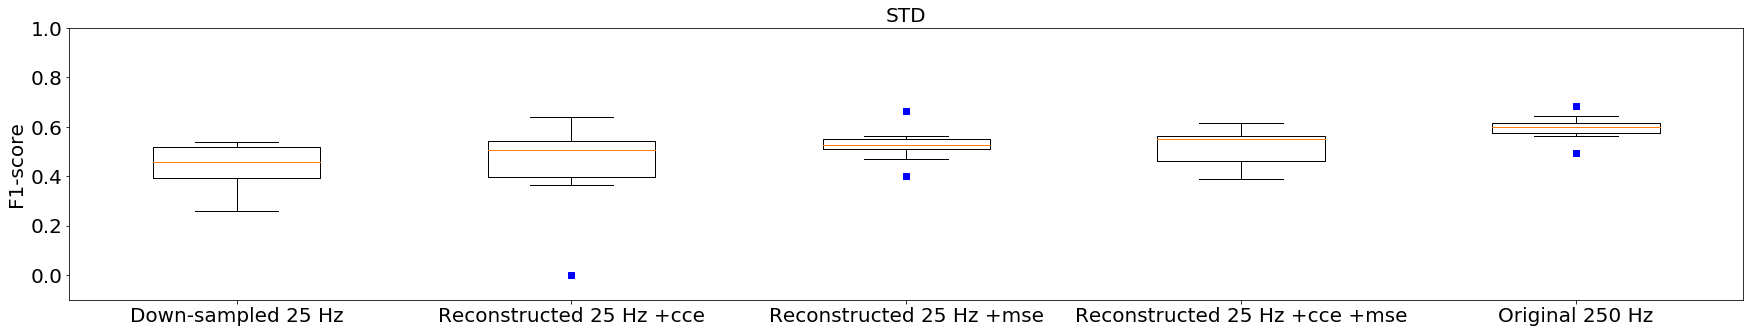

[0.45704962 0.50624366 0.52497985 0.55044435 0.59907979]
nan*
nan**
107#**
[1.03057302e-03 2.54271370e-02 7.89461876e-04 4.54102353e-04
 1.00000000e+00]


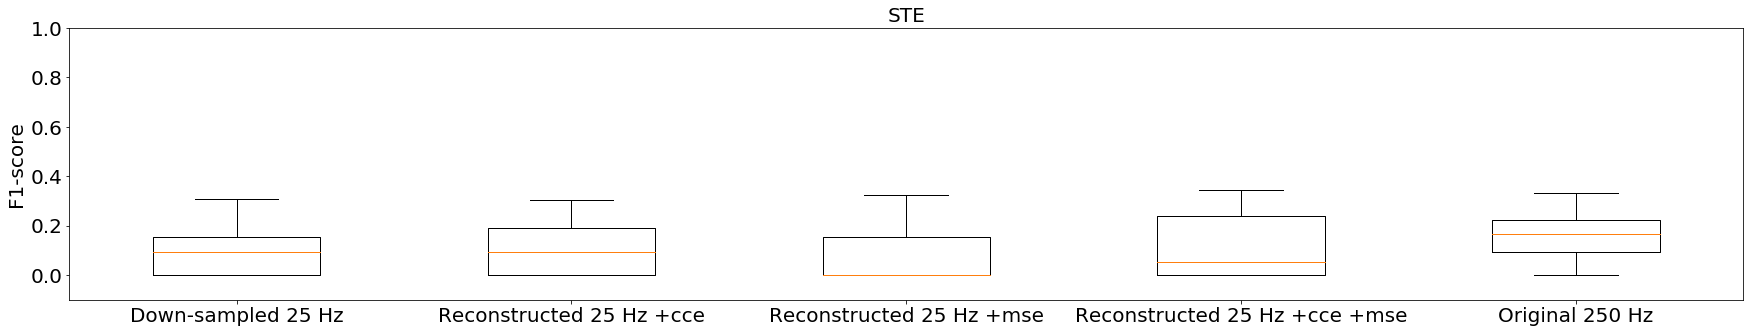

[0.0952381  0.0952381  0.         0.05263158 0.16783217]
nan*
nan**
0#
[0.09846995 0.0890961  0.09200842 0.29668127 1.        ]


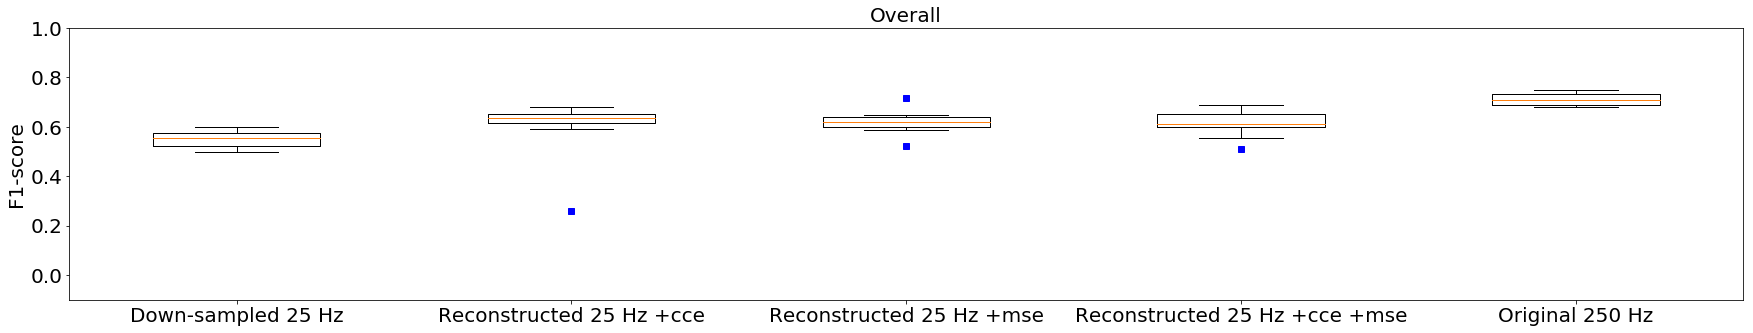

[0.55294673 0.63619473 0.61955644 0.61344237 0.70954901]
nan*
nan**
104#**
[6.33342426e-07 2.41695630e-02 4.26214510e-05 7.39318640e-05
 1.00000000e+00]
Lead :V3


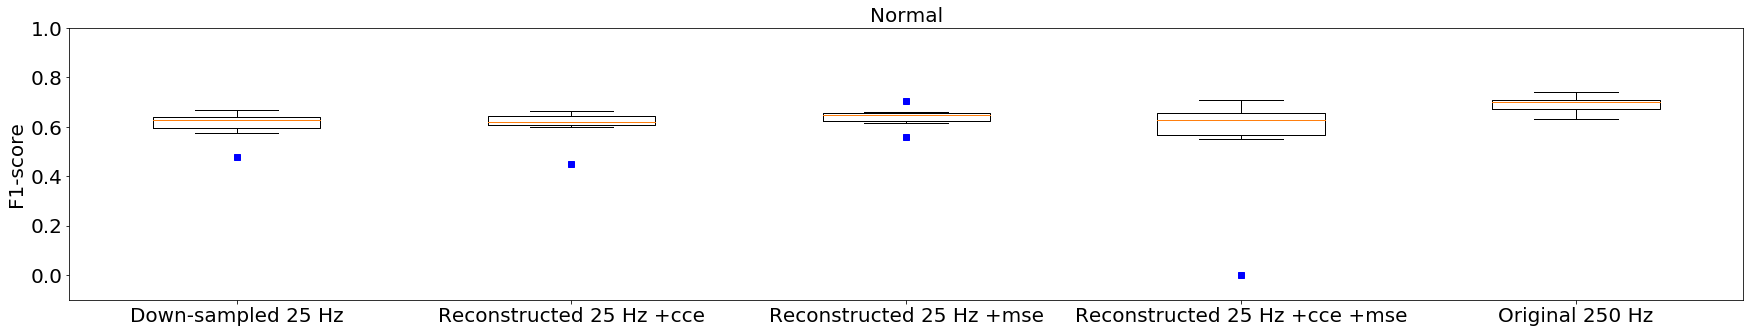

[0.62881307 0.61909582 0.64855099 0.62855889 0.70032696]
nan*
nan**
121#
[1.83524714e-03 5.95563927e-03 3.65355209e-05 8.92229042e-02
 1.00000000e+00]


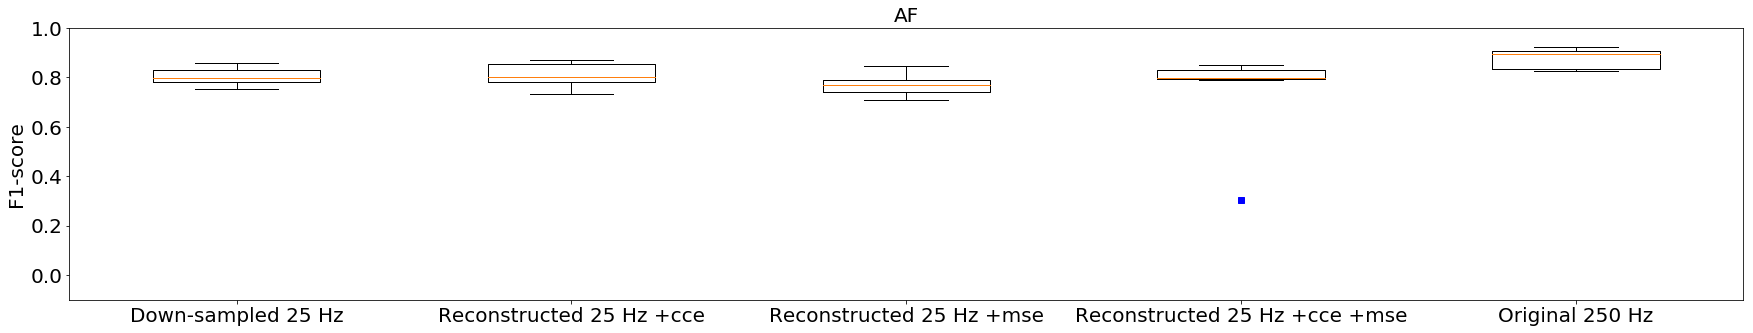

[0.79903846 0.79976072 0.77009771 0.79903846 0.8939951 ]
nan*
nan**
55#
[7.70160657e-05 1.69687494e-04 3.92978043e-08 6.08943537e-02
 1.00000000e+00]


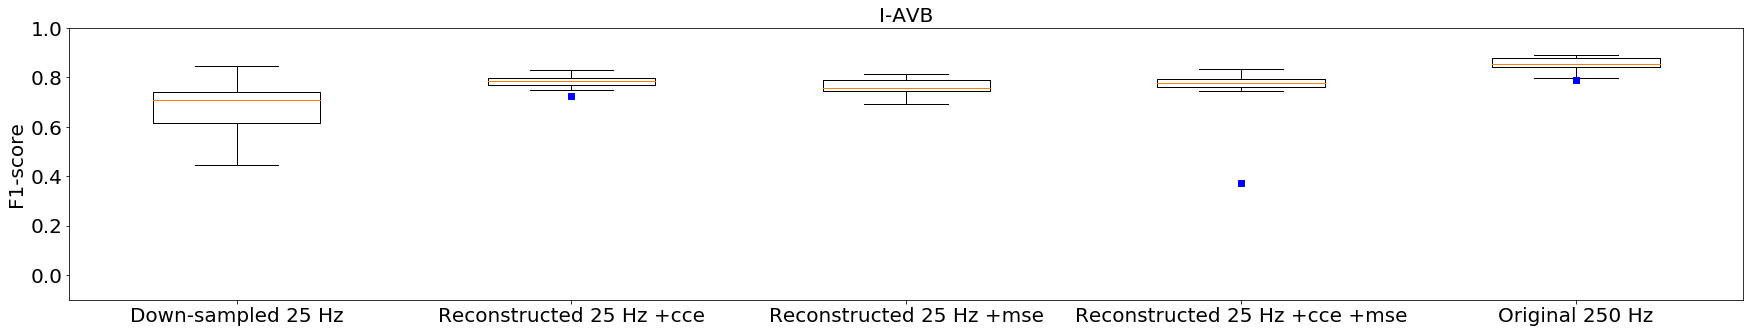

[0.70844227 0.7866609  0.75875235 0.77925926 0.85592869]
nan*
nan**
70#*
[1.23778867e-03 6.67938354e-04 1.96349460e-05 3.39275252e-02
 1.00000000e+00]


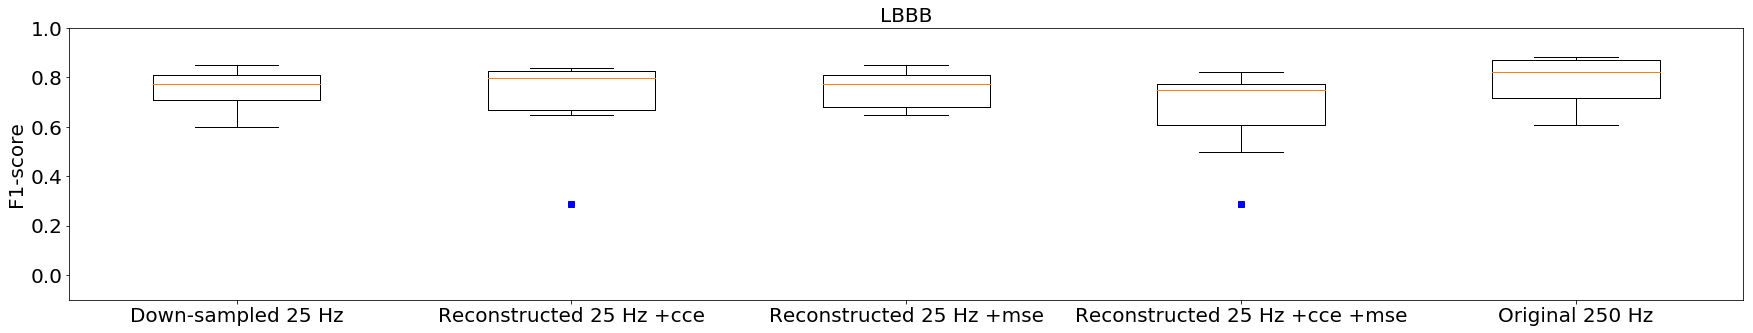

[0.77350427 0.7993448  0.77142857 0.74901961 0.82207207]
nan*
nan**
64#*
[0.24625726 0.1053467  0.20711946 0.04938295 1.        ]


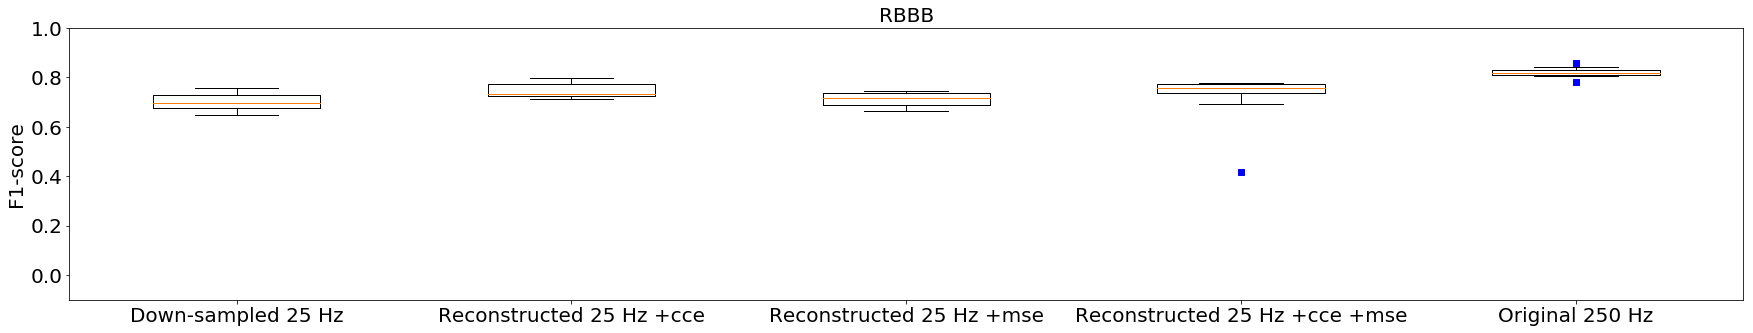

[0.69499106 0.7346872  0.71677433 0.75640025 0.81949733]
nan*
nan**
60#*
[9.06560471e-07 1.98352778e-06 1.04552388e-07 1.70715053e-02
 1.00000000e+00]


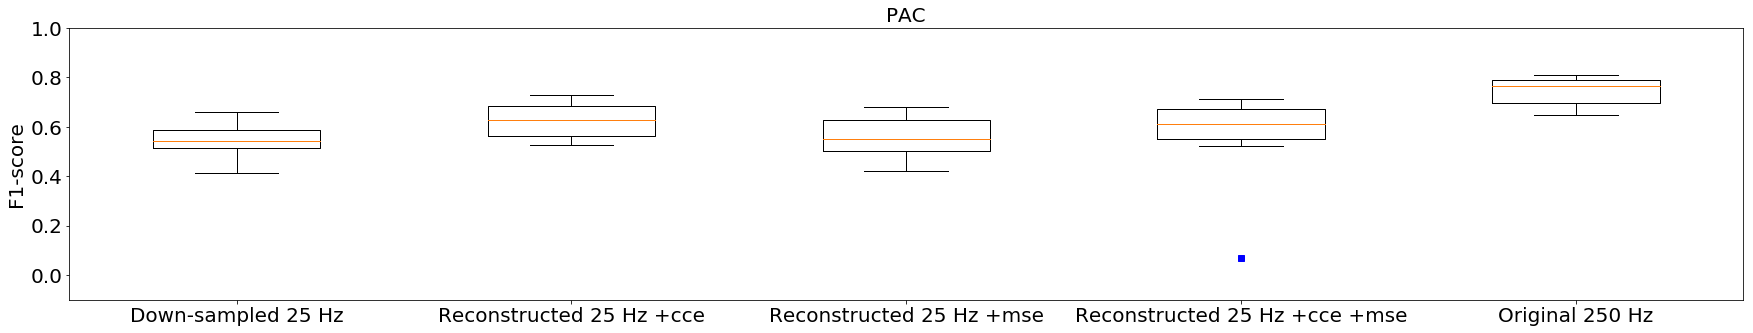

[0.54423077 0.62764284 0.55075758 0.61037234 0.76713928]
nan*
nan**
67#*
[1.10955256e-05 4.35016648e-05 1.03521625e-05 1.21562643e-02
 1.00000000e+00]


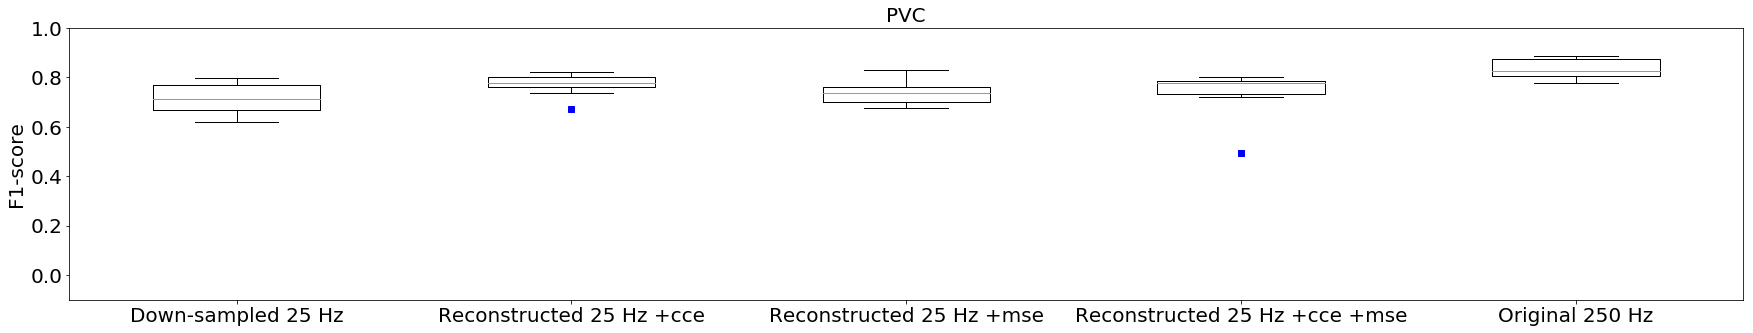

[0.71186441 0.77713875 0.73794668 0.776874   0.82572464]
nan*
nan**
78#**
[1.26658278e-04 5.91726068e-04 7.12519284e-06 6.29946114e-03
 1.00000000e+00]


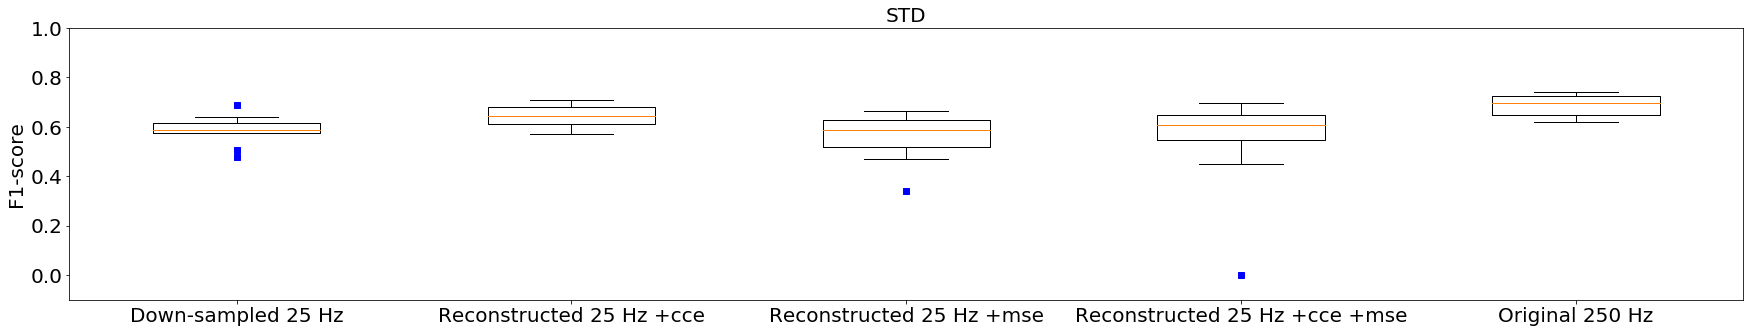

[0.58915608 0.64423423 0.58656642 0.60806452 0.69725725]
nan*
nan**
70#
[2.59752929e-04 1.01255875e-02 1.88819451e-03 5.13645604e-02
 1.00000000e+00]


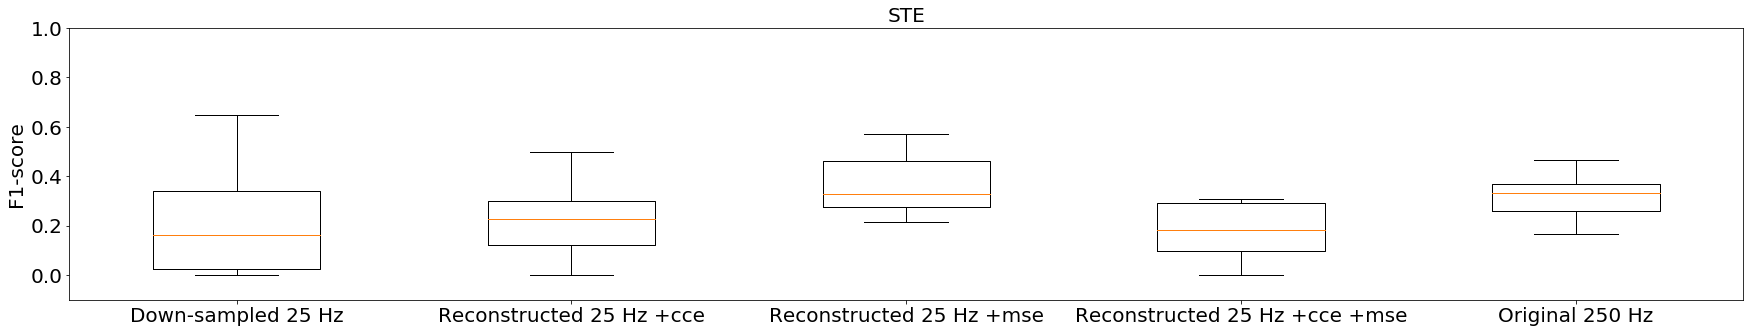

[0.16190476 0.22720898 0.32666667 0.18306636 0.33142857]
nan*
nan**
-79#*
[0.22297    0.11637817 0.30066549 0.03164871 1.        ]


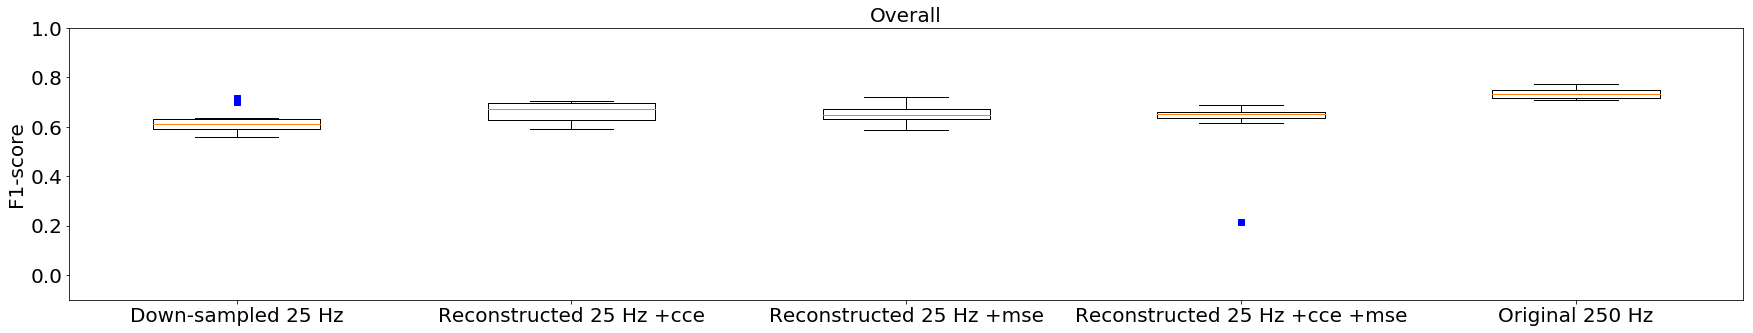

[0.61036016 0.67381763 0.64816307 0.65215184 0.73456931]
nan*
nan**
91#*
[4.50796413e-05 2.42026828e-05 2.92314201e-06 2.60726407e-02
 1.00000000e+00]
Lead :V4


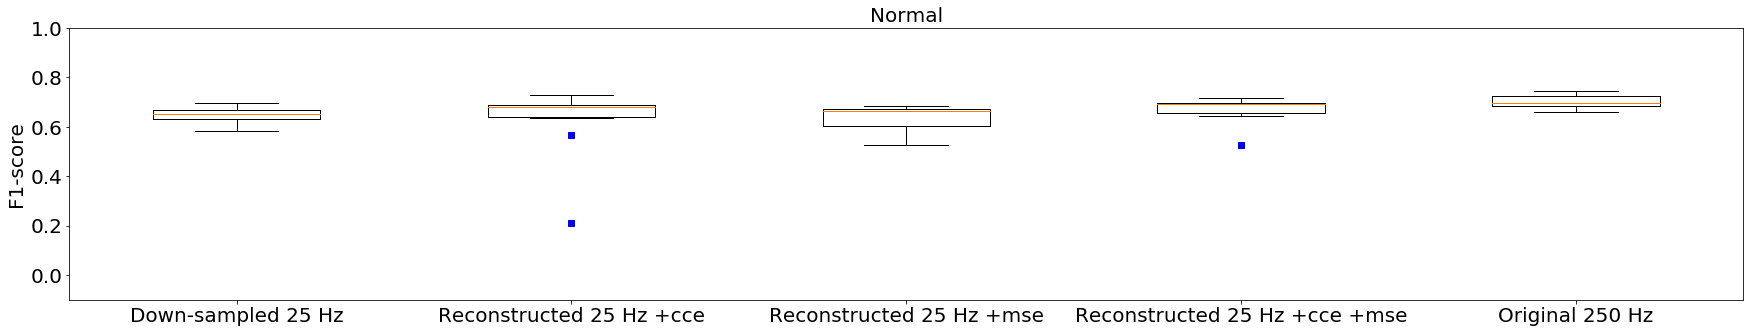

[0.65006002 0.67907289 0.66268369 0.69062212 0.69728845]
nan*
nan**
24#
[2.88063838e-04 1.57842003e-01 3.55057504e-03 6.89655429e-02
 1.00000000e+00]


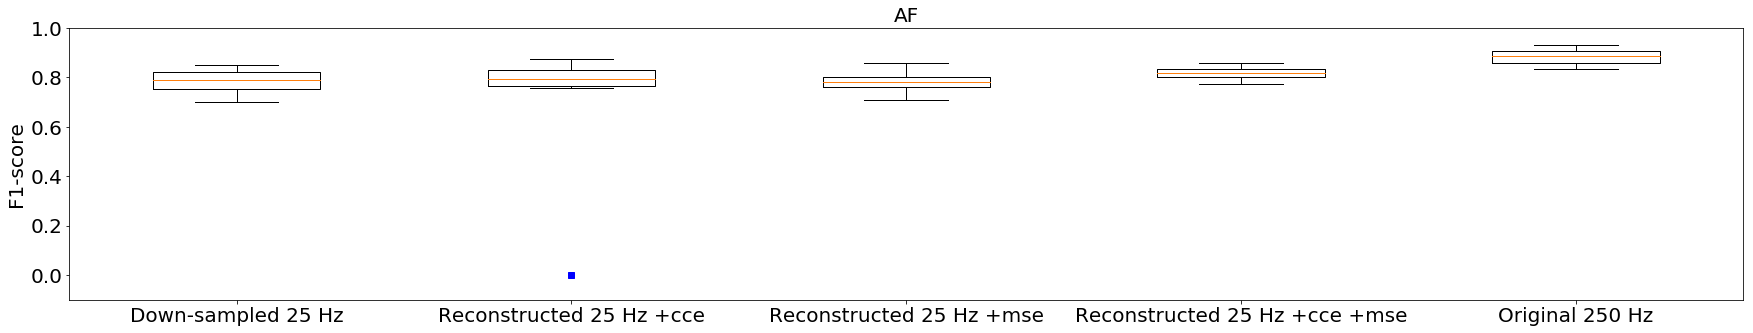

[0.78932677 0.79246728 0.78255405 0.81863337 0.88774341]
nan*
nan**
64#**
[1.00970432e-05 6.86287901e-02 1.99594696e-05 2.80811709e-05
 1.00000000e+00]


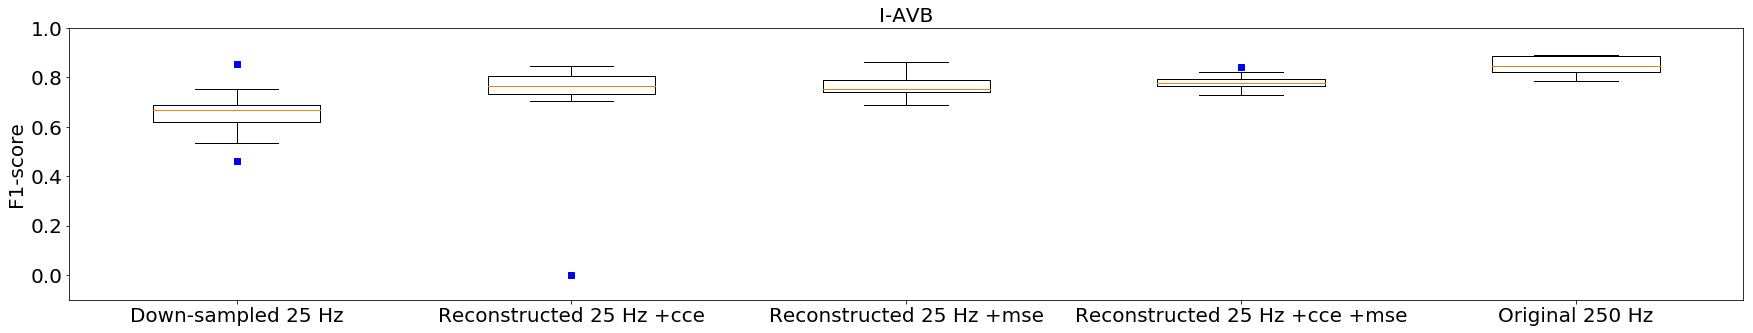

[0.66666667 0.76629477 0.75139649 0.77777778 0.84806713]
nan*
nan**
70#**
[4.05623301e-04 6.82377536e-02 1.11619540e-04 4.34961256e-05
 1.00000000e+00]


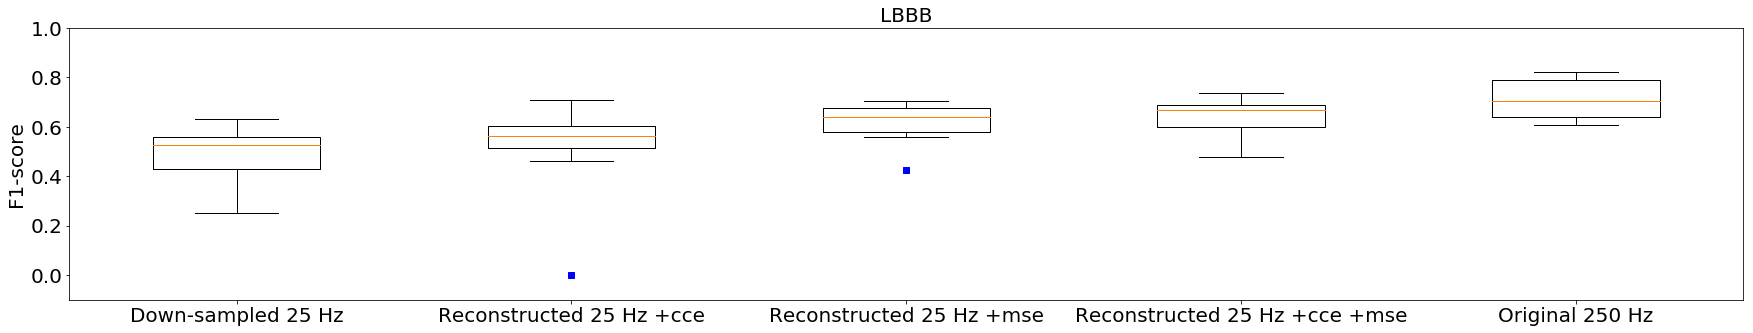

[0.52592593 0.56157635 0.6413975  0.66642959 0.70542636]
nan*
nan**
90#*
[0.00120564 0.02367031 0.00213758 0.02145373 1.        ]


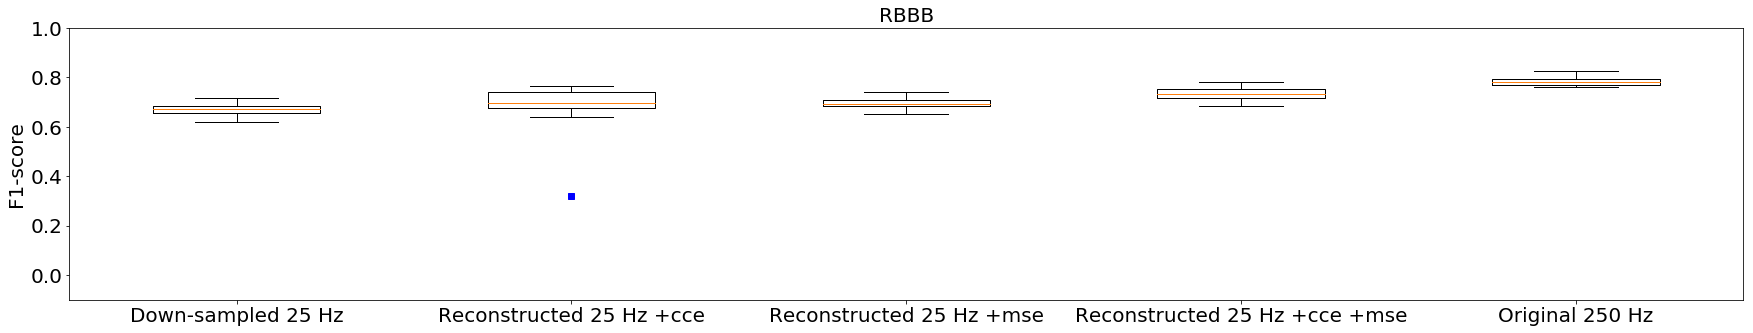

[0.67343278 0.69568798 0.69137636 0.73328852 0.78166188]
nan*
nan**
53#**
[5.82677245e-09 2.70203901e-02 4.87054649e-06 9.88269368e-05
 1.00000000e+00]


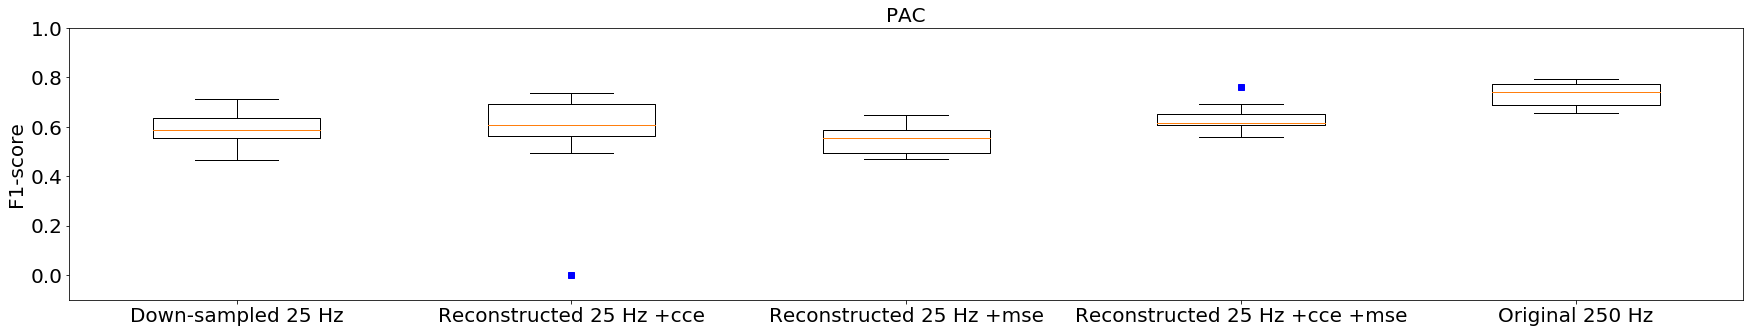

[0.58537978 0.6087619  0.55586207 0.61477892 0.7399032 ]
nan*
nan**
47#**
[6.46845395e-05 4.59403547e-02 2.06911503e-05 7.88050599e-04
 1.00000000e+00]


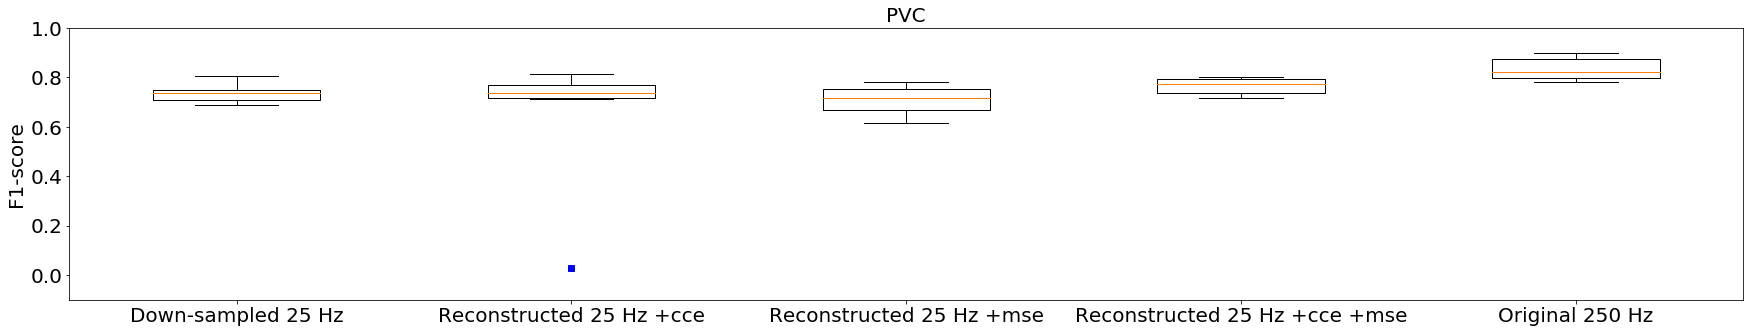

[0.73509643 0.73851162 0.71544715 0.77485929 0.82046036]
nan*
nan**
63#**
[5.18415236e-07 5.76543120e-02 3.15842455e-05 1.65771222e-05
 1.00000000e+00]


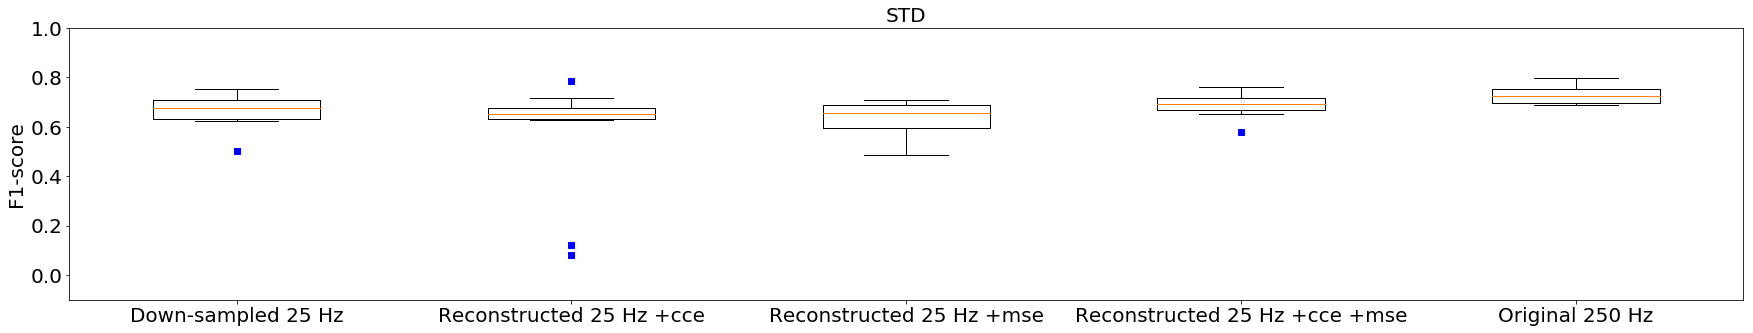

[0.67696736 0.65306122 0.65513845 0.69358788 0.72434211]
nan*
nan**
37#*
[0.00889015 0.07145592 0.00467274 0.01660647 1.        ]


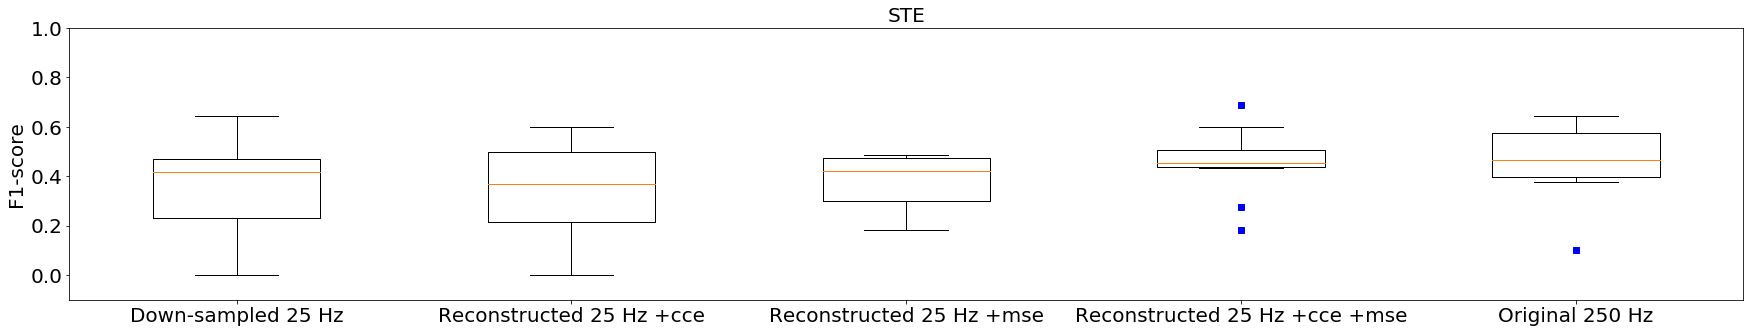

[0.41522989 0.3691351  0.42222222 0.45437788 0.46713287]
nan*
nan**
38#
[0.22411561 0.047868   0.05056046 0.86111394 1.        ]


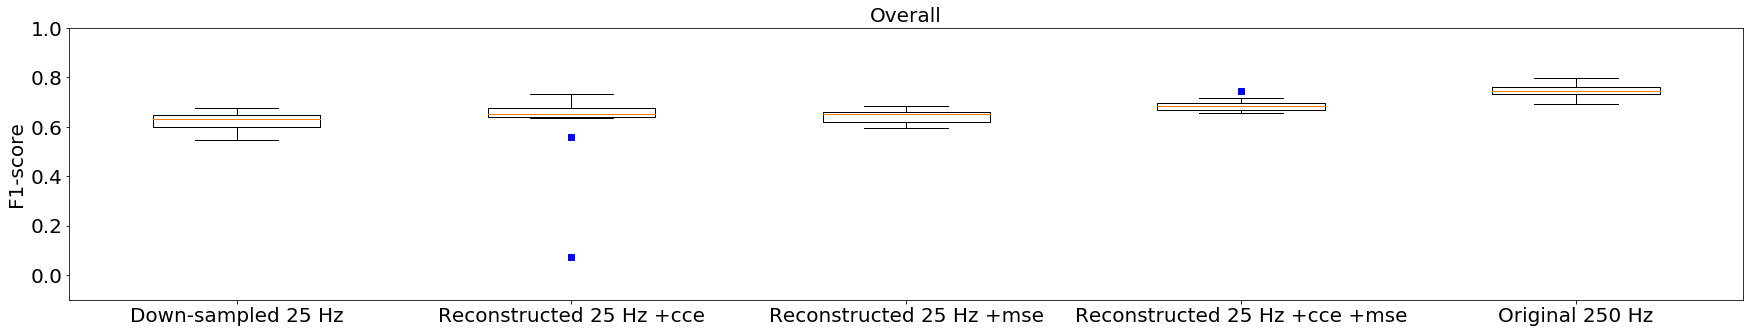

[0.6334107  0.65180323 0.65000401 0.68481383 0.74352235]
nan*
nan**
49#**
[1.51946957e-05 4.26665015e-02 8.69138823e-07 9.58984061e-06
 1.00000000e+00]
Lead :V5


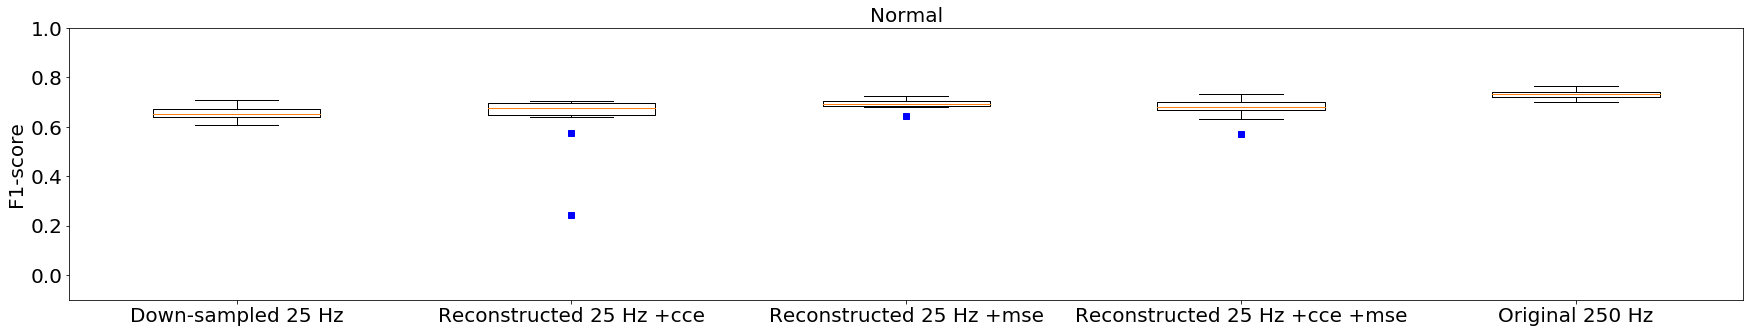

[0.65057818 0.67474472 0.69393505 0.68220222 0.73244656]
nan*
nan**
-127#**
[1.01932896e-04 5.03190294e-02 2.47620115e-04 7.20517367e-03
 1.00000000e+00]


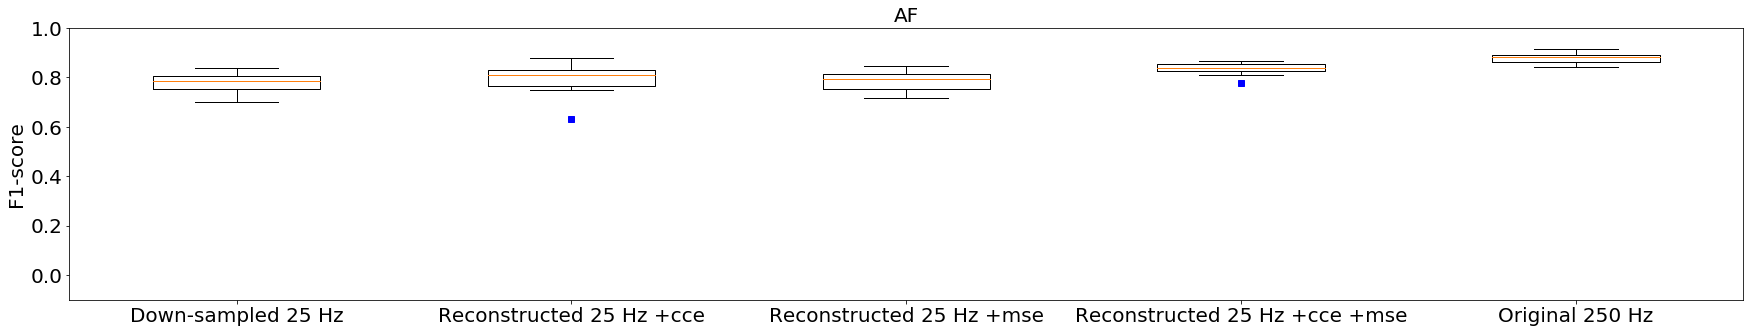

[0.78416383 0.81065644 0.79197356 0.83951129 0.88163265]
nan*
nan**
60#**
[3.62003866e-06 5.19149488e-03 2.19635294e-05 1.60278905e-03
 1.00000000e+00]


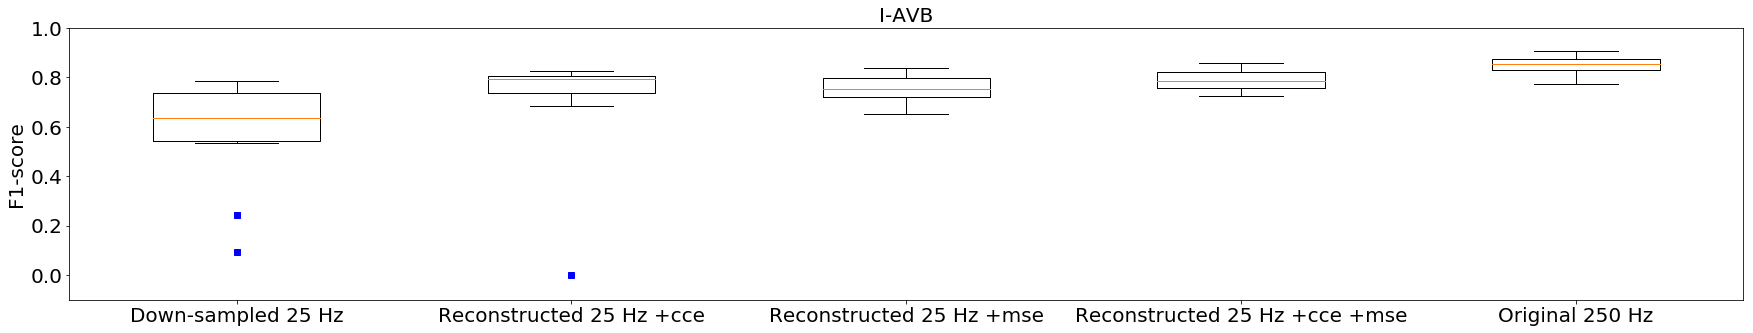

[0.6369191  0.79552239 0.75362319 0.78582677 0.85619349]
nan*
nan**
66#**
[3.35651347e-03 1.02829236e-01 3.81474724e-05 4.81610616e-06
 1.00000000e+00]


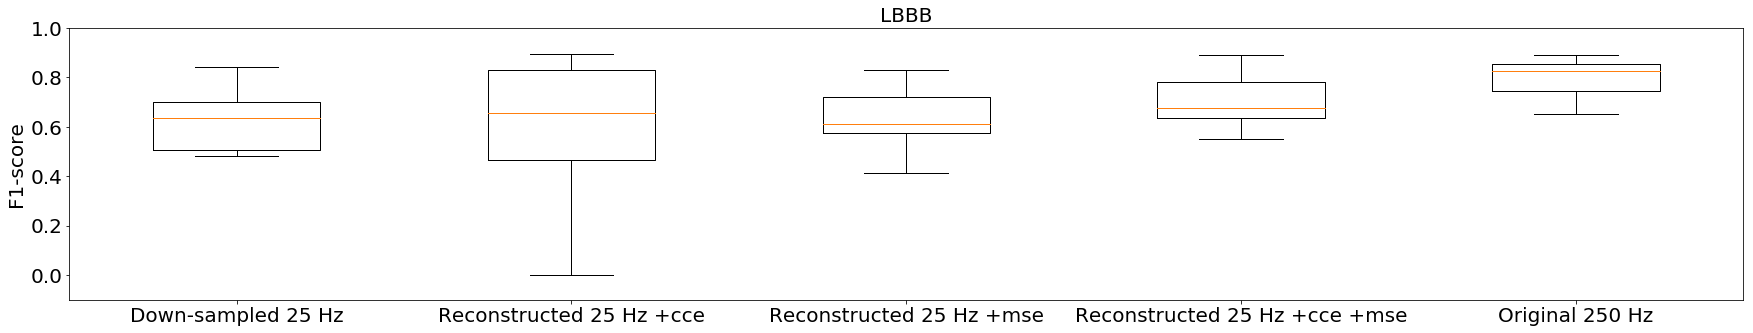

[0.63430127 0.65686275 0.61047028 0.67619048 0.82645804]
nan*
nan**
50#*
[1.25005788e-03 6.13520917e-02 8.24205500e-04 1.24180105e-02
 1.00000000e+00]


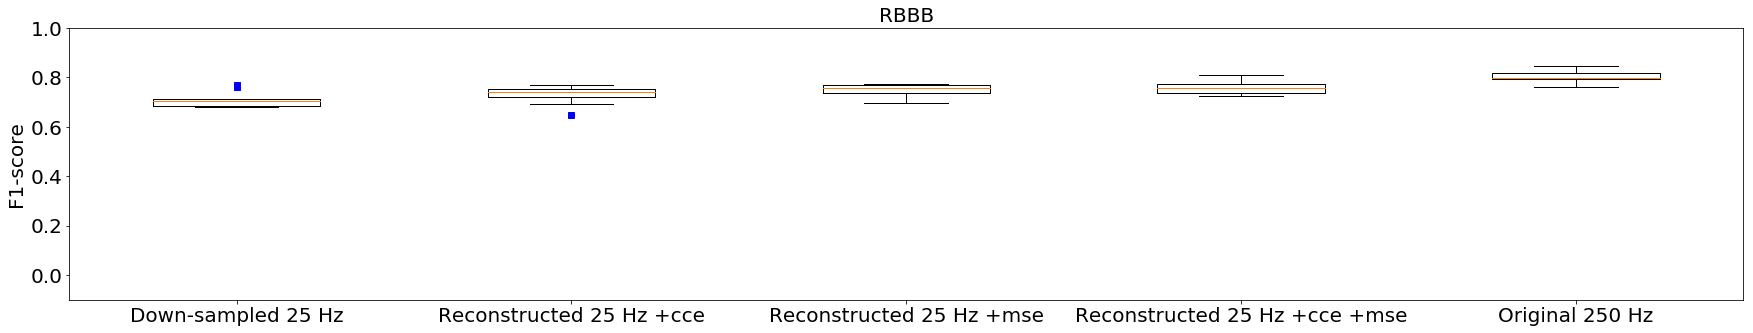

[0.70395499 0.74298467 0.75614637 0.75667939 0.79733883]
nan*
nan**
77#**
[9.92477064e-05 1.20232044e-03 1.78489908e-04 1.77924225e-04
 1.00000000e+00]


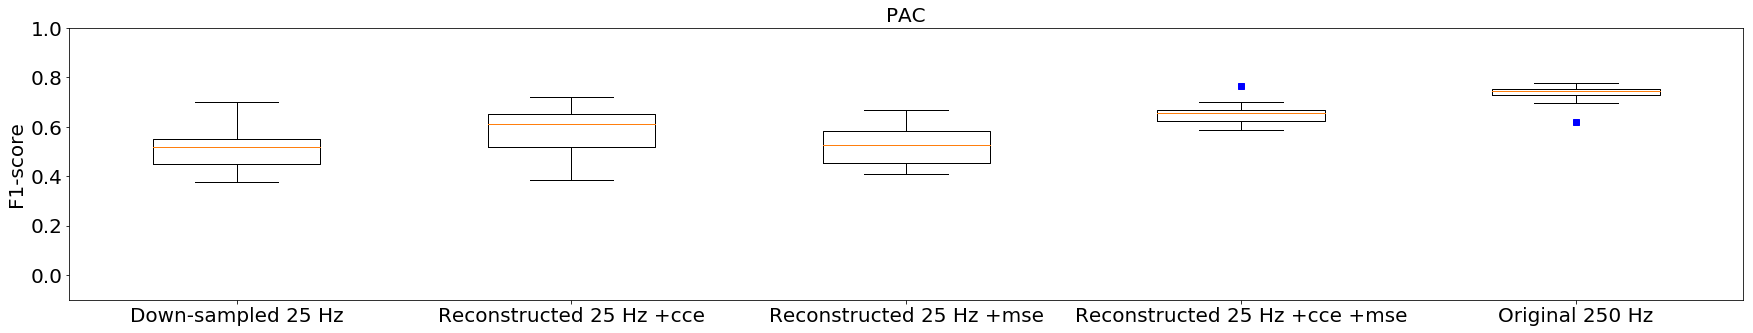

[0.51856298 0.6114235  0.52783669 0.65650447 0.74442703]
nan*
nan**
36#**
[1.69981163e-04 2.76235596e-03 3.86529751e-05 1.19581110e-03
 1.00000000e+00]


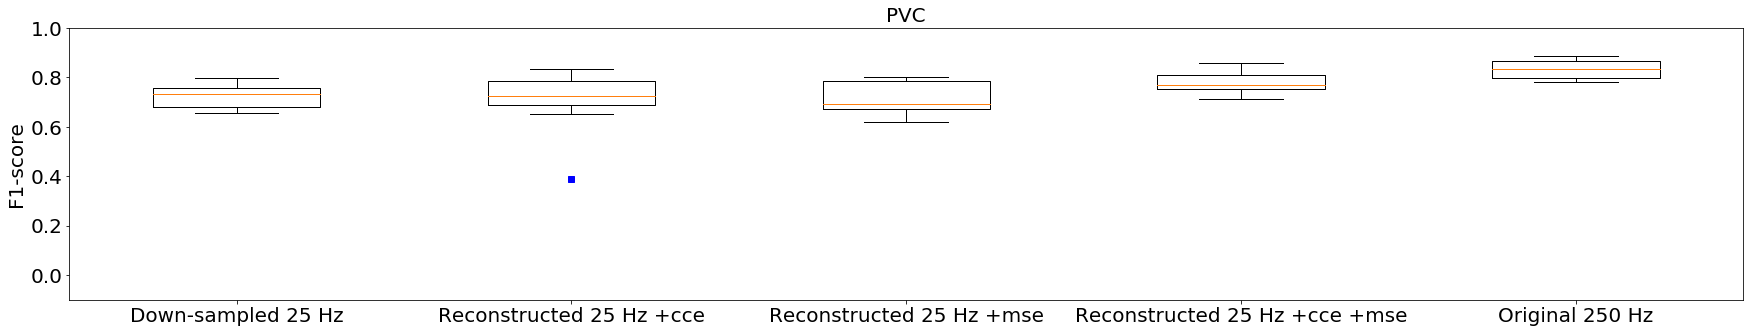

[0.73120856 0.72326359 0.69412568 0.77118644 0.83311209]
nan*
nan**
42#**
[7.48679377e-06 1.44813009e-02 1.16336929e-04 1.84620080e-03
 1.00000000e+00]


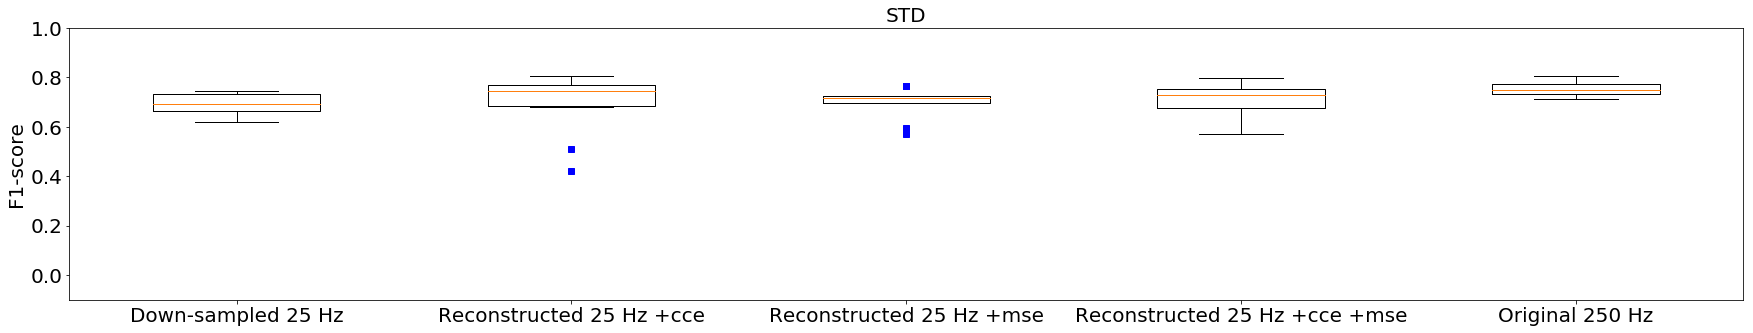

[0.69436851 0.743379   0.71792119 0.72688663 0.74778107]
nan*
nan**
39#*
[8.58872821e-04 1.36680700e-01 8.93664942e-03 2.52251379e-02
 1.00000000e+00]


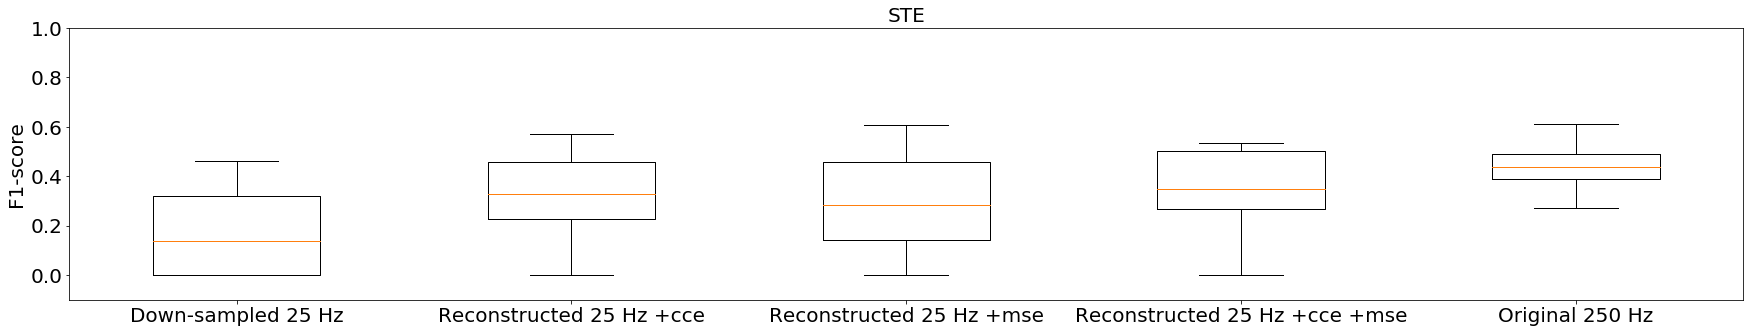

[0.13852814 0.32671958 0.28428094 0.34975369 0.43766578]
nan*
nan**
94#*
[0.00228456 0.04188496 0.01045741 0.01987218 1.        ]


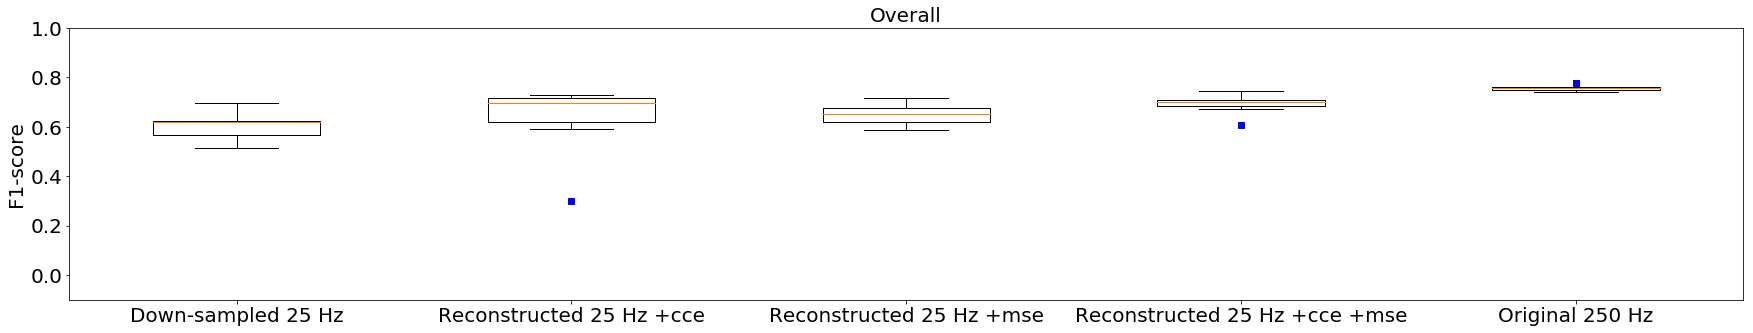

[0.61785668 0.69575555 0.65160754 0.69919646 0.75528723]
nan*
nan**
60#**
[3.24290354e-06 2.14766485e-02 8.19478046e-06 6.98789004e-05
 1.00000000e+00]
Lead :V6


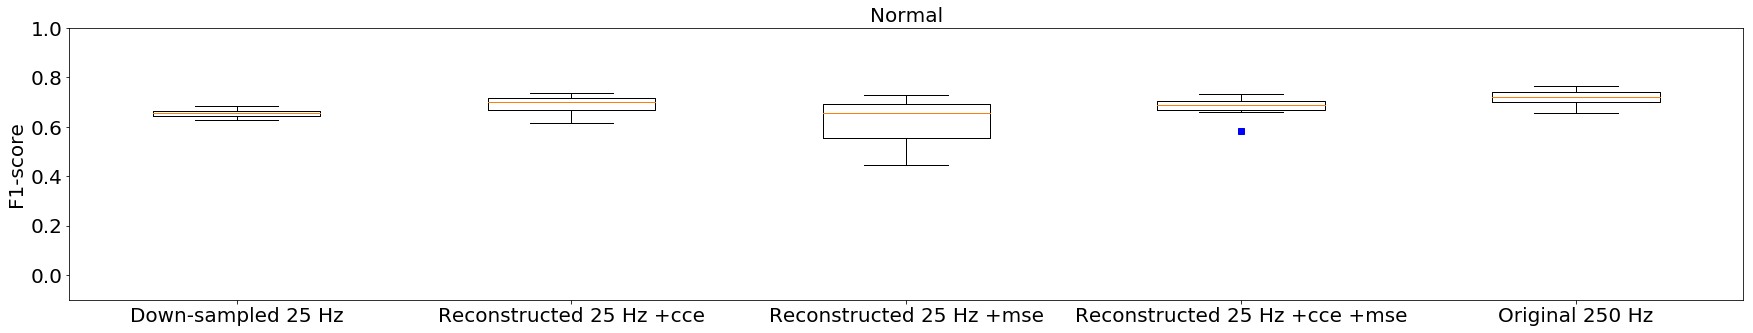

[0.65672618 0.70171958 0.655      0.6885918  0.72108462]
nan*
nan**
53#**
[4.41762705e-04 1.50971939e-02 3.50321033e-03 3.79637548e-03
 1.00000000e+00]


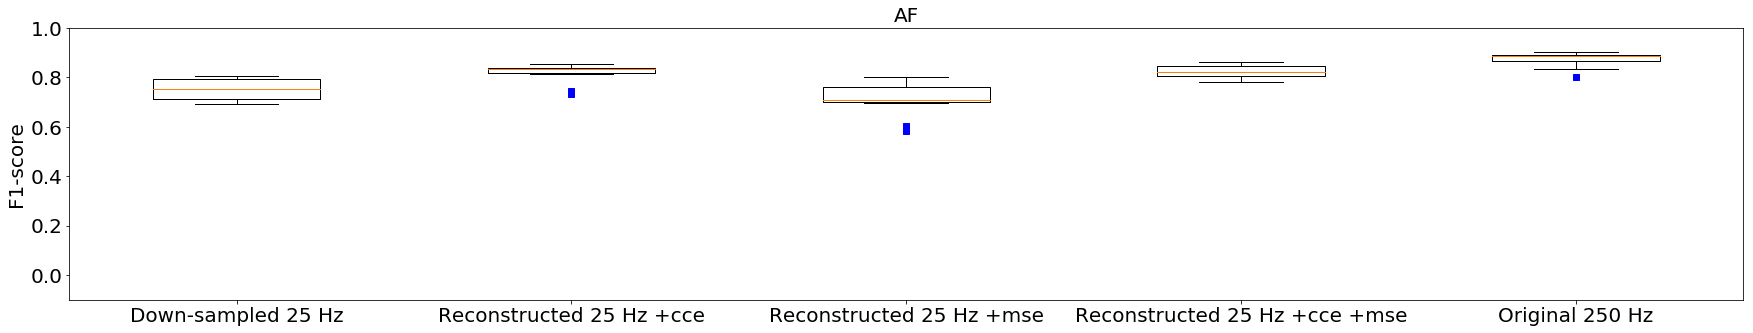

[0.75435897 0.8320578  0.70792016 0.8225426  0.88606881]
nan*
nan**
31#**
[1.85418844e-05 5.12355238e-04 1.65772003e-05 3.49381428e-05
 1.00000000e+00]


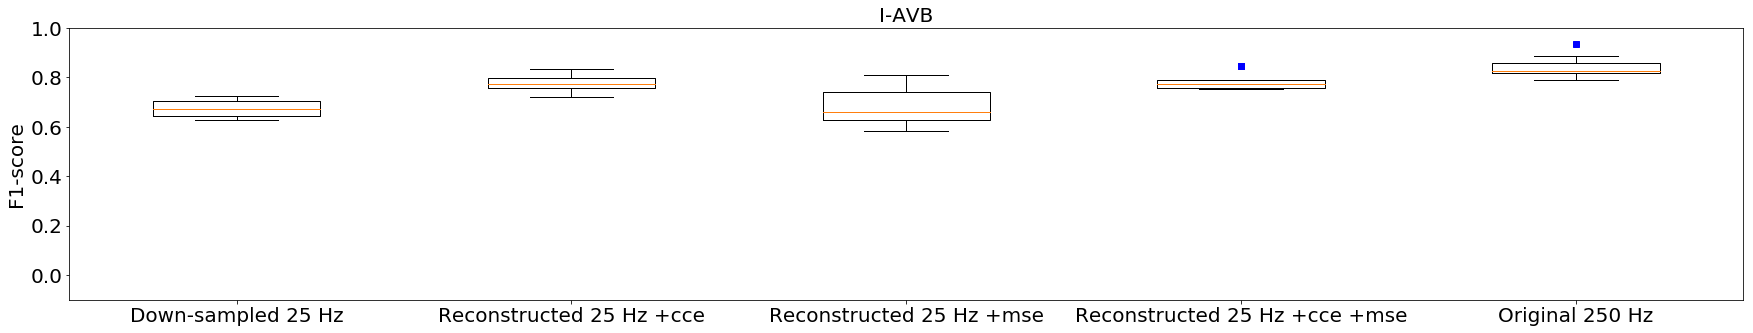

[0.67384306 0.77346939 0.6593958  0.77170592 0.82612125]
nan*
nan**
34#**
[9.14146088e-06 1.19627189e-04 2.57149732e-06 1.01454133e-04
 1.00000000e+00]


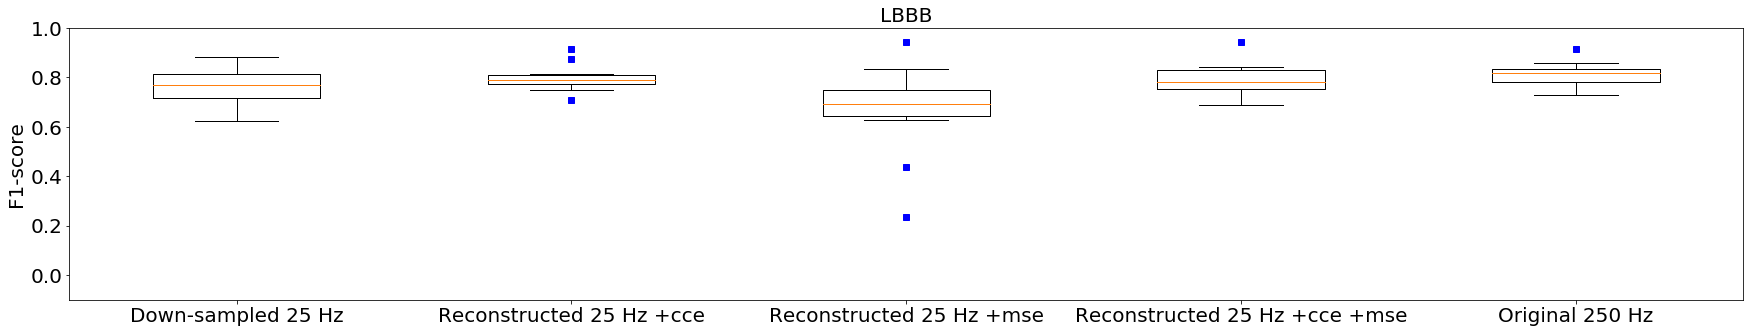

[0.76893939 0.78867624 0.69345661 0.78103617 0.81717011]
nan*
nan**
4#
[0.01519347 0.41122162 0.02338742 0.2457996  1.        ]


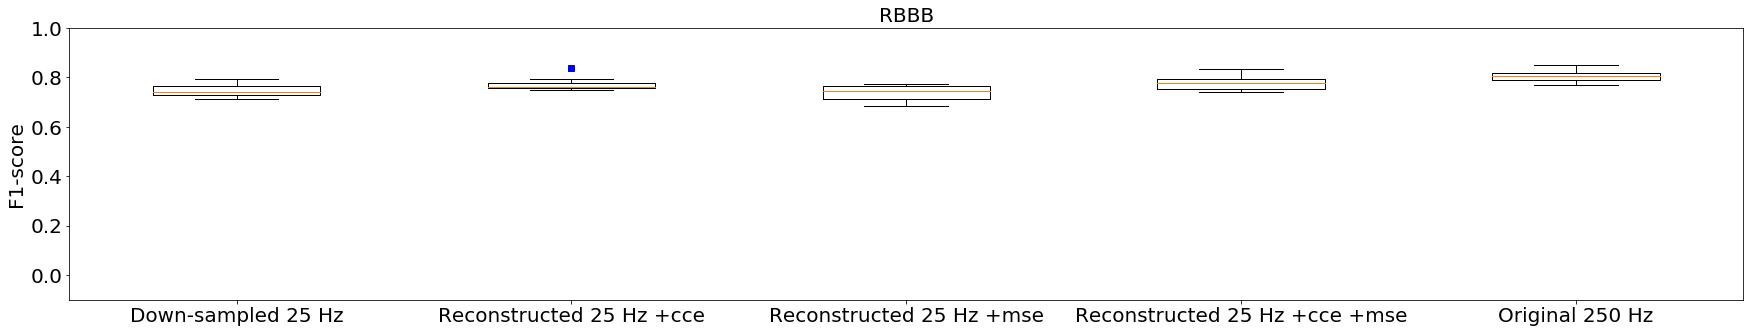

[0.742389   0.76107165 0.74672017 0.77852349 0.80750389]
nan*
nan**
35#**
[3.09142050e-05 2.54736585e-03 1.19810464e-04 1.72288092e-03
 1.00000000e+00]


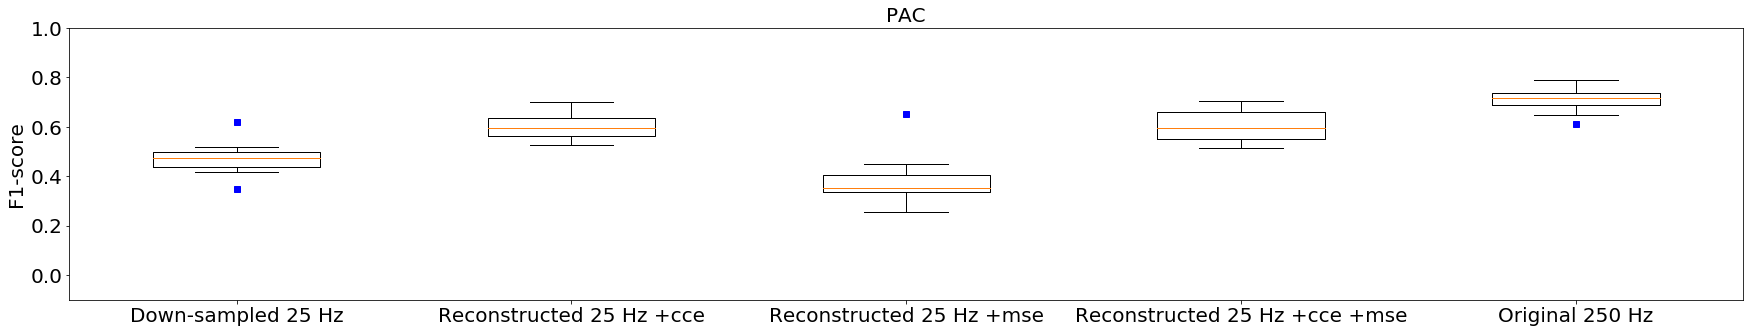

[0.47438902 0.59571429 0.35054852 0.5952381  0.71767057]
nan*
nan**
37#**
[1.09057402e-05 1.91387081e-04 6.36953343e-06 3.16559109e-04
 1.00000000e+00]


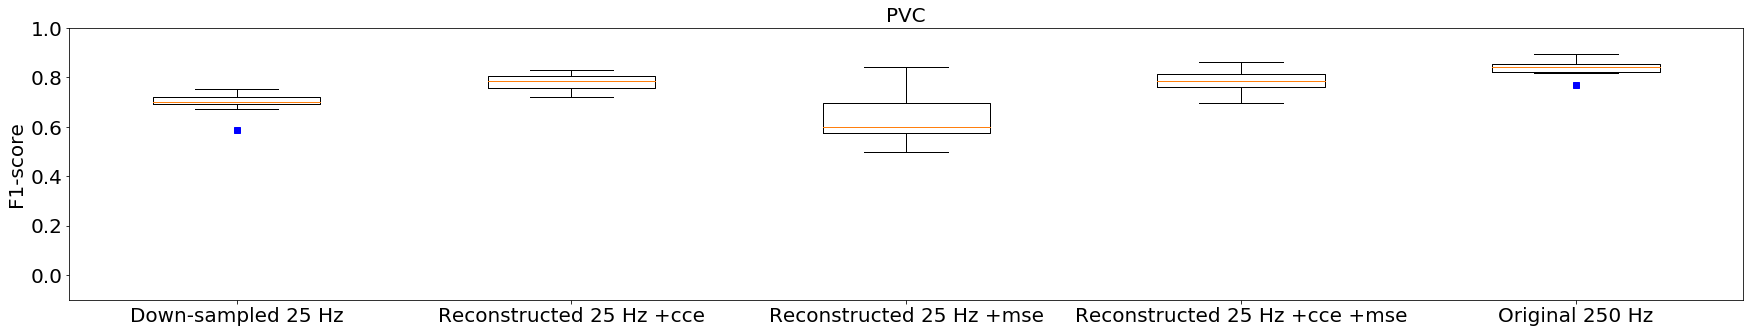

[0.70250488 0.78713551 0.59868875 0.78411737 0.84113046]
nan*
nan**
24#**
[8.82352609e-06 3.02920217e-05 3.52344187e-05 6.30334373e-04
 1.00000000e+00]


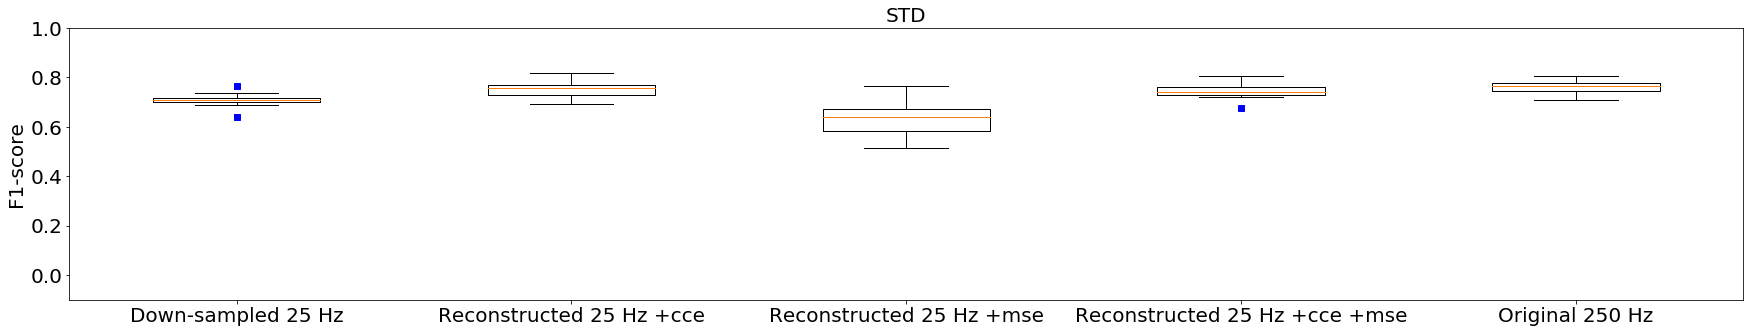

[0.70887598 0.75908497 0.64026696 0.73949789 0.76627157]
nan*
nan**
20#
[0.00789101 0.37365529 0.00208479 0.10810865 1.        ]


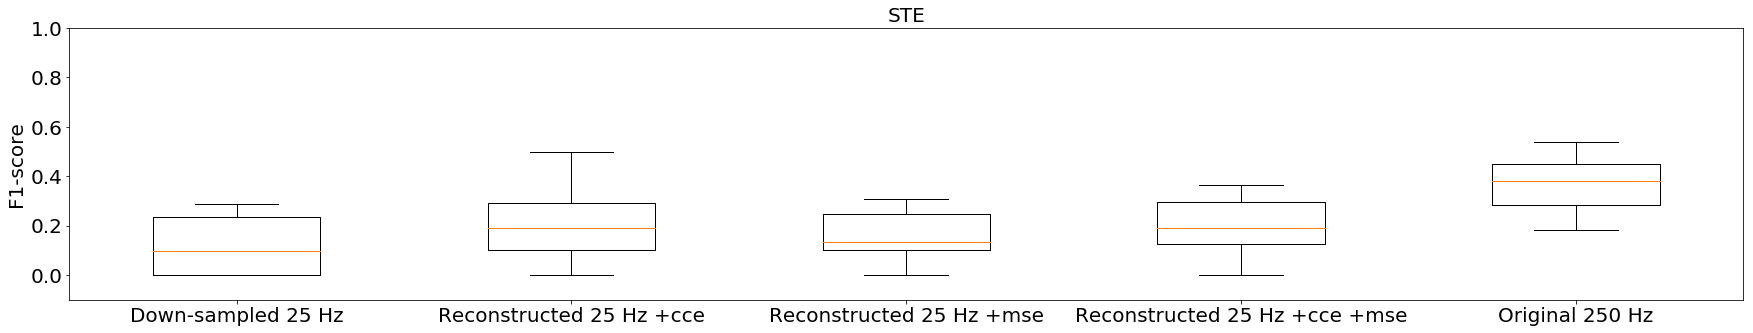

[0.09761905 0.19047619 0.13263158 0.19047619 0.38224638]
nan*
nan**
51#**
[2.64571090e-04 1.71776739e-02 4.42577393e-03 9.11143218e-03
 1.00000000e+00]


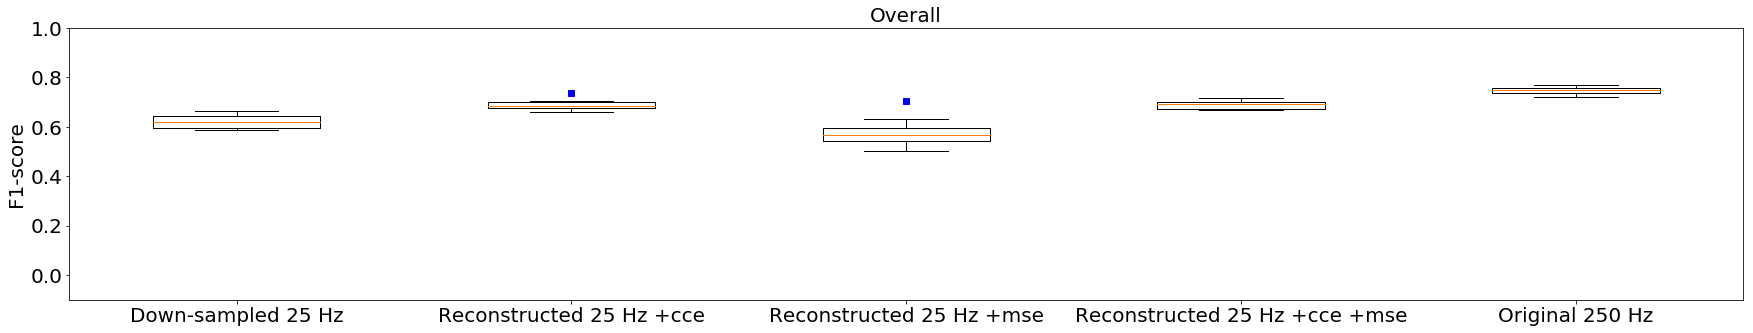

[0.61872292 0.68608911 0.56740063 0.69081344 0.75074419]
nan*
nan**
35#**
[7.18956185e-08 3.28654441e-05 4.95423804e-06 2.34391531e-07
 1.00000000e+00]


((12, 10), (12, 10), (12, 10))

In [ ]:
#box-plotting
%matplotlib inline
BIGGER_SIZE = 20
Hz = np.asarray([500,250,125,100,50,25,10,5,2,1])
HzLabel = np.asarray(['500Hz','250Hz','150Hz','100Hz','50Hz','25Hz','10Hz','5Hz','2Hz','1Hz'])
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
titleList = ['Normal','AF', 'I-AVB','LBBB','RBBB','PAC','PVC','STD','STE','Overall']
Types = ['Down-sampled 25 Hz', 'Reconstructed 25 Hz +cce', 'Reconstructed 25 Hz +mse', 'Reconstructed 25 Hz +cce +mse', 'Original 250 Hz']

matrixForTable_005 = []
matrixForTable_001 = []
matrixForTable_PPR = []
for i in range(12):
    if i not in TargetLead:
        continue
    print('Lead :'+leadsLabel[i])
    subMatrixForTable_005 = []
    subMatrixForTable_001 = []
    subMatrixForTable_PPR = []
    for j in range(10):
        scoreList_and_average = np.concatenate((np.load('./comparison/CPSC2018_25HzTo250HzRecover_10_fold_lead_models_test_result_lead_new_lossComparison'+str(leadsLabel[i])+'.npy').T,np.asarray([np.mean(np.load('./comparison/CPSC2018_25HzTo250HzRecover_10_fold_lead_models_test_result_lead_new_lossComparison'+str(leadsLabel[i])+'.npy'),axis =2).T])),axis = 0)[j]
        fig = plt.figure(figsize=(30,5))
        bplot = plt.boxplot(scoreList_and_average.T.tolist(),
                    notch=False,  # box instead of notch shape
                    sym='bs',     # red squares for outliers
                    vert=True)   # horizontal box aligmnent
        plt.xticks([x+1 for x in range(len(Types))],Types, size=BIGGER_SIZE)
        plt.yticks(fontsize=BIGGER_SIZE)
        plt.ylim((-0.1, 1))
#         plt.xlabel('Sampling Frequency', size=BIGGER_SIZE)
        plt.ylabel('F1-score', size=BIGGER_SIZE)
        t = plt.title(titleList[j], size=BIGGER_SIZE)
        plt.show()
        print(np.median(scoreList_and_average,axis = 0))
        paired_ttest_to_best = np.asarray([stats.ttest_rel(scoreList_and_average[:,-1], scoreList_and_average[:,i])[1] for i in range(scoreList_and_average.shape[1])])
        paired_ttest_to_best[-1] = 1
        try:
            bestHz_005 = Types[paired_ttest_to_best<0.05][-1].astype('str')
        except:
            bestHz_005 = 'nan'
        try:
            bestHz_001 = Types[paired_ttest_to_best<0.01][-1].astype('str')
        except:
            bestHz_001 = 'nan'
        try:
            PPR = np.median((scoreList_and_average[:,-2]-scoreList_and_average[:,-1])/(scoreList_and_average[:,-3] - scoreList_and_average[:,-1]),axis = 0)
            PPR = np.round(PPR*100, 0).astype('int8').astype('str')
        except:
            PPR = 'nan'
        if np.median(scoreList_and_average[:,-3], axis = 0) - np.median(scoreList_and_average[:,-1], axis = 0) <= 0 :
            bestHz_005 += '*'
            bestHz_001 += '**'
            PPR += '#'
        if paired_ttest_to_best[-2] <0.05:
            PPR += '*'
            if paired_ttest_to_best[-2] <0.01:
                PPR += '*'
        print(bestHz_005)
        print(bestHz_001)
        print(PPR)
        subMatrixForTable_005.append(bestHz_005)
        subMatrixForTable_001.append(bestHz_001)
        subMatrixForTable_PPR.append(PPR)
        print(paired_ttest_to_best)
    matrixForTable_005.append(subMatrixForTable_005)
    matrixForTable_001.append(subMatrixForTable_001)
    matrixForTable_PPR.append(subMatrixForTable_PPR)
matrixForTable_005 = np.asarray(matrixForTable_005)
matrixForTable_001 = np.asarray(matrixForTable_001)
matrixForTable_PPR = np.asarray(matrixForTable_PPR)
matrixForTable_005.shape, matrixForTable_001.shape, matrixForTable_PPR.shape

In [ ]:
#Cross-validation on test set
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
# Types = ['Down-sampled 25 Hz', 'Reconstructed 25 Hz +zero', 'Reconstructed 25 Hz +slinear', 'Reconstructed 25 Hz +quadratic', 'Reconstructed 25 Hz +cubic', 'Reconstructed 25 Hz +cce', 'Reconstructed 25 Hz +mse', 'Reconstructed 25 Hz +cce +mse', 'Original 250 Hz']
Types = ['Down-sampled 25 Hz','Reconstructed 25 Hz +zero', 'Reconstructed 25 Hz +slinear', 'Reconstructed 25 Hz +quadratic', 'Reconstructed 25 Hz +cubic', 'Original 250 Hz']
Hz = np.asarray([500,250,125,100,50,25,10,5,2,1])
FoldIndicesList = np.load('./FoldIndicesList.npy')
x_test_from_train = X_list[selectedSampled[9]].copy()
x_test_from_train_original, length_original = Step(x_test_from_train,500//Hz[1])
x_test_from_train_downSampled, length_downSampled = Step(x_test_from_train,500//Hz[5])
model = MetforNet121(36000)
model_SR = ecgsr(3600, num_filters=64, num_res_blocks=16)
model_25 = MetforNet121(3600)
for j in range(12):
    if j not in TargetLead:
        continue
    TypeList = []
    TypeList2 = []
    for k in tqdm(Types):
        scoreList = []
        scoreList2 = []
        for i in range(10):
            model_name = './benchmark/CPSC2018_10_fold_model_lead_'+str(leadsLabel[j])+'_Hz_'+str(Hz[1])+'_fold_'+str(i)
            model.load_weights(model_name)
            if k == 'Original 250 Hz' :
                x_test_from_train_temp = x_test_from_train_original[FoldIndicesList[i][1]][:,:,j:j+1]

            elif k == 'Reconstructed 25 Hz +zero' :
                x_test_from_train_temp = np.zeros(x_test_from_train_original[FoldIndicesList[i][1]][:,:,j:j+1].shape)
                s = length_original//length_downSampled
                for p in range(x_test_from_train_temp.shape[0]):
                    interpolationF = interpolate.interp1d(np.arange(0, length_downSampled), x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1][p,:,0], kind='zero')
                    x_test_from_train_temp[p,s:,0] = interpolationF(np.arange(0, length_downSampled-1, length_downSampled/length_original))

            elif k == 'Reconstructed 25 Hz +slinear' :
                x_test_from_train_temp = np.zeros(x_test_from_train_original[FoldIndicesList[i][1]][:,:,j:j+1].shape)
                s = length_original//length_downSampled
                for p in range(x_test_from_train_temp.shape[0]):
                    interpolationF = interpolate.interp1d(np.arange(0, length_downSampled), x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1][p,:,0], kind='slinear')
                    x_test_from_train_temp[p,s:,0] = interpolationF(np.arange(0, length_downSampled-1, length_downSampled/length_original))

            elif k == 'Reconstructed 25 Hz +quadratic' :
                x_test_from_train_temp = np.zeros(x_test_from_train_original[FoldIndicesList[i][1]][:,:,j:j+1].shape)
                s = length_original//length_downSampled
                for p in range(x_test_from_train_temp.shape[0]):
                    interpolationF = interpolate.interp1d(np.arange(0, length_downSampled), x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1][p,:,0], kind='quadratic')
                    x_test_from_train_temp[p,s:,0] = interpolationF(np.arange(0, length_downSampled-1, length_downSampled/length_original))

            elif k == 'Reconstructed 25 Hz +cubic' :
                x_test_from_train_temp = np.zeros(x_test_from_train_original[FoldIndicesList[i][1]][:,:,j:j+1].shape)
                s = length_original//length_downSampled
                for p in range(x_test_from_train_temp.shape[0]):
                    interpolationF = interpolate.interp1d(np.arange(0, length_downSampled), x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1][p,:,0], kind='cubic')
                    x_test_from_train_temp[p,s:,0] = interpolationF(np.arange(0, length_downSampled-1, length_downSampled/length_original))

            elif k == 'Reconstructed 25 Hz +cce +mse' :
                model_SR_name = './combined/CPSC2018_25HzTo250HzRecover_10_fold_model_lead_'+str(leadsLabel[j])+'_fold_'+str(i)
                model_SR.load_weights(model_SR_name)
                x_test_from_train_temp = model_SR.predict(x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1])
            elif k == 'Reconstructed 25 Hz +cce' :
                model_SR_name = './cce/CPSC2018_25HzTo250HzRecoverCCEonly_10_fold_model_lead_'+str(leadsLabel[j])+'_fold_'+str(i)
                model_SR.load_weights(model_SR_name)
                x_test_from_train_temp = model_SR.predict(x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1])
            elif k == 'Reconstructed 25 Hz +mse' :
                model_SR_name = './mse/CPSC2018_25HzTo250HzRecoverMSEonly_10_fold_model_lead_'+str(leadsLabel[j])+'_fold_'+str(i)
                model_SR.load_weights(model_SR_name)
                x_test_from_train_temp = model_SR.predict(x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1])

            elif k == 'Down-sampled 25 Hz' :
                model_25_name = './benchmark/CPSC2018_10_fold_model_lead_'+str(leadsLabel[j])+'_Hz_'+str(Hz[5])+'_fold_'+str(i)
                model_25.load_weights(model_25_name)
                x_test_from_train_temp = x_test_from_train_downSampled[FoldIndicesList[i][1]][:,:,j:j+1]
                y_test_from_train = Y_list[selectedSampled[9]][FoldIndicesList[i][1]].copy()
                y_true = np.argmax(y_test_from_train, axis=1)
                y_raw_pred = model_25.predict(x_test_from_train_temp)
                y_pred = np.argmax(y_raw_pred, axis=1)
                score = f1_score(y_true, y_pred, average=None)
                scoreList.append(score)
                continue
            else:
                print('Error_happpend !!!')
            y_test_from_train = Y_list[selectedSampled[9]][FoldIndicesList[i][1]].copy()
            y_true = np.argmax(y_test_from_train, axis=1)
            y_raw_pred = model.predict(x_test_from_train_temp)
            y_pred = np.argmax(y_raw_pred, axis=1)
            score = f1_score(y_true, y_pred, average=None)
            scoreList.append(score)
            score2 = np.sum((x_test_from_train_original[FoldIndicesList[i][1]][:,:,j:j+1]-x_test_from_train_temp)**2)
            scoreList2.append(score2)
        scoreList = np.asarray(scoreList)
        scoreList2 = np.asarray(scoreList2)
        TypeList.append(scoreList)
        TypeList2.append(scoreList2)
    TypeList = np.asarray(TypeList)
    TypeList2 = np.asarray(TypeList2)
    np.save('./comparison/CPSC2018_25HzTo250HzRecover_10_fold_lead_models_test_result_lead_new_traditionComparison_'+str(leadsLabel[j]),TypeList)
    np.save('./comparison/CPSC2018_25HzTo250HzRecover_10_fold_lead_models_test_result_lead_new_MSEComparison_'+str(leadsLabel[j]),TypeList2)

Lead :I


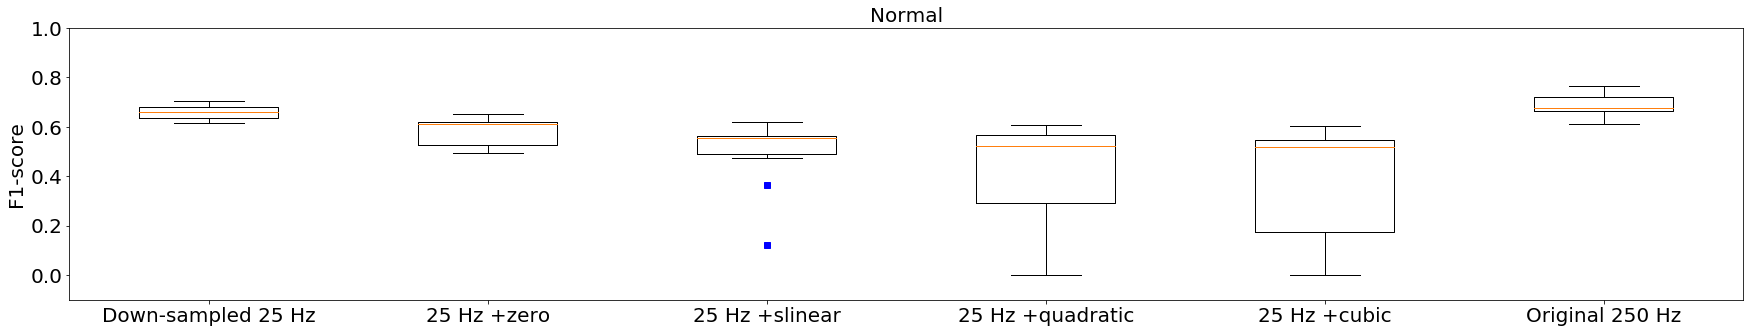

[0.6617033  0.61010409 0.55581491 0.52132822 0.51850891 0.67628377]
nan*
nan**
111#**
[6.21175660e-02 6.38423998e-04 1.59601024e-03 1.82831636e-03
 1.86671942e-03 1.00000000e+00]


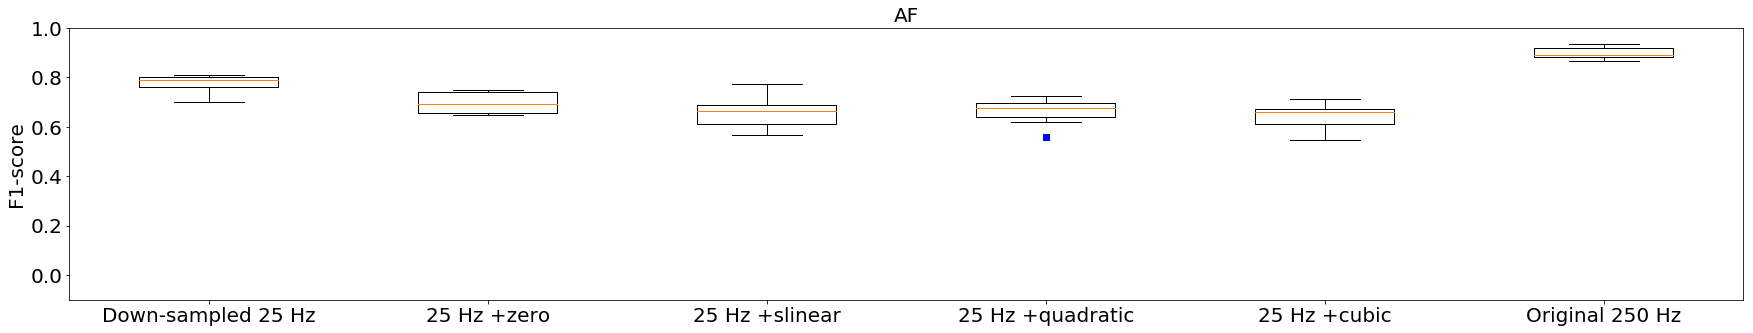

[0.78775383 0.69364528 0.66568101 0.67808418 0.66001998 0.889989  ]
nan*
nan**
110#**
[2.72284482e-05 1.77014570e-08 2.89777107e-07 1.14508637e-07
 4.80787845e-08 1.00000000e+00]


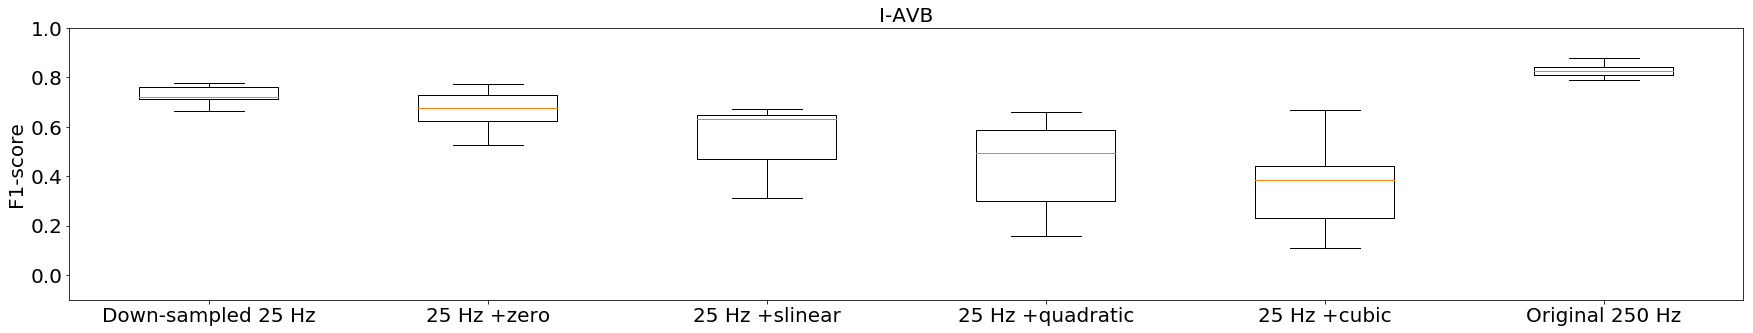

[0.72076023 0.67456152 0.63212251 0.49473451 0.38363759 0.82623733]
nan*
nan**
115#**
[1.11607806e-05 7.73806371e-05 1.72486894e-04 8.64464006e-05
 2.20951568e-05 1.00000000e+00]


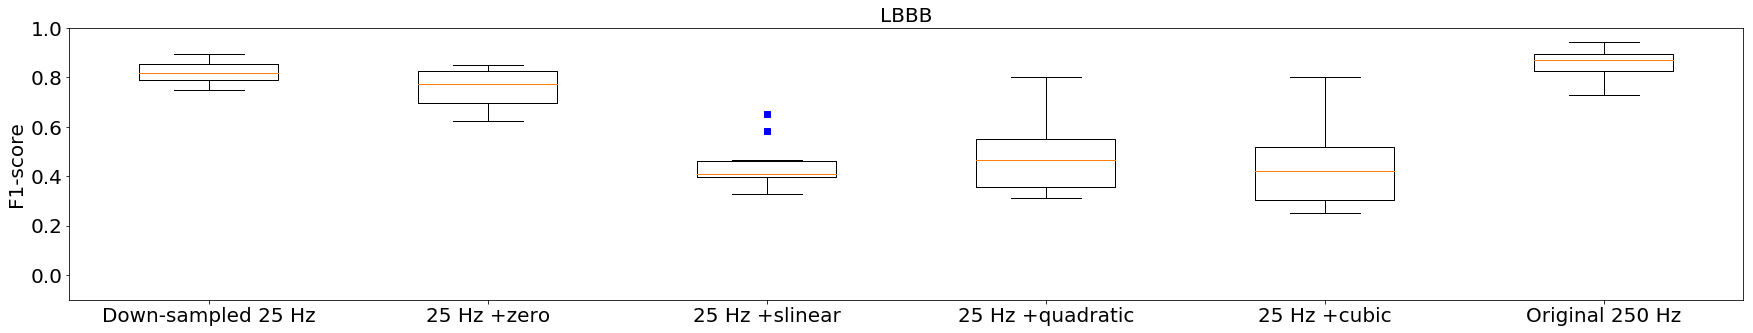

[0.81935484 0.775      0.40967366 0.46404744 0.41977528 0.8697479 ]
nan*
nan**
109#**
[6.38008645e-02 5.69769600e-03 6.81960979e-06 1.05729202e-04
 9.75105148e-05 1.00000000e+00]


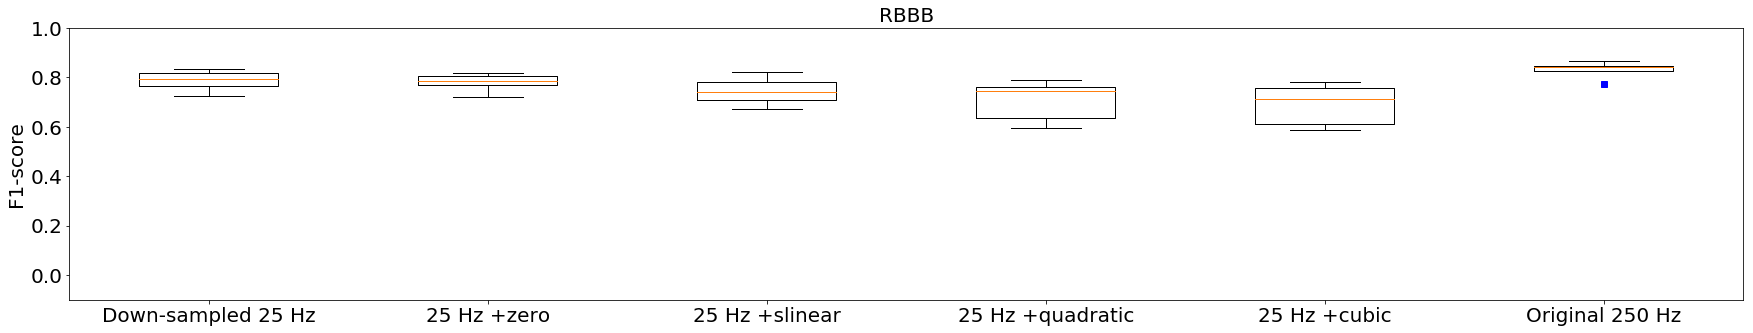

[0.79449634 0.78601996 0.739546   0.74380011 0.7118544  0.8414489 ]
nan*
nan**
111#**
[1.69206196e-04 4.36651065e-05 1.82949962e-05 1.58463993e-04
 1.37238475e-04 1.00000000e+00]


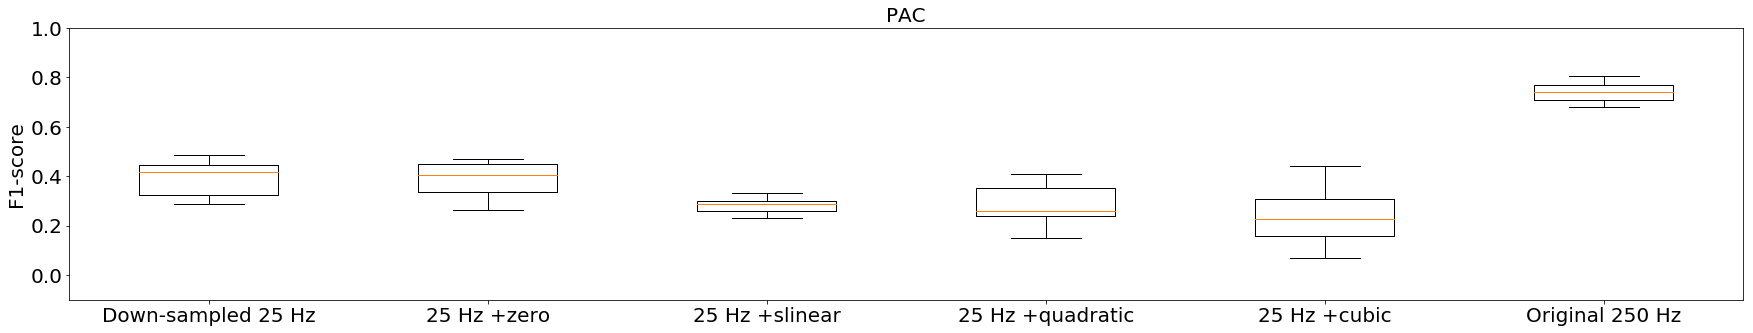

[0.4190319  0.40607055 0.28778468 0.25878972 0.22565407 0.74252137]
nan*
nan**
109#**
[4.22666608e-07 8.04690202e-09 4.82489144e-12 1.58083957e-08
 7.98226896e-08 1.00000000e+00]


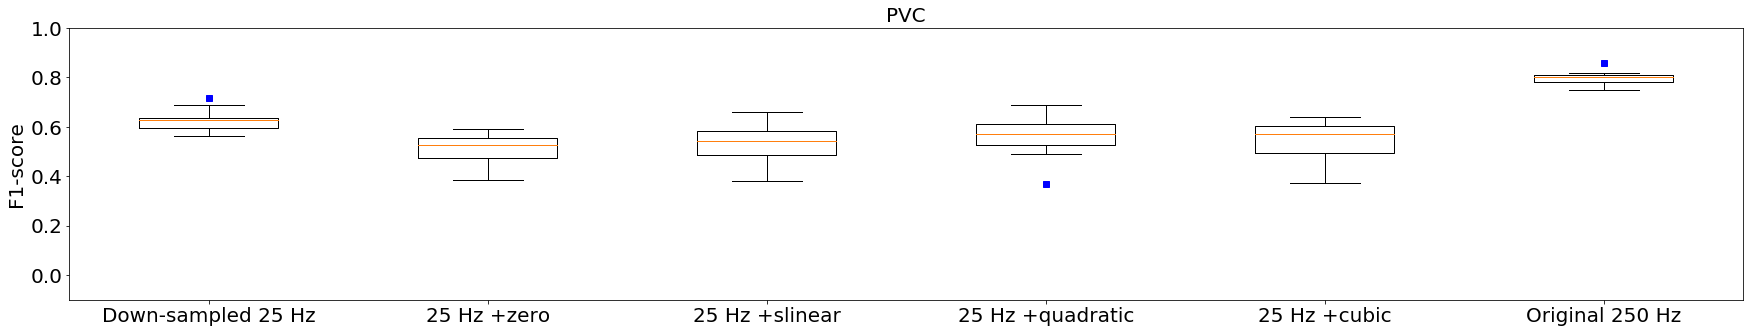

[0.62730769 0.5279432  0.5411591  0.57111437 0.57129456 0.80178571]
nan*
nan**
107#**
[9.70154670e-08 2.77043237e-08 2.24178836e-06 3.36631482e-06
 9.05457370e-07 1.00000000e+00]


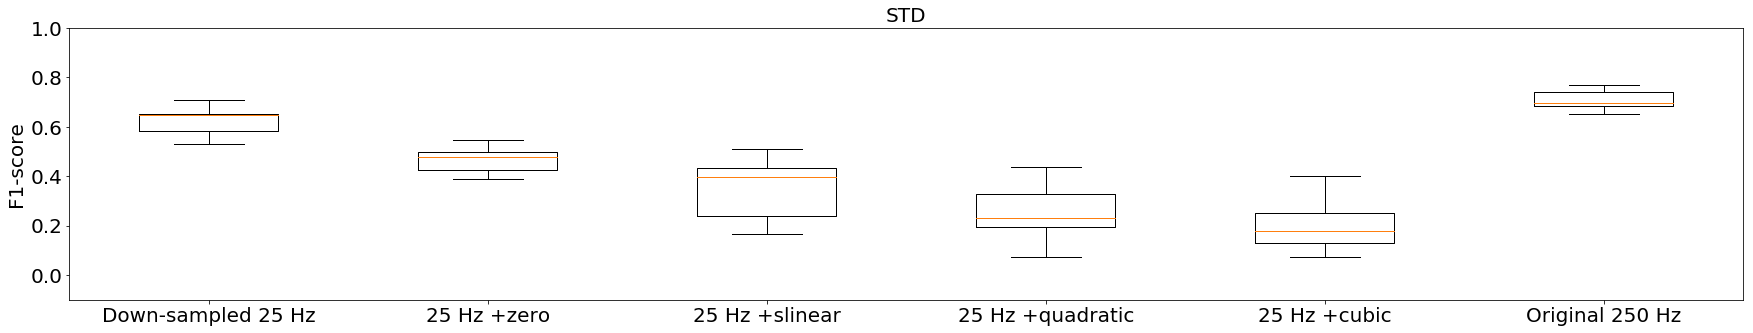

[0.64968153 0.47759821 0.39805825 0.23192477 0.17979798 0.6966734 ]
nan*
nan**
112#**
[3.92261285e-04 2.00071078e-07 8.97337740e-06 8.28940428e-07
 2.78418876e-07 1.00000000e+00]


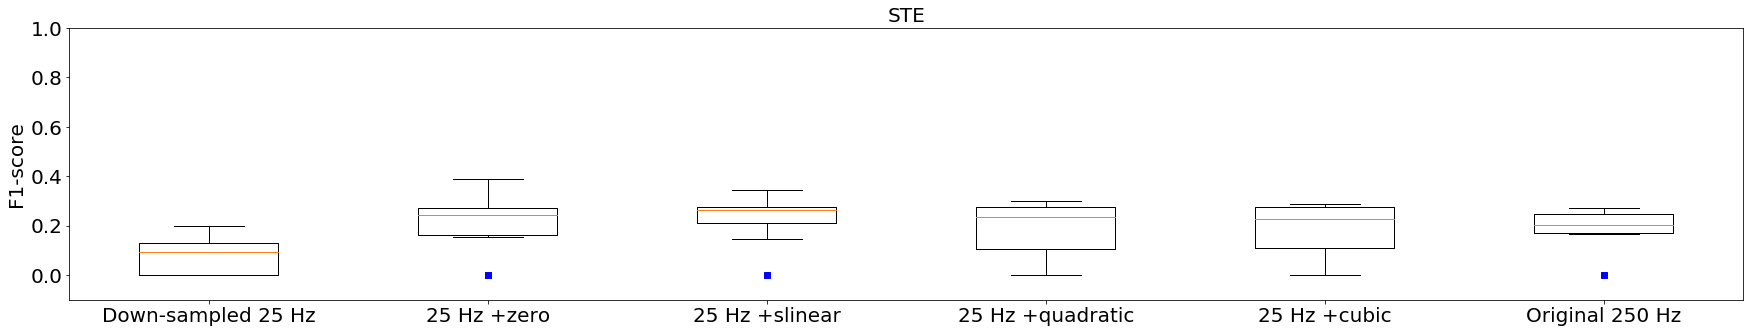

[0.09347826 0.245      0.26376812 0.23611111 0.225      0.20234114]
nan
nan
0
[0.01824296 0.61433024 0.14815219 0.99355207 0.81705737 1.        ]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


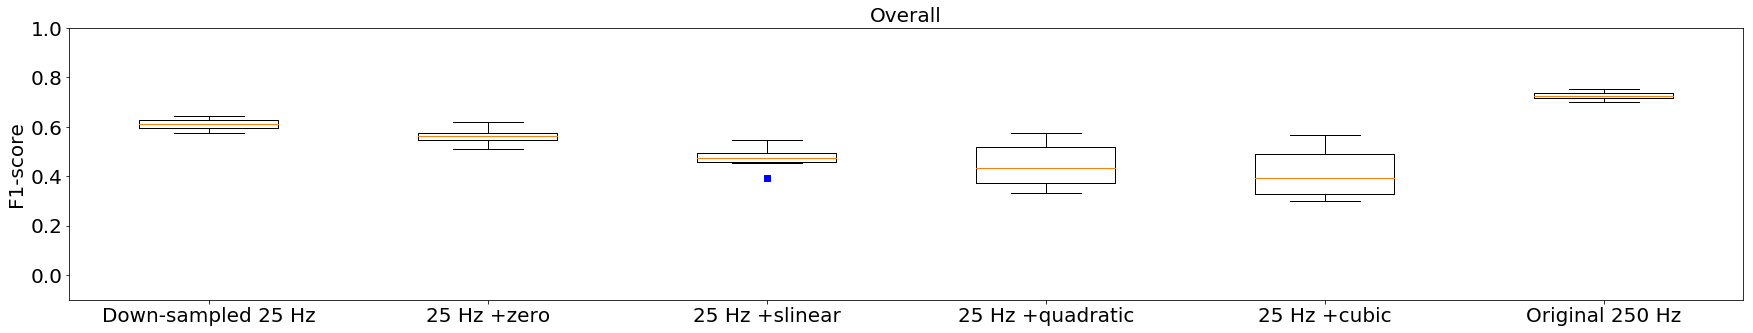

[0.61048655 0.56152529 0.47209213 0.43411042 0.39220451 0.72594606]
nan*
nan**
110#**
[5.21396770e-08 3.25845810e-08 2.18646697e-08 1.30857143e-06
 1.23537688e-06 1.00000000e+00]
Lead :II


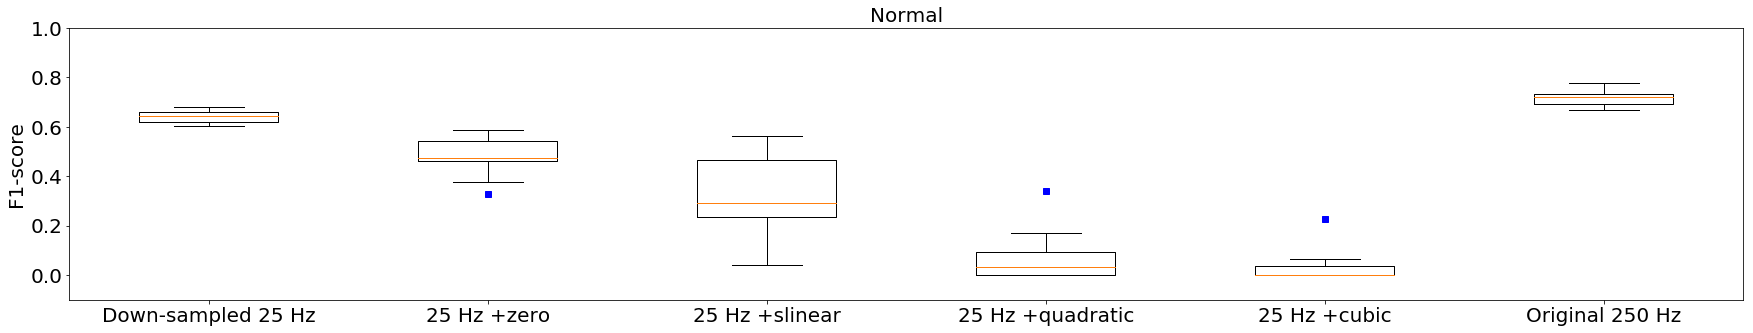

[0.6420339  0.47544999 0.29064658 0.03202928 0.         0.72112429]
nan*
nan**
103#**
[3.90538506e-04 4.66800746e-06 4.99103823e-05 2.73732195e-08
 5.22368266e-10 1.00000000e+00]


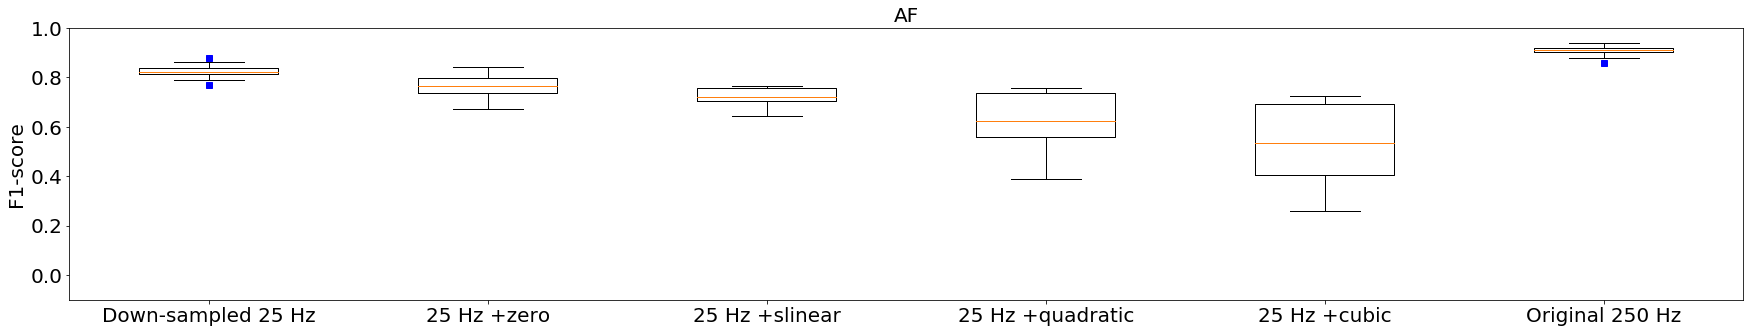

[0.82224381 0.76510778 0.72098929 0.62521368 0.53651874 0.91287879]
nan*
nan**
-127#**
[2.23379254e-06 6.71115467e-06 9.08324241e-08 3.75450826e-05
 6.51280911e-05 1.00000000e+00]


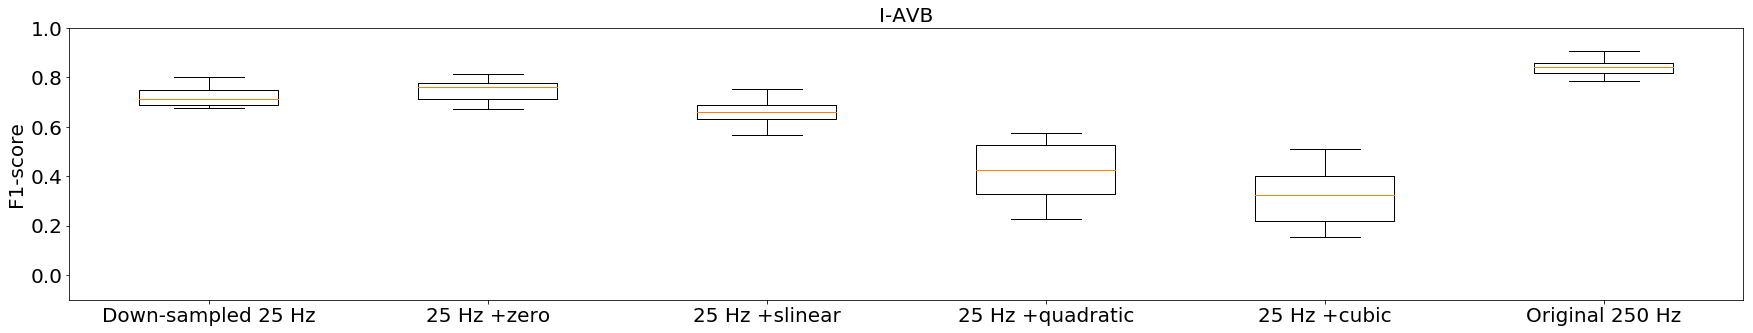

[0.71240679 0.76011509 0.66120219 0.42382625 0.32279614 0.84067202]
nan*
nan**
-128#**
[4.21052277e-05 6.02208441e-08 2.14036654e-06 2.23822167e-06
 3.04400158e-07 1.00000000e+00]


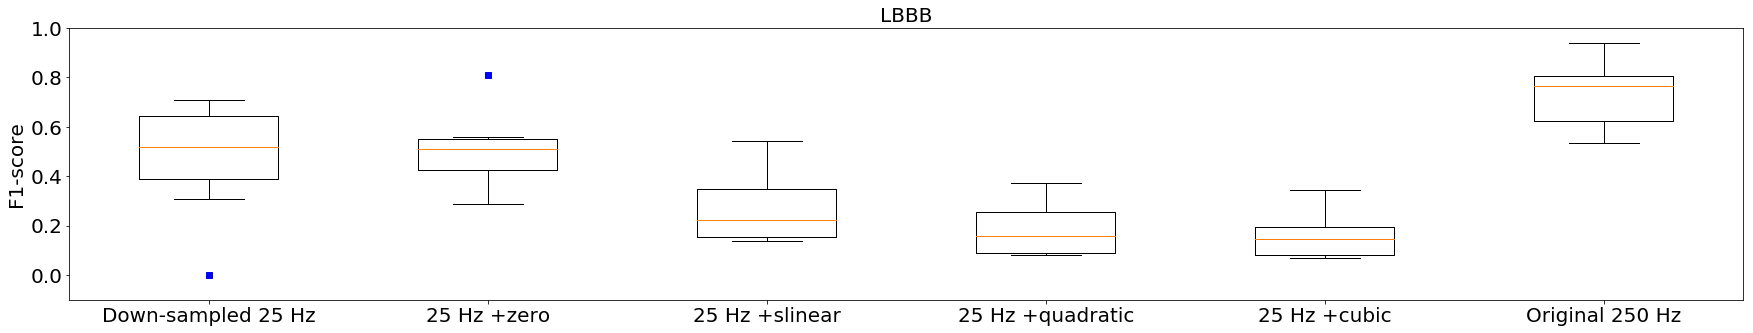

[0.51923077 0.51153846 0.22452642 0.1578341  0.14406883 0.76470588]
nan*
nan**
102#**
[8.76159299e-03 9.08573772e-06 1.77779148e-05 2.51852492e-06
 2.32079970e-06 1.00000000e+00]


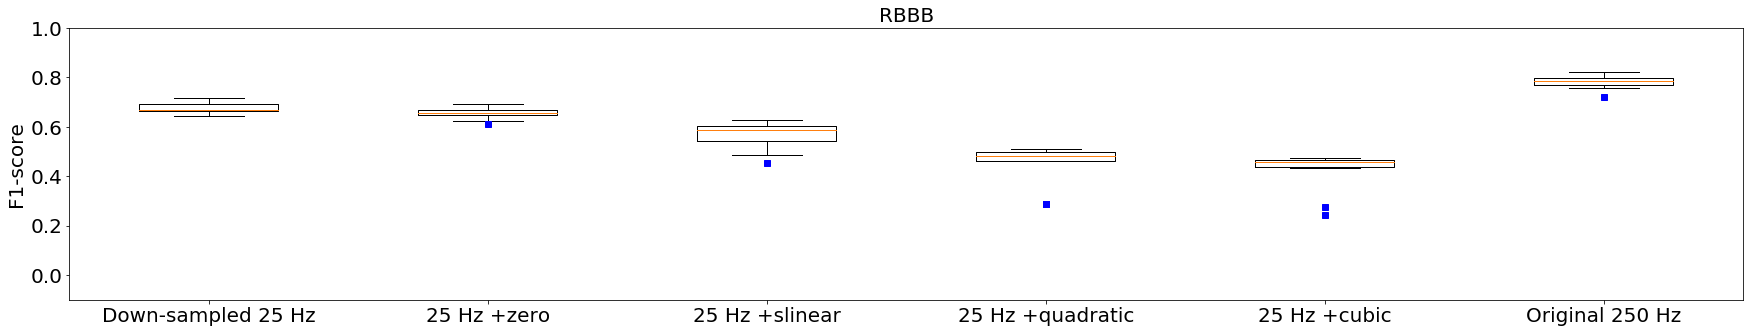

[0.66974866 0.6562067  0.58581963 0.48067055 0.45593432 0.78691893]
nan*
nan**
109#**
[2.50218223e-06 5.59041419e-08 2.27436213e-06 9.15953737e-07
 4.93982806e-07 1.00000000e+00]


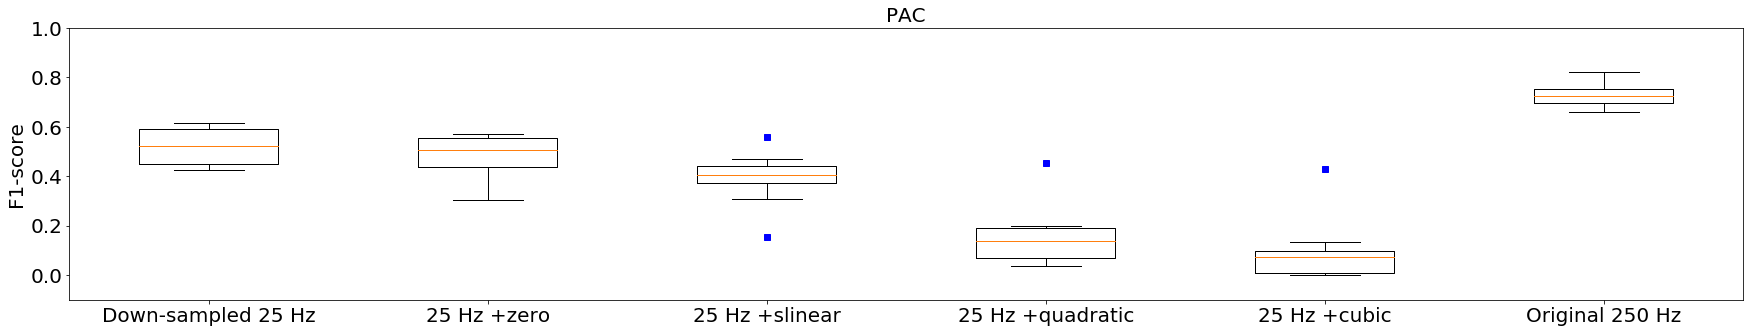

[0.5244153  0.50567115 0.40328093 0.13690476 0.07142857 0.72413793]
nan*
nan**
111#**
[1.93148271e-05 1.04285341e-06 1.83357308e-06 7.94424946e-07
 5.34150225e-07 1.00000000e+00]


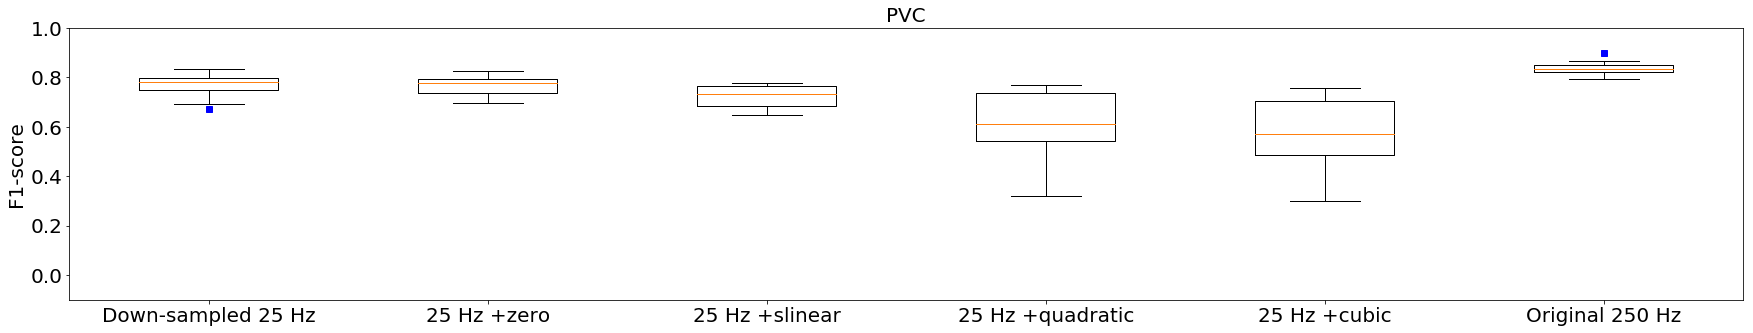

[0.78330435 0.77676792 0.73150644 0.60984512 0.57049027 0.83405766]
nan*
nan**
118#**
[1.57747115e-03 9.11653030e-04 6.05670267e-05 5.94994900e-04
 3.12816480e-04 1.00000000e+00]


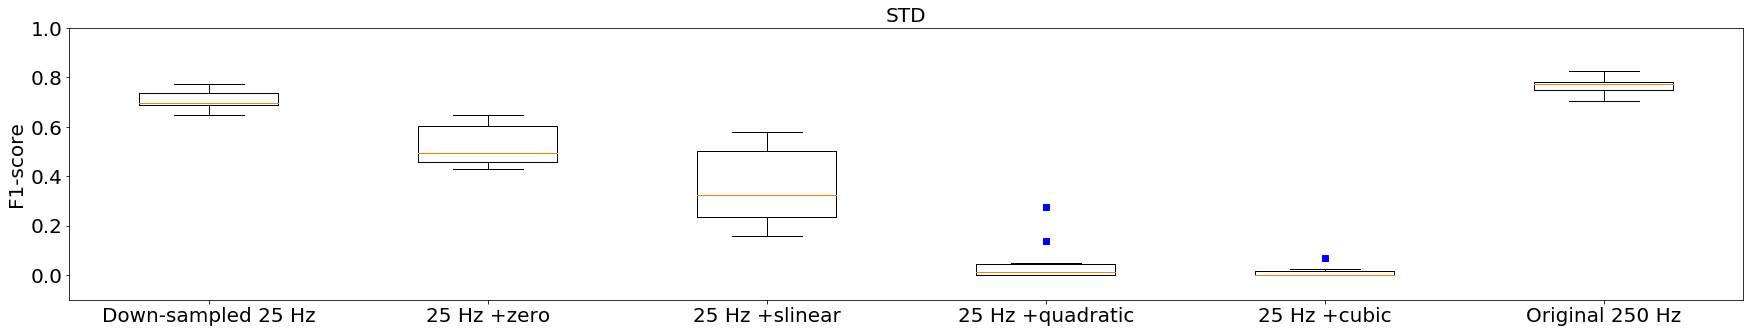

[0.6978801  0.49257343 0.32606775 0.0125     0.         0.77317203]
nan*
nan**
102#**
[1.20644222e-03 7.65175392e-05 2.69104557e-05 1.88573533e-09
 4.87382298e-13 1.00000000e+00]


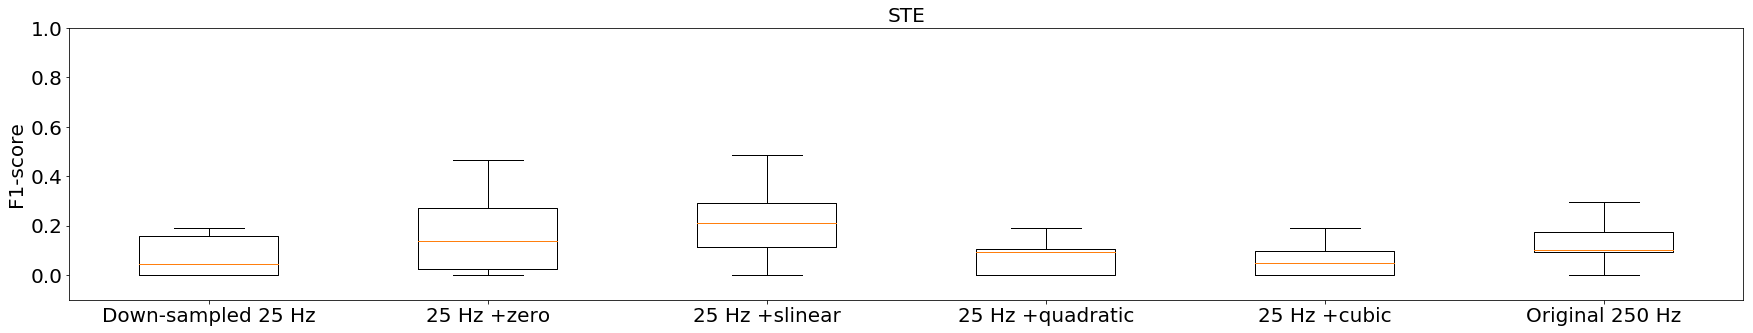

[0.04545455 0.13695652 0.21090909 0.0952381  0.04761905 0.1       ]
nan*
nan**
0#
[0.35637211 0.12216913 0.02315949 0.20166583 0.15264575 1.        ]


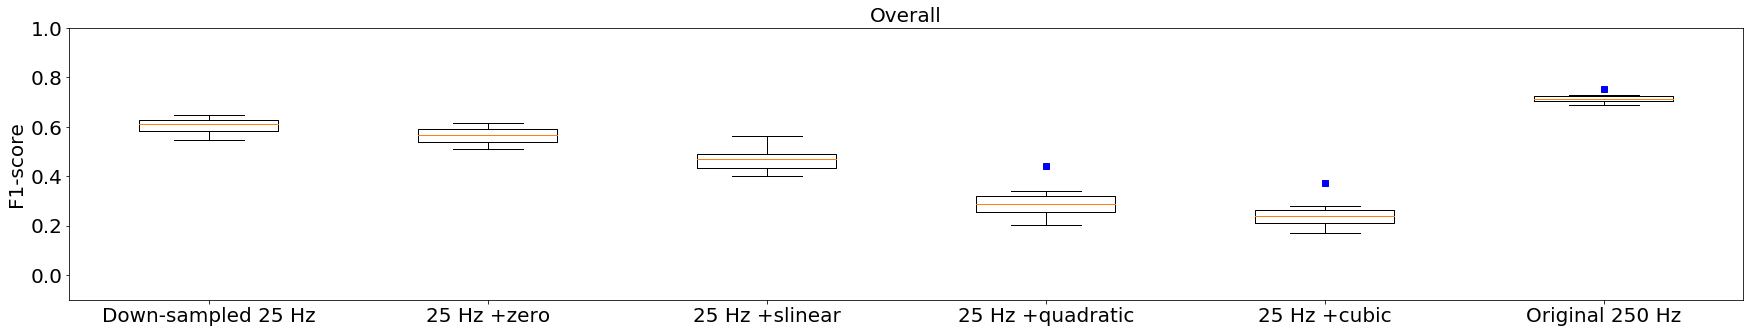

[0.60950974 0.56831874 0.46834992 0.28934474 0.23778315 0.71125376]
nan*
nan**
110#**
[1.83173652e-05 9.18437736e-08 3.42857897e-07 2.79085706e-08
 2.29371115e-09 1.00000000e+00]
Lead :III


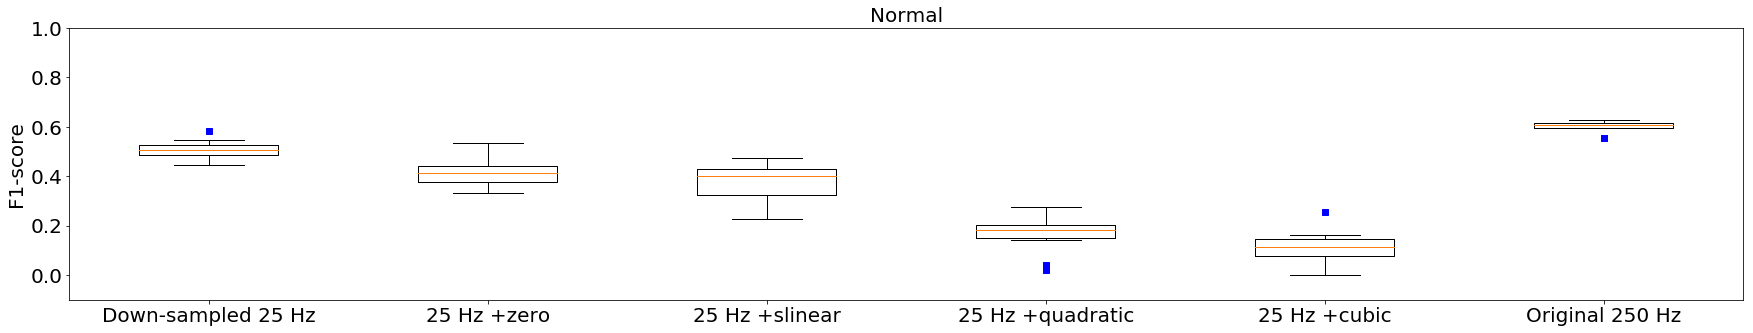

[0.50609756 0.41401556 0.4001568  0.18362534 0.11287758 0.60618698]
nan*
nan**
112#**
[9.60917675e-05 3.36906205e-05 1.70950061e-05 8.07104432e-08
 1.12299796e-08 1.00000000e+00]


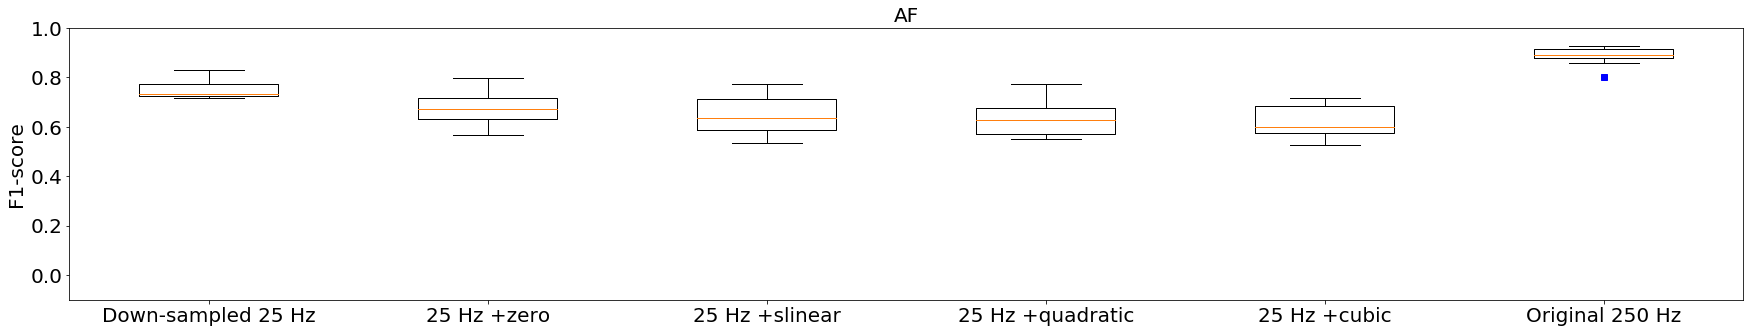

[0.73439503 0.67306686 0.63392779 0.6290556  0.60104999 0.89265804]
nan*
nan**
104#**
[4.63204379e-06 3.63943938e-06 6.28707080e-06 2.31666026e-06
 1.26747696e-06 1.00000000e+00]


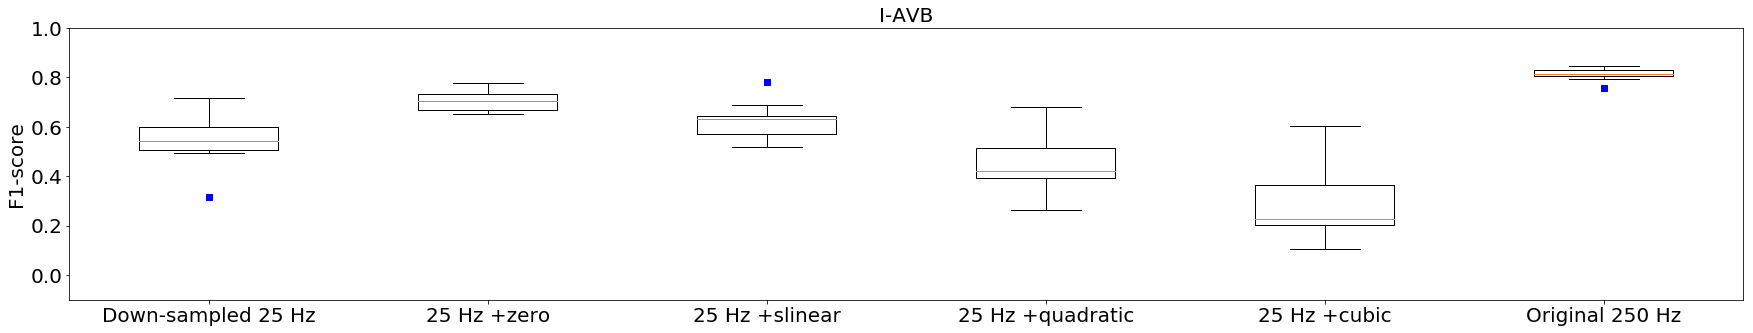

[0.54316269 0.70299581 0.63027595 0.42222222 0.22739018 0.81215006]
nan*
nan**
-109#**
[5.46603877e-05 9.21181892e-05 2.15130165e-05 3.85845531e-06
 6.49081698e-07 1.00000000e+00]


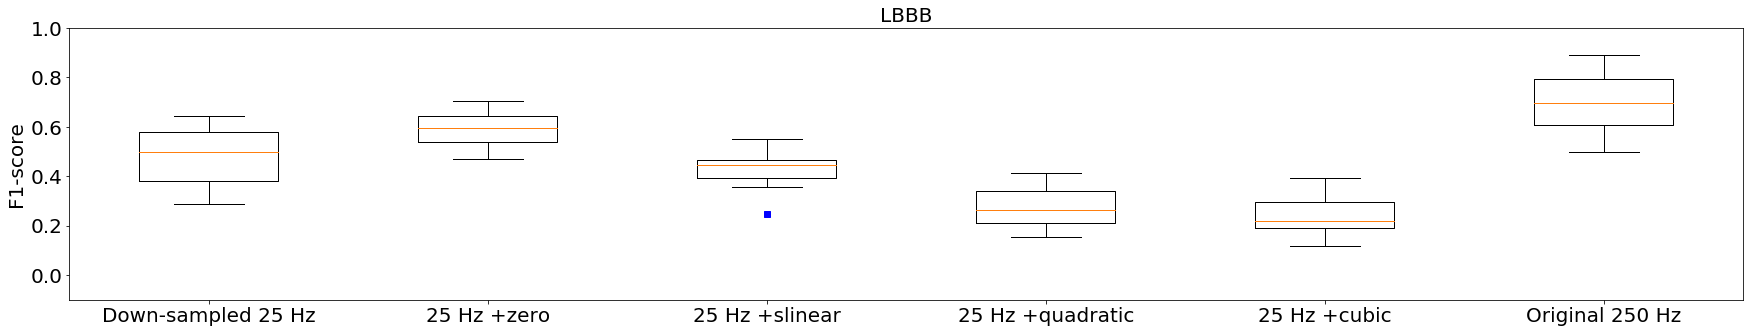

[0.5        0.5952381  0.44596273 0.26370614 0.2187737  0.69669118]
nan*
nan**
109#**
[1.88695156e-03 7.80717216e-03 3.07574223e-04 2.40920807e-05
 1.08677113e-05 1.00000000e+00]


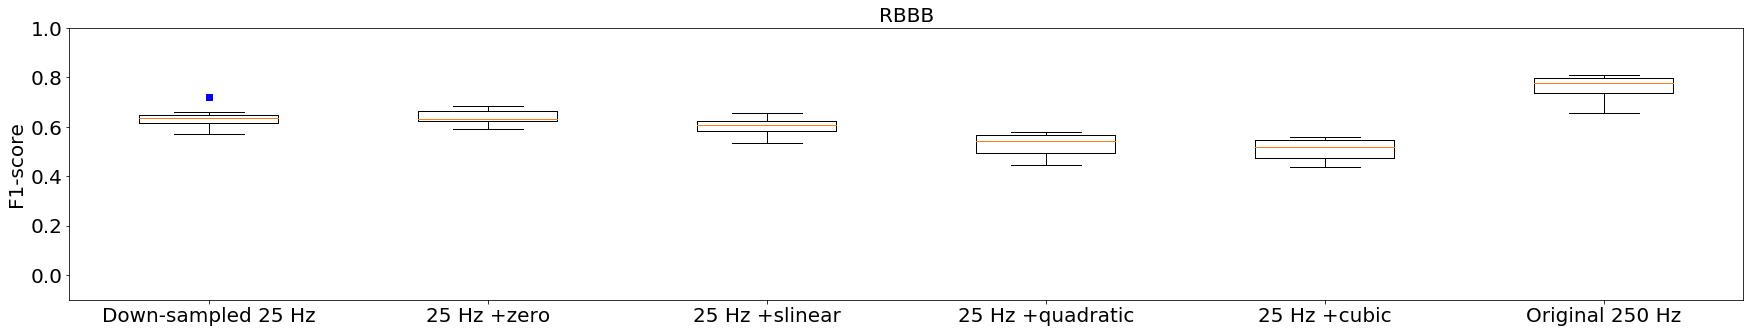

[0.6360412  0.63016073 0.60692435 0.54271143 0.51669004 0.77670049]
nan*
nan**
107#**
[4.44414838e-05 8.55596136e-07 1.97412269e-08 1.76561878e-07
 5.33130792e-08 1.00000000e+00]


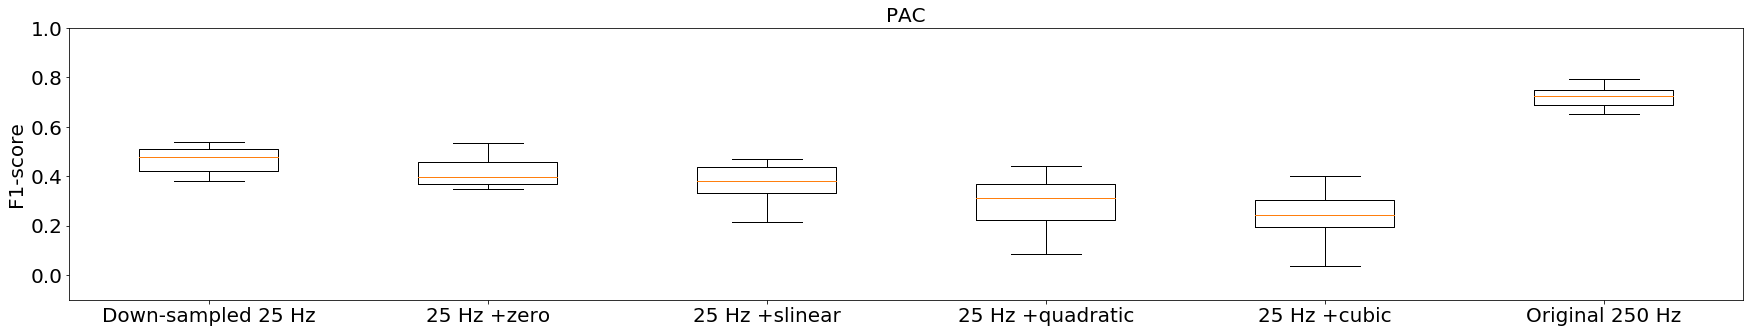

[0.47783897 0.39894477 0.37885802 0.31331169 0.24349478 0.72399672]
nan*
nan**
114#**
[2.51045164e-08 2.76273959e-09 2.21944719e-09 1.23347560e-07
 5.13584763e-08 1.00000000e+00]


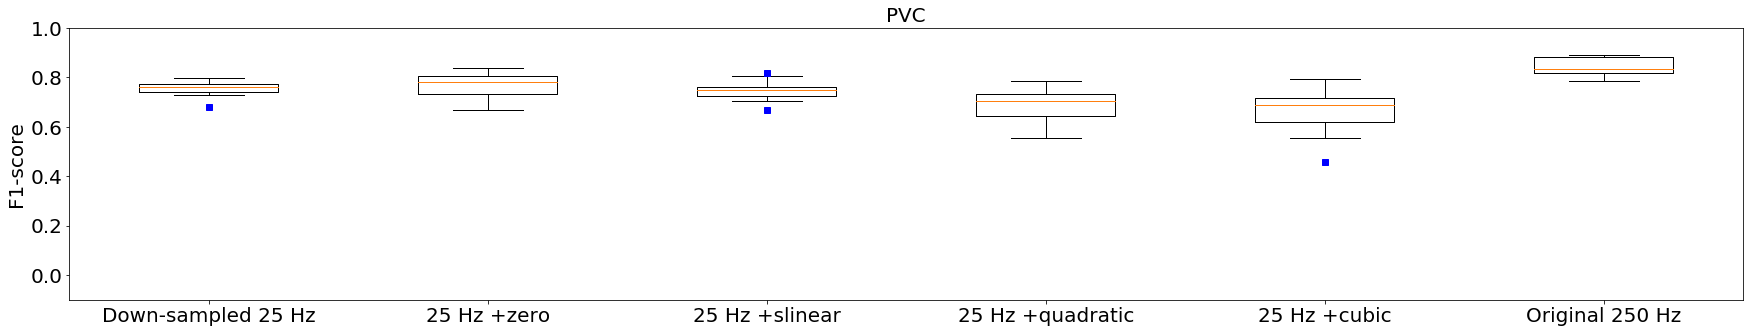

[0.75956323 0.78098268 0.74782609 0.70450774 0.68724083 0.8341785 ]
nan*
nan**
117#**
[2.72126732e-05 8.16740534e-04 3.36848772e-05 2.30029049e-05
 1.28242133e-04 1.00000000e+00]


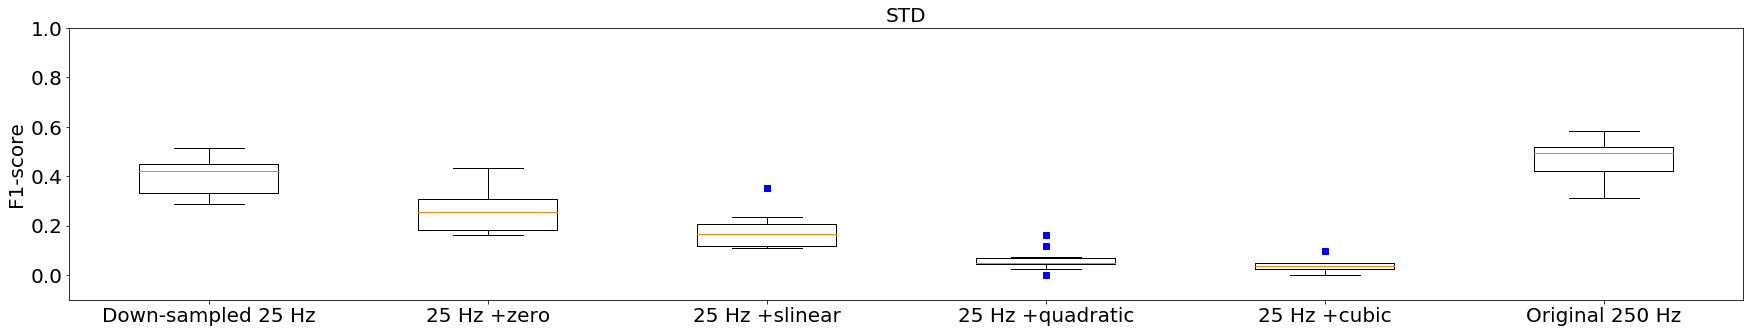

[0.42118227 0.25387317 0.16560821 0.04878774 0.03630952 0.49336772]
nan*
nan**
104#**
[1.64139298e-01 8.66943459e-06 1.52773330e-06 8.63379294e-08
 1.09718523e-07 1.00000000e+00]


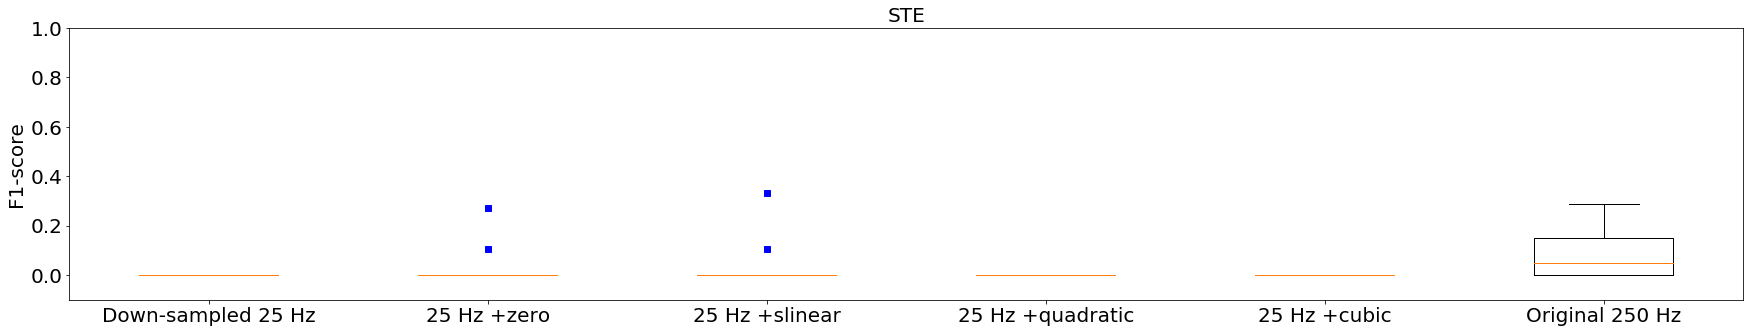

[0.   0.   0.   0.   0.   0.05]
nan*
nan**
0#*
[0.02875383 0.14894927 0.25280219 0.02875383 0.02875383 1.        ]


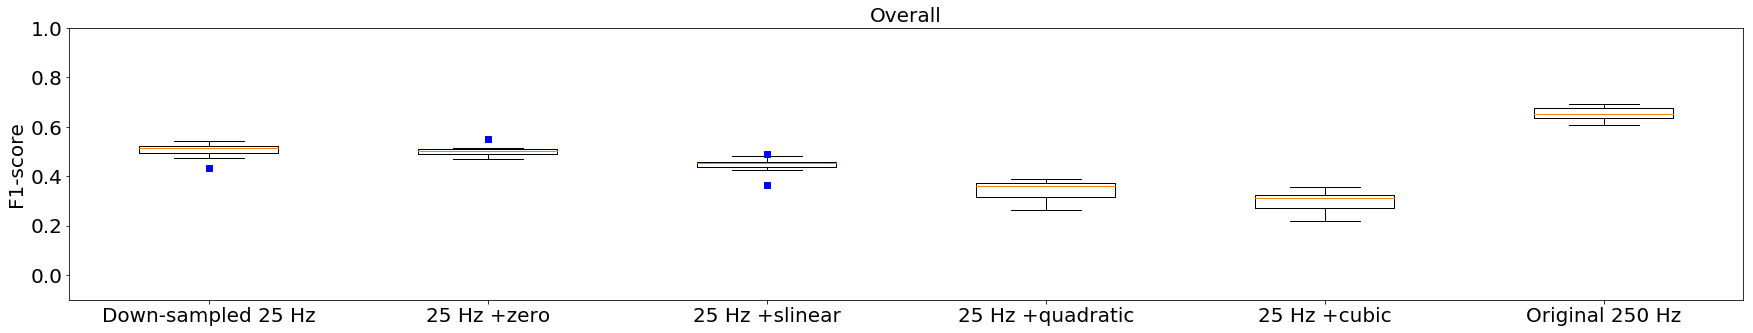

[0.51633569 0.50091509 0.45235768 0.35965039 0.31273944 0.65078945]
nan*
nan**
114#**
[8.59856366e-07 2.99942463e-08 5.95414219e-08 2.76996582e-08
 1.70104957e-08 1.00000000e+00]
Lead :aVR


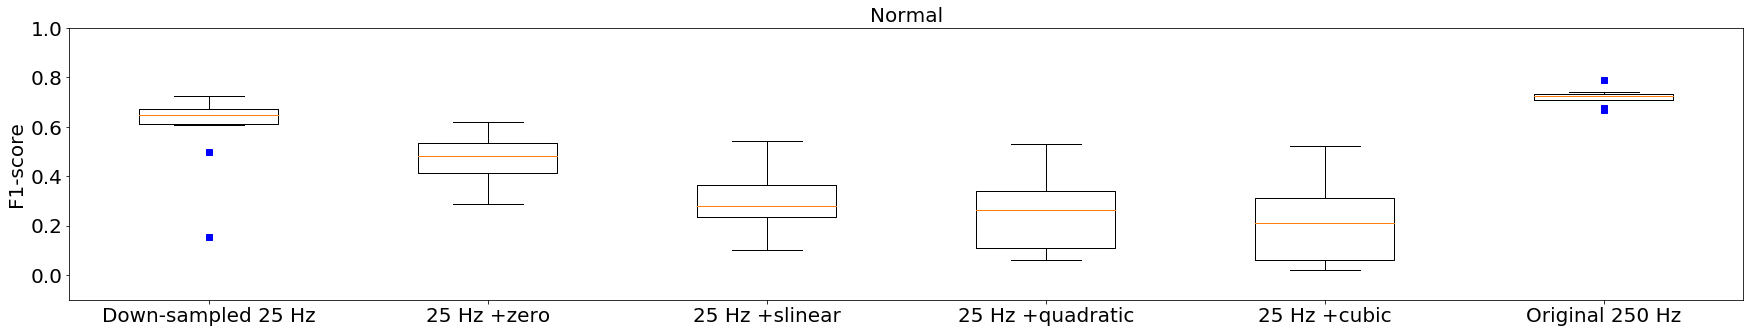

[0.64874687 0.48167093 0.27844248 0.26210692 0.21157895 0.7250629 ]
nan*
nan**
106#**
[3.08333005e-02 2.20479423e-05 3.86881824e-06 1.51401510e-05
 1.32794964e-05 1.00000000e+00]


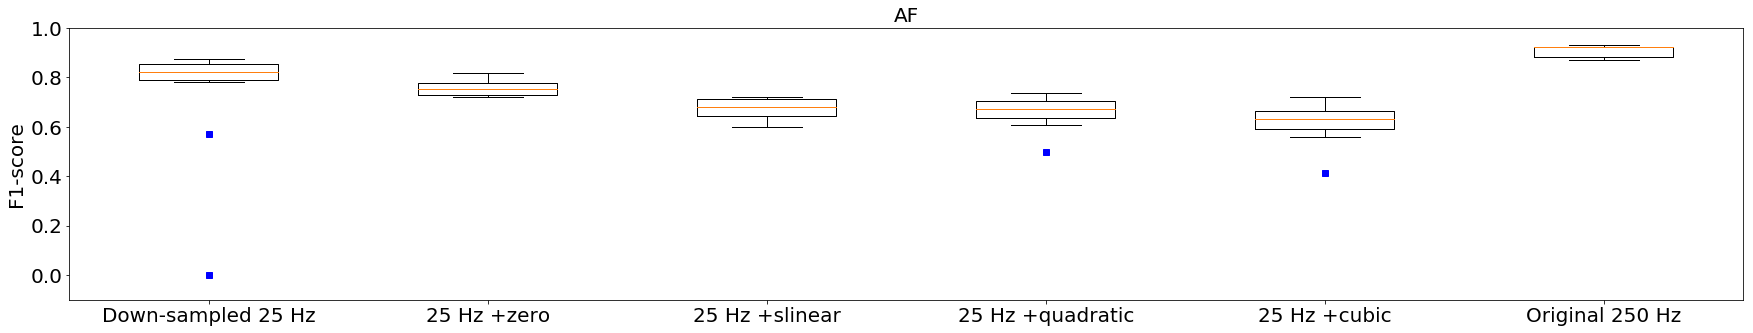

[0.82364266 0.7541624  0.67914439 0.67333333 0.63097803 0.92227979]
nan*
nan**
117#**
[5.44362379e-02 3.34494263e-08 1.20042907e-07 3.76832818e-06
 6.06219608e-06 1.00000000e+00]


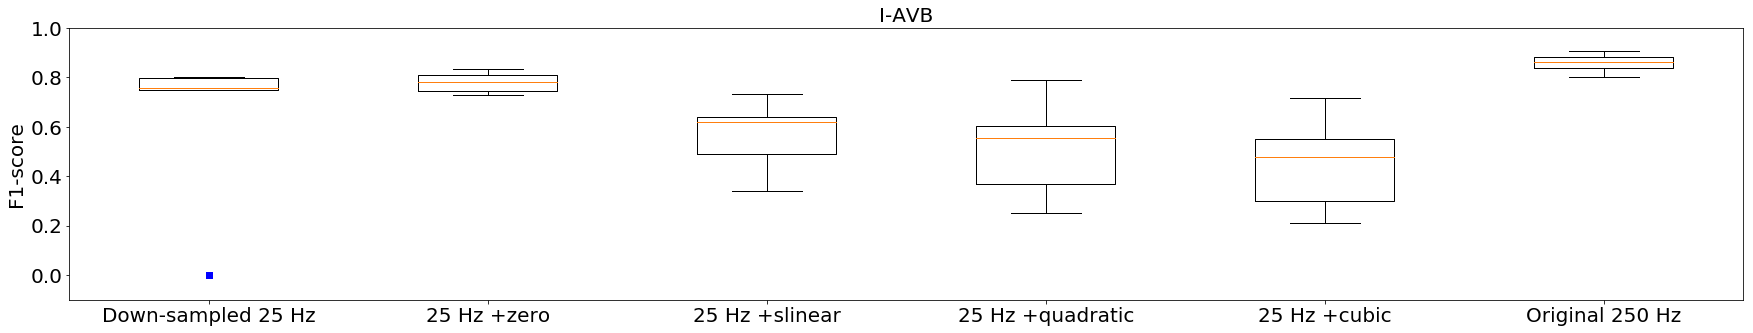

[0.75746335 0.77975906 0.61823291 0.55375552 0.4787234  0.86345316]
nan*
nan**
117#**
[4.79309711e-02 8.95010077e-07 2.20276583e-05 5.43685395e-05
 1.19656895e-05 1.00000000e+00]


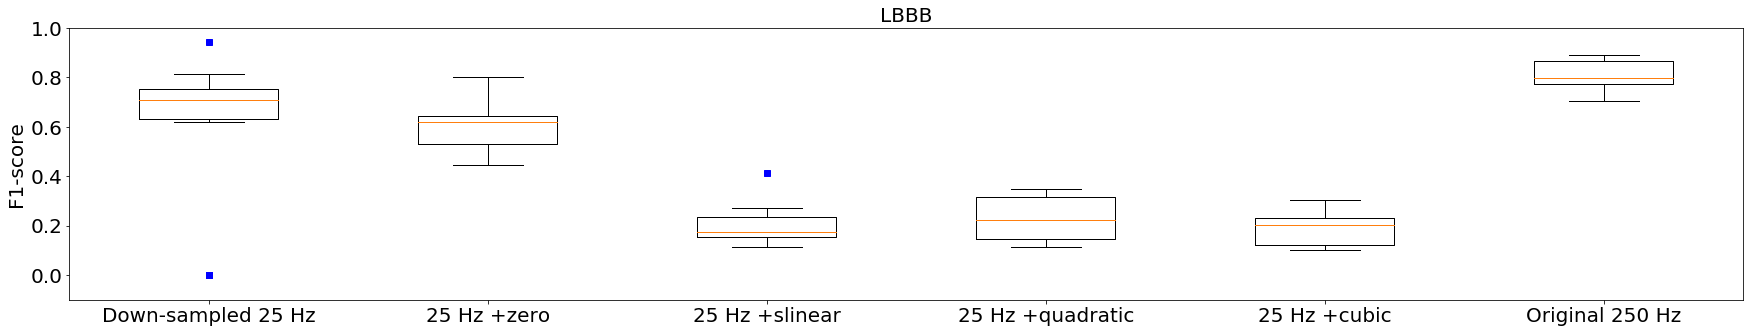

[0.71008403 0.62019231 0.17620838 0.22236378 0.2010582  0.7993448 ]
nan*
nan**
104#**
[6.61830884e-02 1.05412503e-04 1.89665781e-08 2.44231607e-07
 5.38879255e-08 1.00000000e+00]


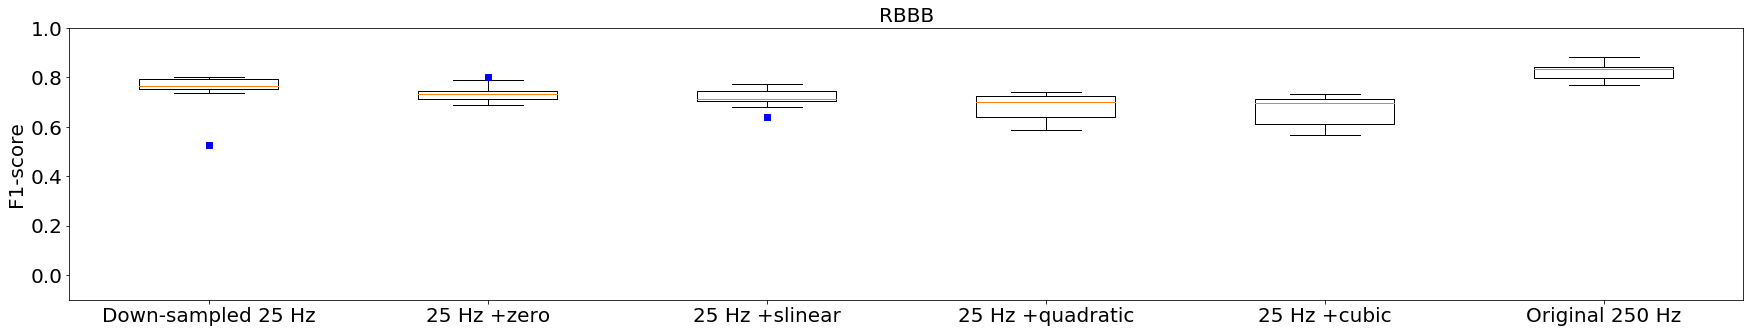

[0.76713389 0.73336627 0.7121939  0.70020704 0.69595126 0.83580858]
nan*
nan**
112#**
[1.20659950e-02 1.64774938e-06 8.64330725e-06 2.01615744e-05
 1.75370237e-05 1.00000000e+00]


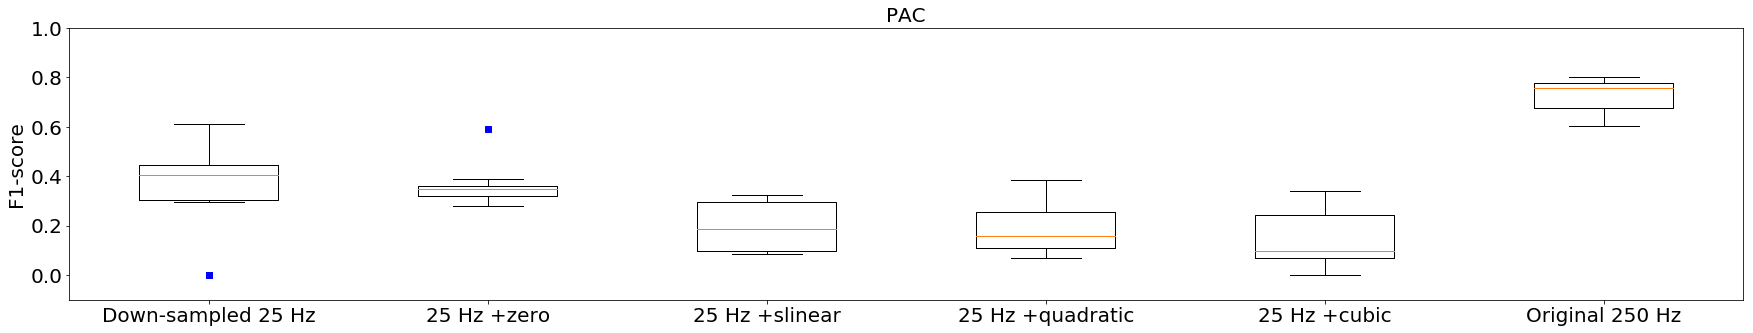

[0.40580138 0.34668335 0.18828351 0.15659408 0.09920635 0.75718065]
nan*
nan**
105#**
[7.20766195e-04 1.97658350e-07 2.62447183e-07 4.15431330e-07
 6.72783299e-07 1.00000000e+00]


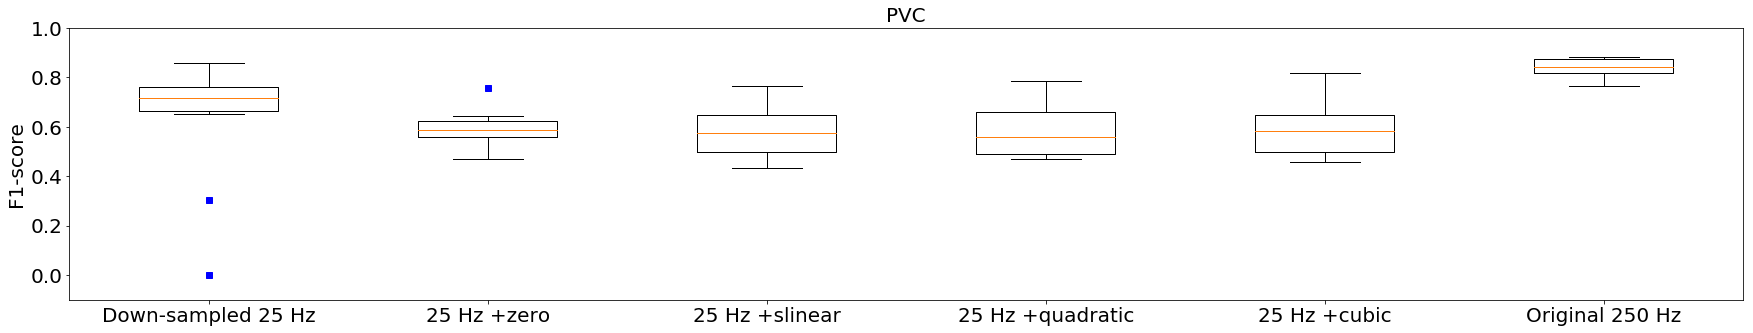

[0.7184539  0.58898944 0.57636364 0.55872845 0.58310345 0.84064392]
nan*
nan**
102#**
[2.59675688e-02 3.63795752e-07 5.11882746e-06 6.86239806e-06
 1.09804187e-05 1.00000000e+00]


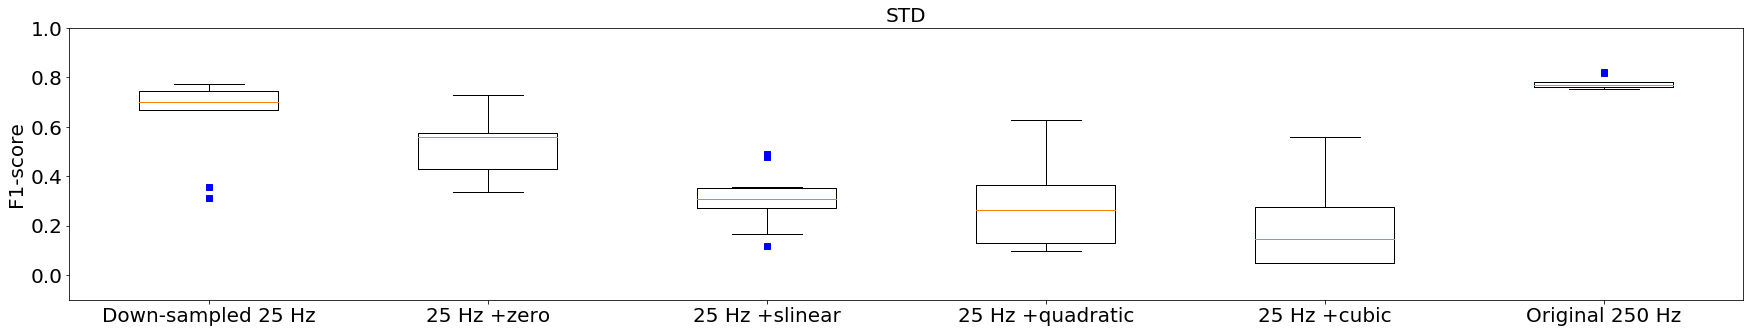

[0.70071131 0.55690073 0.30612245 0.26328502 0.14769648 0.76807189]
nan*
nan**
114#**
[3.04443755e-02 2.65377877e-05 3.64921175e-07 8.17083988e-06
 3.46933492e-06 1.00000000e+00]


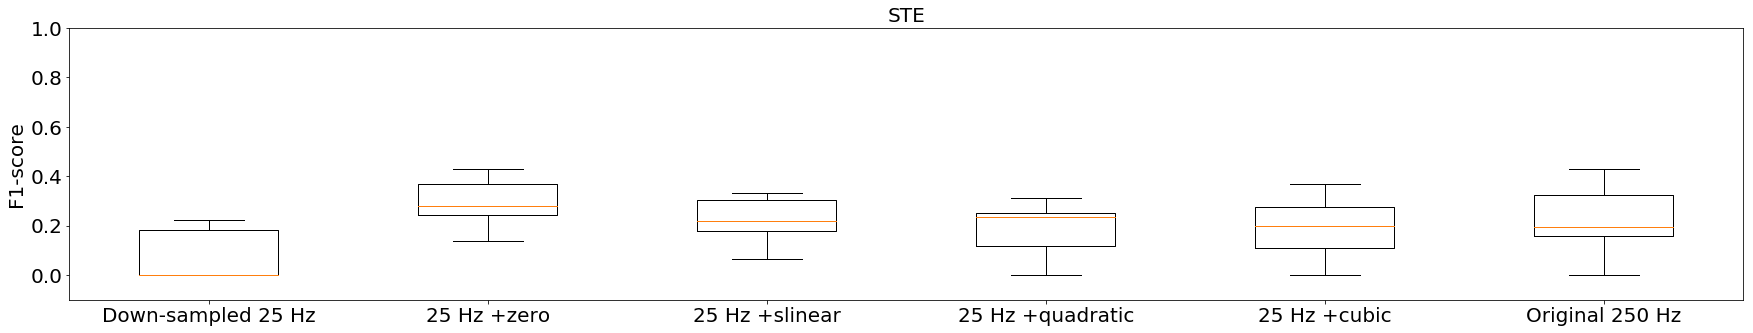

[0.         0.28039216 0.21749409 0.23688312 0.1968254  0.1952381 ]
nan
nan
102
[0.02577262 0.0142363  0.92327807 0.53684807 0.44554145 1.        ]


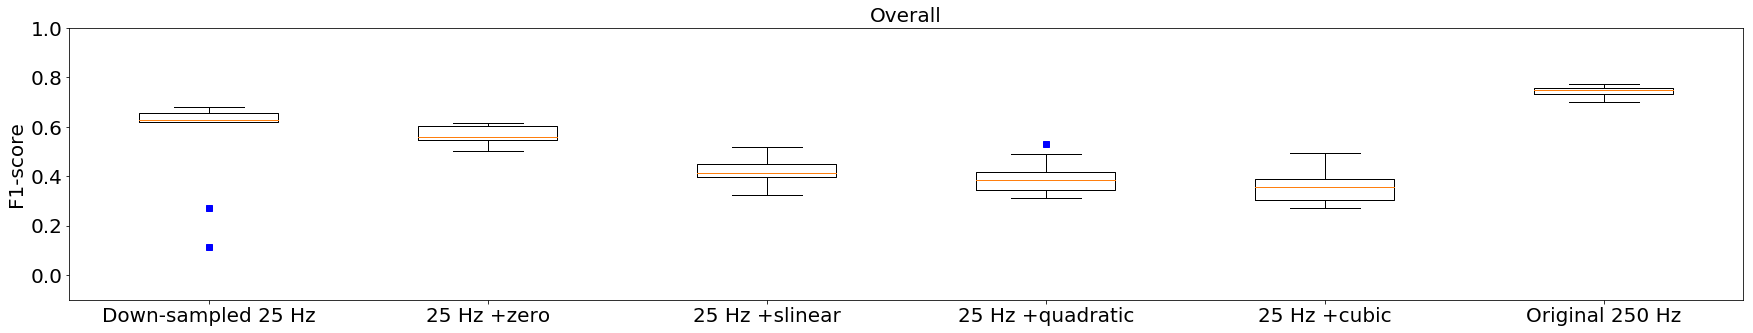

[0.6274327  0.55962441 0.41173193 0.38385497 0.35570341 0.74935977]
nan*
nan**
109#**
[1.24278785e-02 4.72853094e-09 6.29993726e-08 1.71313033e-07
 1.40754648e-07 1.00000000e+00]
Lead :aVL


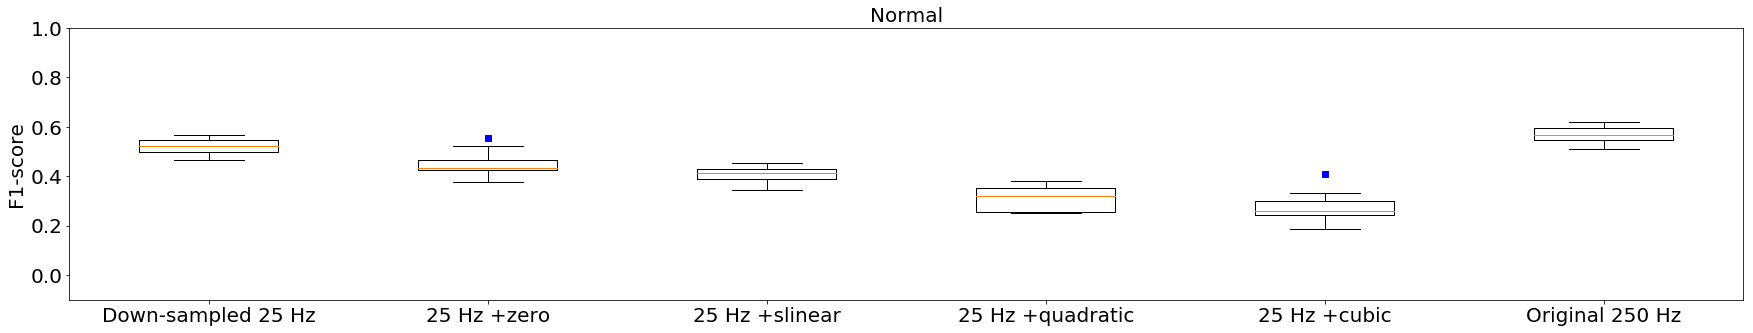

[0.52440833 0.43504803 0.41261148 0.32102696 0.26133333 0.56806723]
nan*
nan**
114#**
[6.17585506e-03 1.47559466e-05 4.10723101e-07 7.36549473e-09
 4.89223190e-08 1.00000000e+00]


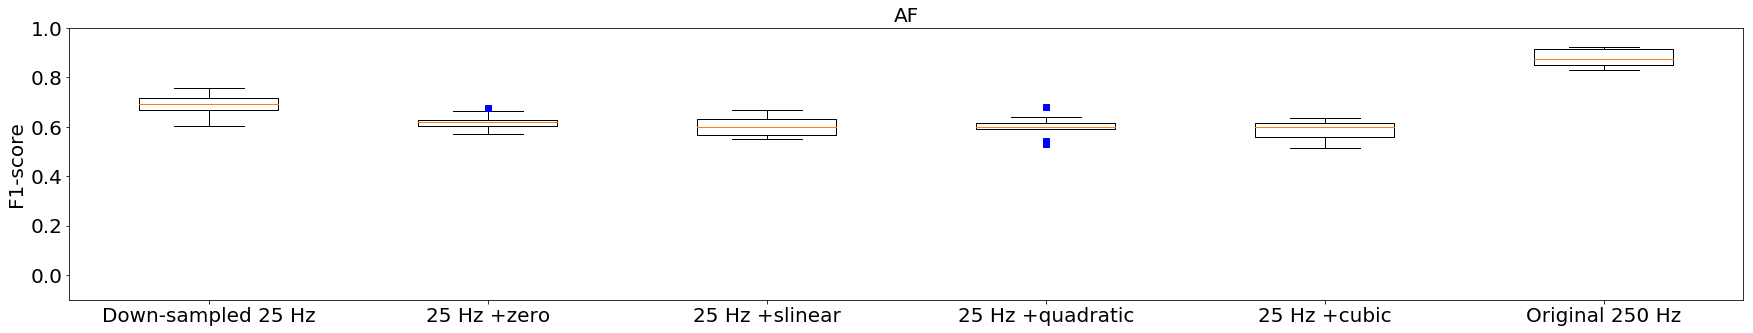

[0.69070172 0.6195715  0.6004257  0.60058246 0.60004763 0.8760768 ]
nan*
nan**
101#**
[1.15329972e-07 1.87291634e-09 2.65154234e-08 2.02090707e-08
 1.61293984e-08 1.00000000e+00]


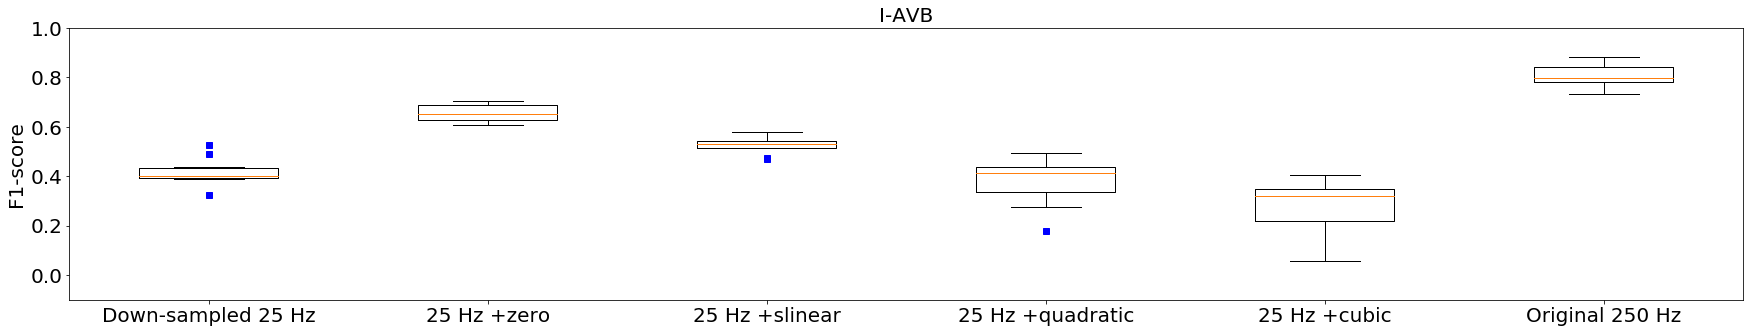

[0.4        0.6507035  0.52963767 0.41208791 0.31959707 0.79864865]
nan*
nan**
122#**
[5.96820106e-08 2.17653042e-07 5.44866239e-08 1.41012358e-06
 1.10794908e-06 1.00000000e+00]


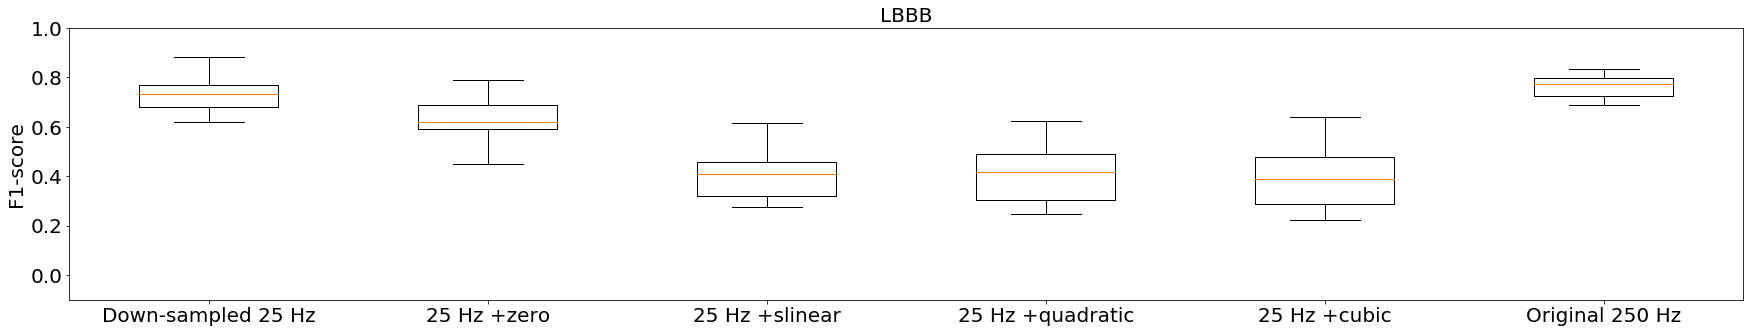

[0.73205742 0.62121212 0.40982906 0.41586498 0.38800705 0.77350427]
nan*
nan**
105#**
[1.51697788e-01 1.02205449e-03 7.18545841e-07 6.83046838e-06
 7.23073395e-06 1.00000000e+00]


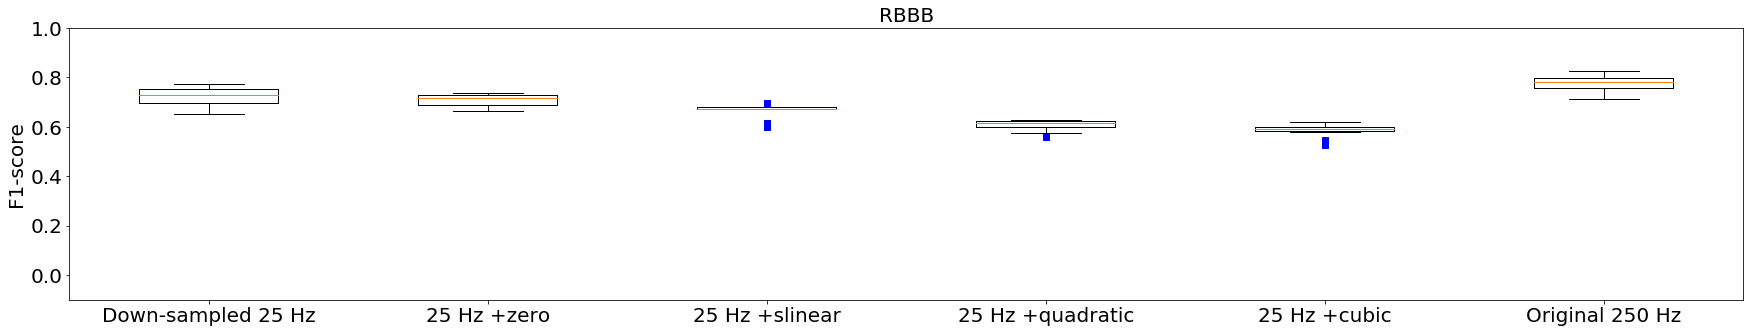

[0.72739815 0.71750322 0.67072001 0.61497599 0.58966226 0.78002846]
nan*
nan**
113#**
[1.18090353e-04 1.82315236e-05 1.13517745e-08 8.20041320e-10
 2.23886821e-10 1.00000000e+00]


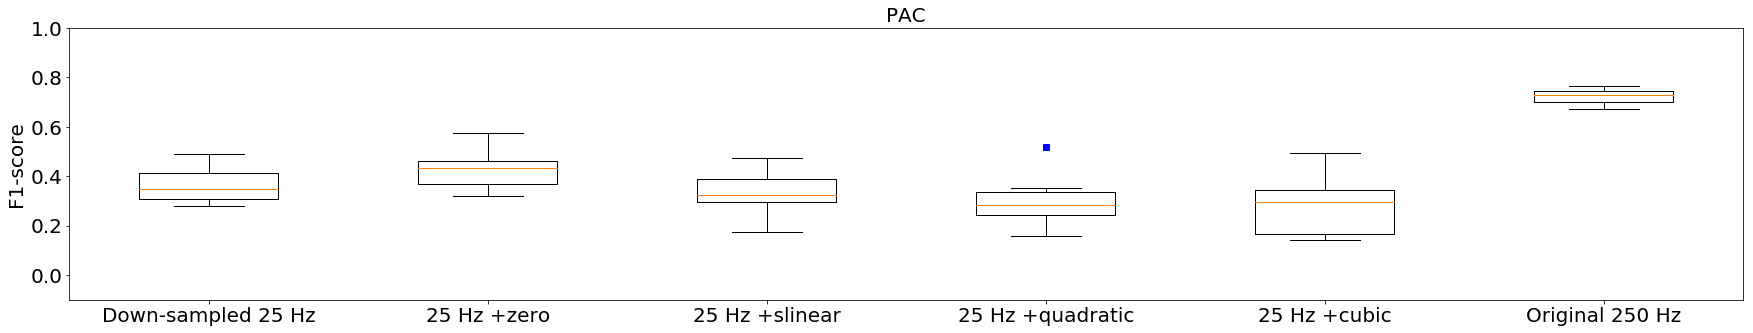

[0.34724613 0.43221622 0.32352941 0.28241758 0.2967033  0.72889276]
nan*
nan**
102#**
[1.72908728e-08 2.28590660e-06 3.49523342e-07 4.64623528e-07
 6.00759540e-07 1.00000000e+00]


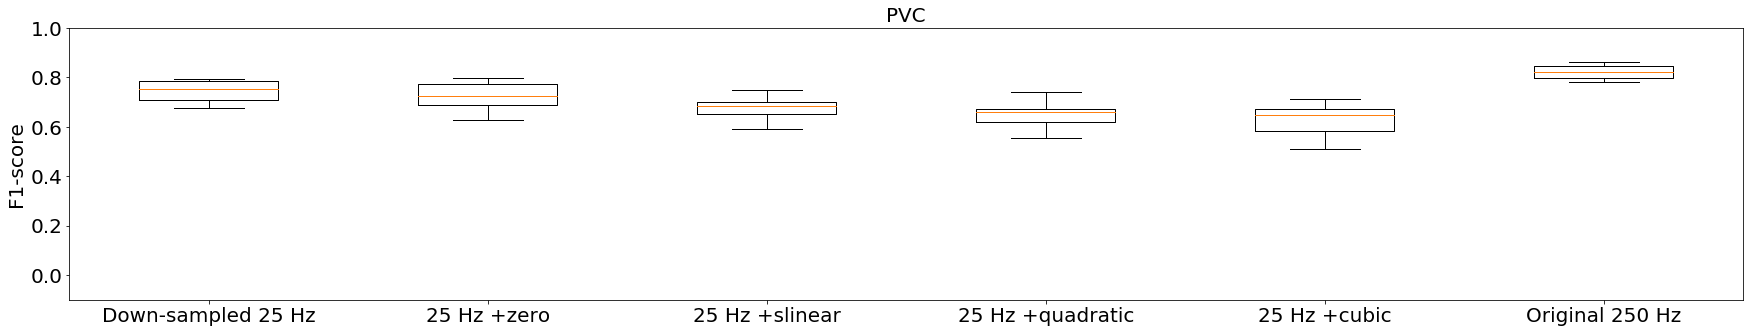

[0.75223899 0.72399672 0.68490409 0.66025641 0.64766108 0.82352941]
nan*
nan**
111#**
[8.56050964e-05 5.64053188e-04 3.20512428e-06 2.43532190e-06
 2.77099987e-06 1.00000000e+00]


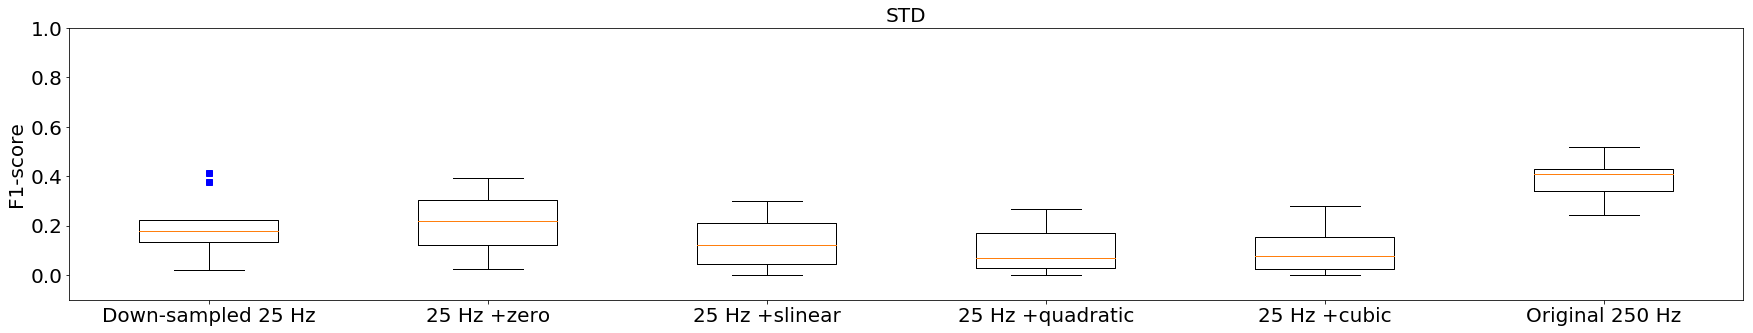

[0.18009174 0.21959075 0.12024187 0.06755218 0.07877238 0.41079973]
nan*
nan**
102#**
[2.94826506e-04 7.05144423e-04 4.68081523e-05 7.02603961e-06
 8.53204576e-06 1.00000000e+00]


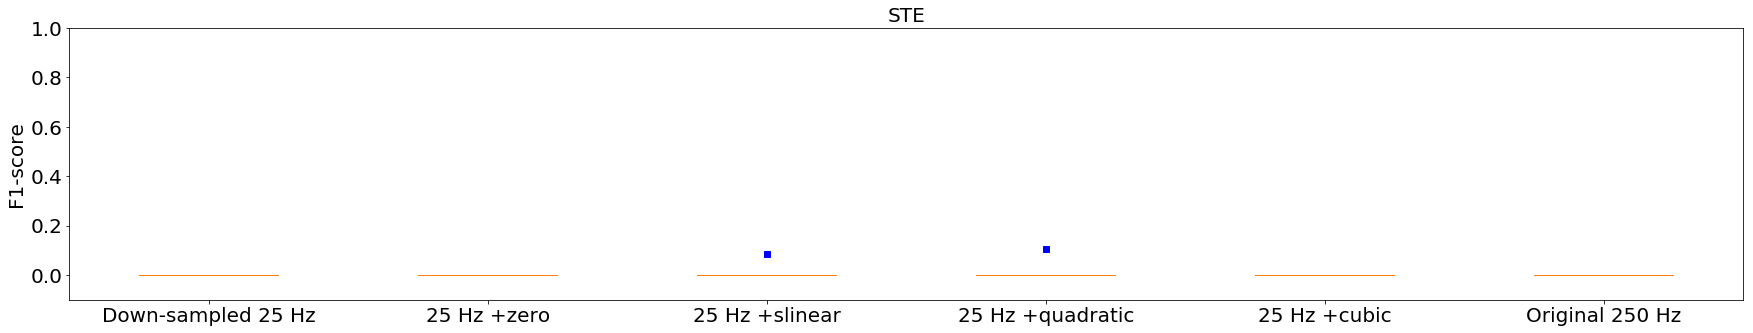

[0. 0. 0. 0. 0. 0.]
nan*
nan**
0#
[      nan       nan 0.3434364 0.3434364       nan 1.       ]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in less
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less


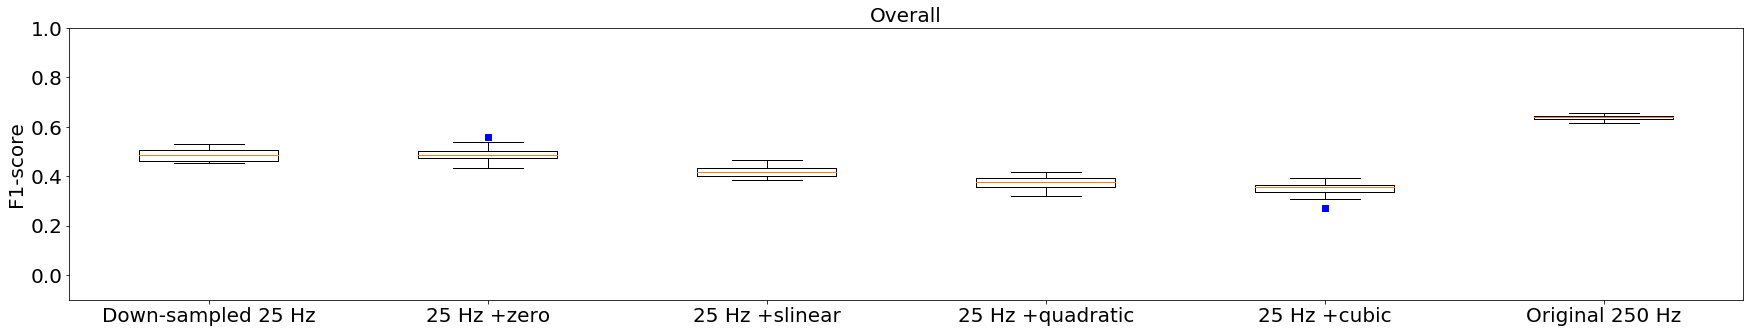

[0.48767354 0.48504255 0.41825236 0.37839214 0.35611634 0.63917798]
nan*
nan**
109#**
[1.54923865e-08 1.57365006e-07 2.45206763e-10 3.16907027e-10
 8.44043632e-10 1.00000000e+00]
Lead :aVF


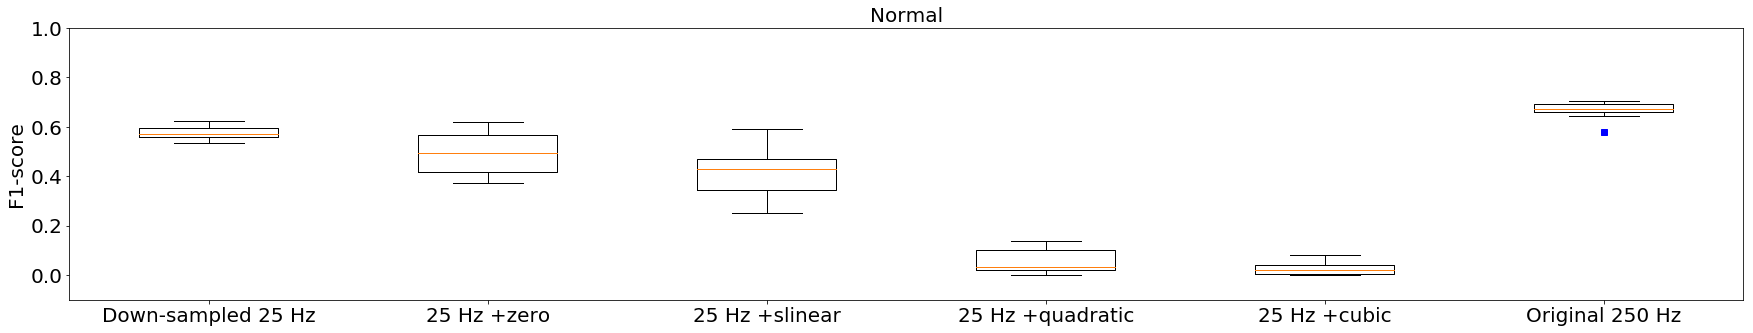

[0.56929638 0.4933056  0.42954917 0.03137124 0.02150538 0.67300629]
nan*
nan**
103#**
[1.71374496e-05 5.79306335e-05 4.40885980e-05 1.76158821e-09
 7.23776095e-11 1.00000000e+00]


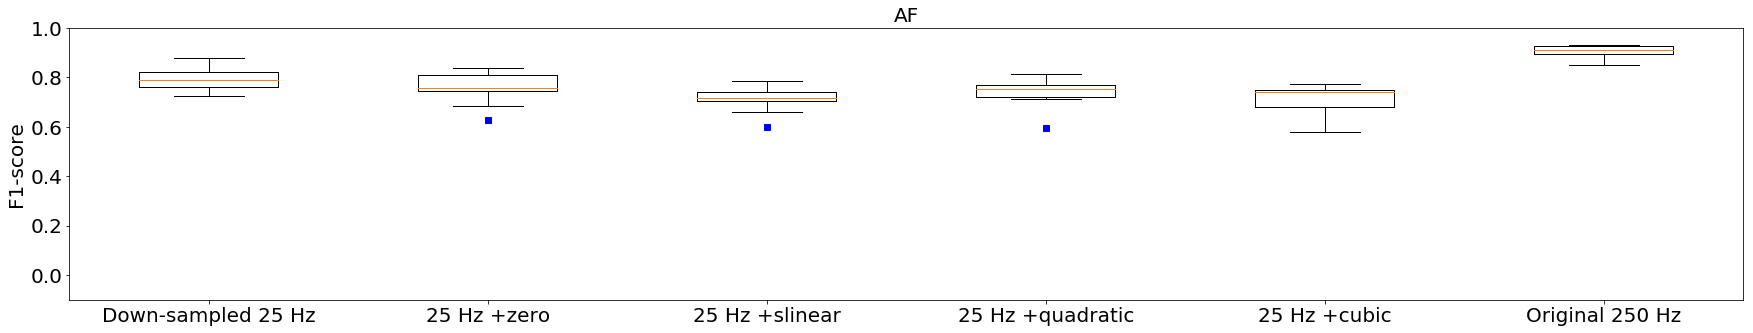

[0.78851923 0.75839066 0.71607058 0.7537594  0.73925926 0.91244019]
nan*
nan**
114#**
[7.17591746e-05 1.26861705e-05 9.49628657e-07 8.16438459e-06
 1.14567349e-06 1.00000000e+00]


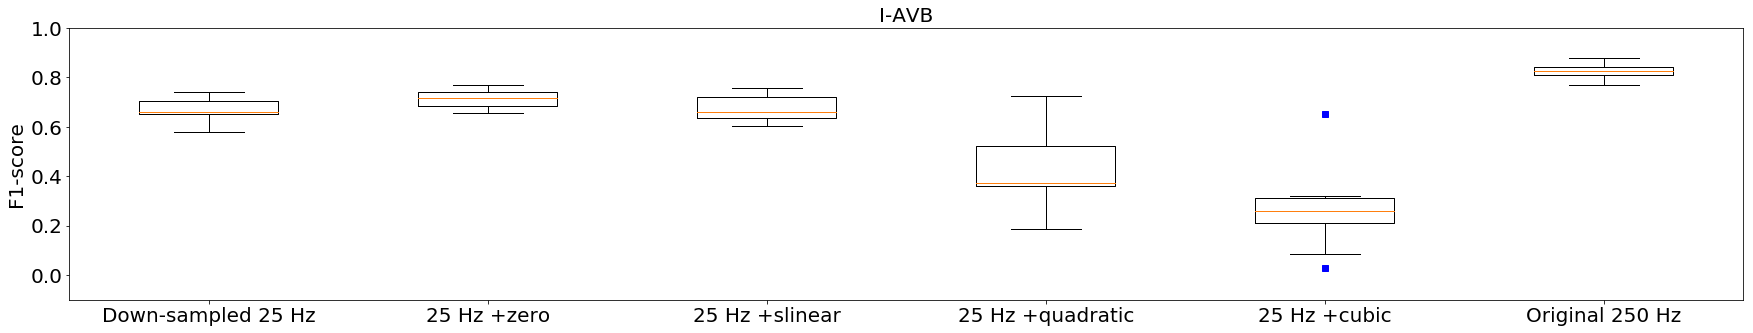

[0.65897563 0.71532684 0.66060606 0.37214334 0.26080247 0.82666957]
nan*
nan**
-127#**
[2.95503132e-05 4.56348975e-06 1.69578327e-05 2.30982251e-05
 2.04577066e-06 1.00000000e+00]


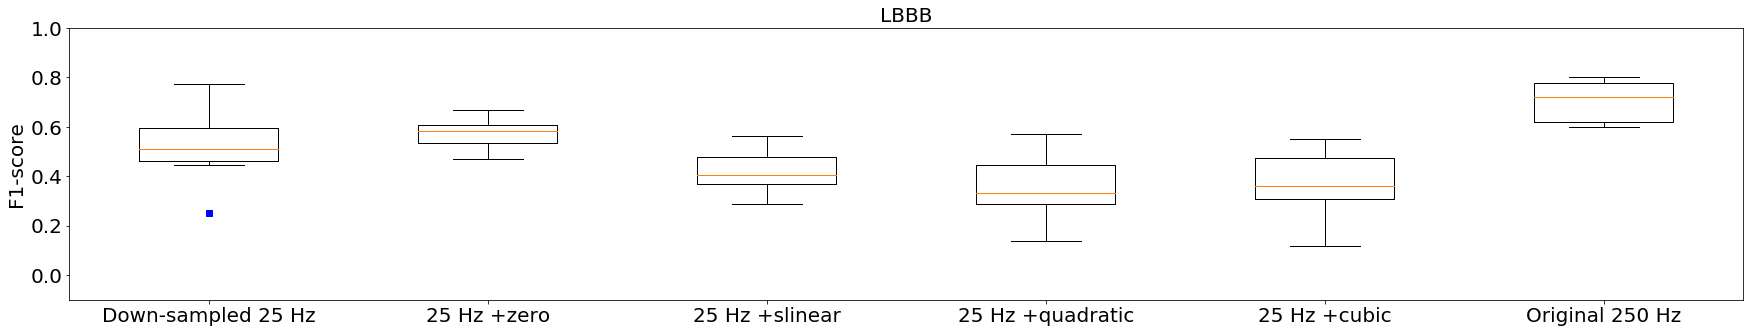

[0.50925926 0.58215661 0.40338983 0.33371997 0.36024182 0.71969697]
nan*
nan**
97#**
[2.27150839e-03 1.43127258e-04 4.44165955e-05 3.14964633e-05
 5.85296898e-05 1.00000000e+00]


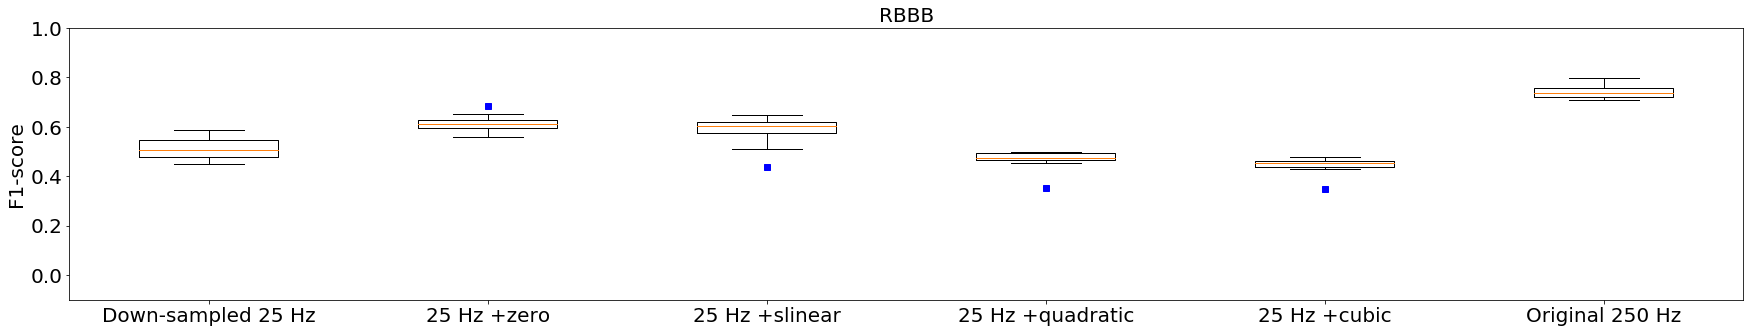

[0.50652254 0.61216719 0.60216199 0.47549335 0.45501967 0.73775903]
nan*
nan**
110#**
[9.85650525e-07 1.47207362e-07 1.75446809e-05 4.85767957e-08
 7.41720235e-09 1.00000000e+00]


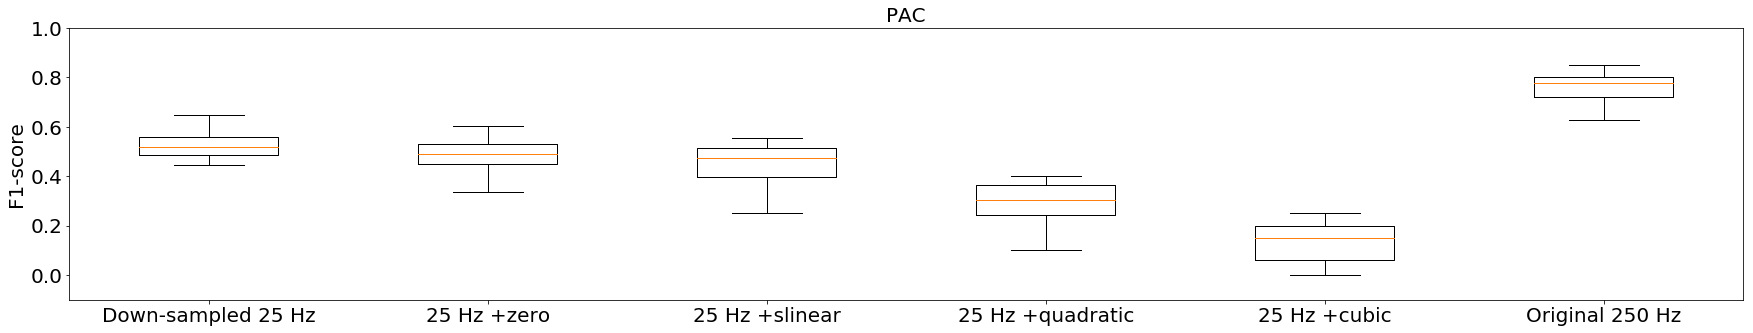

[0.51655983 0.49193548 0.47393048 0.303467   0.1483306  0.77935223]
nan*
nan**
-127#**
[1.33959254e-04 1.20823087e-07 1.83901757e-08 8.83776039e-09
 8.63078733e-11 1.00000000e+00]


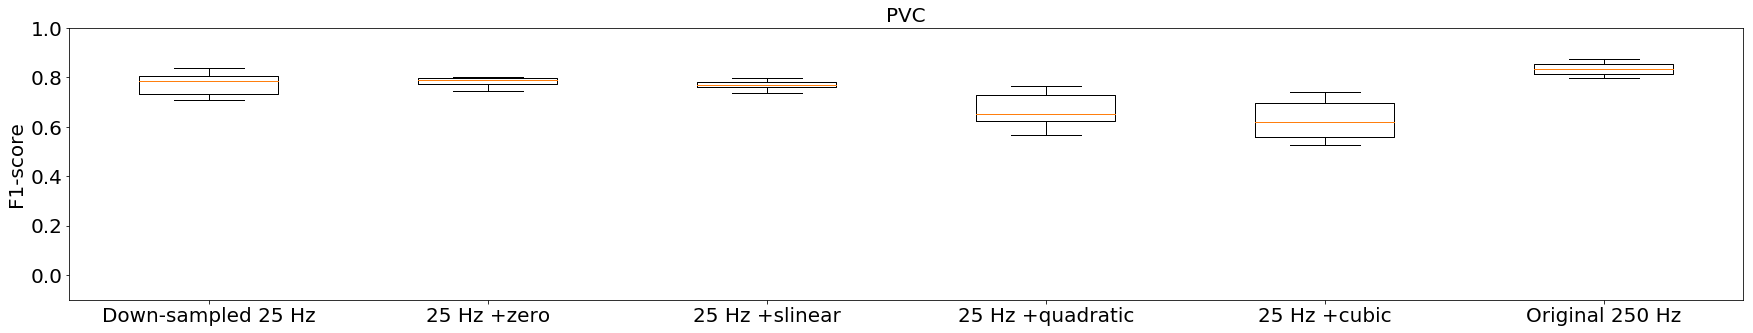

[0.78718905 0.79128857 0.77074353 0.6528464  0.62048055 0.8341785 ]
nan*
nan**
124#**
[2.45771624e-03 3.77609546e-04 5.27752079e-05 3.56380552e-05
 3.06443498e-05 1.00000000e+00]


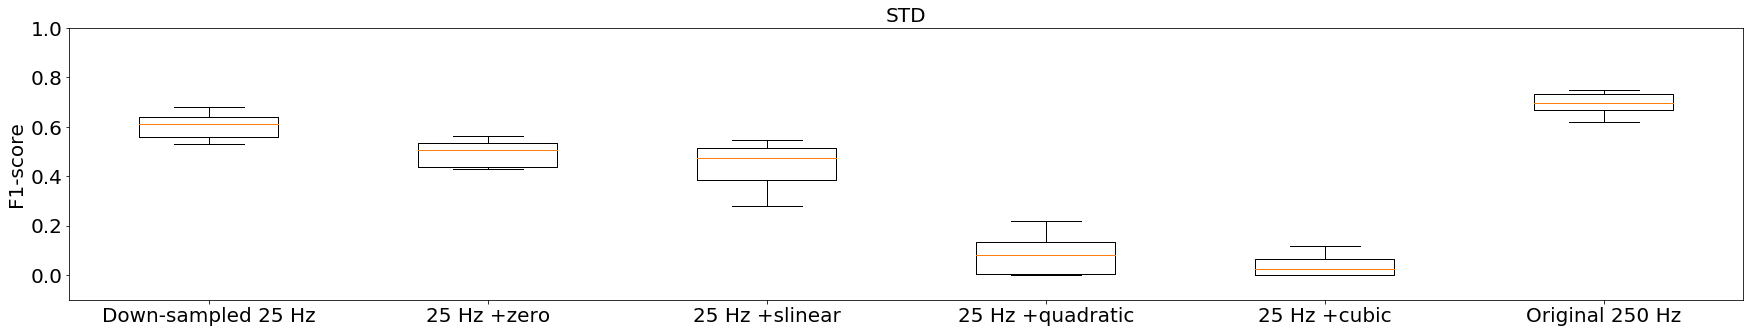

[0.61082588 0.50778246 0.47361195 0.08062771 0.02485335 0.69824311]
nan*
nan**
107#**
[1.57020975e-04 2.99204555e-06 2.62526197e-05 8.67801950e-09
 1.67059578e-10 1.00000000e+00]


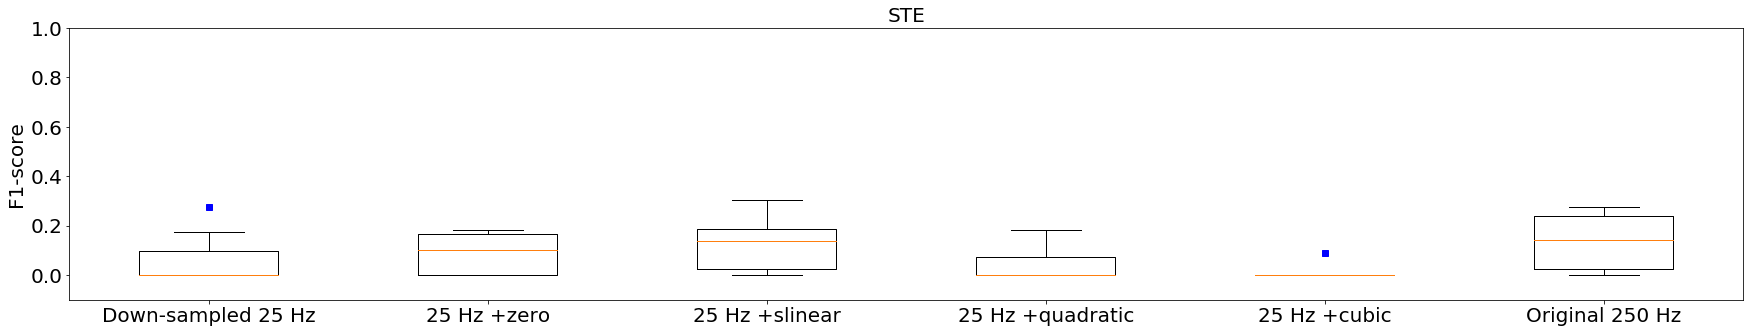

[0.         0.10025063 0.1395881  0.         0.         0.14354067]
nan*
nan**
0#**
[0.2378512  0.0237364  0.85739589 0.03068274 0.00318145 1.        ]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide


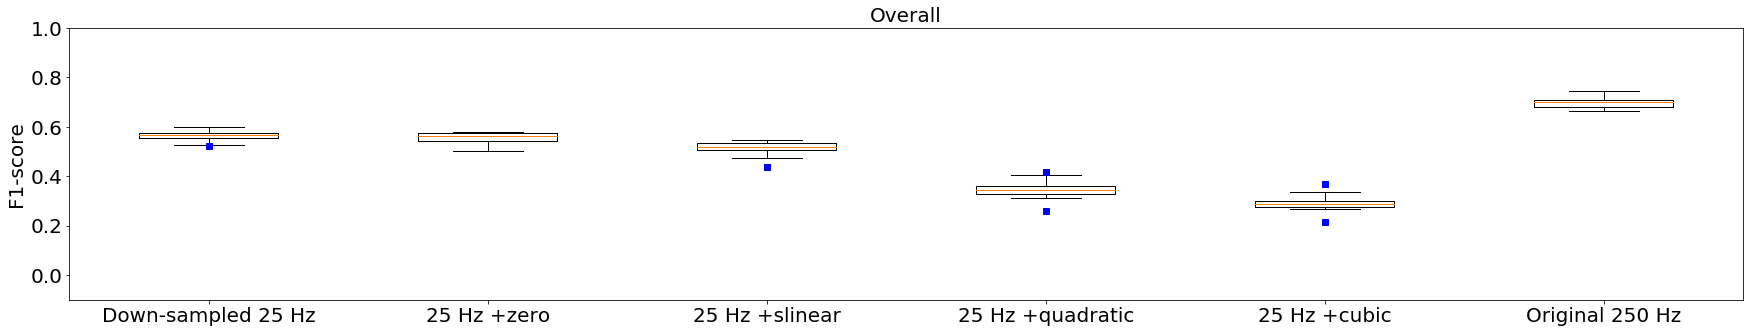

[0.5664428  0.56317774 0.51656808 0.34595774 0.28857693 0.69861625]
nan*
nan**
116#**
[7.84346695e-07 3.41454937e-08 1.91192981e-08 1.47969593e-09
 2.17857004e-10 1.00000000e+00]
Lead :V1


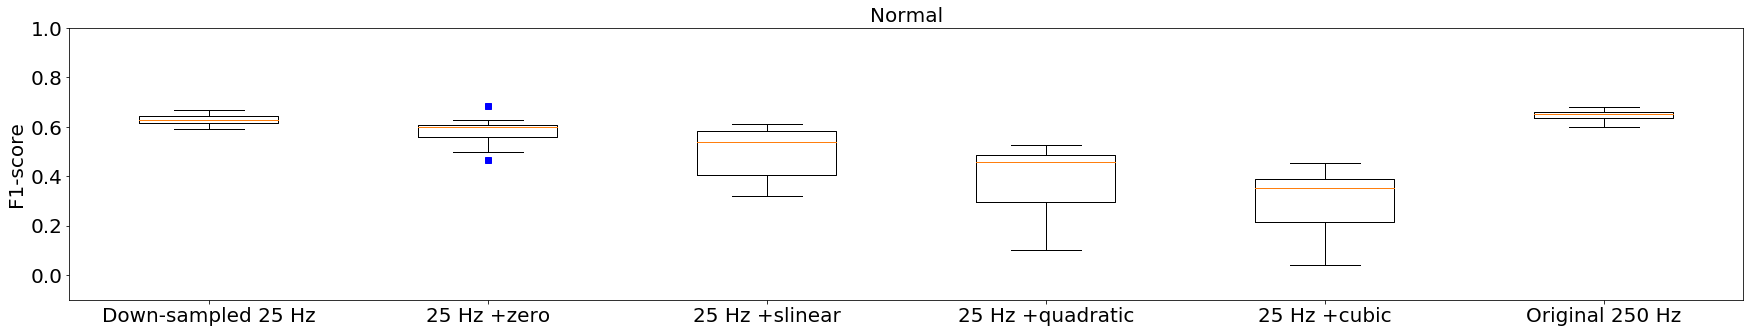

[0.62691649 0.60054645 0.53668666 0.45883743 0.35317837 0.65068807]
nan*
nan**
-118#**
[2.31251568e-02 6.70815244e-03 9.44862305e-04 1.58663489e-04
 2.37293335e-05 1.00000000e+00]


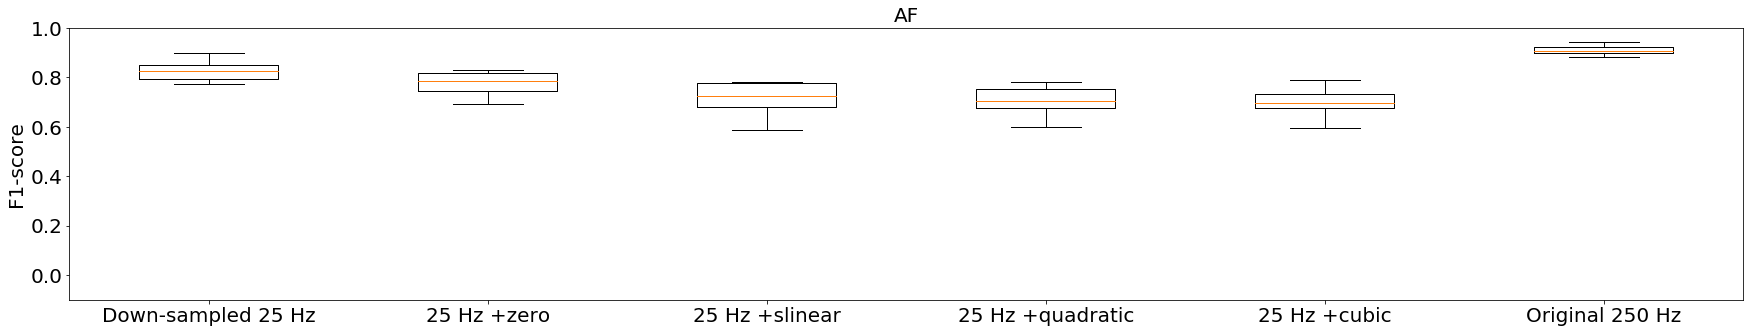

[0.82491987 0.78522492 0.72614228 0.70321612 0.69810891 0.90658824]
nan*
nan**
101#**
[2.04714698e-05 9.31211116e-07 1.92087279e-06 2.19520564e-07
 1.26747629e-07 1.00000000e+00]


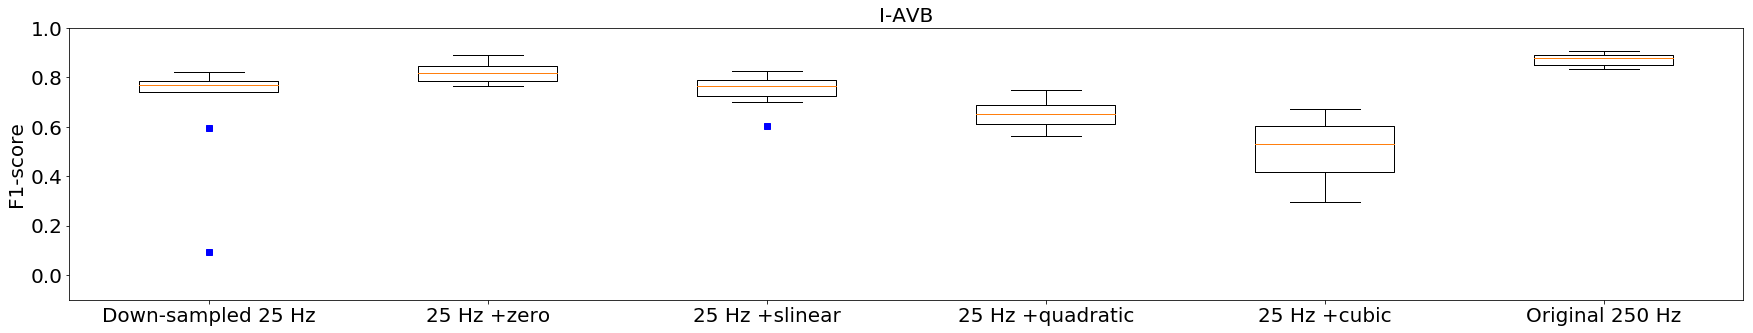

[0.76826318 0.81747935 0.76428571 0.65183413 0.53061224 0.88057041]
nan*
nan**
-98#**
[2.58069879e-02 1.31123961e-03 9.59011061e-05 2.53530740e-06
 1.05379020e-05 1.00000000e+00]


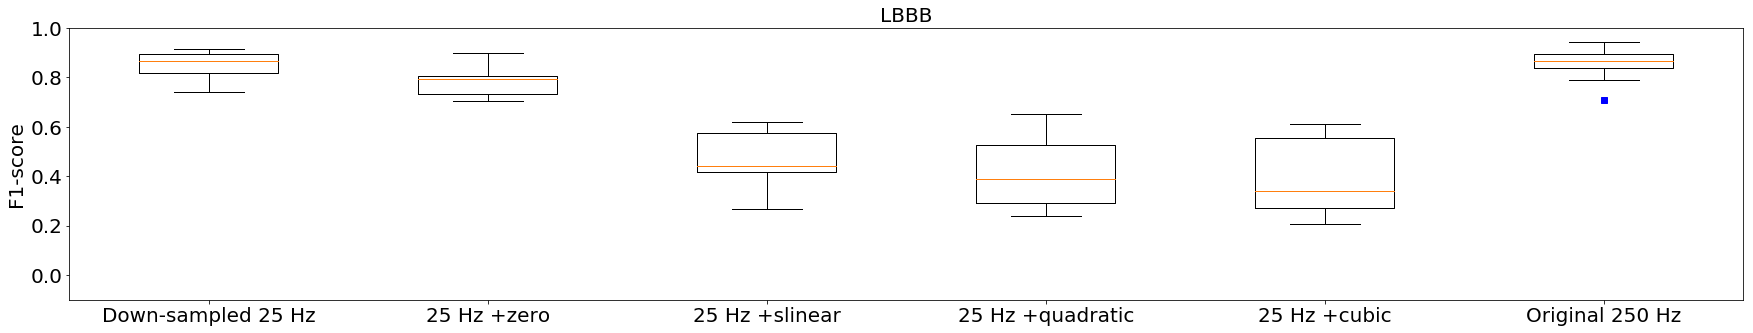

[0.86832987 0.79393939 0.43952922 0.38837966 0.34013605 0.86832987]
nan*
nan**
105#**
[7.95059506e-01 8.87447422e-03 1.04198452e-05 3.03121112e-05
 2.80850862e-05 1.00000000e+00]


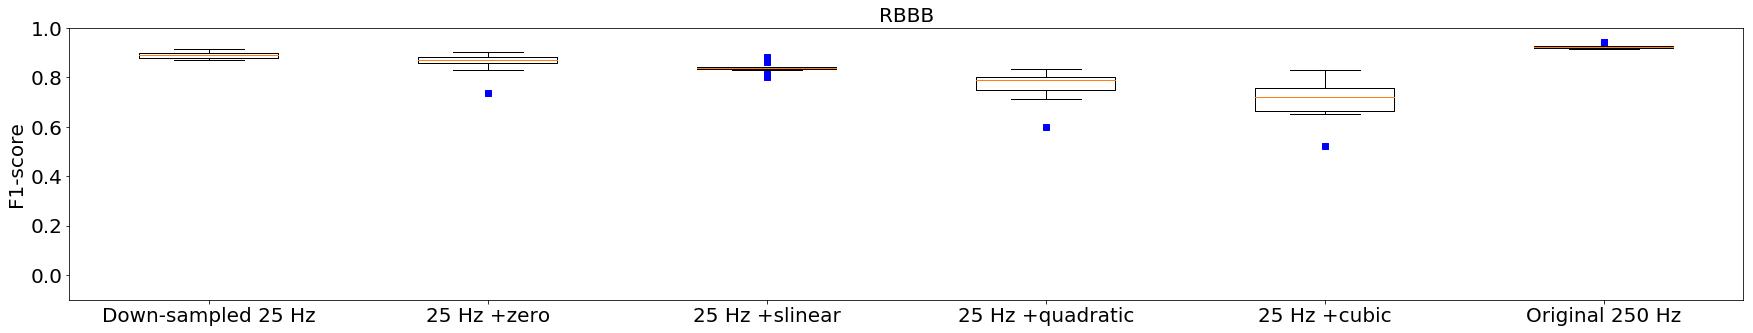

[0.88995253 0.87030367 0.837933   0.78932587 0.71970864 0.92379032]
nan*
nan**
-120#**
[2.27610595e-05 2.00699777e-03 1.30924144e-06 4.12547770e-05
 1.83809970e-05 1.00000000e+00]


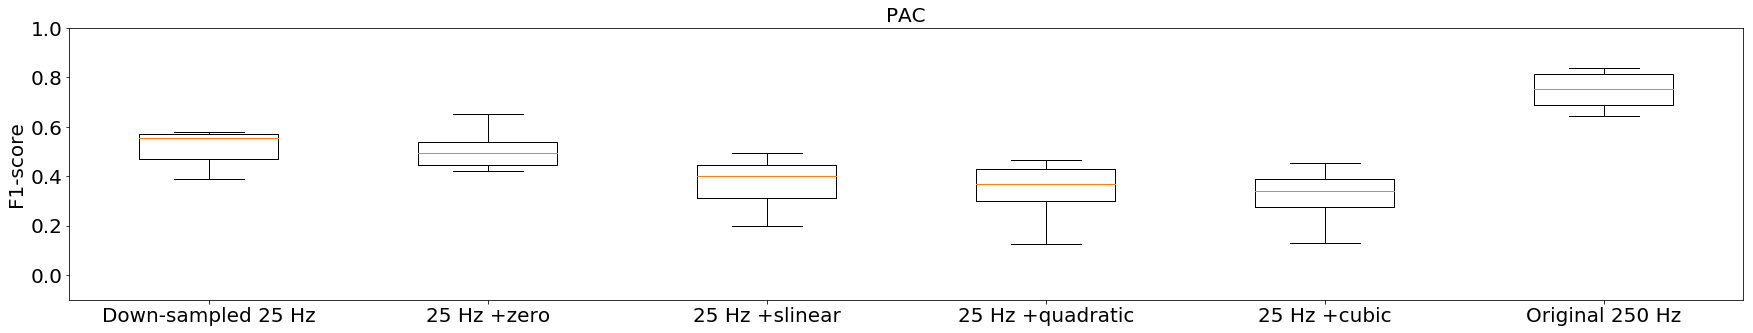

[0.55632799 0.49378922 0.40183486 0.36706497 0.33915276 0.75452517]
nan*
nan**
105#**
[1.75344103e-06 4.35374760e-08 2.60434216e-07 9.94588914e-07
 5.01149781e-07 1.00000000e+00]


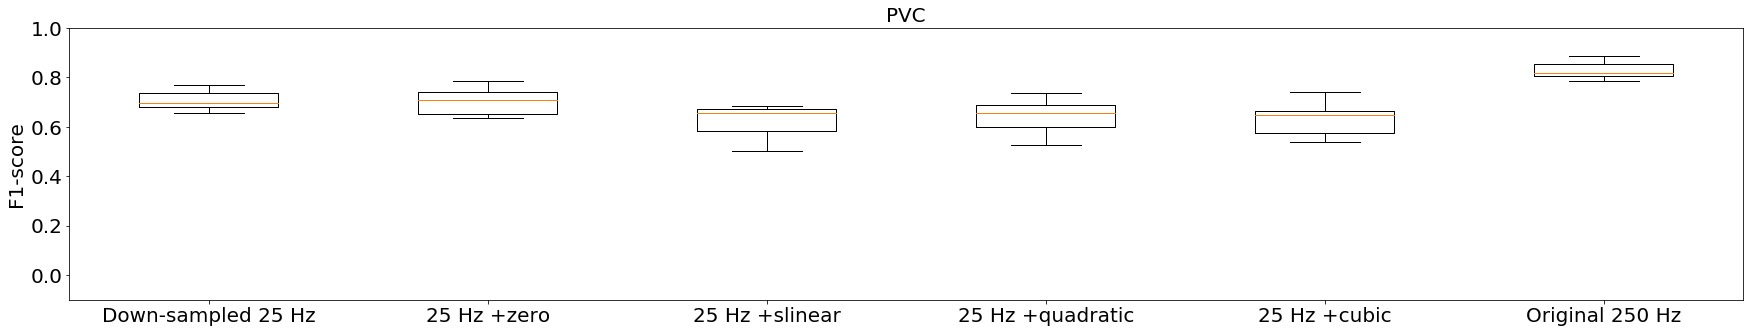

[0.69489139 0.70781157 0.65413534 0.65636071 0.64768594 0.81661573]
nan*
nan**
109#**
[3.89188957e-08 1.03305810e-05 1.06602559e-06 3.59501387e-06
 1.63425295e-06 1.00000000e+00]


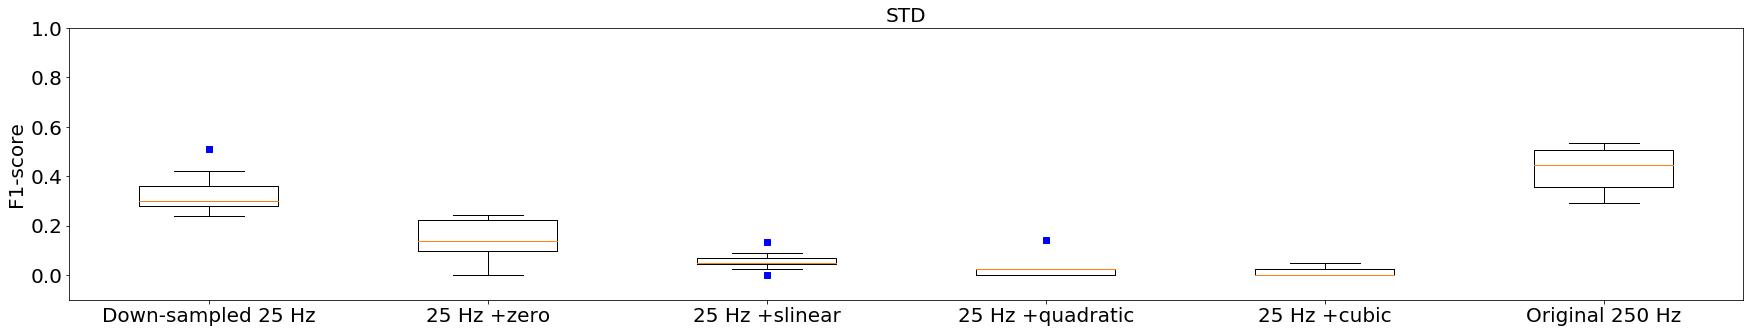

[0.29945825 0.13636364 0.04938272 0.0245408  0.         0.44418349]
nan*
nan**
100#**
[3.30762748e-02 5.57245475e-05 1.71191017e-07 3.43972379e-07
 1.09848063e-07 1.00000000e+00]


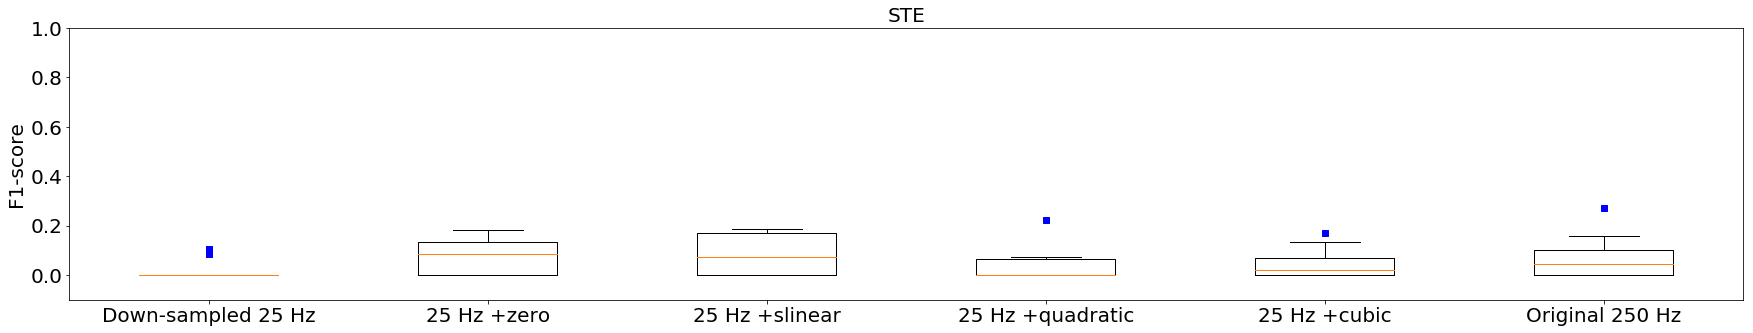

[0.         0.08545455 0.07323232 0.         0.02173913 0.04545455]
nan*
nan**
0#
[0.13887894 0.93783711 0.73944465 0.47583621 0.51808654 1.        ]


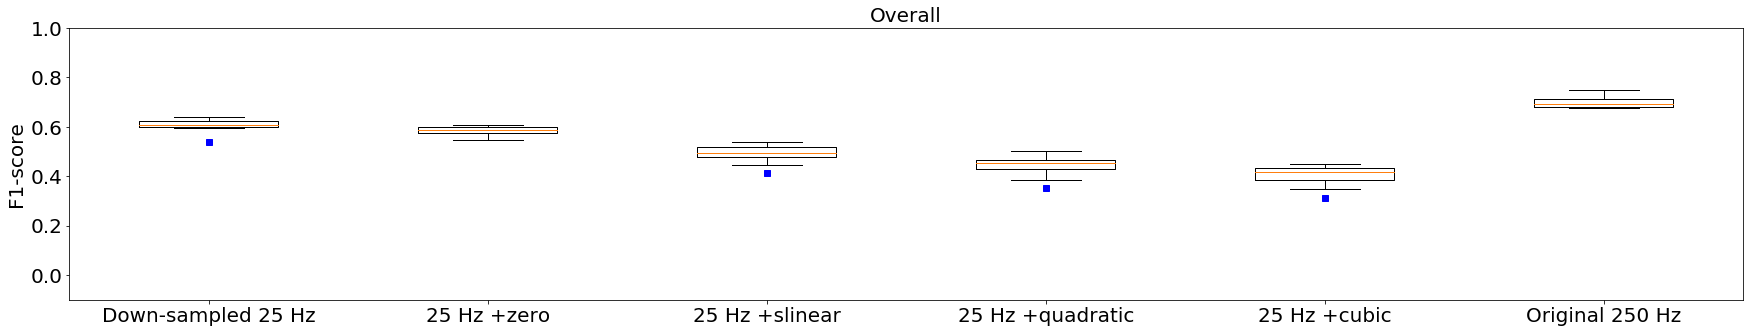

[0.60766091 0.58773685 0.49525972 0.4538135  0.41535093 0.69292397]
nan*
nan**
116#**
[1.06641606e-05 1.17327346e-07 8.24369312e-09 1.04110674e-08
 4.72987021e-09 1.00000000e+00]
Lead :V2


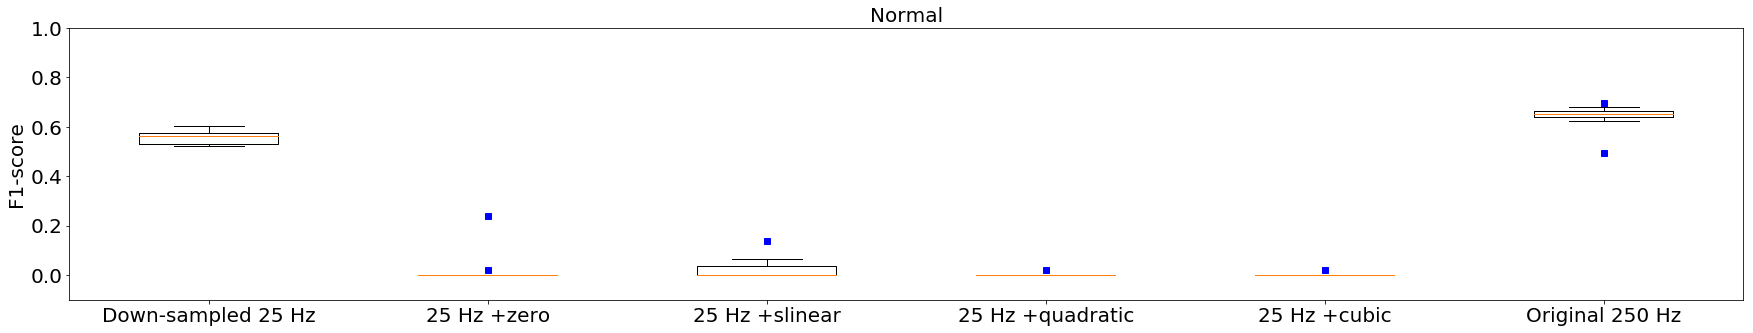

[0.56369275 0.         0.         0.         0.         0.65082922]
nan*
nan**
100#**
[5.62137231e-03 8.51368144e-09 2.52705352e-09 4.65557864e-11
 4.65557864e-11 1.00000000e+00]


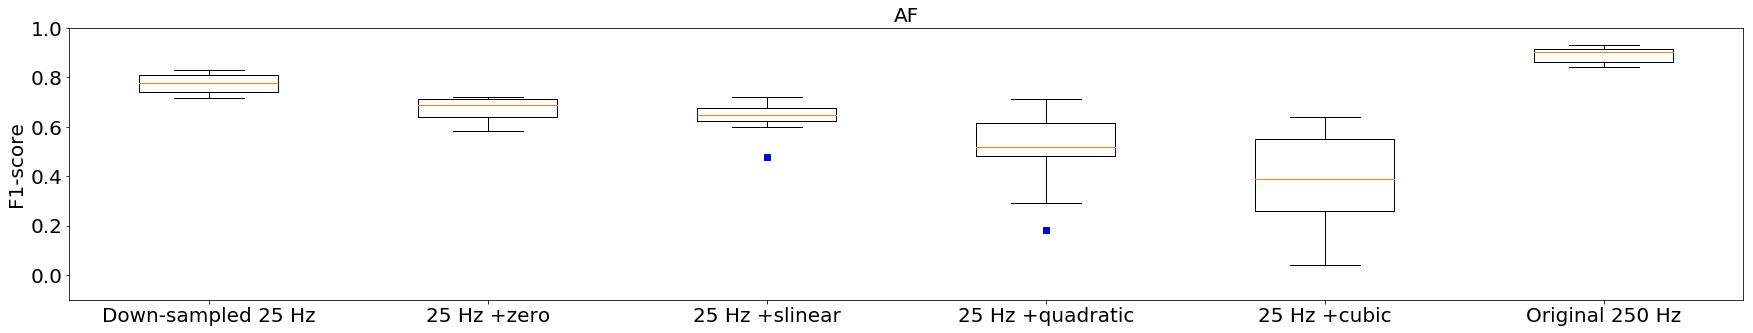

[0.77552207 0.68743434 0.64794316 0.51809916 0.38692272 0.9017771 ]
nan*
nan**
122#**
[2.36861599e-06 1.34699814e-08 1.11420859e-06 4.46146586e-05
 2.01006857e-05 1.00000000e+00]


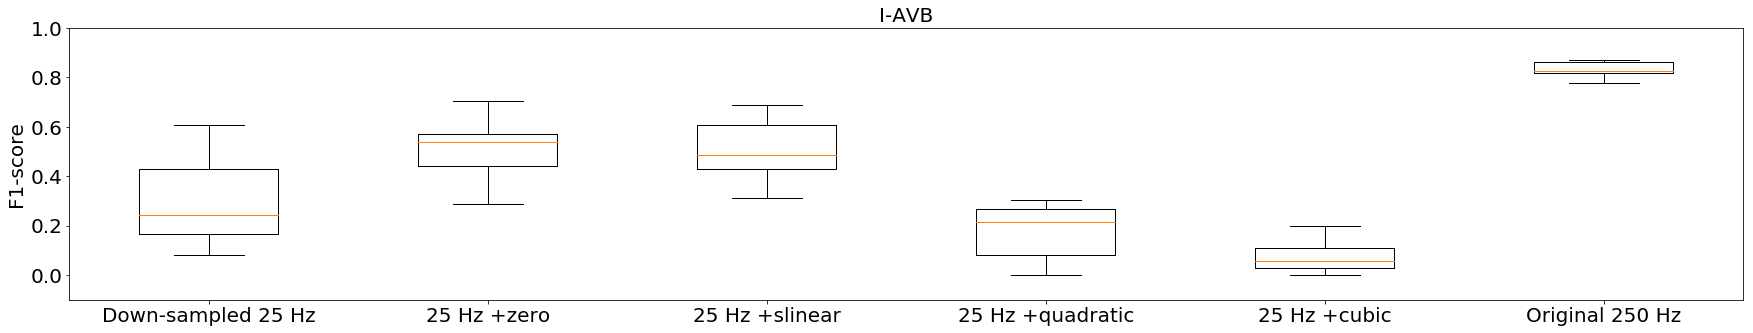

[0.24189316 0.53887457 0.48473245 0.21665044 0.05674044 0.8243759 ]
nan*
nan**
119#**
[3.10105812e-06 6.20718360e-05 1.24801481e-05 7.58423386e-09
 1.51487503e-11 1.00000000e+00]


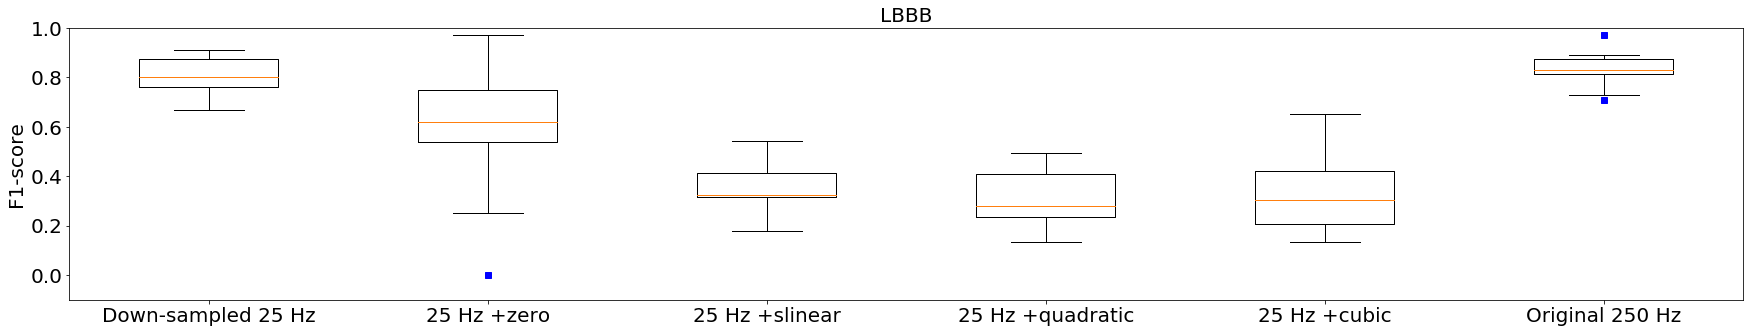

[0.80065359 0.62142857 0.3238389  0.27931281 0.30282343 0.82843137]
nan*
nan**
98#**
[4.71684545e-02 2.93070340e-02 2.40419563e-06 1.61328573e-06
 1.24266587e-05 1.00000000e+00]


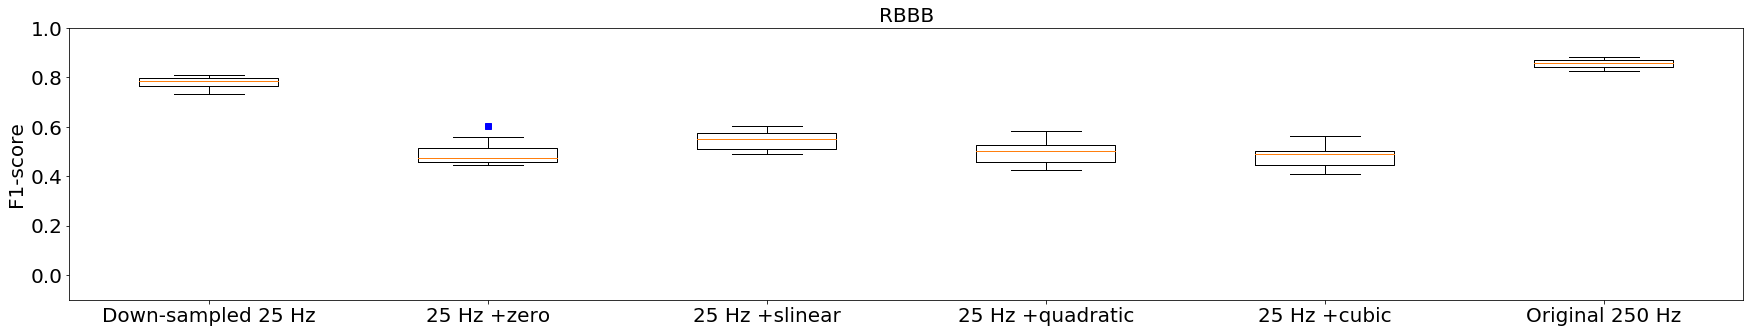

[0.78736282 0.4758943  0.54949155 0.50020114 0.48887813 0.85864136]
nan*
nan**
104#**
[4.99725477e-07 2.13810970e-08 1.93424031e-09 9.21788062e-09
 8.76671594e-09 1.00000000e+00]


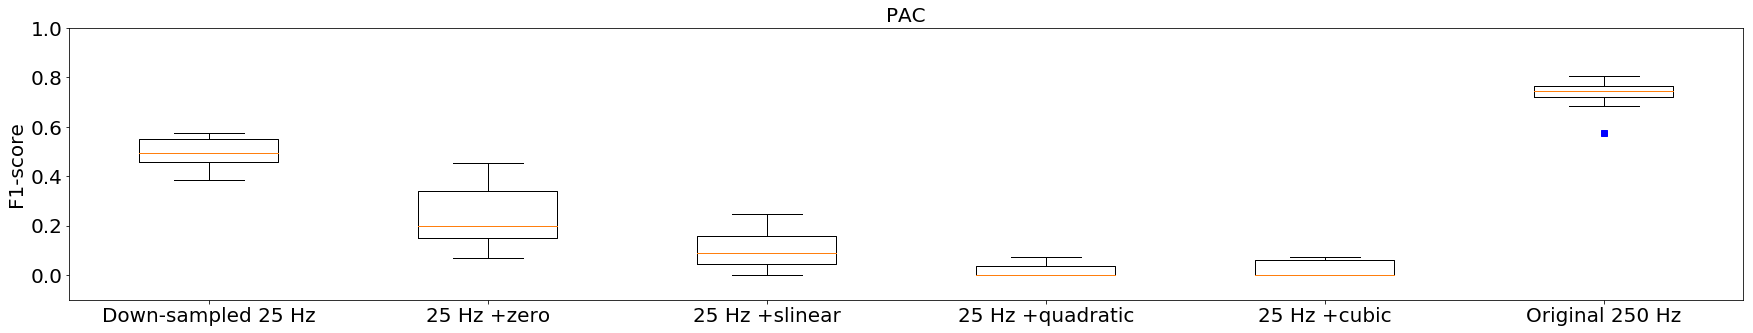

[0.49210353 0.19817927 0.08865915 0.         0.         0.7463808 ]
nan*
nan**
100#**
[1.00354701e-05 2.71216395e-06 2.65955418e-08 4.85408142e-10
 1.24567750e-09 1.00000000e+00]


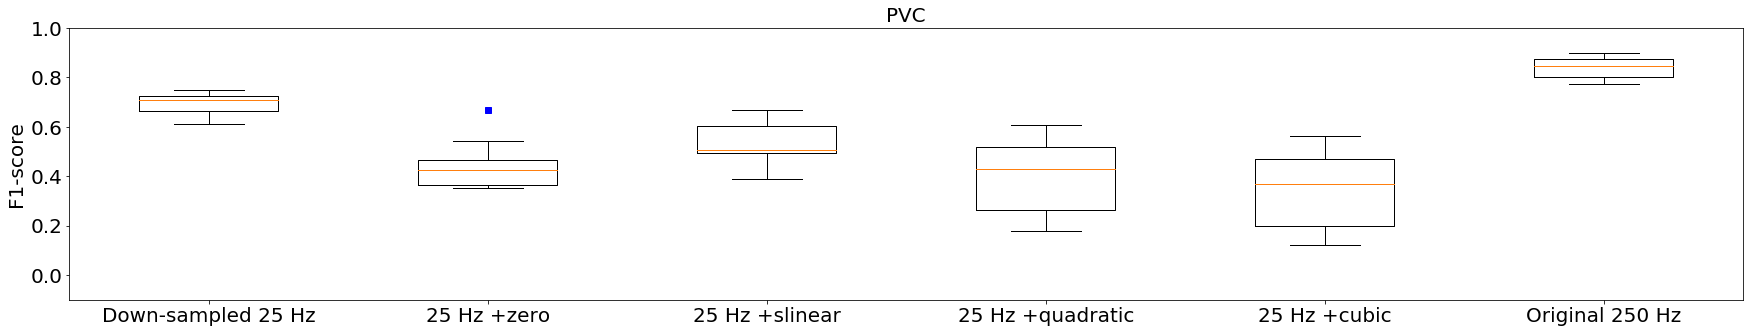

[0.70692348 0.42580645 0.50743849 0.4308642  0.36833333 0.84745763]
nan*
nan**
112#**
[4.80721380e-05 1.96349081e-06 3.00324976e-06 1.90752769e-05
 9.41326476e-06 1.00000000e+00]


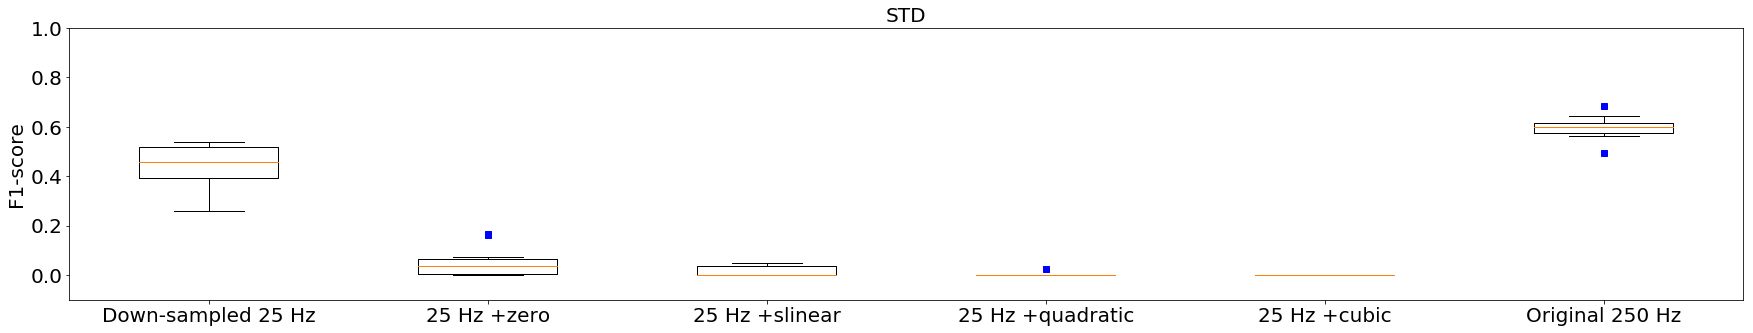

[0.45704962 0.03675461 0.         0.         0.         0.59907979]
nan*
nan**
100#**
[1.03057302e-03 3.92898497e-10 6.80879610e-11 3.60360969e-11
 3.72562158e-11 1.00000000e+00]


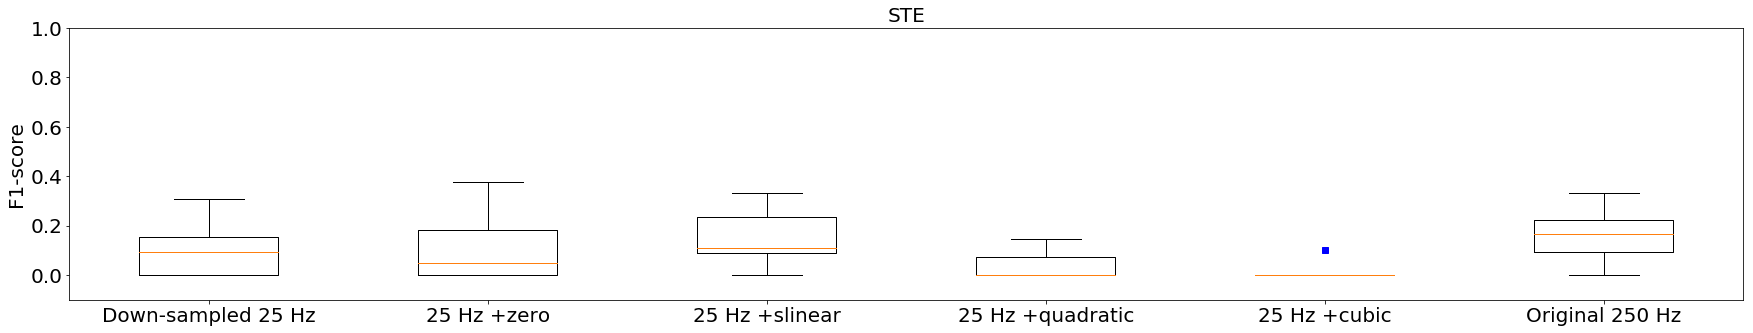

[0.0952381  0.04761905 0.10882353 0.         0.         0.16783217]
nan*
nan**
0#**
[0.09846995 0.2255918  0.85662563 0.00554747 0.00229889 1.        ]


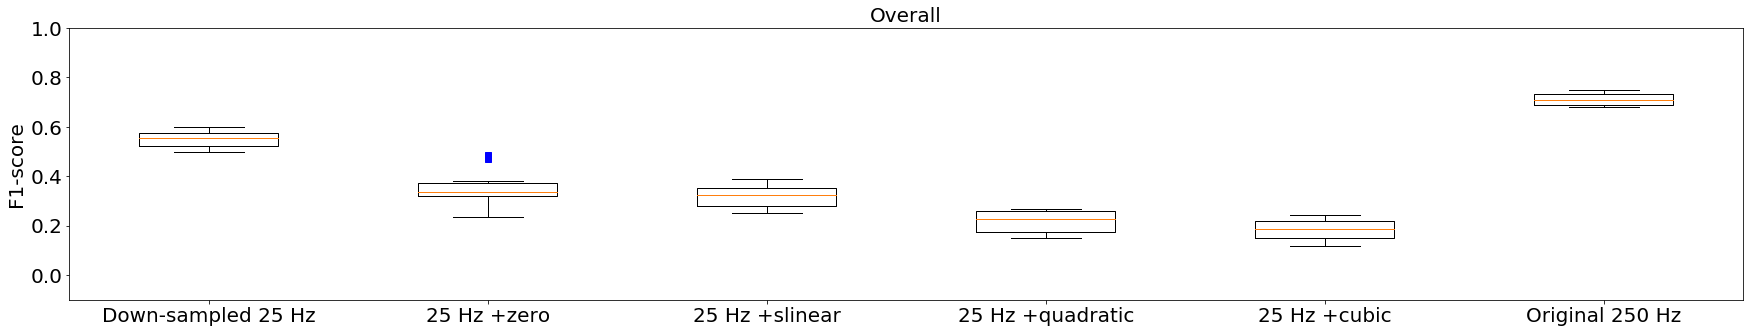

[0.55294673 0.33697837 0.32469772 0.2282249  0.18470686 0.70954901]
nan*
nan**
107#**
[6.33342426e-07 7.27601200e-07 6.49807448e-09 1.09476642e-09
 4.69852965e-10 1.00000000e+00]
Lead :V3


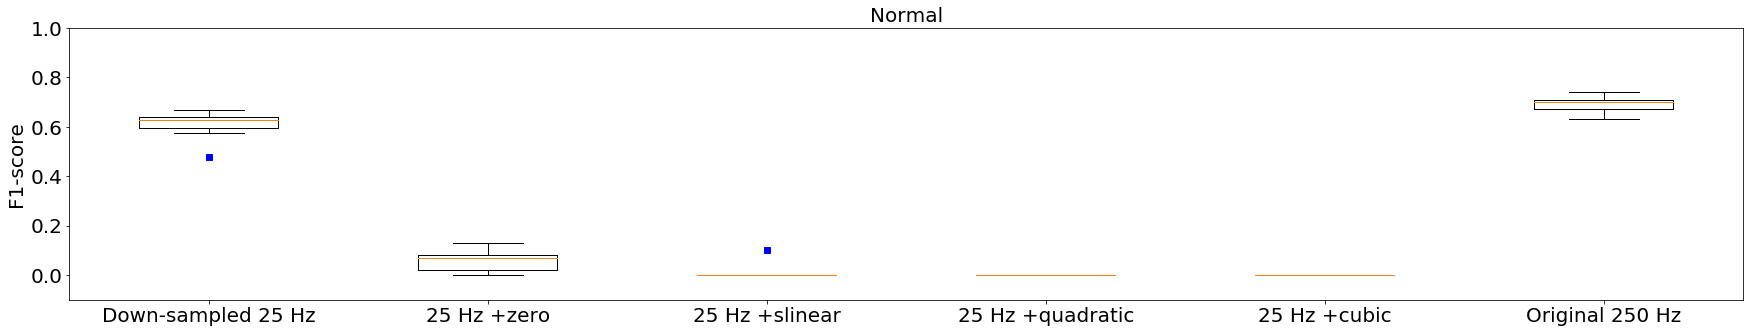

[0.62881307 0.07092784 0.         0.         0.         0.70032696]
nan*
nan**
100#**
[1.83524714e-03 1.12966786e-11 1.90610202e-12 1.38663403e-13
 1.38663403e-13 1.00000000e+00]


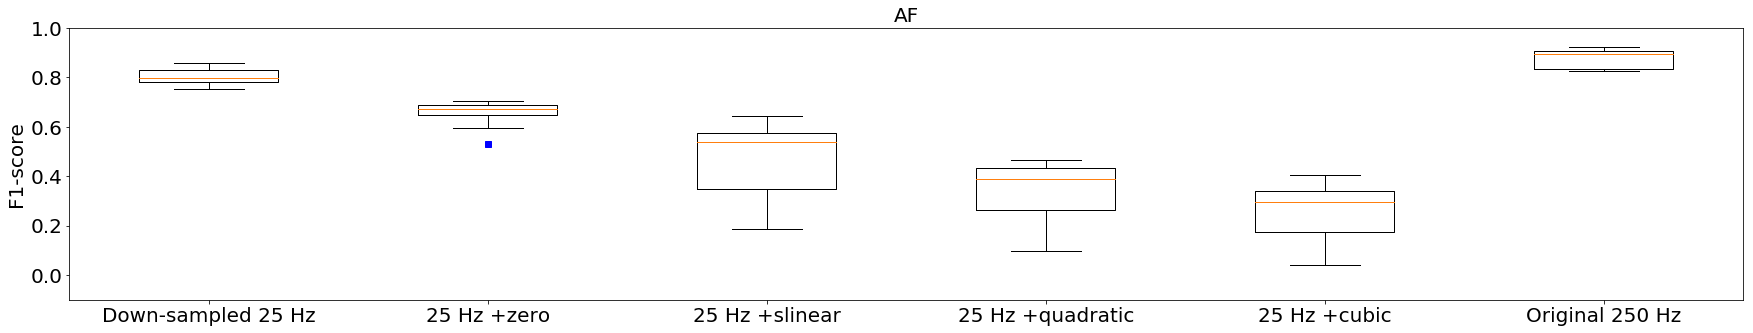

[0.79903846 0.67021638 0.53838157 0.38989833 0.29615802 0.8939951 ]
nan*
nan**
114#**
[7.70160657e-05 3.08668423e-06 3.69259647e-05 1.88271061e-06
 3.68739773e-07 1.00000000e+00]


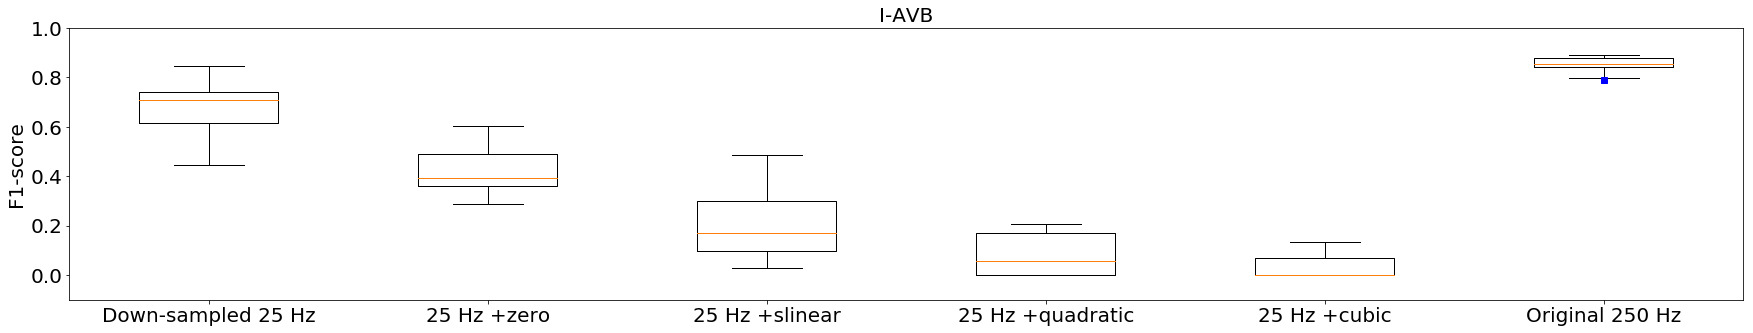

[0.70844227 0.39307672 0.17199017 0.05674044 0.         0.85592869]
nan*
nan**
105#**
[1.23778867e-03 1.61417941e-07 8.18213181e-08 9.74139006e-11
 7.55737379e-13 1.00000000e+00]


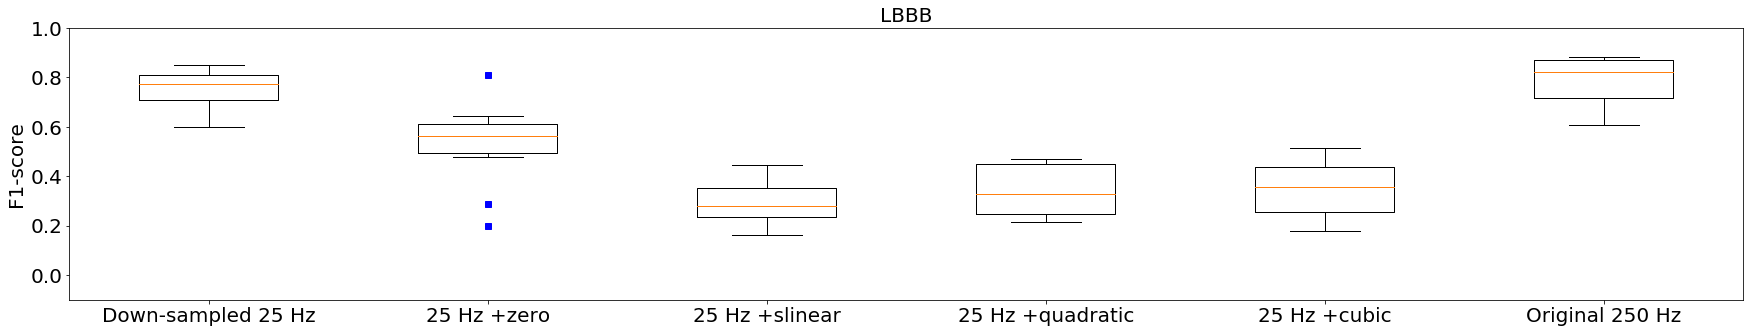

[0.77350427 0.56301887 0.28071439 0.32761217 0.35467046 0.82207207]
nan*
nan**
96#**
[2.46257259e-01 4.63145370e-04 3.25132379e-06 1.41067398e-05
 3.39249046e-05 1.00000000e+00]


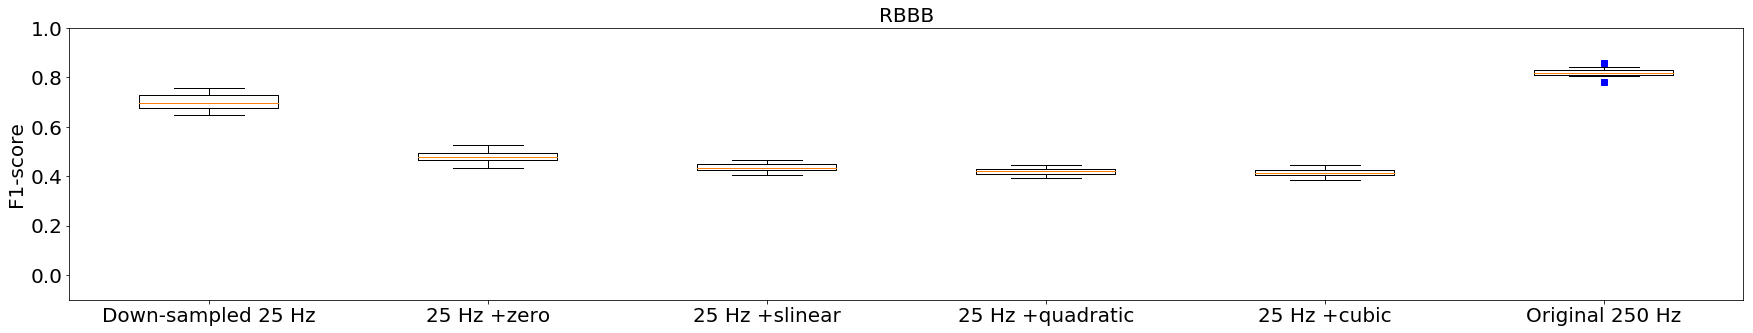

[0.69499106 0.47926461 0.43466216 0.42317454 0.41502661 0.81949733]
nan*
nan**
101#**
[9.06560471e-07 3.90003252e-11 6.78548336e-11 1.29343808e-11
 1.91346888e-11 1.00000000e+00]


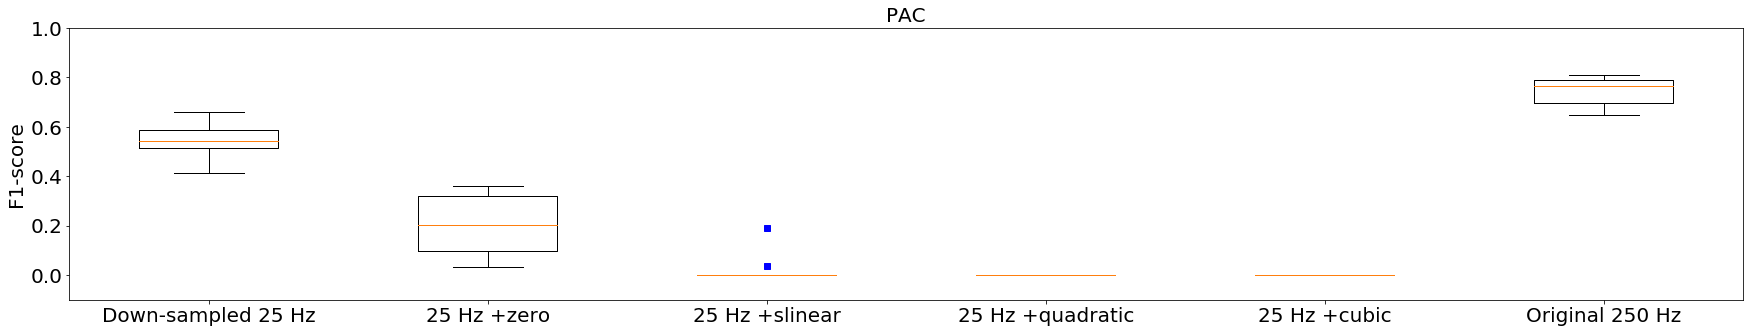

[0.54423077 0.20125181 0.         0.         0.         0.76713928]
nan*
nan**
100#**
[1.10955256e-05 3.06101564e-08 2.01559188e-10 1.41628306e-11
 1.41628306e-11 1.00000000e+00]


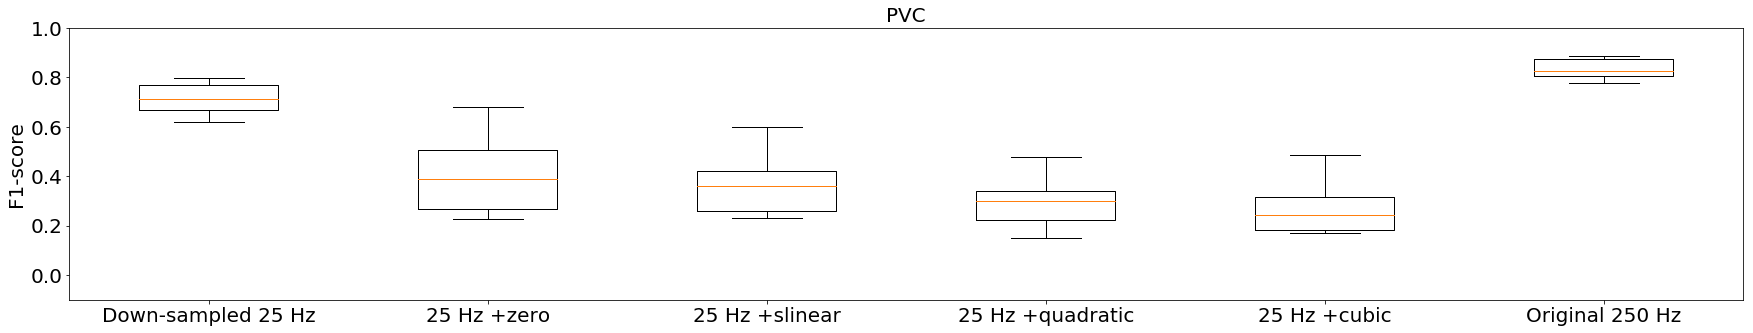

[0.71186441 0.38857816 0.36152882 0.300581   0.24444444 0.82572464]
nan*
nan**
104#**
[1.26658278e-04 1.33939042e-05 3.99485611e-07 2.05930374e-08
 1.17343597e-08 1.00000000e+00]


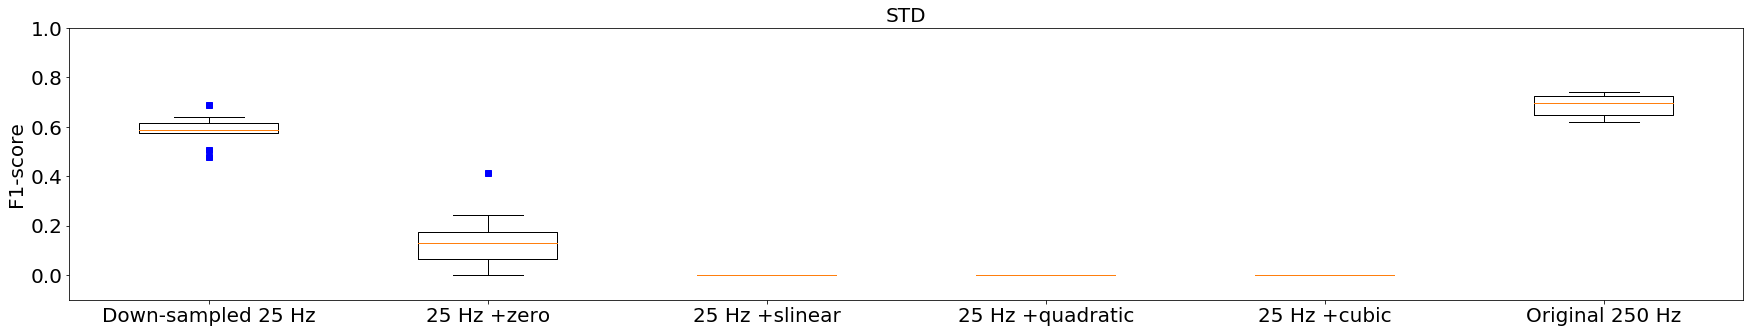

[0.58915608 0.13095238 0.         0.         0.         0.69725725]
nan*
nan**
100#**
[2.59752929e-04 3.41558295e-08 3.54735975e-12 3.54735975e-12
 3.54735975e-12 1.00000000e+00]


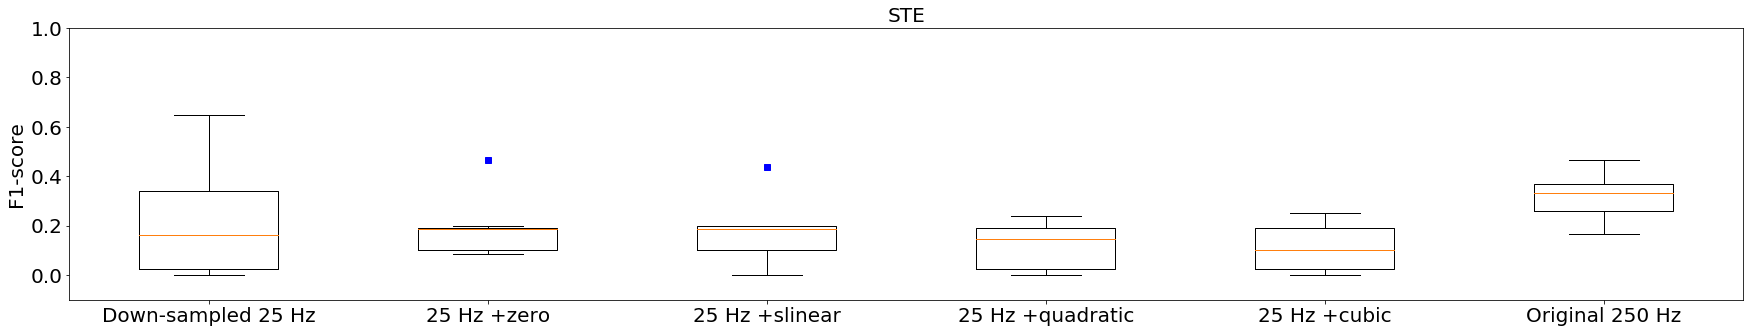

[0.16190476 0.18614719 0.18614719 0.1452381  0.1        0.33142857]
nan*
nan**
100#**
[0.22297    0.01102063 0.02074519 0.00132571 0.00113132 1.        ]


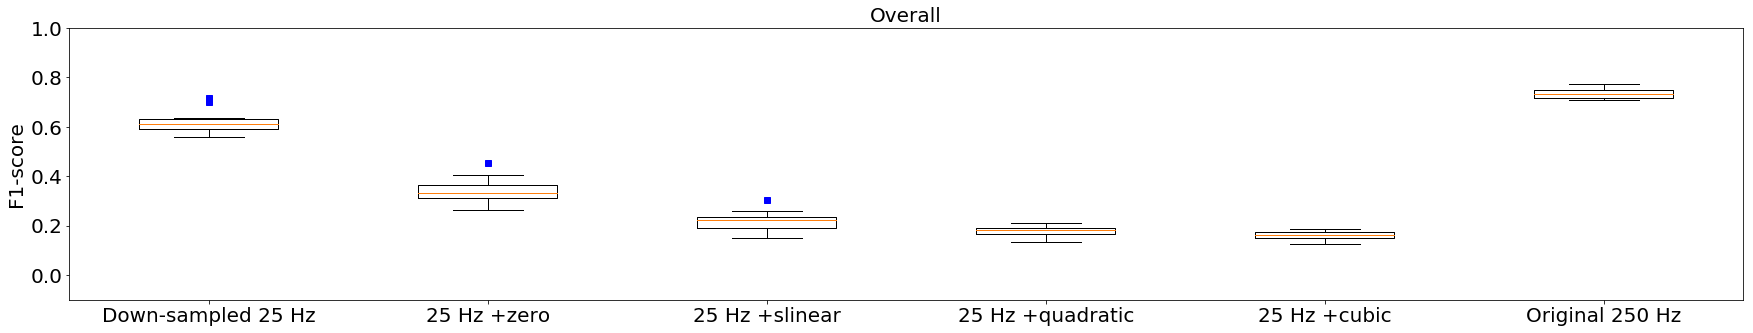

[0.61036016 0.33334917 0.2216038  0.18083138 0.16215095 0.73456931]
nan*
nan**
103#**
[4.50796413e-05 2.40052028e-09 5.00363289e-10 1.75063455e-12
 3.04668766e-13 1.00000000e+00]
Lead :V4


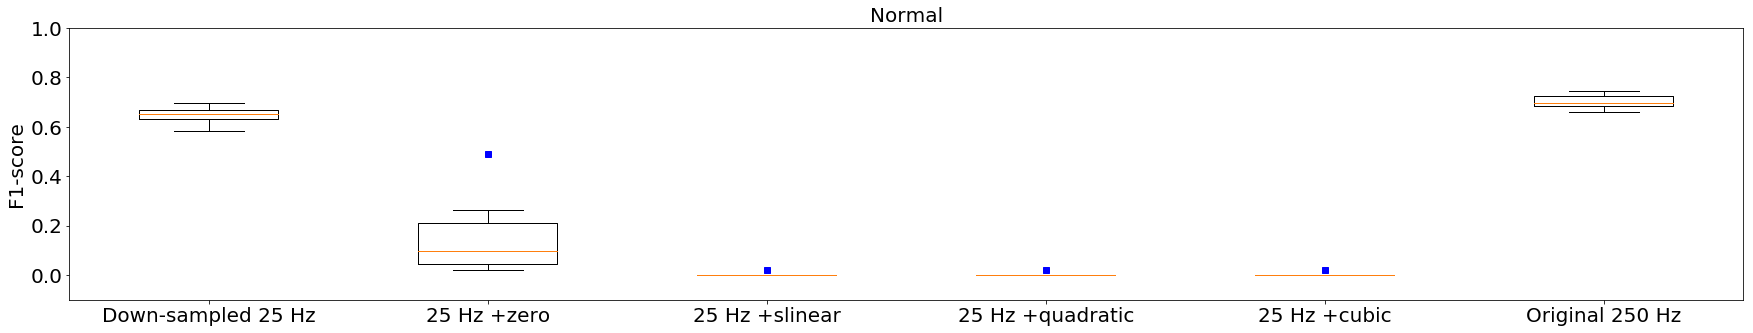

[0.65006002 0.098889   0.         0.         0.         0.69728845]
nan*
nan**
100#**
[2.88063838e-04 9.13577378e-07 1.28635468e-14 1.28635468e-14
 1.28635468e-14 1.00000000e+00]


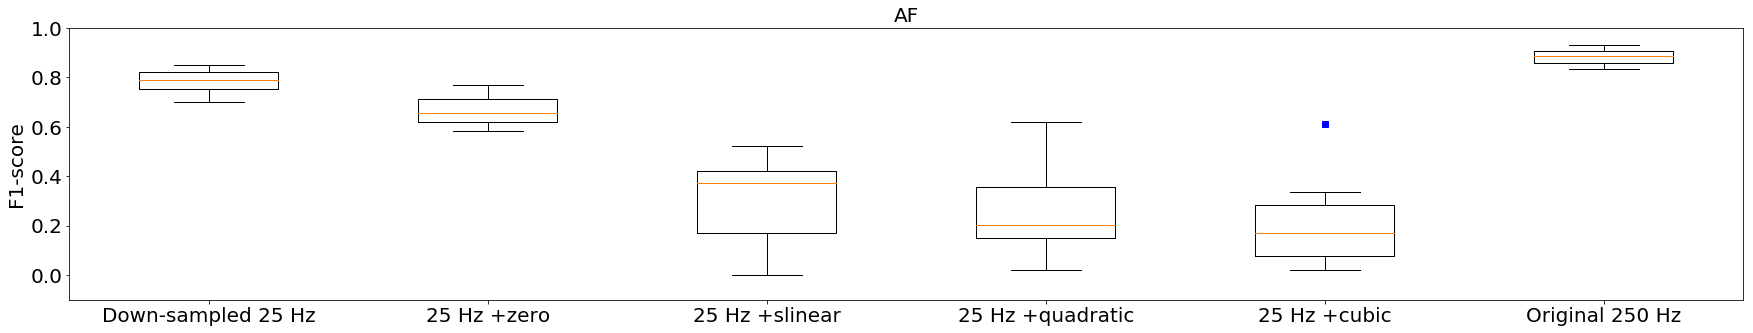

[0.78932677 0.65594952 0.37373437 0.20434783 0.17041853 0.88774341]
nan*
nan**
104#**
[1.00970432e-05 1.73708711e-06 3.19755034e-06 1.37488642e-06
 7.01703337e-07 1.00000000e+00]


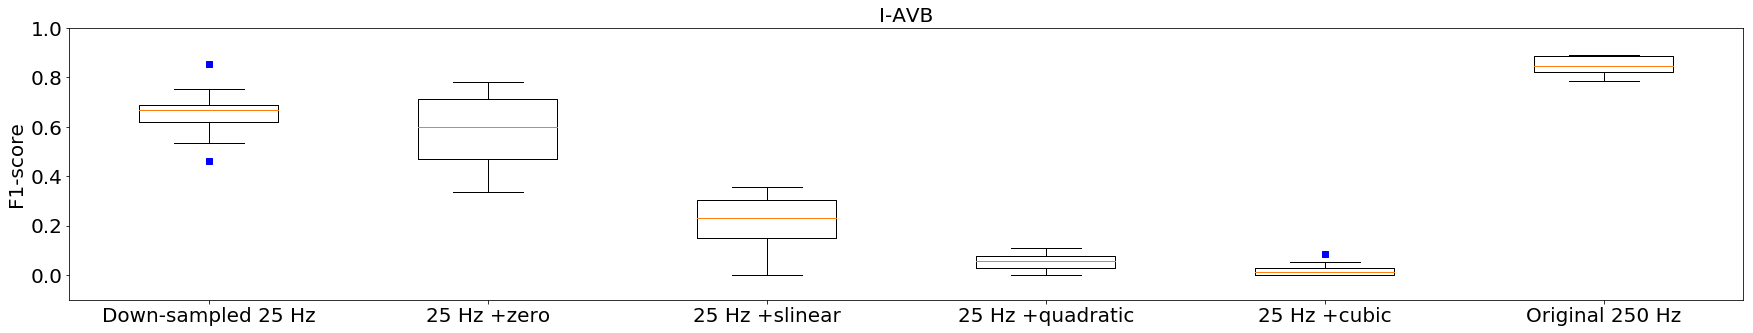

[0.66666667 0.60132275 0.23226773 0.05633803 0.01428571 0.84806713]
nan*
nan**
103#**
[4.05623301e-04 2.28343092e-04 6.27852432e-08 5.99002407e-13
 4.05598793e-14 1.00000000e+00]


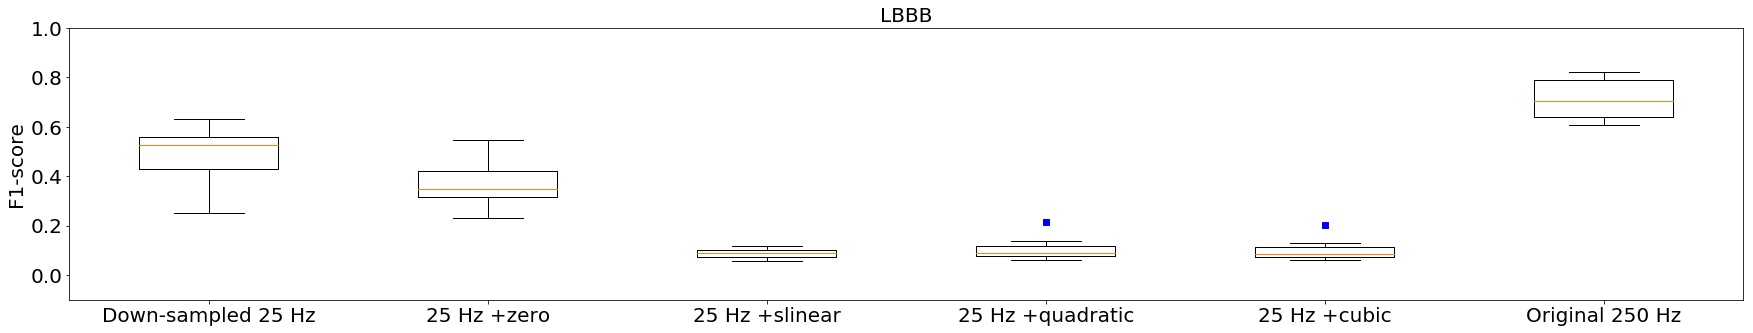

[0.52592593 0.34969995 0.08977456 0.09077689 0.08662624 0.70542636]
nan*
nan**
101#**
[1.20564076e-03 3.24645636e-06 1.61831390e-09 2.28498144e-09
 2.04996819e-09 1.00000000e+00]


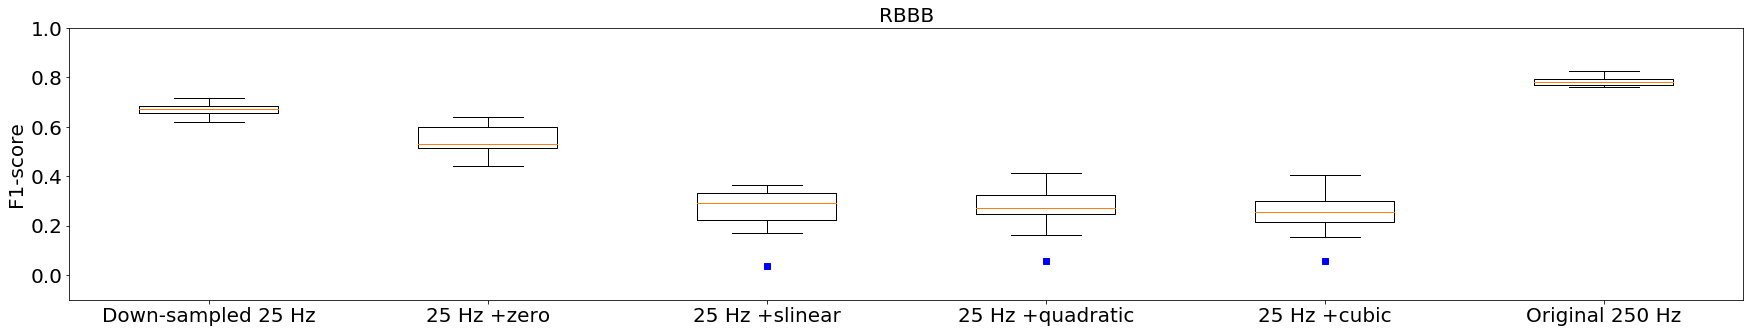

[0.67343278 0.5306658  0.29172339 0.27027836 0.25371762 0.78166188]
nan*
nan**
103#**
[5.82677245e-09 3.29729668e-06 6.46015399e-08 6.91512930e-08
 3.79781139e-08 1.00000000e+00]


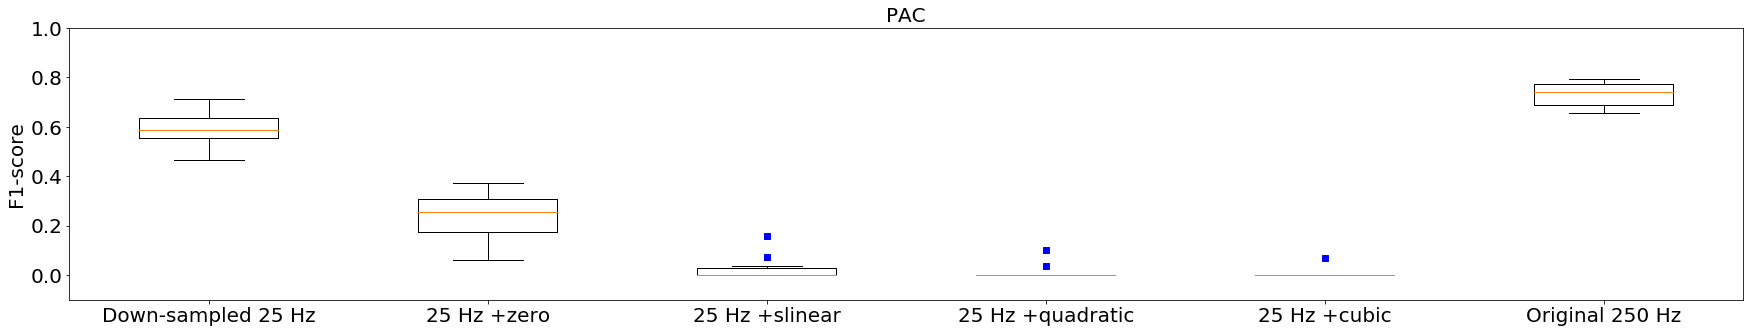

[0.58537978 0.25432362 0.         0.         0.         0.7399032 ]
nan*
nan**
100#**
[6.46845395e-05 3.49412252e-07 8.59954740e-11 9.08701733e-12
 9.36345400e-12 1.00000000e+00]


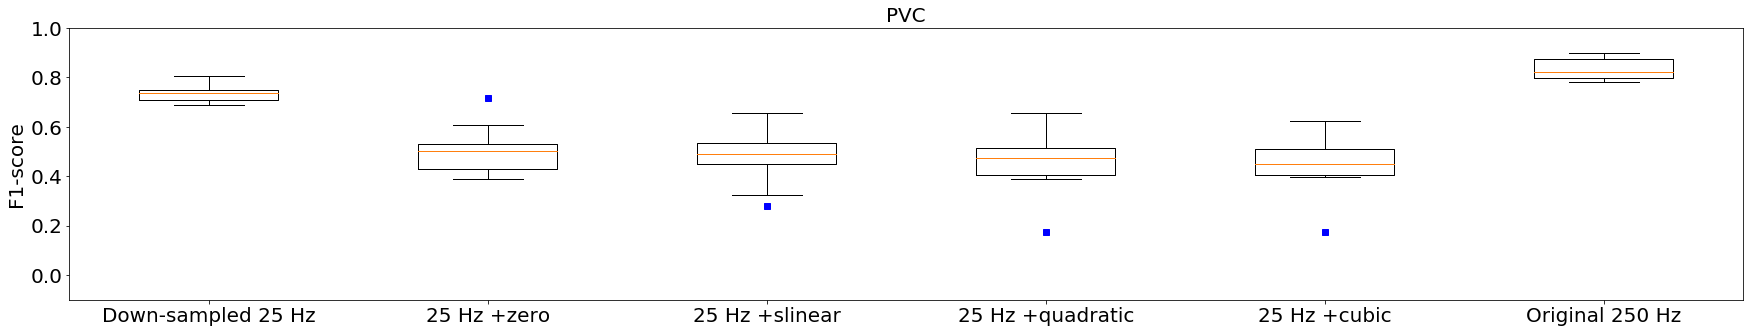

[0.73509643 0.50165563 0.49109345 0.47465438 0.44916004 0.82046036]
nan*
nan**
102#**
[5.18415236e-07 1.34422901e-06 5.35432065e-06 5.80056690e-06
 2.33249201e-06 1.00000000e+00]


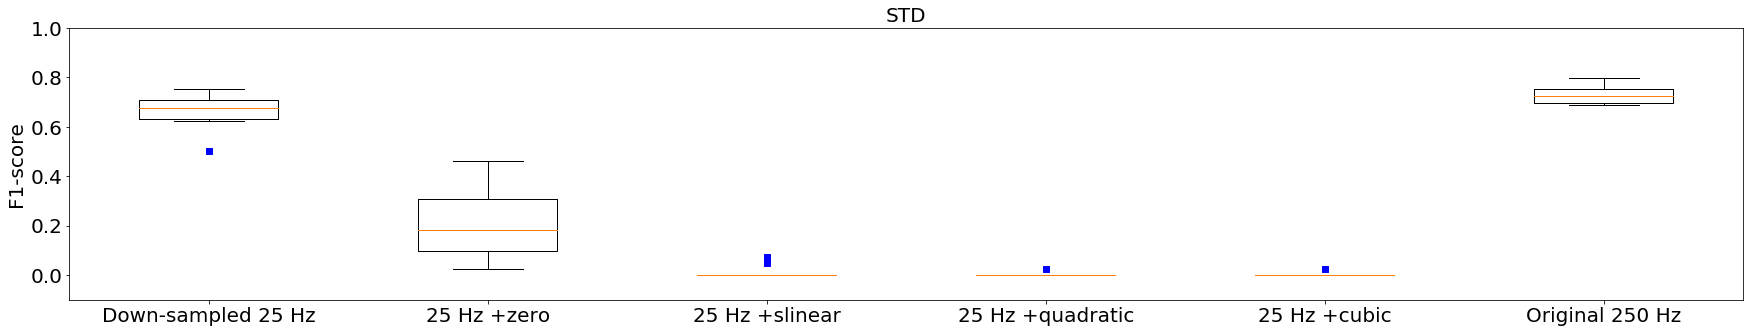

[0.67696736 0.18212699 0.         0.         0.         0.72434211]
nan*
nan**
100#**
[8.89014747e-03 3.05782408e-06 1.25633303e-11 6.84477475e-13
 6.84477475e-13 1.00000000e+00]


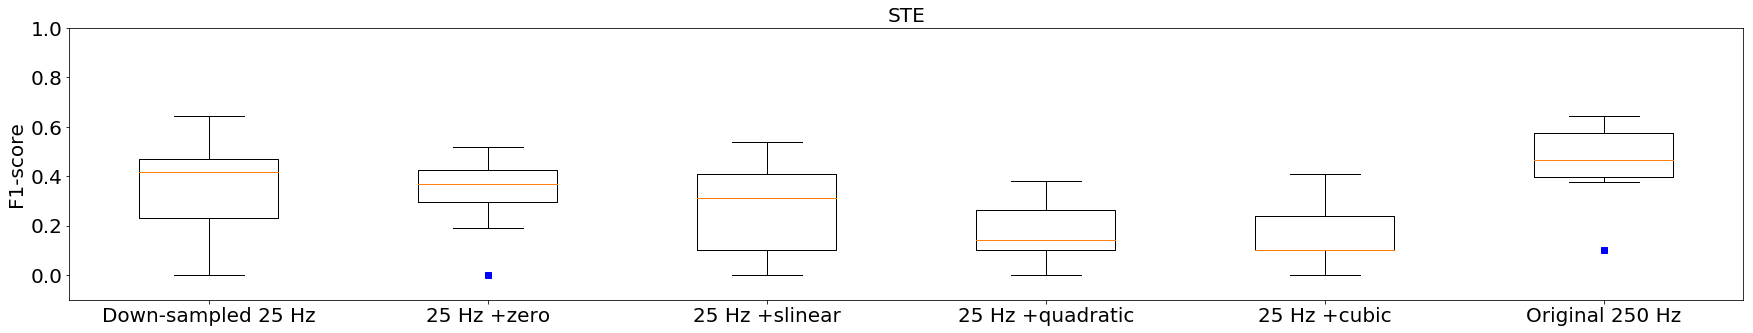

[0.41522989 0.36818687 0.31027668 0.14090909 0.1        0.46713287]
nan*
nan**
100#**
[2.24115610e-01 1.56822905e-02 1.31901337e-03 3.35883098e-04
 6.52372086e-04 1.00000000e+00]


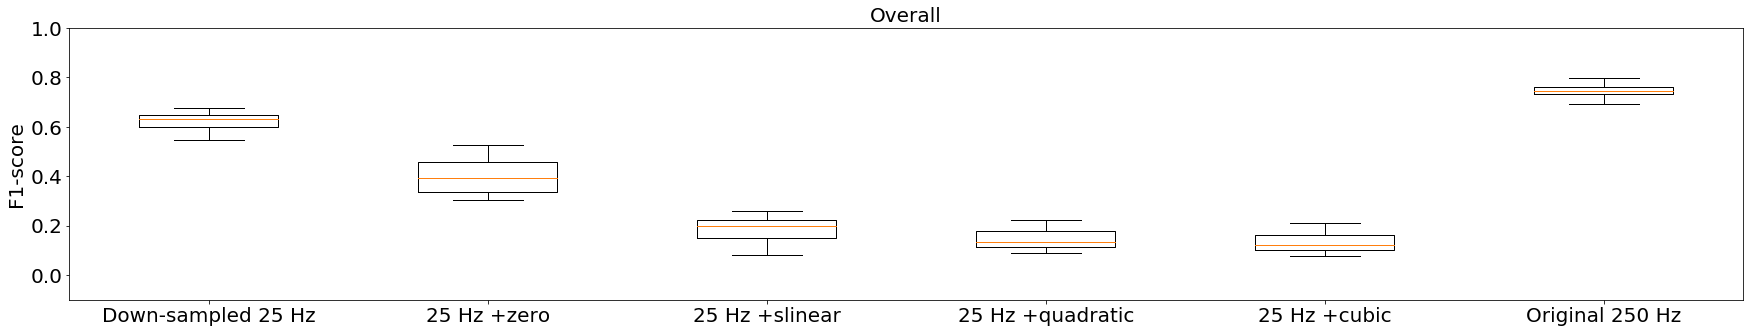

[0.6334107  0.3948098  0.19910507 0.13366747 0.12350996 0.74352235]
nan*
nan**
102#**
[1.51946957e-05 6.73397118e-08 1.73460488e-10 1.62207912e-11
 7.69242979e-12 1.00000000e+00]
Lead :V5


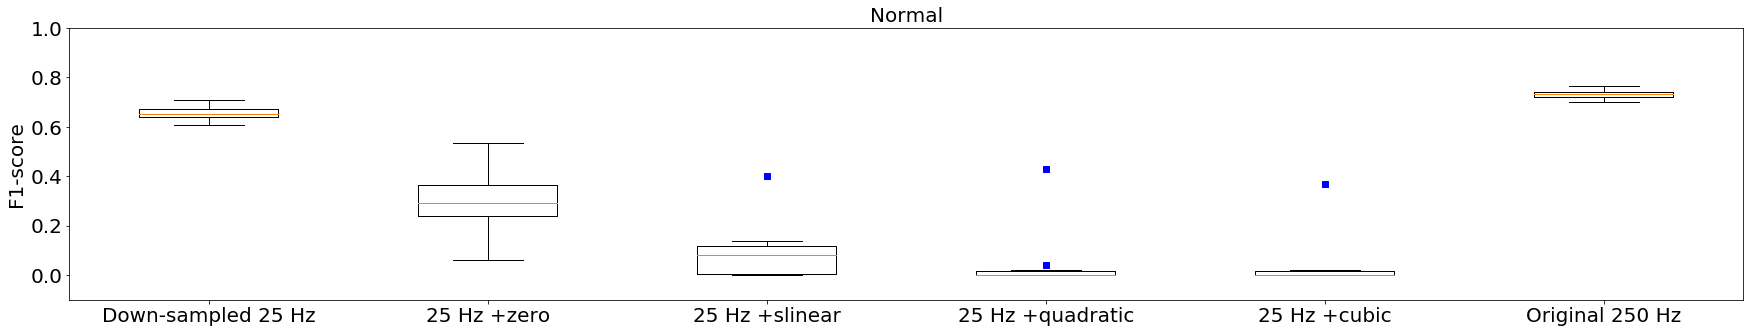

[0.65057818 0.29076783 0.08301117 0.         0.         0.73244656]
nan*
nan**
100#**
[1.01932896e-04 3.70070613e-06 7.30221773e-08 9.04071405e-08
 2.42520904e-08 1.00000000e+00]


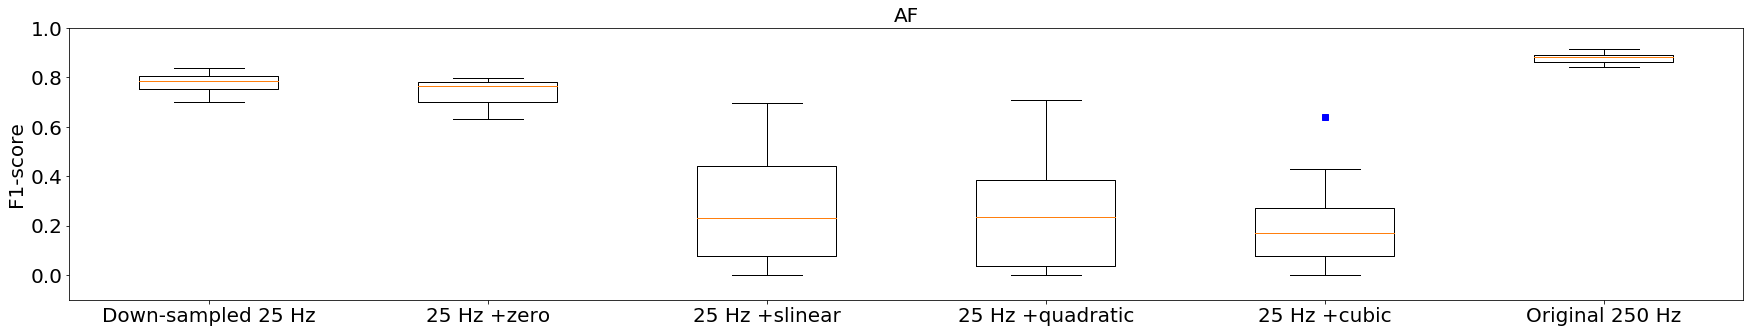

[0.78416383 0.76602838 0.23166048 0.23439982 0.16886884 0.88163265]
nan*
nan**
105#**
[3.62003866e-06 9.85892833e-06 2.28218911e-05 1.08293699e-05
 2.05678169e-06 1.00000000e+00]


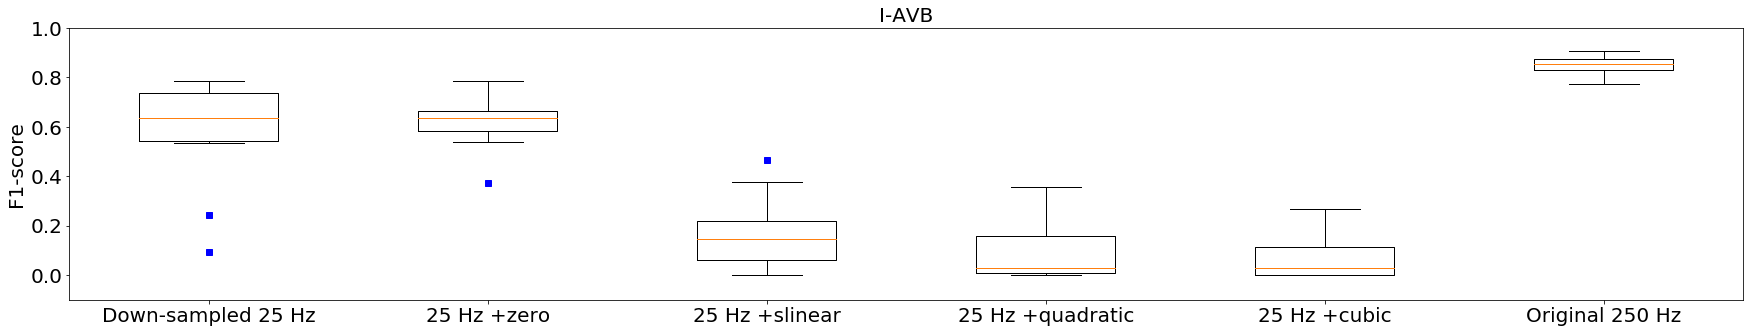

[0.6369191  0.63591573 0.14744052 0.02898551 0.02877847 0.85619349]
nan*
nan**
102#**
[3.35651347e-03 9.70391925e-05 1.49547469e-07 1.68254504e-08
 1.33817119e-09 1.00000000e+00]


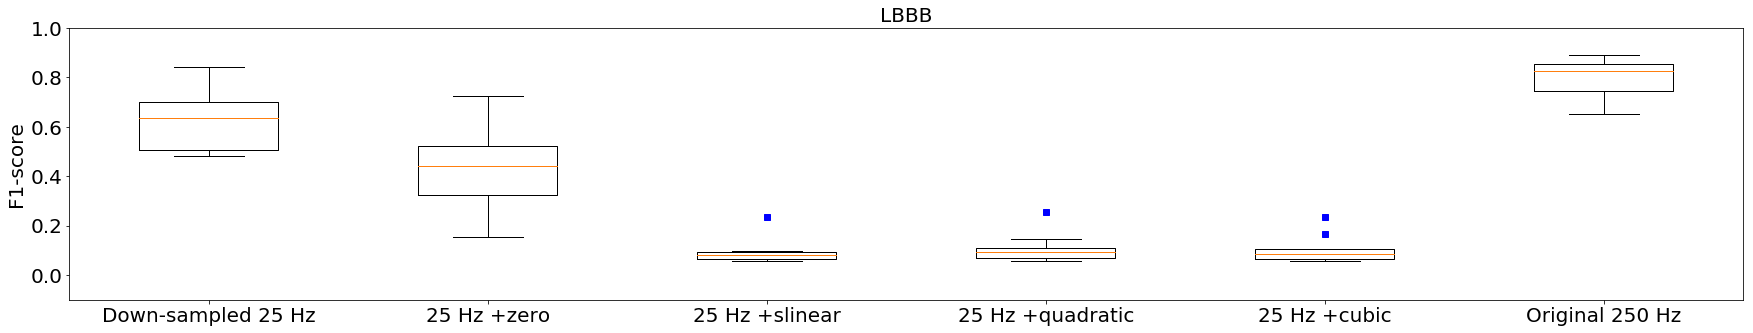

[0.63430127 0.44077922 0.08026049 0.09153799 0.08548231 0.82645804]
nan*
nan**
100#**
[1.25005788e-03 1.21884447e-04 7.56978609e-09 2.02884178e-08
 2.04281399e-08 1.00000000e+00]


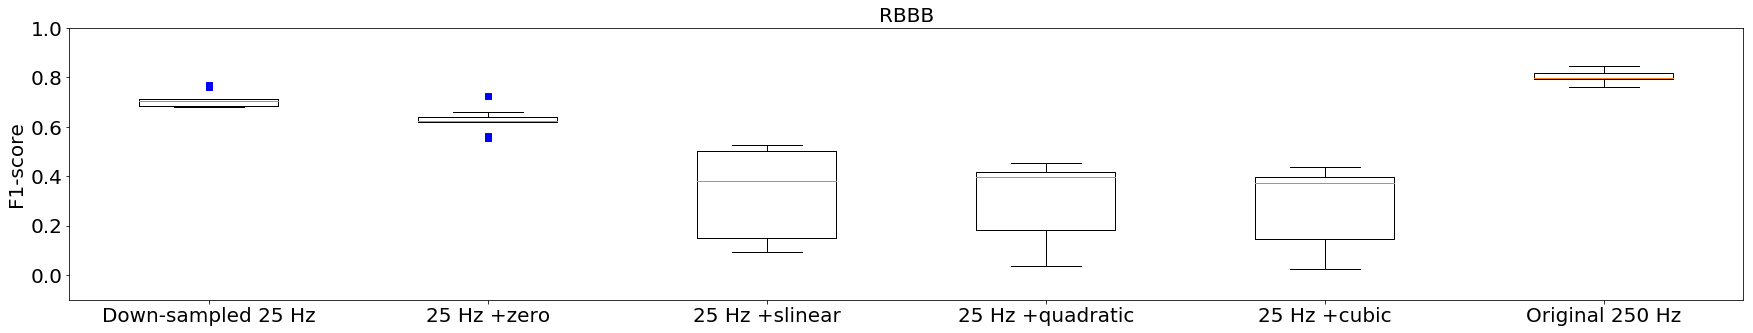

[0.70395499 0.62466323 0.38185654 0.39891215 0.37258652 0.79733883]
nan*
nan**
106#**
[9.92477064e-05 6.89803895e-06 1.97556265e-05 2.39108157e-06
 2.43458460e-06 1.00000000e+00]


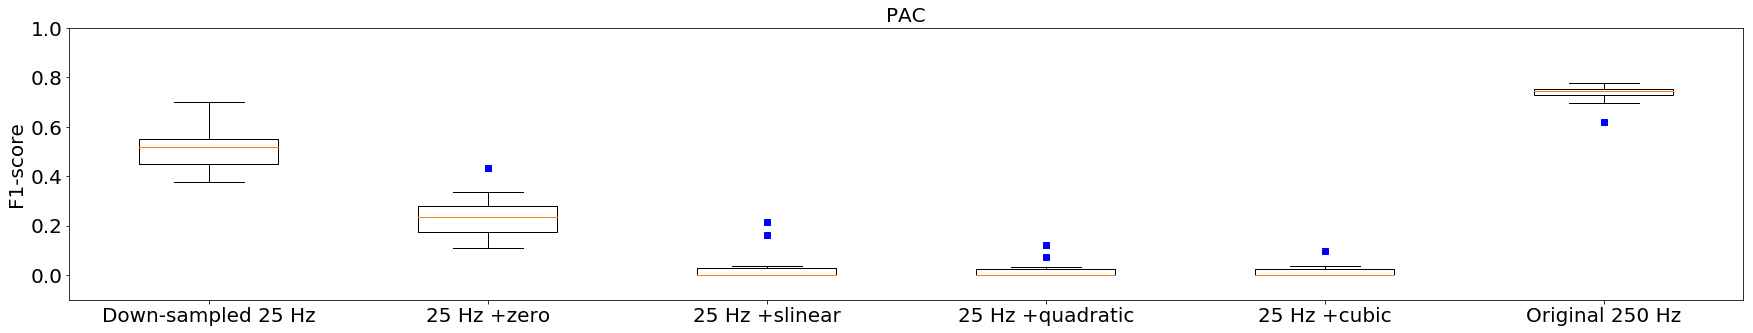

[0.51856298 0.23535188 0.         0.         0.         0.74442703]
nan*
nan**
100#**
[1.69981163e-04 1.18747111e-07 2.25716707e-09 2.98037230e-11
 1.15921834e-11 1.00000000e+00]


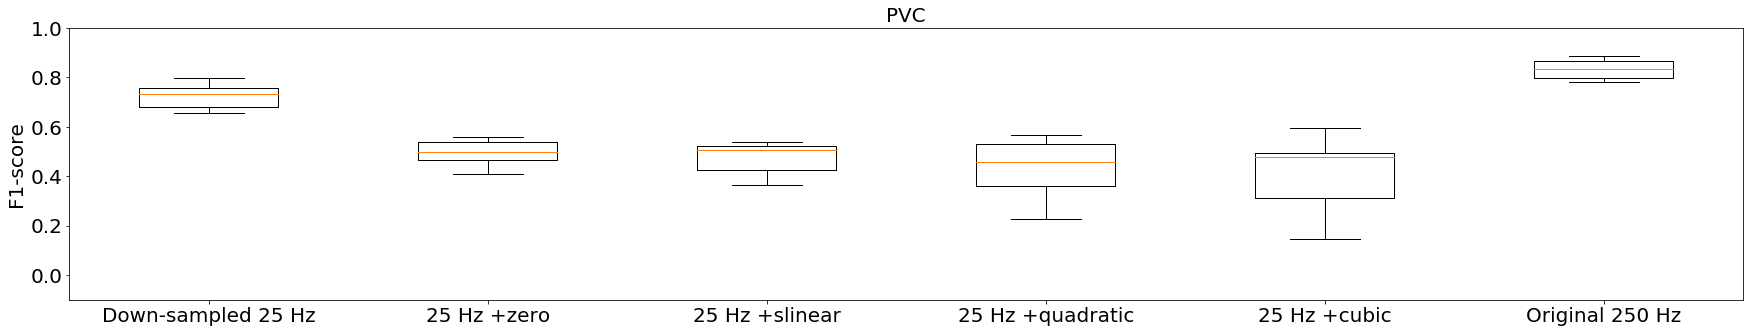

[0.73120856 0.49630542 0.50715421 0.45650794 0.47622378 0.83311209]
nan*
nan**
106#**
[7.48679377e-06 6.82790930e-09 8.33976952e-09 3.51404085e-06
 1.39002958e-05 1.00000000e+00]


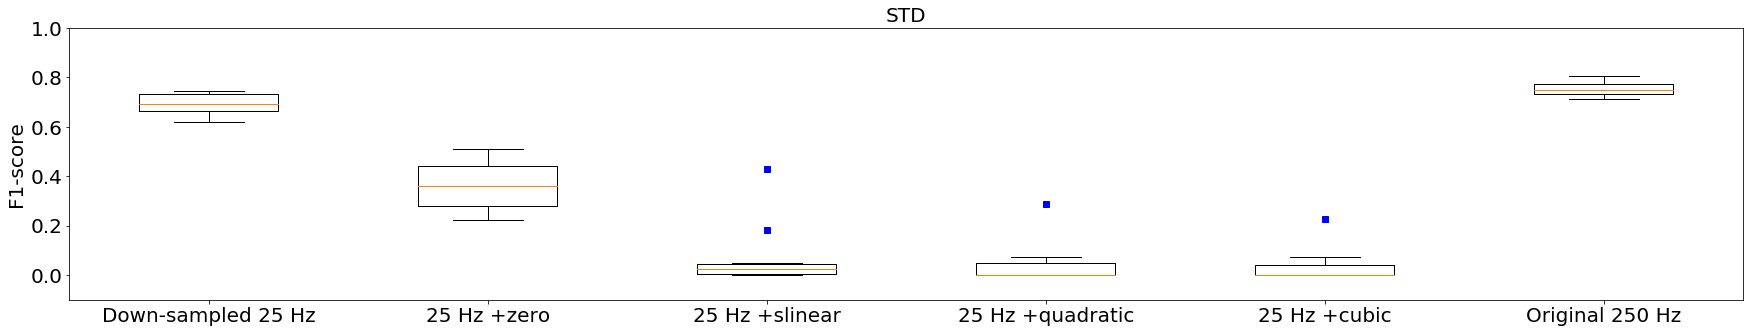

[0.69436851 0.35890152 0.02515823 0.         0.         0.74778107]
nan*
nan**
100#**
[8.58872821e-04 5.08981405e-07 8.49801098e-08 7.39112570e-10
 1.28921551e-10 1.00000000e+00]


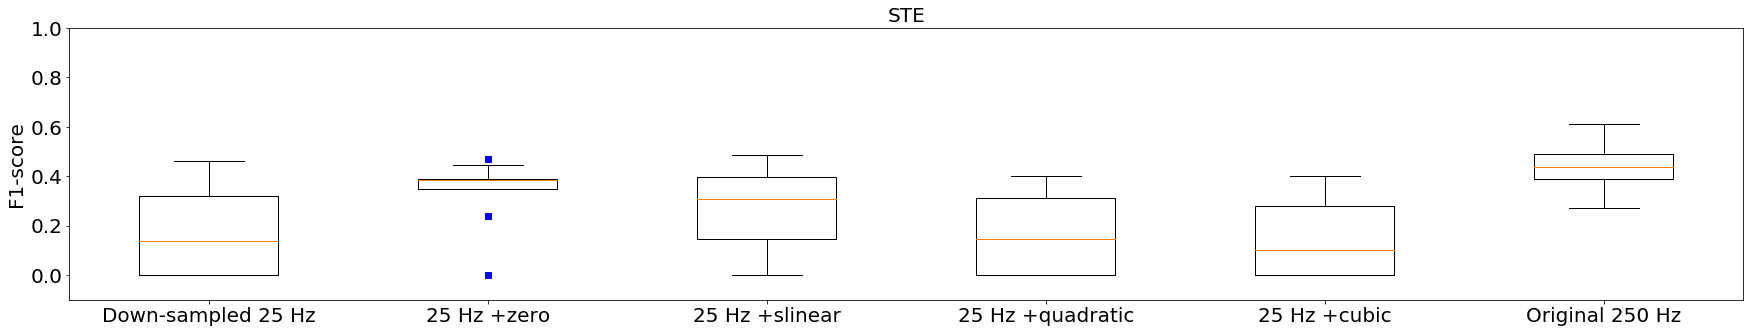

[0.13852814 0.38461538 0.30952381 0.1452381  0.10263158 0.43766578]
nan*
nan**
100#**
[0.00228456 0.03860784 0.01094958 0.00161319 0.00101507 1.        ]


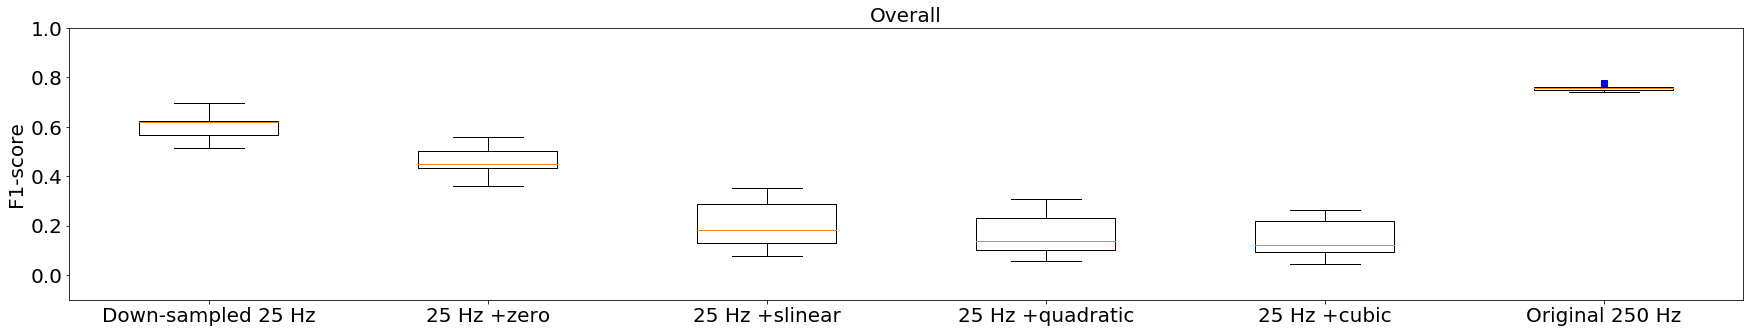

[0.61785668 0.44824957 0.18104393 0.13808233 0.12301892 0.75528723]
nan*
nan**
102#**
[3.24290354e-06 3.59383916e-08 1.37535566e-08 5.03213870e-09
 1.95698796e-09 1.00000000e+00]
Lead :V6


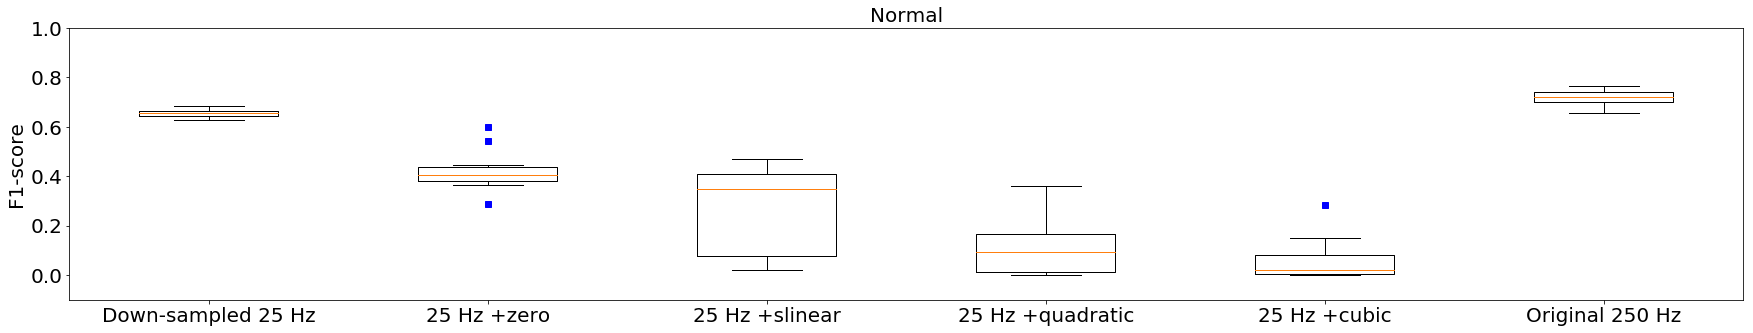

[0.65672618 0.40609584 0.34866705 0.09268707 0.02150538 0.72108462]
nan*
nan**
111#**
[4.41762705e-04 2.33065842e-06 2.42821346e-05 1.38485611e-07
 7.23516613e-09 1.00000000e+00]


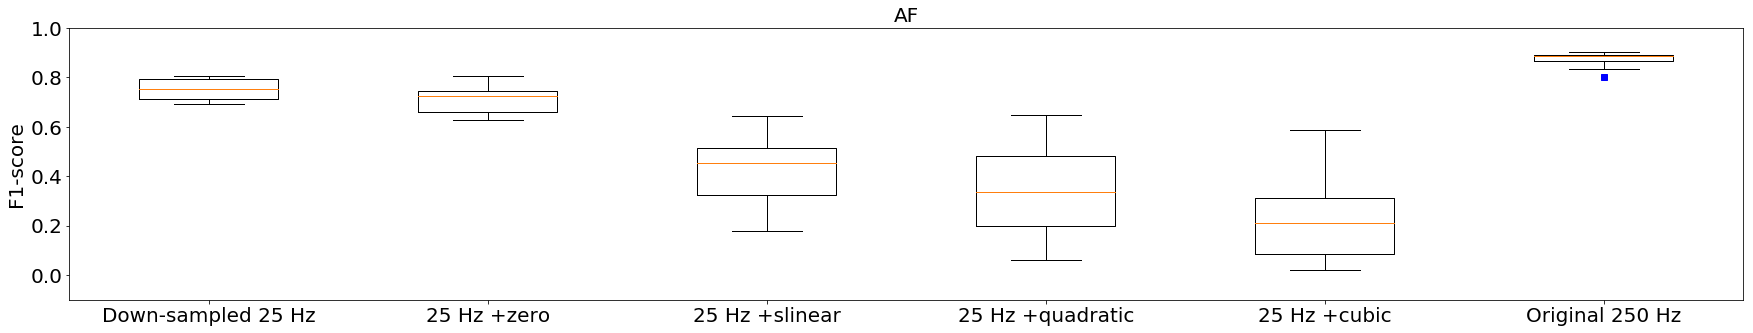

[0.75435897 0.72590034 0.45285988 0.33750773 0.21280603 0.88606881]
nan*
nan**
124#**
[1.85418844e-05 3.24615256e-06 7.89595491e-06 1.25977073e-05
 2.59043034e-06 1.00000000e+00]


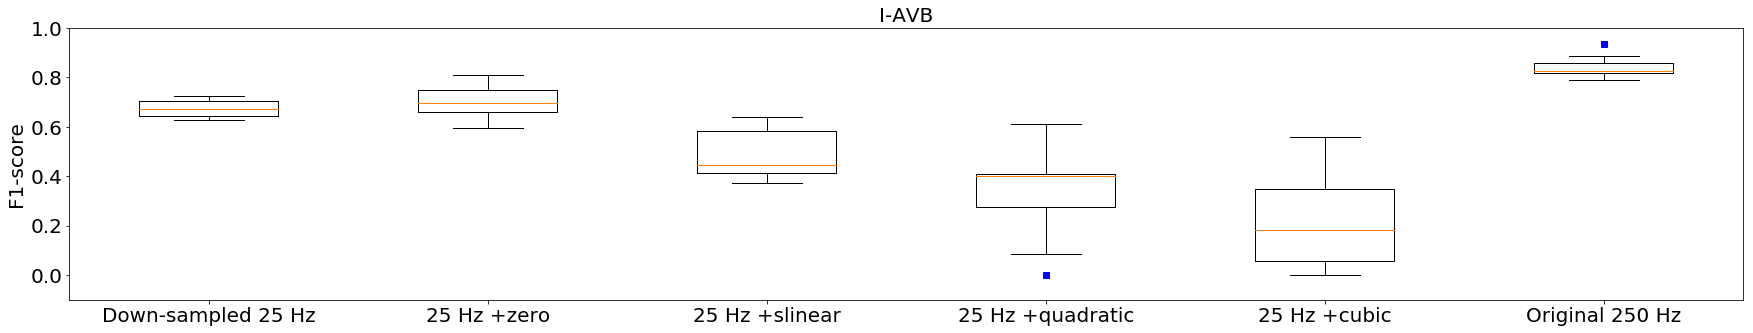

[0.67384306 0.69586466 0.44733273 0.4        0.18431373 0.82612125]
nan*
nan**
126#**
[9.14146088e-06 4.45832343e-04 2.07018860e-06 2.98920564e-05
 6.73209741e-06 1.00000000e+00]


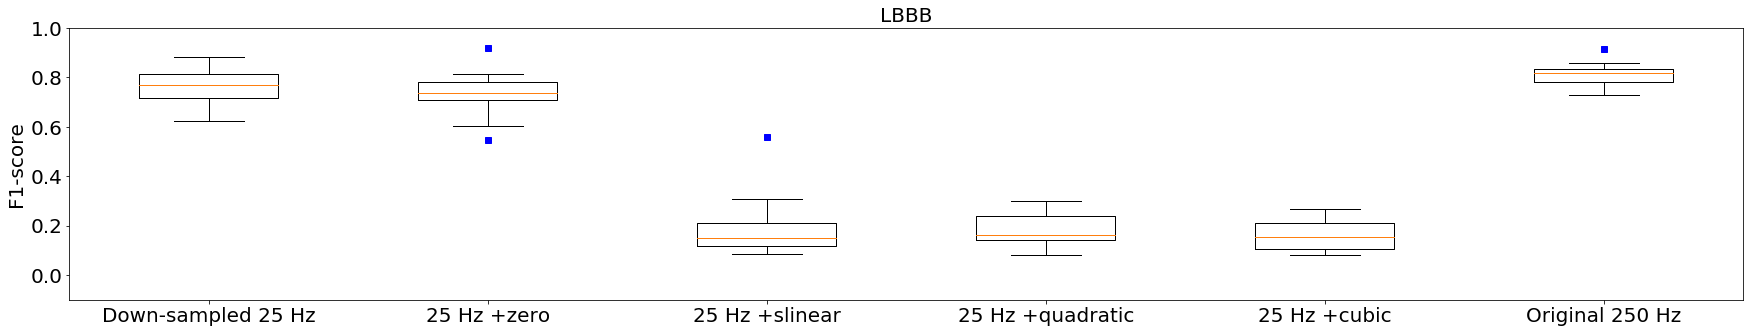

[0.76893939 0.73611111 0.15110689 0.16116628 0.15546442 0.81717011]
nan*
nan**
103#**
[1.51934720e-02 4.80918639e-02 2.51437410e-08 3.94139763e-10
 1.41254286e-10 1.00000000e+00]


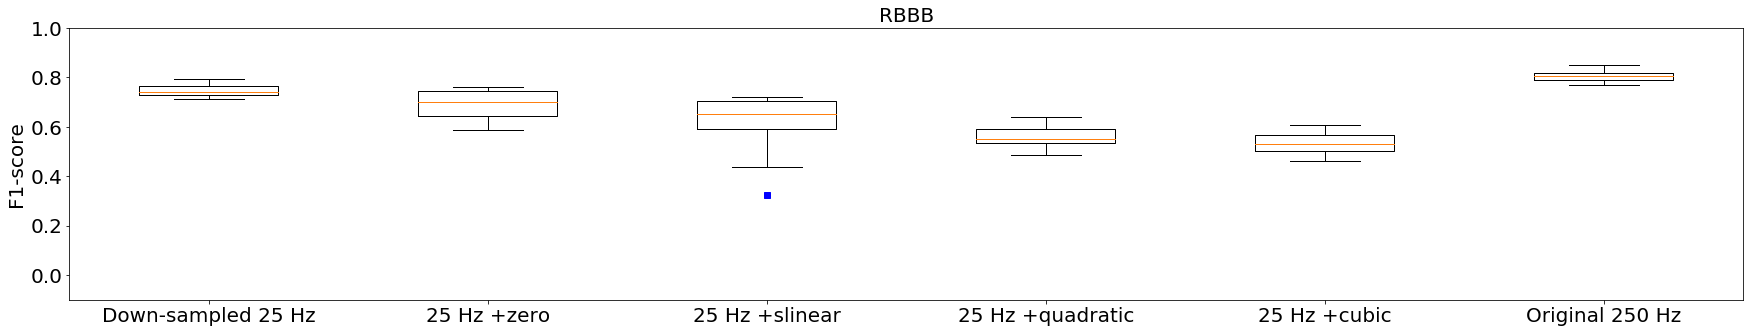

[0.742389   0.69937992 0.65294134 0.54966122 0.53214096 0.80750389]
nan*
nan**
111#**
[3.09142050e-05 2.32144325e-05 9.51140899e-04 3.80827519e-08
 2.04849535e-08 1.00000000e+00]


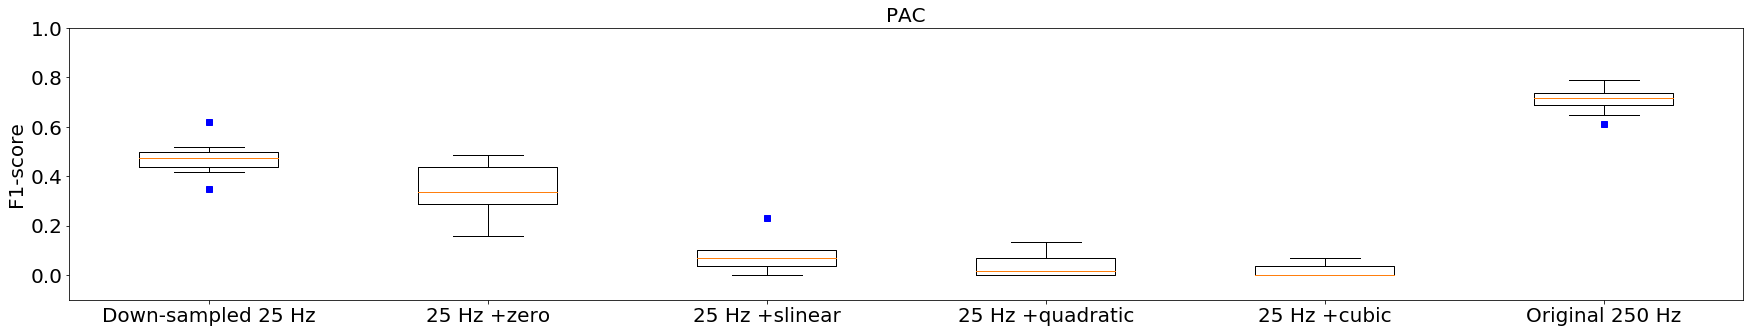

[0.47438902 0.33638406 0.0678746  0.01851852 0.         0.71767057]
nan*
nan**
100#**
[1.09057402e-05 1.08461468e-06 1.72970763e-08 1.32920214e-09
 1.78435145e-11 1.00000000e+00]


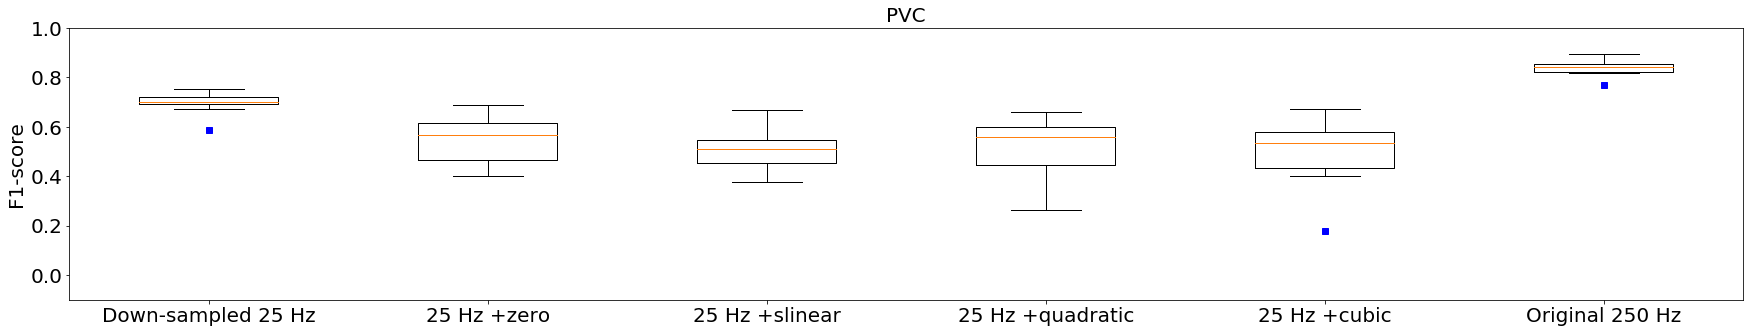

[0.70250488 0.5673279  0.512071   0.56025603 0.53630169 0.84113046]
nan*
nan**
106#**
[8.82352609e-06 4.70462370e-06 2.02705704e-07 5.35776860e-06
 1.14499798e-05 1.00000000e+00]


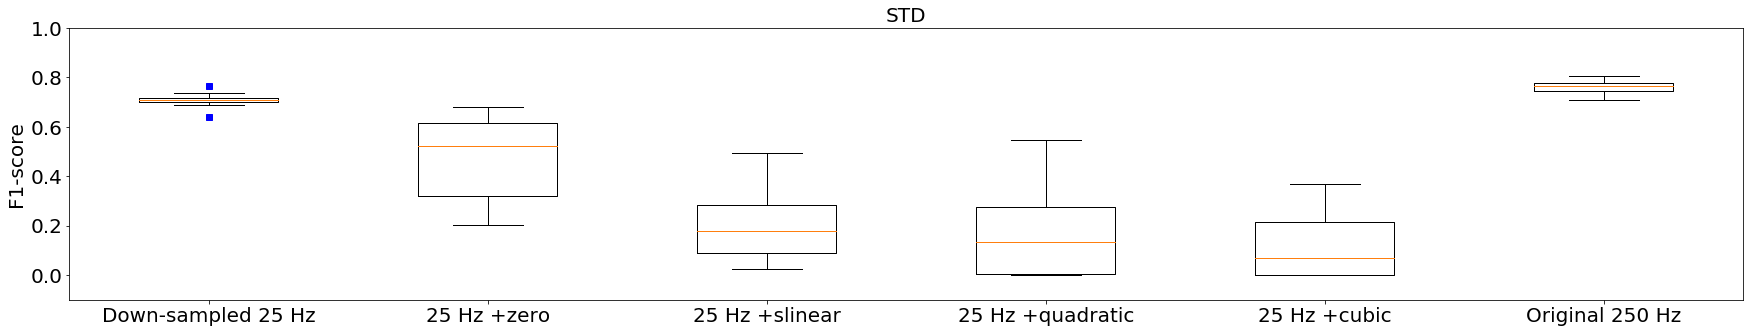

[0.70887598 0.52349043 0.17877653 0.13488045 0.07058824 0.76627157]
nan*
nan**
105#**
[7.89101154e-03 6.20145313e-04 4.74812507e-06 3.99097044e-06
 9.06829466e-08 1.00000000e+00]


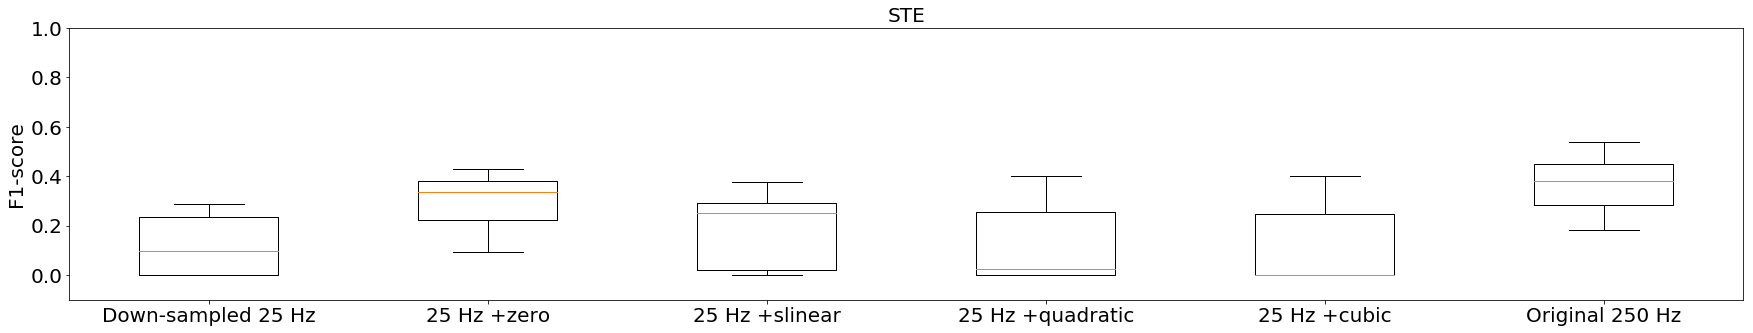

[0.09761905 0.33687943 0.25043478 0.02439024 0.         0.38224638]
nan*
nan**
100#**
[2.64571090e-04 2.12914649e-01 1.47883580e-03 4.37264190e-04
 3.64499538e-04 1.00000000e+00]


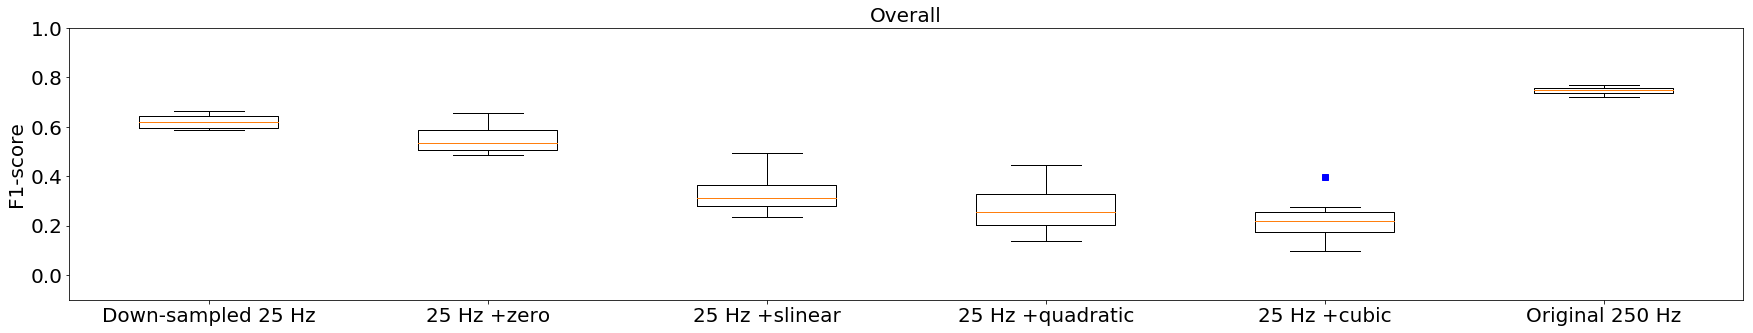

[0.61872292 0.53340843 0.3135069  0.256912   0.21985667 0.75074419]
nan*
nan**
109#**
[7.18956185e-08 5.48869363e-07 7.41002848e-08 4.70725182e-08
 1.08970548e-08 1.00000000e+00]


((12, 10), (12, 10), (12, 10))

In [ ]:
#box-plotting
%matplotlib inline
BIGGER_SIZE = 20
Hz = np.asarray([500,250,125,100,50,25,10,5,2,1])
HzLabel = np.asarray(['500Hz','250Hz','150Hz','100Hz','50Hz','25Hz','10Hz','5Hz','2Hz','1Hz'])
leadsLabel = np.asarray(['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6'])
titleList = ['Normal','AF', 'I-AVB','LBBB','RBBB','PAC','PVC','STD','STE','Overall']
# Types = ['Down-sampled 25 Hz', 'Reconstructed 25 Hz +cce', 'Reconstructed 25 Hz +mse', 'Reconstructed 25 Hz +cce +mse', 'Original 250 Hz']
Types = ['Down-sampled 25 Hz','25 Hz +zero', '25 Hz +slinear', '25 Hz +quadratic', '25 Hz +cubic', 'Original 250 Hz']

matrixForTable_005 = []
matrixForTable_001 = []
matrixForTable_PPR = []
for i in range(12):
    if i not in TargetLead:
        continue
    print('Lead :'+leadsLabel[i])
    subMatrixForTable_005 = []
    subMatrixForTable_001 = []
    subMatrixForTable_PPR = []
    for j in range(10):
        scoreList_and_average = np.concatenate((np.load('./comparison/CPSC2018_25HzTo250HzRecover_10_fold_lead_models_test_result_lead_new_traditionComparison_'+str(leadsLabel[i])+'.npy').T,np.asarray([np.mean(np.load('./comparison/CPSC2018_25HzTo250HzRecover_10_fold_lead_models_test_result_lead_new_traditionComparison_'+str(leadsLabel[i])+'.npy'),axis =2).T])),axis = 0)[j]
        fig = plt.figure(figsize=(30,5))
        bplot = plt.boxplot(scoreList_and_average.T.tolist(),
                    notch=False,  # box instead of notch shape
                    sym='bs',     # red squares for outliers
                    vert=True)   # horizontal box aligmnent
        plt.xticks([x+1 for x in range(len(Types))],Types, size=BIGGER_SIZE)
        plt.yticks(fontsize=BIGGER_SIZE)
        plt.ylim((-0.1, 1))
#         plt.xlabel('Sampling Frequency', size=BIGGER_SIZE)
        plt.ylabel('F1-score', size=BIGGER_SIZE)
        t = plt.title(titleList[j], size=BIGGER_SIZE)
        plt.show()
        print(np.median(scoreList_and_average,axis = 0))
        paired_ttest_to_best = np.asarray([stats.ttest_rel(scoreList_and_average[:,-1], scoreList_and_average[:,i])[1] for i in range(scoreList_and_average.shape[1])])
        paired_ttest_to_best[-1] = 1
        try:
            bestHz_005 = Types[paired_ttest_to_best<0.05][-1].astype('str')
        except:
            bestHz_005 = 'nan'
        try:
            bestHz_001 = Types[paired_ttest_to_best<0.01][-1].astype('str')
        except:
            bestHz_001 = 'nan'
        try:
            PPR = np.median((scoreList_and_average[:,-2]-scoreList_and_average[:,-1])/(scoreList_and_average[:,-3] - scoreList_and_average[:,-1]),axis = 0)
            PPR = np.round(PPR*100, 0).astype('int8').astype('str')
        except:
            PPR = 'nan'
        if np.median(scoreList_and_average[:,-3], axis = 0) - np.median(scoreList_and_average[:,-1], axis = 0) <= 0 :
            bestHz_005 += '*'
            bestHz_001 += '**'
            PPR += '#'
        if paired_ttest_to_best[-2] <0.05:
            PPR += '*'
            if paired_ttest_to_best[-2] <0.01:
                PPR += '*'
        print(bestHz_005)
        print(bestHz_001)
        print(PPR)
        subMatrixForTable_005.append(bestHz_005)
        subMatrixForTable_001.append(bestHz_001)
        subMatrixForTable_PPR.append(PPR)
        print(paired_ttest_to_best)
    matrixForTable_005.append(subMatrixForTable_005)
    matrixForTable_001.append(subMatrixForTable_001)
    matrixForTable_PPR.append(subMatrixForTable_PPR)
matrixForTable_005 = np.asarray(matrixForTable_005)
matrixForTable_001 = np.asarray(matrixForTable_001)
matrixForTable_PPR = np.asarray(matrixForTable_PPR)
matrixForTable_005.shape, matrixForTable_001.shape, matrixForTable_PPR.shape

# Create requirements.txt


In [ ]:
!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt